<a id="Data_Analysis_R"></a>
# Data Analysis R

This notebook contains an R based analysis for the creation of a composite model for method selection. It partially draws on previous analysis in Python and R and therefore neglects some of the basic analyses of the explanatory variables.

[Data Analysis R](#Data_Analysis_R)

- [Configurations](#Configurations)
- [Data Acquisition](#Data_Acquisition)
- [Classification Model](#Classification_Model)
    - [Common Functions](#Common_Functions)
    - [Variable selection for linear error models](#Variable_Selection)
    - [Composite Model](#Composite_Model)
    - [Final Model Analysis](#Final_Model_Analysis)
    - [Paper Visualisations](#Paper_Visualisations)    
    - [Exploring high errors and model behaviour](#Error_Exploration)


<a id="Configurations"></a>
## Configurations

In [1]:
#Set language to get english errors and messages
Sys.setenv(LANG = "en")

In [2]:
#Import packages 
library(ggpubr)
library(gridExtra)
library(plyr)
library(dplyr) 
library(tidyverse)
library(caret)
library(fastDummies)
library(Metrics)


Loading required package: ggplot2


Attaching package: 'plyr'


The following object is masked from 'package:ggpubr':

    mutate



Attaching package: 'dplyr'


The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following object is masked from 'package:gridExtra':

    combine


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8     ✔ purrr   0.3.4
✔ tidyr   1.2.1     ✔ stringr 1.4.1
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ dplyr::combine()   masks gridExtra::combine()
✖ purrr::compact

In [3]:
#Classes/filter methods for final model
classes <- c(1,2,3,7,8,9,10,11,12,19)

#Parameters for model configuration
dynamic <- FALSE
method <- "lm"
target_prefix <- "stems_in_plot_err_ps"

<a id="Data_Acquisition"></a>
## Data Acquisition

In [4]:
#Read data for plots
csv_out_path <- "./Data/detection_aggregated_lfi.csv"
lfi_trees_grouped <- read.csv(csv_out_path,sep=";",quote = "\"")

In [5]:
#Labels for filter methods
parameterset_lookup_labels<-data.frame(val=c( '1m','1.5m','2m','1m, sigma 1, size 3','1m, sigma 1, size 5','1m, sigma 1, size 7','1m, sigma 2, size 3','1m, sigma 2, size 5','1m, sigma 2, size 7','1m, sigma 3, size 3','1m, sigma 3, size 5','1m, sigma 3, size 7','1.5m, sigma 2, size 3','1.5m, sigma 2, size 5','1.5m, sigma 2, size 7','combined 1m/1.5m/1m, sig2, r3','combined 1m/2m/1m, sig2, r5','combined 1m/1.5m/1m, sig1, r3/1m, sig2, r3','combined 1m/1.5m/1m, sig1, r3/1m, sig2, r3/1m, sig3, r3','Eysn LM Filter','Kaartinen FGI LOCM'), row.names=c( 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,30,31))


In [6]:
nh_lookup_labels<-data.frame(val=c( 'b) Broadleaved','c) Mixed','d) Coniferous'), row.names=c( 1,2,3))
dg_lookup_labels<-data.frame(val=c( 'e) DC ≤ 80%','f) DC > 80%'), row.names=c( 1,2))
hdom_lookup_labels<-data.frame(val=c( 'g) hdom ≤ 22 m', 'h) hdom > 22 m'), row.names=c( 1,2))

In [7]:
#Excluding specific cases
print(count(lfi_trees_grouped)$n)

#Cases with very high stems per ha in baseline ; 3
lfi_trees_grouped <- lfi_trees_grouped[ !(lfi_trees_grouped$flaeche_id %in% c(40321,154907,156044)),]
print(count(lfi_trees_grouped)$n)

#Cases without reference value 
lfi_trees_grouped <- lfi_trees_grouped[!(is.na(lfi_trees_grouped$density_actual_all)),] 
print(count(lfi_trees_grouped)$n)

[1] 5913
[1] 5910
[1] 5910


In [8]:
#Excluding cases without reference data
lfi_trees_grouped <- lfi_trees_grouped[!(is.na(lfi_trees_grouped$nbr_trees_os) | is.na(lfi_trees_grouped$nbr_trees) | (lfi_trees_grouped$nbr_trees_os==0) | (lfi_trees_grouped$nbr_trees_os==-1)),] 
print(count(lfi_trees_grouped)$n)

##Cases with reference value 0 ; 329
#lfi_trees_grouped = lfi_trees_grouped[np.invert((lfi_trees_grouped["density_actual"]==0)&(lfi_trees_grouped["density_actual_all"]==0))].reset_index() 
#print(len(lfi_trees_grouped))

[1] 5254


In [9]:
#Replacing placeholders in stem counts per ha (they could mess up some charts and operations)
for (i in 1:19){
    lfi_trees_grouped[paste("stems_per_ha_ps",i,sep="")] <- apply(lfi_trees_grouped[paste("stems_per_ha_ps",i,sep="")], 1, function(x) ifelse(x>=99999999, 0, x))
    lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")] <- apply(lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")], 1, function(x) ifelse(x>=99999999, NA, x))
}

#Additional detections
for (i in 30:31){
    lfi_trees_grouped[paste("stems_per_ha_ps",i,sep="")] <- apply(lfi_trees_grouped[paste("stems_per_ha_ps",i,sep="")], 1, function(x) ifelse(x>=99999999, 0, x))
    lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")] <- apply(lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")], 1, function(x) ifelse(x>=99999999, NA, x))
}

In [10]:
#Deriving and re-setting several error measures
for (i in 1:19){    
    lfi_trees_grouped[paste("stems_in_plot_ae_ps",i,sep="")] <- abs(lfi_trees_grouped["nbr_trees_os"]-lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")])
    lfi_trees_grouped[paste("stems_in_plot_err_ps",i,sep="")] <- (lfi_trees_grouped["nbr_trees_os"]-lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")])
    
    lfi_trees_grouped[paste("stems_in_plot_ae_all_ps",i,sep="")] <- abs(lfi_trees_grouped["nbr_trees"]-lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")])
    lfi_trees_grouped[paste("stems_in_plot_err_all_ps",i,sep="")] <- (lfi_trees_grouped["nbr_trees"]-lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")])
    
    lfi_trees_grouped[paste("stems_per_ha_rs_ps",i,sep="")] <- (lfi_trees_grouped["density_actual"]-lfi_trees_grouped[paste("stems_per_ha_ps",i,sep="")])^2
    lfi_trees_grouped[paste("stems_per_ha_ae_ps",i,sep="")] <- abs(lfi_trees_grouped["density_actual"]-lfi_trees_grouped[paste("stems_per_ha_ps",i,sep="")])
    lfi_trees_grouped[paste("stems_per_ha_err_ps",i,sep="")] <- (lfi_trees_grouped[paste("stems_per_ha_ps",i,sep="")]-lfi_trees_grouped["density_actual"])

}

#Additional detections
for (i in 30:31){
    lfi_trees_grouped[paste("stems_in_plot_ae_ps",i,sep="")] <- abs(lfi_trees_grouped["nbr_trees_os"]-lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")])
    lfi_trees_grouped[paste("stems_in_plot_err_ps",i,sep="")] <- (lfi_trees_grouped["nbr_trees_os"]-lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")])
    
    lfi_trees_grouped[paste("stems_in_plot_ae_all_ps",i,sep="")] <- abs(lfi_trees_grouped["nbr_trees"]-lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")])
    lfi_trees_grouped[paste("stems_in_plot_err_all_ps",i,sep="")] <- (lfi_trees_grouped["nbr_trees"]-lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")])
    
    lfi_trees_grouped[paste("stems_per_ha_rs_ps",i,sep="")] <- (lfi_trees_grouped["density_actual"]-lfi_trees_grouped[paste("stems_per_ha_ps",i,sep="")])^2
    lfi_trees_grouped[paste("stems_per_ha_ae_ps",i,sep="")] <- abs(lfi_trees_grouped["density_actual"]-lfi_trees_grouped[paste("stems_per_ha_ps",i,sep="")])
    lfi_trees_grouped[paste("stems_per_ha_err_ps",i,sep="")] <- (lfi_trees_grouped[paste("stems_per_ha_ps",i,sep="")]-lfi_trees_grouped["density_actual"])

}

In [11]:
#Deriving attributes from existing data 
lfi_trees_grouped["acquisition_diff"] <- lfi_trees_grouped["VHM_Tile_Year"]-lfi_trees_grouped["year"]
lfi_trees_grouped["acquisition_diff_abs"] <- abs(lfi_trees_grouped["acquisition_diff"])

lfi_trees_grouped["veg_code_complete"] <- lfi_trees_grouped["veg_code"]*100+lfi_trees_grouped["veg_subcode"]
lfi_trees_grouped["constant"] <- 1

lfi_trees_grouped["dg_scaled"] <- lfi_trees_grouped["dg"]/100
lfi_trees_grouped["hdom_scaled"] <- lfi_trees_grouped["hdom"]/100
lfi_trees_grouped["nh_scaled"] <- lfi_trees_grouped["nh"]/100

In [12]:
#Determine method with minimal squared difference
determine_min_class_flex <- function (x, input_prefix="stems_per_ha_rs_", input_classes){
    input_columns <- lapply(input_classes,function(x) paste(input_prefix,"ps",x,sep=""))

    min_val = min(x[unlist(input_columns)])

    for (i in input_classes){
        if (x[paste(input_prefix,"ps",i,sep="")] == min_val) {
            return(i)
        }
    }
}


lfi_trees_grouped["parameterset_min"] <- apply(lfi_trees_grouped,1,function(x) determine_min_class_flex(x, input_prefix="stems_per_ha_rs_",input_classes=classes) )   
    

In [13]:
#Deriving 0/1 labels for whether a filter method has the minimal error or not
eps=0.0001
pid <- 0
determine_min_labels <- function (df, input_prefix="stems_per_ha_rs_", output_prefix="ps", input_classes=c(1,2,3,7,8,9,4,5,6,10,11,12,13,14,15,16,17,18,19)){
    input_columns <- lapply(input_classes,function(x) paste(input_prefix,"ps",x,sep=""))
    
    df$tmp_min <- apply(df[unlist(input_columns)],1,min)

    for (i in 1:length(input_classes)) {
        ps=input_classes[[i]]
        df[paste(output_prefix,ps,sep="")] <-  (abs((df[paste(input_prefix,"ps",ps,sep="")] - df$tmp_min))<eps)*1
    }             
    return(subset(df, select = -c(tmp_min) ))
}

lfi_trees_grouped <- determine_min_labels(lfi_trees_grouped, output_prefix="ps", input_classes=classes)
                            
lfi_trees_grouped$parameterset_min <- as.factor(lfi_trees_grouped$parameterset_min)  


In [14]:
#Not clear if this is necessary/wise
lfi_trees_grouped$fst <- as.factor(lfi_trees_grouped$fst)  
lfi_trees_grouped$fst_nh <- as.factor(lfi_trees_grouped$fst_nh)  
lfi_trees_grouped$fst_dg <- as.factor(lfi_trees_grouped$fst_dg)  
lfi_trees_grouped$fst_hdom <- as.factor(lfi_trees_grouped$fst_hdom)  
lfi_trees_grouped$veg_code <- as.factor(lfi_trees_grouped$veg_code)  
lfi_trees_grouped$veg_subcode <- as.factor(lfi_trees_grouped$veg_subcode)  
lfi_trees_grouped$veg_code_complete <- as.factor(lfi_trees_grouped$veg_code_complete)  
lfi_trees_grouped$waldrand <- as.factor(lfi_trees_grouped$bestandesgrenze)  
lfi_trees_grouped$bestandesgrenze <- as.factor(lfi_trees_grouped$bestandesgrenze)

Detection and reference data fields.

|__Name__| __Description__|__Variable Type}__ |
|--------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------|
| Perimeter ID                                                                                     | Identifier of the perimeter                                                                                                                                                                                  | none                   |
| slope_sin<sup>1</sup>                                                                 | Sine of the slope based on 25 m DHM                                                                                                                                                                          | explanatory            |
| aspect_cos                                                                                   | Cosine of the aspect based on 25 m DHM                                                                                                                                                                       | explanatory            |
| aspect_sin                                                                                   | Sine of the aspect based on 25 m DHM                                                                                                                                                                         | explanatory            |
| northness<sup>1</sup>                                                                  | Cosine of the aspect times the sine of the slope based on 25 m DHM                                                                                                                                           | explanatory            |
| eastness                                                                                      | Sine of the aspect times the sine of the slope based on 25 m DHM                                                                                                                                             | explanatory            |
| z<sup>1</sup>                                                                          | Height above sea level in m at plot center                                                                                                                                                                   | explanatory            |
| dg<sup>1</sup>                                                                         | Degree of cover ($(2/3*h_{dom})<h$) in percent (values from 0 to 100) for a 25 by 25 m cell centered on the plot center                                                                                      | explanatory            |
| hdom<sup>1</sup>                                                       | Dominant height in the plot in m for a 25 by 25 m cell centered on the plot center                                                                                                                           | explanatory            |
| nh<sup>1</sup>                                                                        | Dominant Leaf Type for a 25 by 25 m cell centered on the plot center                                                                                                                                         | explanatory            |
| dg_ks<sup>1</sup>                                                                    | Degree of cover no layer ($h<0.4m$) in percent (values from 0 to 100) for a 25 by 25 m cell centered on the plot center                                                                                      | explanatory            |
| dg_us<sup>1</sup>                                                                     | Degree of cover lower layer ($0.4m<=h<=(1/3*h_{dom})$) in percent (values from 0 to 100)  for a 25 by 25 m cell centered on the plot center                                                                  | explanatory            |
| dg_ms<sup>1</sup>                                                                     | Degree of cover middle layer ($(1/3*h_{dom})<h<=(2/3*h_{dom})$) in percent (values from 0 to 100)  for a 25 by 25 m cell centered on the plot center                                                         | explanatory            |
| dg_os<sup>1</sup>                                                                    | Degree of cover upper layer ($(2/3*h_{dom})<h<=h_{dom}$) in percent (values from 0 to 100)  for a 25 by 25 m cell centered on the plot center                                                                | explanatory            |
| dg_ueb<sup>1</sup>                                                                    | Degree of cover protruding ($h_{dom}<h$) in percent (values from 0 to 100) for a 25 by 25 m cell centered on the plot center                                                                                 | explanatory            |
| tri_min<sup>1</sup>, tri_max, tri_mean<sup>1</sup>, tri_median, tri_std<sup>1</sup> | Aggregated statistics for the Terrain Ruggedness Index of the CHM in a 25 by 25 m cell centered on the plot center                                                                                           | explanatory            |
| tpi_min, tpi_max, tpi_mean<sup>1</sup>, tpi_median<sup>1</sup>, tpi_std<sup>1</sup> | Aggregated statistics for the Topographic Position Index of the CHM in a 25 by 25 m cell centered on the plot center                                                                                         | explanatory            |
| nbr_trees_os                                                                                   | Reference value number of trees in the upper layer                                                                                                                                                           | reference/target       |
| density\_actual                                                                                  | Reference value for tree density in trees per ha; this only includes the trees of the upper layer                                                                                                            | reference/target       |
| stems_per_ha_ps1 ... stems_per_ha_ps15                                                     | Number of detected trees per ha for filter combinations 1 to 15 (trees per ha)                                                                                                                               | target/scoring         |
| dr_ps1 ... dr_ps15                                                                             | Detection rate on reference trees in the upper canopy layer (stems_per_ha_psX/density_actual) for the filter combinations 1 to 10                                                                        | target/scoring         |
| stems_in_plot_ps1 ... stems_in_plot_ps15                                                   | Absolute number of stems detected for the filter combinations 1 to 15                                                                                                                                        | target/scoring         |
| stems_per_ha_err_ps1 ... stems_per_ha_err_ps15                                           | Difference between stem count per ha detected and reference trees in the upper canopy layer per ha ( (stems_per_ha_rs_all_psX-density_actual)^2 ) for the filter combinations 1 to 15 | target/scoring         |
| stems_in_plot_err_ps1 ... stems_in_plot_err_ps15                                         | Difference between the number of detected trees and the number of reference trees in the upper layer of the plot (stems_in_plot_psX-nbr_trees) for the filter combinations 1 to 15                       | target/scoring         |
|
<sup>1</sup>: variable used in error model for  final analysis|

In [15]:
#Add dummy 0/1 columns for selected factors
lfi_trees_grouped <- dummy_cols(lfi_trees_grouped, select_columns = "fst")
lfi_trees_grouped <- dummy_cols(lfi_trees_grouped, select_columns = "fst_nh")
lfi_trees_grouped <- dummy_cols(lfi_trees_grouped, select_columns = "fst_dg")
lfi_trees_grouped <- dummy_cols(lfi_trees_grouped, select_columns = "fst_hdom")
        

In [16]:
#Adding log transformed error and errors normalized by the density within the plot
for (i in 1:19){ 
    stems <- lfi_trees_grouped[paste("stems_in_plot_err_ps",i,sep="")]
    stems_min <- min(stems+1,na.rm = TRUE)
    stems_max <- max(stems+1-stems_min,na.rm = TRUE)
    lfi_trees_grouped[paste("stems_in_plot_err_trans_ps",i,sep="")] <- log10(stems_max-(stems - stems_min))
    # lfi_trees_grouped[paste("stems_in_plot_err_trans_ps",i,sep="")] <- sqrt(stems_max-(stems - stems_min))
    lfi_trees_grouped[paste("stems_in_plot_err_norm_ps",i,sep="")] <- (lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")]-lfi_trees_grouped["nbr_trees_os"])/lfi_trees_grouped["nbr_trees_os"]
    # lfi_trees_grouped[paste("stems_in_plot_err_norm_ps",i,sep="")] <- (lfi_trees_grouped["nbr_trees_os"]-lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")])/sd(lfi_trees_grouped[,"nbr_trees_os"])
}

#Additional detections
for (i in 30:31){ 
    stems <- lfi_trees_grouped[paste("stems_in_plot_err_ps",i,sep="")]
    stems_min <- min(stems+1,na.rm = TRUE)
    stems_max <- max(stems+1-stems_min,na.rm = TRUE)
    lfi_trees_grouped[paste("stems_in_plot_err_trans_ps",i,sep="")] <- log10(stems_max-(stems - stems_min))
    # lfi_trees_grouped[paste("stems_in_plot_err_trans_ps",i,sep="")] <- sqrt(stems_max-(stems - stems_min))
    lfi_trees_grouped[paste("stems_in_plot_err_norm_ps",i,sep="")] <- (lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")]-lfi_trees_grouped["nbr_trees_os"])/lfi_trees_grouped["nbr_trees_os"]
    # lfi_trees_grouped[paste("stems_in_plot_err_norm_ps",i,sep="")] <- (lfi_trees_grouped["nbr_trees_os"]-lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")])/sd(lfi_trees_grouped[,"nbr_trees_os"])
}

In [17]:
print(paste(colnames(lfi_trees_grouped), collapse = "', '"))

[1] "perimeter_id', 'flaeche_id', 'source_id', 'source_label', 'slope', 'slope_class', 'slope_sin', 'aspect', 'aspect_class', 'aspect_cos', 'aspect_sin', 'northness', 'eastness', 'z', 'veg_code', 'veg_de', 'veg_subcode', 'fst', 'fst_dg', 'fst_hdom', 'fst_nh', 'dg', 'hdom', 'nh', 'hdom50', 'dg50', 'nh50', 'fst50', 'dg_ks', 'dg_us', 'dg_ms', 'dg_os', 'dg_ueb', 'dg_ks50', 'dg_us50', 'dg_ms50', 'dg_os50', 'dg_ueb50', 'tri_min', 'tri_max', 'tri_mean', 'tri_median', 'tri_std', 'tpi_min', 'tpi_max', 'tpi_mean', 'tpi_median', 'tpi_std', 'local_peaks', 'x_lv95', 'y_lv95', 'waldrand', 'bestandesgrenze', 'nbr_trees', 'nbr_trees_os', 'bas_ref', 'year', 'density_actual', 'density_actual_all', 'bas_per_ha_ref', 'KANTONSNUM', 'VHM_Year_Min', 'VHM_Year_Max', 'VHM_Tile_Year', 'plot_area', 'stems_per_ha_ps1', 'stems_per_ha_ps2', 'stems_per_ha_ps3', 'stems_per_ha_ps4', 'stems_per_ha_ps5', 'stems_per_ha_ps6', 'stems_per_ha_ps7', 'stems_per_ha_ps8', 'stems_per_ha_ps9', 'stems_per_ha_ps10', 'stems_per_ha_ps

In [18]:
#Some stats about the reference plots
summary(lfi_trees_grouped$z)
data.frame(table(lfi_trees_grouped$veg_de))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  195.3   669.7  1029.0  1078.8  1440.5  2243.6 

Var1                             Freq
1  -                                   5
2  collin                            111
3  collin mit Buche                  118
4  hochmontan im Tannen-Hauptareal   356
5  hochmontan im Tannen-Nebenareal   201
6  hochmontan im Tannen-Reliktareal  300
7  hyperinsubrisch                    29
8  obermontan                        948
9  obersubalpin                      239
10 subalpin                          580
11 submontan                         984
12 unter-/obermontan                 191
13 untermontan                      1192

<a id="Classification_Model"></a>
## Classification Model

<a id="Common_Functions"></a>
### Common Functions

In [19]:
#Setting input data
target_col = 'stems_per_ha_err_ps1'
cols_complete = c(  'slope_sin', 'aspect_sin', 'northness', 'eastness', 'z', 'veg_code', 
  'fst', 'fst_nh', 'fst_dg', 'fst_hdom',
  'dg', 'hdom', 'nh', 
  'dg_ks', 'dg_us', 'dg_ms', 'dg_os', 'dg_ueb', 
  'tri_min', 'tri_max', 'tri_mean', 'tri_median', 'tri_std', 
  'tpi_min', 'tpi_max', 'tpi_mean', 'tpi_median', 'tpi_std', 
  'waldrand', 'bestandesgrenze'
 ) 

In [20]:
#Function for partitioning data into calibration/validation
get_partitions <- function(target_col, data=lfi_trees_grouped, x_columns=cols_complete, calibration_size=0.8, random_state=42){
    set.seed(random_state)
    data_filtered <- data[!is.na(data[,target_col]),]
    in_calibration <- createDataPartition(data_filtered[,target_col], p = calibration_size)
    cols_combined = c(x_columns, target_col)
    return(list(
        in_calibration = in_calibration[[1]],
        calibration = data_filtered[in_calibration[[1]],cols_combined],
        validation = data_filtered[-in_calibration[[1]],cols_combined]
    ))
}


In [21]:
#Function for generrating a string representation of a fitted linear model
#Based on https://stats.stackexchange.com/a/433060
model_equation <- function(model, ...) {
  format_args <- list(...)
  
  model_coeff <- model$coefficients
  format_args$x <- abs(model$coefficients)
  model_coeff_sign <- sign(model_coeff)
  model_coeff_prefix <- case_when(model_coeff_sign == -1 ~ " - ",
                                  model_coeff_sign == 1 ~ " + ",
                                  model_coeff_sign == 0 ~ " + ")
  model_eqn <- paste(strsplit(as.character(model$call$formula), "~")[[2]], # 'y'
                     "=",
                     paste(if_else(model_coeff[1]<0, "- ", ""),
                           do.call(format, format_args)[1],
                           paste(model_coeff_prefix[-1],
                                 do.call(format, format_args)[-1],
                                 " * ",
                                 names(model_coeff[-1]),
                                 sep = "", collapse = ""),
                           sep = ""))
  return(model_eqn)
}

In [22]:
#Function for generating a list with string representations of the fitted models in a composite model
#Intended for examining the underlying linear models
gather_model_equations <- function(model_list, classes, target_prefix, digits = 3) {
    res <- list()
    for (i in 1:length(classes)){
        class <- classes[i]
        target_column <- paste(target_prefix,class,sep="")

        model <- model_list[[class]]
        model_formula <- model_equation(model$finalModel, digits = digits)
        model_formula <- gsub(".outcome", target_column, model_formula)
        res <- rbind(res,model_formula)
    }
    return(res)
}

In [23]:
#For lookup purposes when applying FST expert approach
fst_parameterset_mappings <- structure(c(2,2,7,16,
                                         2,16,7,16,
                                         16,16,16,16), 
                                names=c("111","112","121","122",
                                 "211","212","221","222",
                                 "311","312","321","322") ) 

<a id="Variable_Selection"></a>
### Variable selection for linear error models

In [24]:
#Variables for selection
cols_reduced = c(  
  'slope_sin', 'northness', 'eastness', 'z', 
  'dg', 'hdom', 'nh', 
  'dg_ks', 'dg_us', 'dg_ms', 'dg_os', 'dg_ueb', 
  'tri_min', 'tri_max', 'tri_mean', 'tri_median', 'tri_std', 
  'tpi_min', 'tpi_max', 'tpi_mean', 'tpi_median', 'tpi_std'
 ) 

In [25]:
#Function for performing a variable importance analysis for a specified pre-processing filter
variable_importance_analysis <- function(method='ps1') {
    #Variable Importance from a linear model with reduced columns and repeated CV
    target <- paste('stems_per_ha_err_',method,sep="")
    data <- lfi_trees_grouped[c(cols_reduced,target)]

    # ensure results are repeatable
    set.seed(42)
    # prepare training scheme
    control <- trainControl(method="repeatedcv", number=10, repeats=3)
    # calibrate/train the model
    model_lm_psx <- train(formula(paste(target,"~.",sep="")), data=data, method="lm", preProcess="scale", trControl=control)
    # estimate variable importance
    importance <- varImp(model_lm_psx, scale=FALSE)
    # summarize importance
    return(importance)    
}

In [26]:
#Perform a variable importance analysis for all pre-processing filters
importance_list <- vector(mode = "list", length = 19)
for (i in 1:19) {
    filter <- paste0("ps",i)
    imp <- variable_importance_analysis(filter)
    imp <- imp$importance
    names(imp) <- filter
    importance_list[[i]] <- imp
}

importance_matrix <- do.call("cbind",importance_list)

In [27]:
#Determine the count of variables with importance variables above the set threshold
importance_threshold <- 2.5
importance_matrix$relevance_count <- 0
importance_matrix$relevance_count  <- apply(importance_matrix, 1, function(x) sum(x>importance_threshold))
importance_matrix

ps1        ps2       ps3        ps4        ps5       ps6       
slope_sin   1.4063745 2.7543458  1.4058411 2.90588260 3.0341322 3.00453783
northness   7.3714761 6.8449459  6.9839055 6.99347176 7.0571268 7.05902083
eastness    1.2817060 0.1197211  0.2066311 0.06219663 0.3807246 0.29881146
z           8.3180668 4.4698947  3.7279665 5.39576602 3.7733213 3.63823134
dg          3.8157362 6.9989055  6.5835365 7.21404352 7.6917242 7.62198801
hdom        4.3457746 8.5125573  6.3579132 9.03202366 7.8282127 7.67609863
nh         15.9859719 8.6301350 10.2501359 8.23768674 9.0385981 9.14505064
dg_ks       9.0584876 1.3258594  1.3980846 1.61030841 0.0926666 0.04807435
dg_us       1.0768491 2.1683959  3.3577751 2.14984155 2.6092050 2.67075415
dg_ms       1.7361167 3.0040424  3.6625294 2.79699330 2.5868625 2.71609613
dg_os       5.0675353 5.4206947  4.7593157 5.80199940 6.0363654 5.92898182
dg_ueb      3.6293886 6.1051327  5.3094751 6.35630075 6.4681988 6.37627765
tri_min     3.4217383 2.2016138  2.3802706 2.04253879 3.1599044 3.06966337
tri_max     1.4882714 0.6169011  0.2984693 0.85075980 0.9297182 1.11560931
tri_mean    8.9615189 0.6447353  3.1795704 1.73775654 0.5319714 0.52543340
tri_median  1.2333636 1.2016178  0.6399113 0.61720353 1.0396003 0.95253935
tri_std     7.2074602 1.1564483  1.6136097 2.83470042 0.6066184 0.82944403
tpi_min     0.0883858 0.7246843  1.6392549 0.14986681 0.6788587 0.43742210
tpi_max     1.5943907 0.7215373  0.6957317 0.94982067 0.6634240 0.76443912
tpi_mean    1.6841863 0.5350701  2.0456831 0.25248453 1.0009777 0.95102664
tpi_median  4.5288645 0.7027575  2.6983653 0.71939894 1.8099336 1.73705997
tpi_std    13.2724378 1.7715345  3.5328553 4.23377796 0.1913980 0.40959029
           ps7       ps8        ps9        ps10       ps11        ps12        
slope_sin  2.3301105  0.2384957  0.7479818 1.92759908  0.02225891  1.049384647
northness  6.9097759  7.4842269  7.0928633 6.85660083  7.71762820  7.025318624
eastness   0.6563426  0.5198621  0.2427041 0.73087305  0.16976428  0.067759816
z          5.0351026  3.7462438  3.3154465 5.38080015  3.92971316  4.014227267
dg         4.8640344  6.4647292  6.0480524 2.13071632  6.01709897  5.571698026
hdom       8.5815525  6.0177802  5.1810534 7.75612221  6.56263161  5.811179667
nh         9.0048836 11.7474892 12.6748085 9.49917717 11.92236386 13.036458569
dg_ks      1.5755722  1.7823058  3.1448577 0.64898307  1.06713793  2.772761536
dg_us      1.6976063  3.3539498  3.9301537 1.31473019  2.81313546  3.624240655
dg_ms      3.2703942  3.5950802  4.2790467 4.02290633  3.46982844  4.222010287
dg_os      4.1374615  4.8749825  4.3684670 0.45425520  4.73184216  4.209658933
dg_ueb     4.5176760  5.1863730  4.5955521 0.76859419  4.88626858  4.243786207
tri_min    1.2806827  2.0237282  1.7973643 1.22710821  1.40595314  1.128625438
tri_max    0.8288099  0.4548364  0.1819805 0.42216776  0.51522971  0.005332177
tri_mean   0.6278039  2.9066539  4.6141376 0.17637882  2.84958533  4.228408860
tri_median 0.8477122  0.9251011  0.7149726 1.29619294  0.95841222  1.009454493
tri_std    1.2681643  2.0167459  3.6703608 0.06085361  2.14139801  3.898224456
tpi_min    0.3899170  1.6166564  2.1171098 0.92303771  1.68919814  2.356971092
tpi_max    1.1634039  1.0070207  0.6784311 1.14101460  0.88887381  0.703205313
tpi_mean   0.5238055  1.5946222  2.0049872 1.00164133  1.51410027  2.390535102
tpi_median 1.5351875  3.3158036  3.5334036 1.90238315  3.20451269  3.767229454
tpi_std    2.1901660  3.6248859  6.4091355 0.45785850  3.62588996  6.240248333
           ps13       ps14       ps15       ps16      ps17        ps18       
slope_sin   1.1538865  1.8723898  2.4312124 3.4010906  2.05513032 3.555723538
northness   7.4234790  7.1788924  7.5157571 6.5044133  6.49228077 6.603522790
eastness    0.1280504  0.2584951  0.1655642 0.7228698  0.85150466 0.777924440
z           4.4875486  4.2814038  4.3886862 5.5405866  4.26417628 5.742178878
dg          4.2530832  4.9662493  5.1295326 6.2991795  6.62587261 6.940703425
h

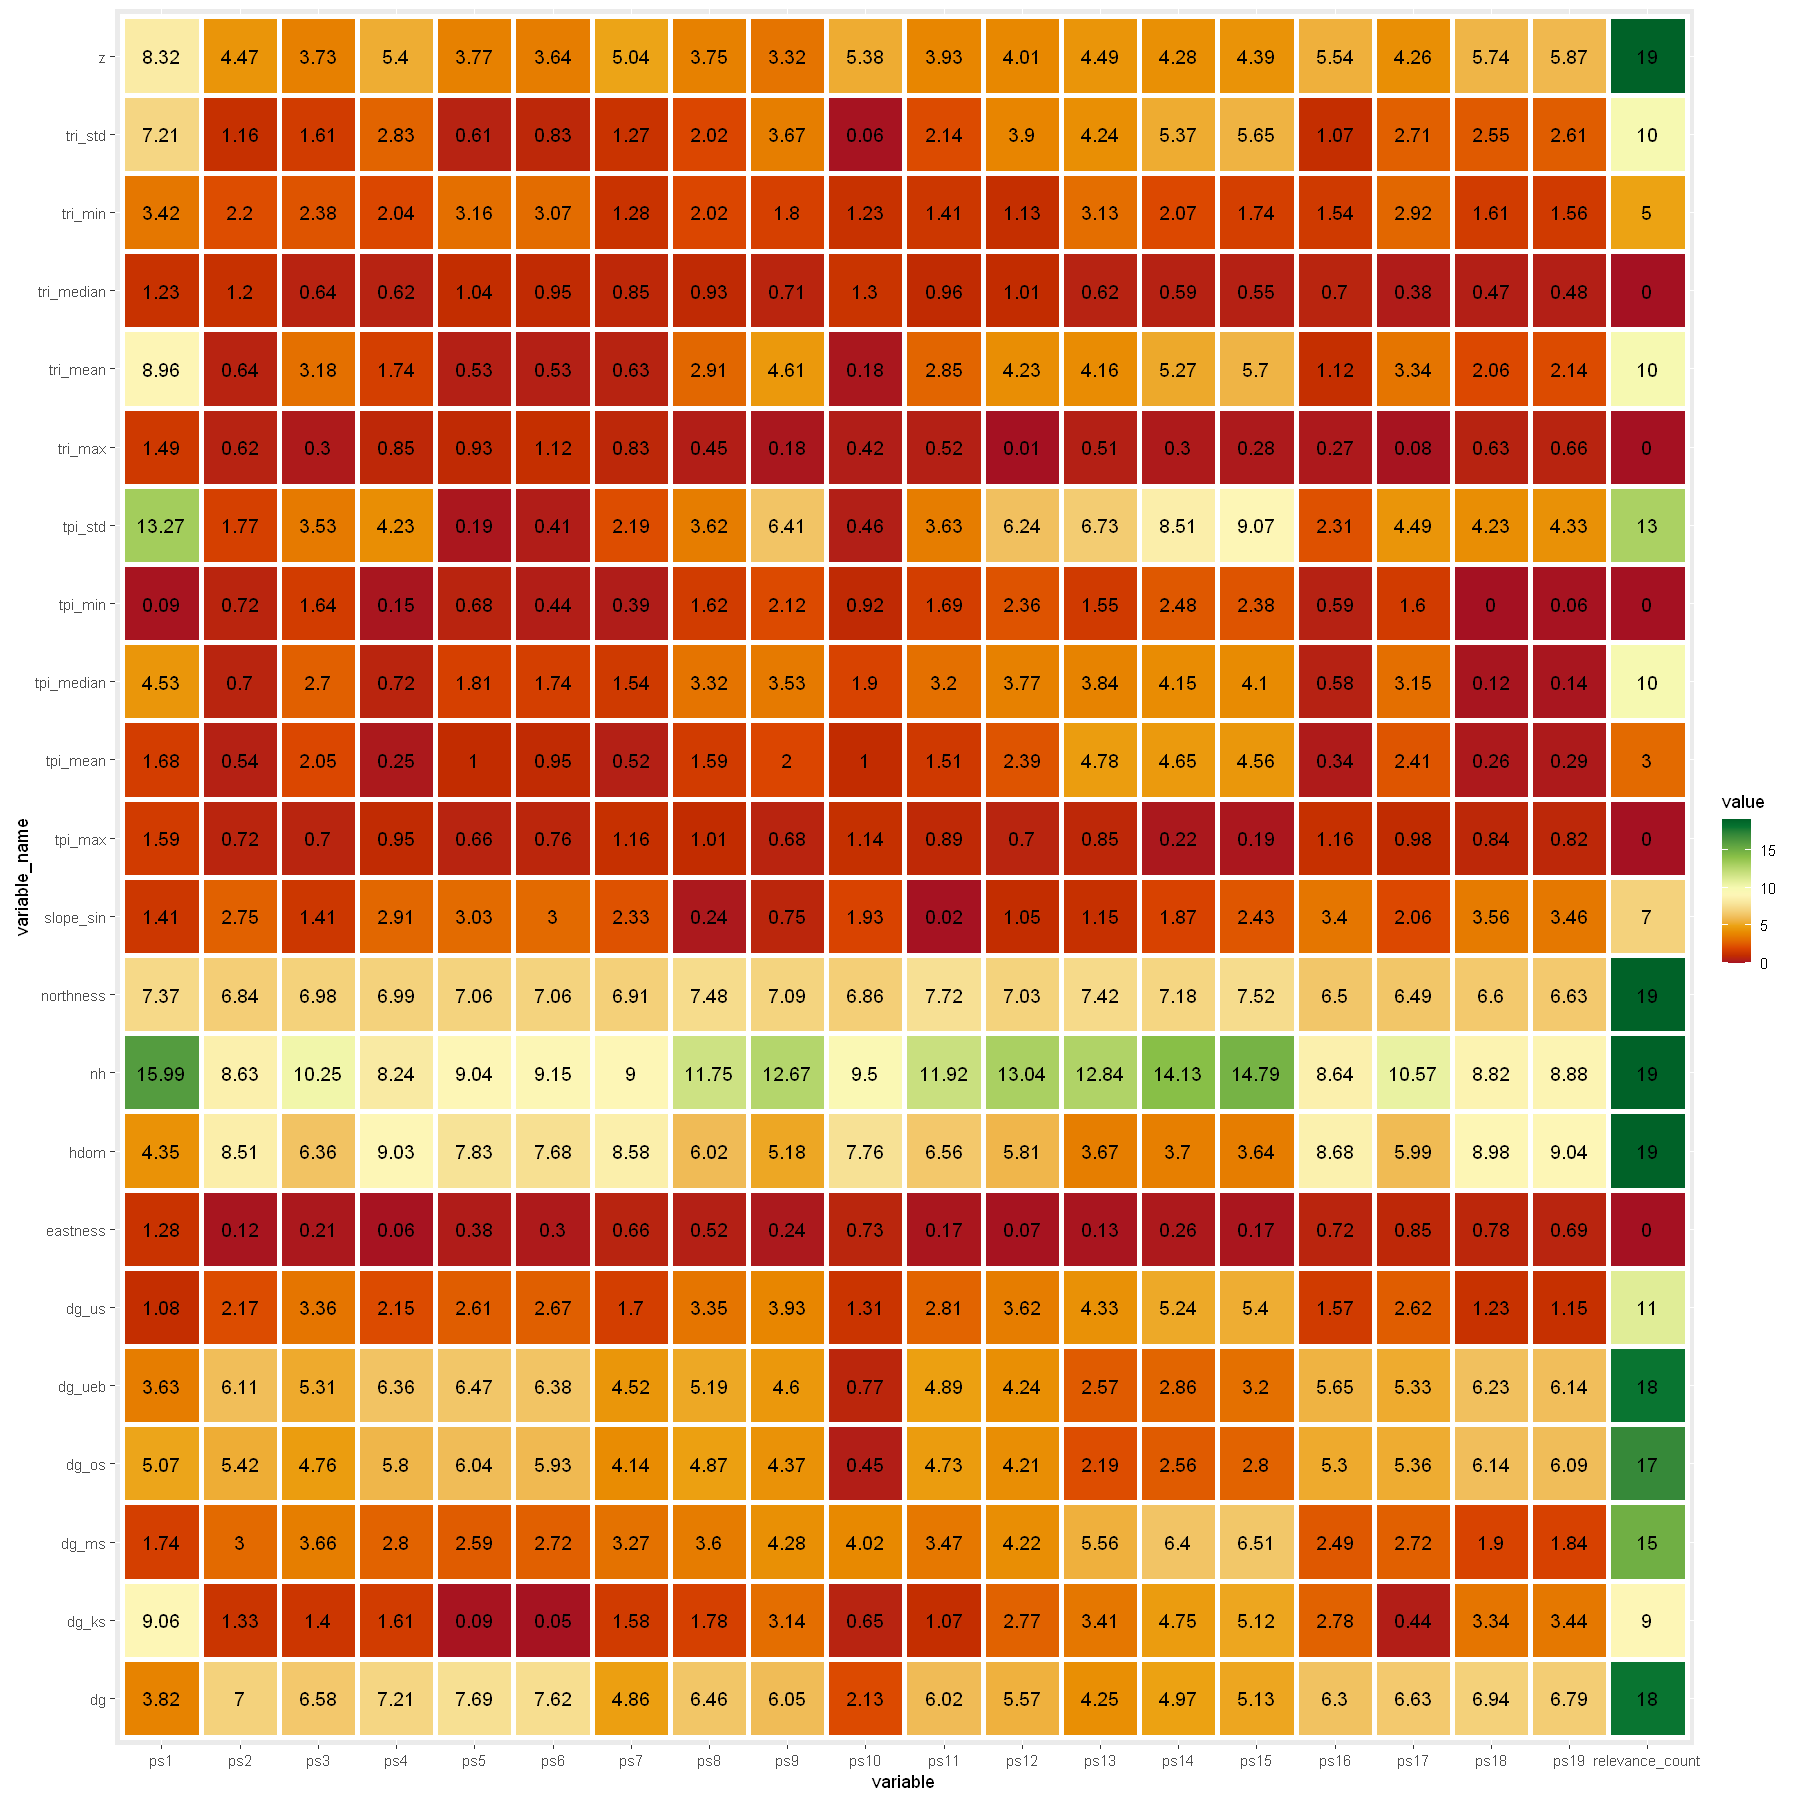

In [28]:
#Visualize the importance of the variables
options(repr.plot.width=15, repr.plot.height=15)
importance_matrix$variable_name <- rownames(importance_matrix)
importance_matrix_melt <- reshape2::melt(importance_matrix, id.vars="variable_name")
importance_matrix_melt$value <- round(importance_matrix_melt$value,2) 
ggplot(importance_matrix_melt, aes(x = variable, y = variable_name, fill = value)) +
  geom_tile(color = "white",
            lwd = 1.5,
            linetype = 1) +
  geom_text(aes(label = value), color = "black", size = 4) +
  scale_fill_gradientn(colors = hcl.colors(20, "RdYlGn")) +
  coord_fixed()

In [29]:
#Output the variables that are relevant for at least one filter 
count_threshold <- 0
rownames(importance_matrix[importance_matrix$relevance_count > count_threshold,])

[1] "slope_sin"  "northness"  "z"          "dg"         "hdom"      
 [6] "nh"         "dg_ks"      "dg_us"      "dg_ms"      "dg_os"     
[11] "dg_ueb"     "tri_min"    "tri_mean"   "tri_std"    "tpi_mean"  
[16] "tpi_median" "tpi_std"

## Generate Subsets and Calibration/Validation Partitions

In [30]:
# All plots
lfi_trees_grouped_full <- lfi_trees_grouped
partitions_all <- get_partitions("perimeter_id", data=lfi_trees_grouped_full)
lfi_trees_grouped_calibration <- lfi_trees_grouped_full[partitions_all$in_calibration,]
lfi_trees_grouped_validation <- lfi_trees_grouped_full[-partitions_all$in_calibration,]
print(c("nrow lfi_trees_grouped_full ",nrow(lfi_trees_grouped_full)))
print(c("nrow lfi_trees_grouped ",nrow(lfi_trees_grouped_calibration)))
print(c("nrow lfi_trees_grouped_validation ",nrow(lfi_trees_grouped_validation)))


# Without plots whose ALS date was acquired before 2010
lfi_trees_grouped_ss1_full <- lfi_trees_grouped_full[(lfi_trees_grouped_full$VHM_Tile_Year>=2010),]
partitions_ss1 <- get_partitions("perimeter_id", data=lfi_trees_grouped_ss1_full)
lfi_trees_grouped_ss1_calibration <- lfi_trees_grouped_ss1_full[partitions_ss1$in_calibration,]
lfi_trees_grouped_ss1_validation <- lfi_trees_grouped_ss1_full[-partitions_ss1$in_calibration,]
print(c("nrow lfi_trees_grouped_ss1_full ",nrow(lfi_trees_grouped_ss1_full)))
print(c("nrow lfi_trees_grouped_ss1 ",nrow(lfi_trees_grouped_ss1_calibration)))
print(c("nrow lfi_trees_grouped_ss1_validation ",nrow(lfi_trees_grouped_ss1_validation)))

      
# Only plots after 2010 and with a difference of less than 7 years between the ALS acquisition and the field acquisition
lfi_trees_grouped_ss2_full <- lfi_trees_grouped_full[(lfi_trees_grouped_full$VHM_Tile_Year>=2010) & (lfi_trees_grouped_full$acquisition_diff_abs<7),]
partitions_ss2 <- get_partitions("perimeter_id", data=lfi_trees_grouped_ss2_full)
lfi_trees_grouped_ss2_calibration <- lfi_trees_grouped_ss2_full[partitions_ss2$in_calibration,]
lfi_trees_grouped_ss2_validation <- lfi_trees_grouped_ss2_full[-partitions_ss2$in_calibration,]
print(c("nrow lfi_trees_grouped_ss2_full ",nrow(lfi_trees_grouped_ss2_full)))
print(c("nrow lfi_trees_grouped_ss2 ",nrow(lfi_trees_grouped_ss2_calibration)))
print(c("nrow lfi_trees_grouped_ss2_validation ",nrow(lfi_trees_grouped_ss2_validation)))


[1] "nrow lfi_trees_grouped_full " "5254"                        
[1] "nrow lfi_trees_grouped " "4206"                   
[1] "nrow lfi_trees_grouped_validation " "1048"                              
[1] "nrow lfi_trees_grouped_ss1_full " "3797"                            
[1] "nrow lfi_trees_grouped_ss1 " "3040"                       
[1] "nrow lfi_trees_grouped_ss1_validation "
[2] "757"                                   
[1] "nrow lfi_trees_grouped_ss2_full " "2676"                            
[1] "nrow lfi_trees_grouped_ss2 " "2144"                       
[1] "nrow lfi_trees_grouped_ss2_validation "
[2] "532"                                   


In [31]:
summary(lfi_trees_grouped_calibration$VHM_Tile_Year)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2001    2005    2018    2014    2019    2020 

In [32]:
summary(lfi_trees_grouped_validation$VHM_Tile_Year)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2001    2005    2017    2013    2019    2020 

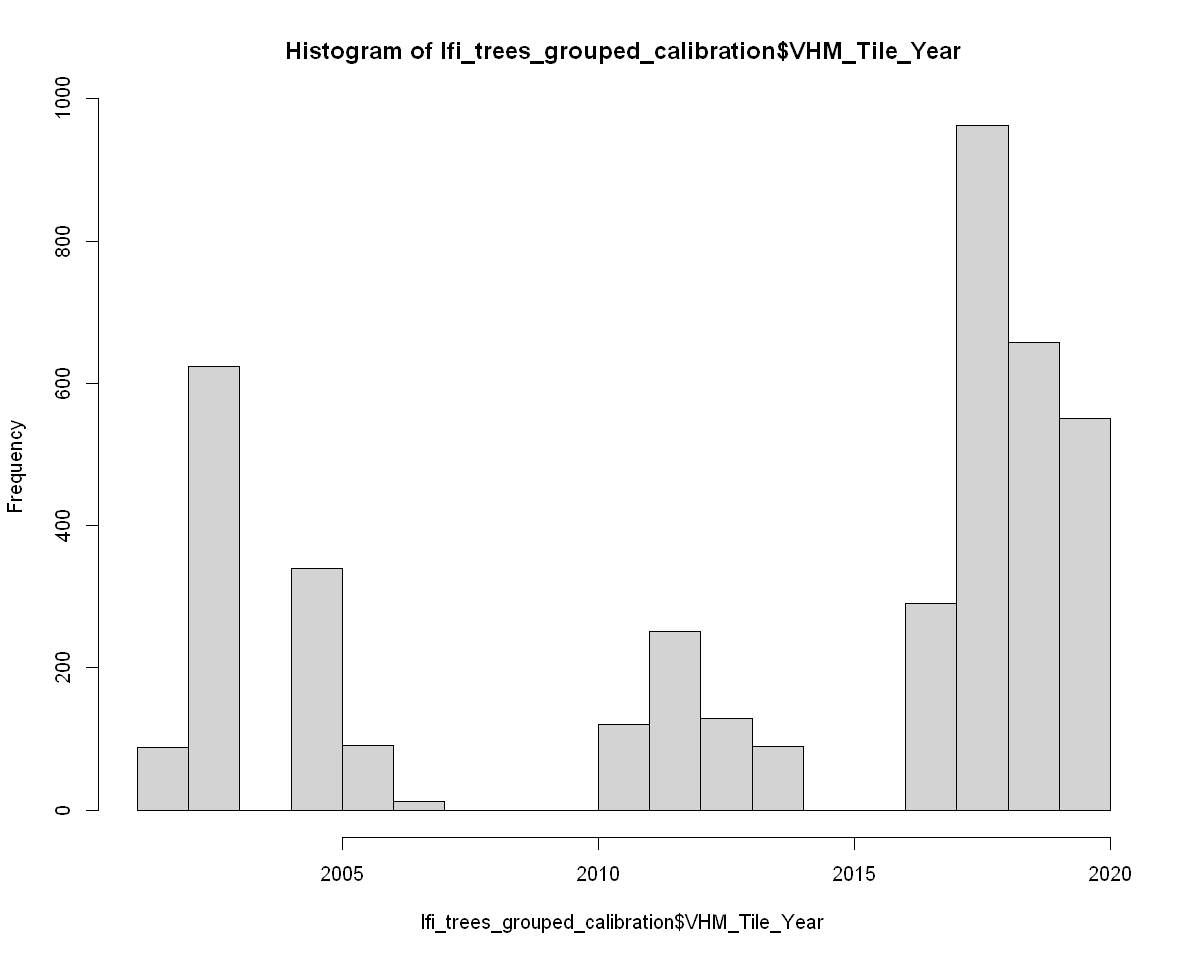

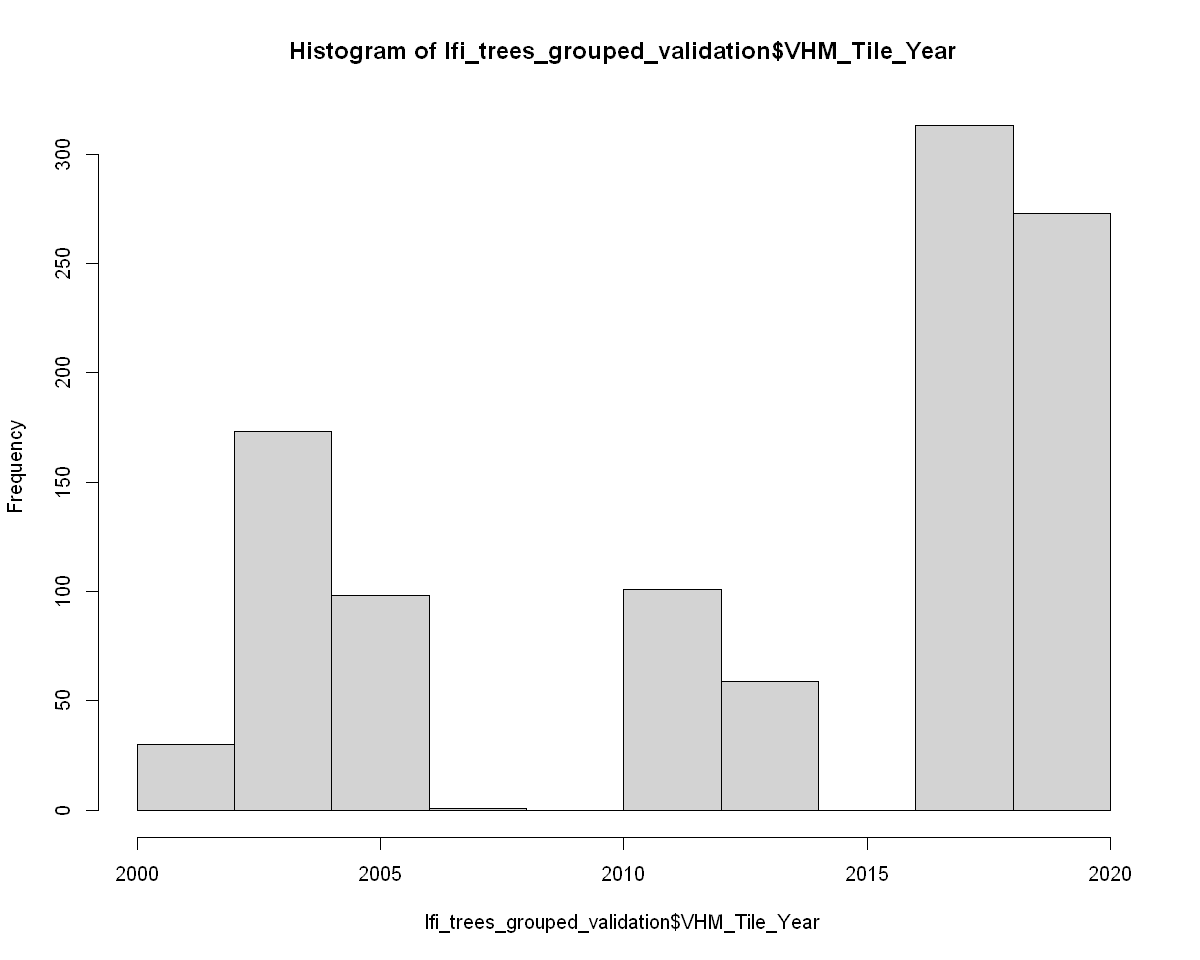

In [33]:
options(repr.plot.width=10, repr.plot.height=8)

hist(lfi_trees_grouped_calibration$VHM_Tile_Year)
hist(lfi_trees_grouped_validation$VHM_Tile_Year)

<a id="Composite_Model"></a>
## Composite Model

An attempt to integrate the composite model with caret failed. This is mostly due to the fact that handling multiply y values as input doesn't seem to be possible. Furthermore, the mox between regression and classification lite it is used here, seem also to be outside of caret's scope. Therefore two seperate methods fitting and predicting the model were created. The fitting method fintch.composite.fit() uses caret under the hood to fit a regression model for the specified classes and returns an object containing the trained models and necessary parameters for prediction. The fintch.composite.predict() method uses that fitted model object along with new input data to make the actual predictions.  

In [34]:
# Method for fitting a composite mode for the specified Date and filter methods
# x: data containing the explanatory data
# y: Data containing the error values to be used as target for the models. Must contain a column per filter method.
# targets: Vector with the numbers of the filter methods to be used in the model
# target_prefix: string prefix for the error measure to be used (e.g. "stems_in_plot_err_ps")
# cv: number of folds for training the individual error models
# method: method used to fit the error models (lm, leap, lasso, ridge, rf)
# direction: direction for leap method (forwart, backward, both)
# dynamic: whether to use stepAIC or a fixed formula for the method lm
# nvmax: max number of variables chosen by leap method
# mtry: mtry value for rf method
fintch.composite.fit <- function(x, y, targets, target_prefix, cv, method="lm", direction="forward",  dynamic=TRUE, nvmax=5, mtry=10) { 
    #Fit model per method/column in y
    models <- list()

    for(i in 1:length(targets)) {                        
        #Get taret name/method 
        target_name <-  targets[i]

        #Get corresponding column
        target_col <- paste(target_prefix, target_name, sep="")
        y_target <- y[target_col]
        
        x_calibration <- cbind(x,y_target)
        x_calibration <- x_calibration[!is.na(x_calibration[target_col]),]

        
        #Perform sequential feature selection on base learner
        control <- trainControl(method="repeatedcv", number=cv, repeats=3, allowParallel=TRUE)
        if (dynamic) {
            model_string <- paste(target_col,"~.",sep="")                                                
        } else {
             model_string <- paste(target_col,"~ slope_sin+northness+z+dg+hdom+nh+dg_ks+dg_us+dg_ms+dg_os+dg_ueb+tri_min+tri_mean+tri_std+tpi_mean+tpi_median+tpi_std",sep="")   
        }
        if (method=="lm") {
            if (dynamic) {
                modelFit <- train(formula(model_string), data = x_calibration, method = "lmStepAIC", trControl=control, direction = direction, trace = FALSE)
            } else {
                modelFit <- train(formula(model_string), data = x_calibration, method = "lm", trControl=control)
            }
        } else if (method=="leap") {
            if (direction=="forward"){
                mthd <-"leapForward"
            } else if (direction=="backward") {
                mthd<-"leapBackward"
            } else {
                mthd <- "leapSeq"
            }
            modelFit <- train(formula(model_string), data = x_calibration, method = mthd, trControl=control, tuneGrid = data.frame(nvmax = nvmax))
            # modelFit <- train(formula(model_string), data = x_calibration, method = method, trControl=control, tuneGrid = data.frame(nvmax = nvmax))
        } else if (method=="lasso") {
            modelFit<-train(formula(model_string), data = x_calibration, method = 'glmnet', tuneGrid = expand.grid(alpha = 1, lambda = 1), trControl=control) 
        } else if (method=="ridge") {
            modelFit<-train(formula(model_string), data = x_calibration, method = 'glmnet', tuneGrid = expand.grid(alpha = 0, lambda = 1), trControl=control)
        } else if (method=="rf") {
            control <- trainControl(method="none", number=1, allowParallel=TRUE)
            modelFit<-train(formula(model_string), data = x_calibration, method = 'rf', tuneGrid = expand.grid(.mtry = mtry), trControl=control)
        }     
            
        models[target_name] = list(modelFit)                        
    }

    ret <- list(models=models, target_names=targets)
    class(ret) <- "FINT_CH_CompositeModel"
    return(ret)                  
}

# Method for predicting the filter method based on a FINT_CH_CompositeModel model object
# generated by the fintch.composite.fit function.
# modelFit: FINT_CH_CompositeModel object
# newdata: data to be used for prediction
# return_raw: if TRUE, the method returns the predicted errors for all methods instead of the classes
fintch.composite.predict <- function(modelFit, newdata, return_raw=FALSE) {       
    models <- modelFit$models
    target_names <- modelFit$target_names

    predictions <- list()

    #Predict for all methods
    for(i in 1:length(target_names)) { 
        key <- target_names[i]
        clf <- models[key]
        pred <- predict(clf,newdata)
        predictions[key] <- pred
    }

    #Pick "optimal" method based on predictions

    pred_df <- as.data.frame(do.call("cbind",predictions))
    colnames(pred_df)<-target_names

    if(return_raw) {
        return(pred_df)
    }
        
    res <- apply(abs(pred_df), 1, which.min)

    ret <- colnames(pred_df)[res]
    return(ret)
}


Since caret can't be used for cross validation of the composite model, a custom function for that burpose has been created. The CV function is inspired both by caret and by sklearn. It uses a custom scoring function returning several scores for both the model itself as well as for the baseline 1m detection. Note, however, that the Earth Mover's Distance seems to be calculated slightly different so that the R values should not be directly compared with the Python values.

In [35]:
#Create empty dataframe matching the scorer output
make_scorer_df <- function (n_folds) 
{
    return(data.frame(rmse_baseline = rep(NA, n_folds), rmse_norm_baseline = rep(NA, n_folds), rmse = rep(NA, n_folds), rmse_norm = rep(NA, n_folds), 
                      
                      dr_baseline = rep(NA, n_folds),  dr = rep(NA, n_folds), 
                      r2 = rep(NA, n_folds), 
                      
                      mae_baseline = rep(NA, n_folds),  mae = rep(NA, n_folds), 
                      acc = rep(NA, n_folds), acc_adj = rep(NA, n_folds), acc_baseline_adj = rep(NA, n_folds), 
        y_pred_unique_count = rep(NA, n_folds)

                     ))
}

#Method for calculating a number of scores for the models in the CV functions
detection_scorer <- function(test_data, y, predicted_classes, input_classes=c(1,2,3,7,8,9,4,5,6,10,11,12,13,14,15,16,17,18,19))
{    
    
    #The 1m detection is regarded as baseline
    rmse_baseline <- sqrt(mean(unlist(test_data["stems_per_ha_rs_ps1"])))

    #The 1m detection is regarded as baseline
    mae_baseline <- mean(unlist(test_data["stems_per_ha_ae_ps1"]))

    
    ##Getting densities according to predicted method
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_per_ha_rs_ps",as.character(x),sep="")) 
    se<-sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )
    rmse <- sqrt(mean(se))
    
                                   
    #The 1m detection is regarded as baseline
    dr_baseline <- sqrt(mean(unlist(test_data["dr_ps1"])))

    ##Getting densities according to predicted method
    y_pred_ind <- lapply(predicted_classes, function(x) paste("dr_ps",as.character(x),sep="")) 
                         
    dr_raw <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )
    dr <- mean(dr_raw)

                             
    # Model accuracy
    acc <- mean(predicted_classes == y)
                                        
    label_df <- determine_min_labels(test_data, output_prefix="psx", input_classes=input_classes)
    y_pred_ind <- lapply(predicted_classes, function(x) paste("psx",as.character(x),sep="")) 
    se<-sapply(seq_along(y_pred_ind), function(x) label_df[x, y_pred_ind[[x]]] )
    acc_adj <- sum(se)/length(se)    
               
    se_baseline <- label_df[,"psx1"]
    acc_baseline_adj <- sum(se_baseline)/length(se_baseline) 
                        
    #Normalized RMSE
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_in_plot_err_norm_ps",as.character(x),sep="")) 
    stems_per_ha <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
    rmse_norm <- sqrt(mean(stems_per_ha^2,na.rm=TRUE))
    
    norm_error_baseline <- test_data[,"stems_in_plot_err_norm_ps1"]
    rmse_norm_baseline <- sqrt(mean(norm_error_baseline^2,na.rm=TRUE))          

                        
          
    #MAE
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_in_plot_ae_ps",as.character(x),sep="")) 
    stems_per_ha_ae <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
    mae <- mean(stems_per_ha_ae,na.rm=TRUE)
                           
                           
    #R2
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_per_ha_rs_ps",as.character(x),sep="")) 
    se<-sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )
    r2_score <- R2(test_data$density_actual, se)
                              
    #predicted class count
    y_pred_unique_count <- length(unique(predicted_classes))
                             
    return(list(rmse_baseline=rmse_baseline,
        rmse_norm_baseline = rmse_norm_baseline,
        rmse=rmse,
        rmse_norm = rmse_norm,
      
        dr_baseline=dr_baseline,
        dr=dr,
        r2=r2_score,
                
        mae_baseline = mae_baseline,
        mae = mae,
        acc=acc,
        acc_adj=acc_adj,
        acc_baseline_adj=acc_baseline_adj,
        y_pred_unique_count=y_pred_unique_count
      )
    )
}

#Method for collecting raw data for more detailed scoring calculations the models in the CV functions
scoring_data_collector <- function(test_data, y, predicted_classes, input_classes=c(1,2,3,7,8,9,4,5,6,10,11,12,13,14,15,16,17,18,19))
{   
    #General values
    data_raw <- test_data[,c("flaeche_id","dg","nh","hdom","fst_dg","fst_nh","fst_hdom","density_actual","density_actual_all","nbr_trees", "nbr_trees_os")]
    
    #Values for baseline detection
    data_raw$stems_per_ha_baseline <- test_data$stems_per_ha_ps1
    data_raw$dr_baseline <- test_data$dr_ps1
    data_raw$stems_per_ha_rs_baseline <- test_data$stems_per_ha_rs_ps1
    data_raw$predicted <- predicted_classes
    
    label_df <- determine_min_labels(test_data, output_prefix="psx", input_classes=input_classes)
    data_raw$prediction_accurate_baseline <- label_df[,"psx1"]
    data_raw$stems_in_plot_err_norm_baseline <-  test_data$stems_in_plot_err_norm_ps1
    data_raw$stems_in_plot_abs_err_baseline <-  test_data$stems_in_plot_ae_ps1
    data_raw$stems_in_plot_err_baseline <- test_data$stems_in_plot_err_ps1
    data_raw$stems_per_ha_err_baseline <- test_data$stems_per_ha_err_ps1
    data_raw$stems_per_ha_abs_err_baseline <- test_data$stems_per_ha_ae_ps1
    data_raw$stems_per_ha_abs_err_norm_baseline <- test_data$stems_per_ha_ae_ps1/test_data$density_actual
    
    data_raw$stems_in_plot_baseline = test_data$stems_in_plot_ps1
    
    #Values model
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_per_ha_rs_ps",as.character(x),sep="")) 
    se_raw<-sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )
    data_raw$stems_per_ha_rs_model <- se_raw
                                   
    y_pred_ind <- lapply(predicted_classes, function(x) paste("dr_ps",as.character(x),sep=""))                  
    dr_raw <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )
    data_raw$dr_model <- dr_raw    
               
    y_pred_ind <- lapply(predicted_classes, function(x) paste("psx",as.character(x),sep="")) 
    se<-sapply(seq_along(y_pred_ind), function(x) label_df[x, y_pred_ind[[x]]] )   
    data_raw$prediction_accurate_model <- se
               
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_in_plot_err_norm_ps",as.character(x),sep="")) 
    stems_per_ha_err_norm <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
    data_raw$stems_in_plot_err_norm_model <- stems_per_ha_err_norm
                           
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_per_ha_ps",as.character(x),sep="")) 
    stems_per_ha <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
    data_raw$stems_per_ha_model <- stems_per_ha
           
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_in_plot_ae_ps",as.character(x),sep="")) 
    stems_per_ae <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
    data_raw$stems_in_plot_abs_err_model <- stems_per_ae

    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_per_ha_ae_ps",as.character(x),sep="")) 
    stems_per_ha_ae <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
    data_raw$stems_per_ha_abs_err_model <- stems_per_ha_ae                               

    data_raw$stems_per_ha_abs_err_norm_model <- stems_per_ha_ae/test_data$density_actual                            

    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_per_ha_err_ps",as.character(x),sep="")) 
    stems_per_ha_err <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
    data_raw$stems_per_ha_err_model <- stems_per_ha_err                               
    
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_in_plot_err_ps",as.character(x),sep="")) 
    stems_in_plot_err <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
    data_raw$stems_in_plot_err_model <- stems_in_plot_err                               
    
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_in_plot_ps",as.character(x),sep="")) 
    stems_in_plot_model <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
    data_raw$stems_in_plot_model <- stems_in_plot_model                               


                                  
    return(
        list(data_raw)
    )
}

In [36]:
# Function to returning scores based on the detection_scorer for a data set and a single trained composite model. 
fintch_composite_score <- function(model, scoring_in, detection_column_index = NA, y_column="parameterset_min") {
         
    #Predict and score model
    if(is.na(detection_column_index)){
        prediction <- fintch.composite.predict(modelFit=model,newdata=scoring_in)
        classes = model$target_names
    } else {
        prediction <- rep(detection_column_index, nrow(scoring_in))
        classes = c(1,detection_column_index)
    }
    
    y <- scoring_in[,y_column]

    scores <- detection_scorer(scoring_in, y, prediction,input_classes=classes)        
    scoring_data <- scoring_data_collector(scoring_in, y, prediction, input_classes=classes)


    return(list(scores=scores, scoring_data=scoring_data))
}



# Function to returning scores based on the detection_scorer for a data set and multiple trained composite model. 
fintch_composite_score_multi <- function(models, scoring_in, detection_column_index = NA, y_column="parameterset_min") {
    
    n_fold <- nrow(models)
    
    #Create empty df with structure for scoring function
    scores <- make_scorer_df(n_fold)
    scoring_data <- rep(NA, n_fold)
                     
    #Fit and score model for wach fold
    for (i in 1:n_fold) {
        model_comp_dyn <- models[i,]
                        
        #Predict and score model
        tmp_scores <- fintch_composite_score(model_comp_dyn, scoring_in, detection_column_index=detection_column_index, y_column=y_column)  
        
        scores[i,] <- tmp_scores$scores     
        scoring_data[i] <- tmp_scores$scoring_data

    }
    return(list(scores=scores, scoring_data=scoring_data))
}



In [37]:
#Helper functions for handling scoring results during analysis
concat_scoring_data <- function(df,col) { return(do.call(rbind,lapply(df, function(l) l[col]))) }
concat_scoring_data_group <- function(df,col,group,group_value) { return(do.call(rbind,lapply(df, function(l) l[l[,group]==group_value,][col]))) } 
concat_scoring_data_group_all <- function(df,group,group_value) { return(do.call(rbind,lapply(df, function(l) l[l[,group]==group_value,]))) } 
concat_scoring_data_by_fold <- function(df_calibration,df_validation,col,SEL) {
    n_fold <- length(df_calibration)
    res <- rep(NA,n_fold)
    for(i in 1:n_fold) {
        res[i] <- list(rbind(df_calibration[[i]][SEL(df_calibration[[i]]),][col],df_validation[[i]][SEL(df_validation[[i]]),][col]))
    }
    
    return(res)
}
                                                                                              
concat_scoring_data_simple <- function(df) {return(do.call(rbind,lapply(df, function(l) l)))}
                                                                                              
select_by_group <- function(df,group,group_value) {return(df[,group]==group_value)} 

                                                                               

In [38]:
# Function for scoring a dataframe that encompasses the indicators needed for the publication
detection_scorer_raw <- function(df,group_label,model_column_suffix="model")
{   
    rmse_baseline <- sqrt(mean(df$stems_per_ha_rs_baseline))
    rmse <- sqrt(mean(df[,paste0("stems_per_ha_rs_",model_column_suffix)]))
    
    sd_err_baseline <- sd(df$stems_per_ha_err_baseline)
    sd_err <- sd(df[,paste0("stems_per_ha_err_",model_column_suffix)])
    
    rmse_norm_baseline <- sqrt(mean(df$stems_in_plot_err_norm_baseline^2,na.rm=TRUE))
    rmse_norm <- sqrt(mean(df[,paste0("stems_in_plot_err_norm_",model_column_suffix)]^2,na.rm=TRUE))
            
    sd_err_norm_baseline <- sd(df$stems_in_plot_err_norm_baseline)
    sd_err_norm <- sd(df[,paste0("stems_in_plot_err_norm_",model_column_suffix)])
    
    mae_plot_baseline <- mean(df$stems_in_plot_abs_err_baseline,na.rm=TRUE)
    mae_plot_model <- mean(df[,paste0("stems_in_plot_abs_err_",model_column_suffix)],na.rm=TRUE)
        
    mae_density_baseline <- mean(df$stems_per_ha_abs_err_baseline,na.rm=TRUE)
    mae_density_model <- mean(df[,paste0("stems_per_ha_abs_err_",model_column_suffix)],na.rm=TRUE)
    
    mae_norm_density_baseline <- mean(df$stems_per_ha_abs_err_norm_baseline,na.rm=TRUE)
    mae_norm_density_model <- mean(df[,paste0("stems_per_ha_abs_err_norm_",model_column_suffix)],na.rm=TRUE)

    median_ae_norm_density_baseline <- median(df$stems_per_ha_abs_err_norm_baseline,na.rm=TRUE)
    median_ae_norm_density_model <- median(df[,paste0("stems_per_ha_abs_err_norm_",model_column_suffix)],na.rm=TRUE)

    mean_err_baseline <- mean(df$stems_per_ha_err_baseline,na.rm=TRUE)
    mean_err_model <- mean(df[,paste0("stems_per_ha_err_",model_column_suffix)],na.rm=TRUE)

    median_err_baseline <- median(df$stems_per_ha_err_baseline,na.rm=TRUE)
    median_err_model <- median(df[,paste0("stems_per_ha_err_",model_column_suffix)],na.rm=TRUE)
 
    dr_mean_baseline <- mean(df$dr_baseline)
    dr_median_baseline <- median(df$dr_baseline)
    
    dr_mean_model <- mean(df[,paste0("dr_",model_column_suffix)])
    dr_median_model <- median(df[,paste0("dr_",model_column_suffix)])

    r2_model <- R2(as.numeric(df$density_actual),as.numeric(df[,paste0("stems_per_ha_",model_column_suffix)]))
    r2_baseline <- R2(as.numeric(df$density_actual),as.numeric(df$stems_per_ha_baseline))

    bias_model <- bias(as.numeric(df$density_actual),as.numeric(df[,paste0("stems_per_ha_",model_column_suffix)]))
    bias_baseline <- bias(as.numeric(df$density_actual),as.numeric(df$stems_per_ha_baseline))
    
    acc_adjusted_baseline <- sum(df$prediction_accurate_baseline)/length(df$prediction_accurate_baseline)
    acc_adjusted_model <- sum(df[,paste0("prediction_accurate_",model_column_suffix)])/length(df[,paste0("prediction_accurate_",model_column_suffix)])
    
    cnt <- nrow(df)
  
    return ( data.frame(group=group_label, rmse=rmse, rmse_norm=rmse_norm, mae_plot_model=mae_plot_model, mae_density_model=mae_density_model, 
                        mae_norm_density_model=mae_norm_density_model, median_ae_norm_density_model=median_ae_norm_density_model, 
                        mean_err_model=mean_err_model, median_err_model=median_err_model,sd_err=sd_err, sd_err_norm=sd_err_norm,  dr_mean_model=dr_mean_model, dr_median_model=dr_median_model,
                        r2_model=r2_model, bias_model=bias_model,
                        acc_adjusted_model=acc_adjusted_model,
                        rmse_baseline=rmse_baseline, rmse_norm_baseline=rmse_norm_baseline, mae_plot_baseline=mae_plot_baseline, mae_density_baseline=mae_density_baseline, 
                        mae_norm_density_baseline=mae_norm_density_baseline, median_ae_norm_density_baseline=median_ae_norm_density_baseline, 
                        mean_err_baseline=mean_err_baseline, median_err_baseline=median_err_baseline, sd_err_baseline=sd_err_baseline, sd_err_norm_baseline=sd_err_norm_baseline, dr_mean_baseline=dr_mean_baseline, dr_median_baseline=dr_median_baseline,
                                                r2_baseline=r2_baseline, bias_baseline=bias_baseline, acc_adjusted_baseline=acc_adjusted_baseline,
                        
                        count = cnt))  
}

# Function for scoring a dataframe based on several different groupings an criteria
score_individual_df <- function(cv_result, scoring_df, group_label, model_column_suffix="model", partition_label = "all") {
    res <- NA
    
    all_model_label <- "All Models"
    mae_best_model_label <- "MAE Best Model"
    
    # All results
    all_plots_group_label <- "a) All plots"
    df_validation <- concat_scoring_data_simple(scoring_df)
    res <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "), model_column_suffix=model_column_suffix)
    res$model <- all_model_label
    res$subgroup <- all_plots_group_label
        
    # MAE best
    best_mae <- which.min(cv_result$scores$mae)
    df_validation <- scoring_df[[best_mae]]
    scr_tmp <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "), model_column_suffix=model_column_suffix)
    scr_tmp$model <- mae_best_model_label
    scr_tmp$subgroup <- all_plots_group_label
    res <- rbind(res,scr_tmp)
    
    #By NH
    nh_group_labels <- nh_lookup_labels$val
    for (i in 1:3) {
        group <- "fst_nh"
        # All results
        df_validation <- concat_scoring_data_group_all(scoring_df,group,i)        
        scr_tmp <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "), model_column_suffix=model_column_suffix)
        scr_tmp$model <- all_model_label
        scr_tmp$subgroup <- nh_group_labels[i]        
        res <- rbind(res,scr_tmp)

        # MAE best
        best_mae <- which.min(cv_result$scores$mae)
        df_validation <- concat_scoring_data_group_all(scoring_df[best_mae],group,i) 
        scr_tmp <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "), model_column_suffix=model_column_suffix)
        scr_tmp$model <- mae_best_model_label
        scr_tmp$subgroup <- nh_group_labels[i]
        res <- rbind(res,scr_tmp)
    }
    
    #By DG
    dg_group_labels <- dg_lookup_labels$val
    for (i in 1:2) {
        group <- "fst_dg"
        # All results
        df_validation <- concat_scoring_data_group_all(scoring_df,group,i)
        scr_tmp <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "), model_column_suffix=model_column_suffix)
        scr_tmp$model <- all_model_label
        scr_tmp$subgroup <- dg_group_labels[i]
        res <- rbind(res,scr_tmp)
        
        # MAE best
        best_mae <- which.min(cv_result$scores$mae)
        df_validation <- concat_scoring_data_group_all(scoring_df[best_mae],group,i) 
        scr_tmp <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "), model_column_suffix=model_column_suffix)
        scr_tmp$model <- mae_best_model_label
        scr_tmp$subgroup <- dg_group_labels[i]
        res <- rbind(res,scr_tmp)
    }
    
    #By HDOM
    hdom_group_labels <- hdom_lookup_labels$val
    for (i in 1:2) {
        group <- "fst_hdom"
        # All results
        df_validation <- concat_scoring_data_group_all(scoring_df,group,i)
        scr_tmp <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "), model_column_suffix=model_column_suffix)
        scr_tmp$model <- all_model_label
        scr_tmp$subgroup <- hdom_group_labels[i]
        res <- rbind(res,scr_tmp)
        
        # MAE best
        best_mae <- which.min(cv_result$scores$mae)
        df_validation <- concat_scoring_data_group_all(scoring_df[best_mae],group,i) 
        scr_tmp <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "), model_column_suffix=model_column_suffix)
        scr_tmp$model <- mae_best_model_label
        scr_tmp$subgroup <- hdom_group_labels[i]
        res <- rbind(res,scr_tmp)
        
    }
    
    
    res$group <- group_label
    res$partition <- partition_label
    return(res)
}

#Function for formatting specific indicators in a way suitable for the publication
score_df_pub <- function(cv_result, df, label, model_column_suffix="model", subgroup_label = "all", filter=FALSE, cols= NULL) {
    res <- score_individual_df(cv_result, df, label, subgroup_label, model_column_suffix=model_column_suffix)
    
    if(filter) {
        res <- res[grepl( "MAE ", res$group, fixed = TRUE) & grepl( paste(subgroup_label,";", sep=" "), res$group, fixed = TRUE) ,]
    }
    
    res$rmse <- round(res$rmse)
    res$rmse_norm <- round(res$rmse_norm,1)
    res$mae_density_model <- round(res$mae_density_model)
    res$mae_norm_density_model <- round(res$mae_norm_density_model,2)
    res$median_ae_norm_density_model <- round(res$median_ae_norm_density_model,2)    
    res$mae_plot_model <- round(res$mae_plot_model)
    res$mean_err_model <- round(res$mean_err_model,2)
    res$median_err_model <- round(res$median_err_model,2)
    res$dr_mean_model <- round(res$dr_mean_model,2)
    res$dr_median_model <- round(res$dr_median_model,2)
    res$r2_model <- round(res$r2_model,4)
    res$bias_model <- round(res$bias_model,4)
    res$acc_adjusted_model <- round(100*res$acc_adjusted_model)

    res$rmse_baseline <- round(res$rmse_baseline)
    res$rmse_norm_baseline <- round(res$rmse_norm_baseline,1)
    res$mae_density_baseline <- round(res$mae_density_baseline)
    res$mae_plot_baseline <- round(res$mae_plot_baseline)
    res$mae_norm_density_baseline <- round(res$mae_norm_density_baseline,2)
    res$median_ae_norm_density_baseline <- round(res$median_ae_norm_density_baseline,2)
    res$mean_err_baseline <- round(res$mean_err_baseline,2)
    res$median_err_baseline <- round(res$median_err_baseline,2)
    res$dr_mean_baseline <- round(res$dr_mean_baseline,2)
    res$dr_median_baseline <- round(res$dr_median_baseline,2)
    res$r2_baseline <- round(res$r2_baseline,4)
    res$bias_baseline <- round(res$bias_baseline,4)
    res$acc_adjusted_baseline <- round(100*res$acc_adjusted_baseline)
    
    if (!is.null(cols)){
        res <- res[,cols]
    }
        
    return(res)
}

#Function for structuring the scoring results in a way that is easily transferred to the publication 
structure_pub_table <- function(score_df, filter_model = NULL, filter_group = NULL, filter_subgroup = NULL, filter_partition = NULL) {
    score_cols_model <- c("group", "subgroup", "partition", "count", "model", "mae_density_model", "median_ae_norm_density_model", "dr_mean_model", "dr_median_model")
    score_cols_baseline <- c("group", "subgroup", "partition", "count", "model", "mae_density_baseline",  "median_ae_norm_density_baseline",  "dr_mean_baseline", "dr_median_baseline")

    score_cols_modified <- c("Grouping", "Group", "Partition", "n_plots", "Model", "MAE_N", "MedAE_norm",  "dr_mean", "dr_median")
    score_cols_output <- c("Grouping", "Partition", "Group", "n_plots", "Source", "MAE_N", "MedAE_norm",  "dr_mean", "dr_median")

    #Correct the count for lines with results from all 10 CV models 
    score_df[score_df$model=="All Models",]$count <- score_df[score_df$model=="All Models",]$count/10

    #Model results
    score_df_model <- score_df[,score_cols_model]
    names(score_df_model) <- score_cols_modified
    score_df_model$Source <- "Model"
    #Baseline results
    score_df_baseline <- score_df[,score_cols_baseline]
    names(score_df_baseline) <- score_cols_modified
    score_df_baseline$Source <- "Baseline"

    #Concatenate model and baseline resulta
    res <- rbind(score_df_model,score_df_baseline)
    if (!is.null(filter_group)){
        res <- res[res$Grouping==filter_group,]
    }
    if (!is.null(filter_subgroup)){
        res <- res[res$Group==filter_subgroup,]
    }
    if (!is.null(filter_model)){
        res <- res[res$Model==filter_model,]
    }
    if (!is.null(filter_partition)){
        res <- res[res$Partition==filter_partition,]
    }
    
    return(res[order(res$Grouping,res$Group),score_cols_output])
}



In [39]:
# Function for scoring a dataframe that encompasses the indicators needed for the publication
detection_scorer_raw <- function(df,group_label)
{   
    rmse_baseline <- sqrt(mean(df$stems_per_ha_rs_baseline))
    rmse <- sqrt(mean(df$stems_per_ha_rs_model))
    
    sd_err_baseline <- sd(df$stems_per_ha_err_baseline)
    sd_err <- sd(df$stems_per_ha_err_model)
    
    rmse_norm_baseline <- sqrt(mean(df$stems_in_plot_err_norm_baseline^2,na.rm=TRUE))
    rmse_norm <- sqrt(mean(df$stems_in_plot_err_norm_model^2,na.rm=TRUE))
            
    sd_err_norm_baseline <- sd(df$stems_in_plot_err_norm_baseline)
    sd_err_norm <- sd(df$stems_in_plot_err_norm_model)
    
    mae_plot_baseline <- mean(df$stems_in_plot_abs_err_baseline,na.rm=TRUE)
    mae_plot_model <- mean(df$stems_in_plot_abs_err_model,na.rm=TRUE)
        
    mae_density_baseline <- mean(df$stems_per_ha_abs_err_baseline,na.rm=TRUE)
    mae_density_model <- mean(df$stems_per_ha_abs_err_model,na.rm=TRUE)
    
    mae_norm_density_baseline <- mean(df$stems_per_ha_abs_err_norm_baseline,na.rm=TRUE)
    mae_norm_density_model <- mean(df$stems_per_ha_abs_err_norm_model,na.rm=TRUE)

    median_ae_norm_density_baseline <- median(df$stems_per_ha_abs_err_norm_baseline,na.rm=TRUE)
    median_ae_norm_density_model <- median(df$stems_per_ha_abs_err_norm_model,na.rm=TRUE)

    mean_err_baseline <- mean(df$stems_per_ha_err_baseline,na.rm=TRUE)
    mean_err_model <- mean(df$stems_per_ha_err_model,na.rm=TRUE)

    median_err_baseline <- median(df$stems_per_ha_err_baseline,na.rm=TRUE)
    median_err_model <- median(df$stems_per_ha_err_model,na.rm=TRUE)
 
    dr_mean_baseline <- mean(df$dr_baseline)
    dr_median_baseline <- median(df$dr_baseline)
    
    dr_mean_model <- mean(df$dr_model)
    dr_median_model <- median(df$dr_model)

    r2_model <- R2(as.numeric(df$density_actual),as.numeric(df$stems_per_ha_model))
    r2_baseline <- R2(as.numeric(df$density_actual),as.numeric(df$stems_per_ha_baseline))

    bias_model <- bias(as.numeric(df$density_actual),as.numeric(df$stems_per_ha_model))
    bias_baseline <- bias(as.numeric(df$density_actual),as.numeric(df$stems_per_ha_baseline))
    
    acc_adjusted_baseline <- sum(df$prediction_accurate_baseline)/length(df$prediction_accurate_baseline)
    acc_adjusted_model <- sum(df$prediction_accurate_model)/length(df$prediction_accurate_model)
    
    cnt <- nrow(df)
  
    return ( data.frame(group=group_label, rmse=rmse, rmse_norm=rmse_norm, mae_plot_model=mae_plot_model, mae_density_model=mae_density_model, 
                        mae_norm_density_model=mae_norm_density_model, median_ae_norm_density_model=median_ae_norm_density_model, 
                        mean_err_model=mean_err_model, median_err_model=median_err_model,sd_err=sd_err, sd_err_norm=sd_err_norm,  dr_mean_model=dr_mean_model, dr_median_model=dr_median_model,
                        r2_model=r2_model, bias_model=bias_model,
                        acc_adjusted_model=acc_adjusted_model,
                        rmse_baseline=rmse_baseline, rmse_norm_baseline=rmse_norm_baseline, mae_plot_baseline=mae_plot_baseline, mae_density_baseline=mae_density_baseline, 
                        mae_norm_density_baseline=mae_norm_density_baseline, median_ae_norm_density_baseline=median_ae_norm_density_baseline, 
                        mean_err_baseline=mean_err_baseline, median_err_baseline=median_err_baseline, sd_err_baseline=sd_err_baseline, sd_err_norm_baseline=sd_err_norm_baseline, dr_mean_baseline=dr_mean_baseline, dr_median_baseline=dr_median_baseline,
                                                r2_baseline=r2_baseline, bias_baseline=bias_baseline, acc_adjusted_baseline=acc_adjusted_baseline,
                        
                        count = cnt))  
}

# Function for scoring a dataframe based on several different groupings an criteria
score_individual_df <- function(cv_result, scoring_df, group_label, partition_label = "all") {
    res <- NA
    
    all_model_label <- "All Models"
    mae_best_model_label <- "MAE Best Model"
    
    # All results
    all_plots_group_label <- "a) All plots"
    df_validation <- concat_scoring_data_simple(scoring_df)
    res <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "))
    res$model <- all_model_label
    res$subgroup <- all_plots_group_label
        
    # MAE best
    best_mae <- which.min(cv_result$scores$mae)
    df_validation <- scoring_df[[best_mae]]
    scr_tmp <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "))
    scr_tmp$model <- mae_best_model_label
    scr_tmp$subgroup <- all_plots_group_label
    res <- rbind(res,scr_tmp)
    
    #By NH
    nh_group_labels <- nh_lookup_labels$val
    for (i in 1:3) {
        group <- "fst_nh"
        # All results
        df_validation <- concat_scoring_data_group_all(scoring_df,group,i)        
        scr_tmp <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "))
        scr_tmp$model <- all_model_label
        scr_tmp$subgroup <- nh_group_labels[i]        
        res <- rbind(res,scr_tmp)

        # MAE best
        best_mae <- which.min(cv_result$scores$mae)
        df_validation <- concat_scoring_data_group_all(scoring_df[best_mae],group,i) 
        scr_tmp <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "))
        scr_tmp$model <- mae_best_model_label
        scr_tmp$subgroup <- nh_group_labels[i]
        res <- rbind(res,scr_tmp)
    }
    
    #By DG
    dg_group_labels <- dg_lookup_labels$val
    for (i in 1:2) {
        group <- "fst_dg"
        # All results
        df_validation <- concat_scoring_data_group_all(scoring_df,group,i)
        scr_tmp <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "))
        scr_tmp$model <- all_model_label
        scr_tmp$subgroup <- dg_group_labels[i]
        res <- rbind(res,scr_tmp)
        
        # MAE best
        best_mae <- which.min(cv_result$scores$mae)
        df_validation <- concat_scoring_data_group_all(scoring_df[best_mae],group,i) 
        scr_tmp <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "))
        scr_tmp$model <- mae_best_model_label
        scr_tmp$subgroup <- dg_group_labels[i]
        res <- rbind(res,scr_tmp)
    }
    
    #By HDOM
    hdom_group_labels <- hdom_lookup_labels$val
    for (i in 1:2) {
        group <- "fst_hdom"
        # All results
        df_validation <- concat_scoring_data_group_all(scoring_df,group,i)
        scr_tmp <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "))
        scr_tmp$model <- all_model_label
        scr_tmp$subgroup <- hdom_group_labels[i]
        res <- rbind(res,scr_tmp)
        
        # MAE best
        best_mae <- which.min(cv_result$scores$mae)
        df_validation <- concat_scoring_data_group_all(scoring_df[best_mae],group,i) 
        scr_tmp <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "))
        scr_tmp$model <- mae_best_model_label
        scr_tmp$subgroup <- hdom_group_labels[i]
        res <- rbind(res,scr_tmp)
        
    }
    
    
    res$group <- group_label
    res$partition <- partition_label
    return(res)
}

#Function for formatting specific indicators in a way suitable for the publication
score_df_pub <- function(cv_result, df, label, subgroup_label = "all", filter=FALSE, cols= NULL) {
    res <- score_individual_df(cv_result, df, label, subgroup_label)
    
    if(filter) {
        res <- res[grepl( "MAE ", res$group, fixed = TRUE) & grepl( paste(subgroup_label,";", sep=" "), res$group, fixed = TRUE) ,]
    }
    
    res$rmse <- round(res$rmse)
    res$rmse_norm <- round(res$rmse_norm,1)
    res$mae_density_model <- round(res$mae_density_model)
    res$mae_norm_density_model <- round(res$mae_norm_density_model,2)
    res$median_ae_norm_density_model <- round(res$median_ae_norm_density_model,2)    
    res$mae_plot_model <- round(res$mae_plot_model)
    res$mean_err_model <- round(res$mean_err_model,2)
    res$median_err_model <- round(res$median_err_model,2)
    res$dr_mean_model <- round(res$dr_mean_model,2)
    res$dr_median_model <- round(res$dr_median_model,2)
    res$r2_model <- round(res$r2_model,4)
    res$bias_model <- round(res$bias_model,4)
    res$acc_adjusted_model <- round(100*res$acc_adjusted_model)

    res$rmse_baseline <- round(res$rmse_baseline)
    res$rmse_norm_baseline <- round(res$rmse_norm_baseline,1)
    res$mae_density_baseline <- round(res$mae_density_baseline)
    res$mae_plot_baseline <- round(res$mae_plot_baseline)
    res$mae_norm_density_baseline <- round(res$mae_norm_density_baseline,2)
    res$median_ae_norm_density_baseline <- round(res$median_ae_norm_density_baseline,2)
    res$mean_err_baseline <- round(res$mean_err_baseline,2)
    res$median_err_baseline <- round(res$median_err_baseline,2)
    res$dr_mean_baseline <- round(res$dr_mean_baseline,2)
    res$dr_median_baseline <- round(res$dr_median_baseline,2)
    res$r2_baseline <- round(res$r2_baseline,4)
    res$bias_baseline <- round(res$bias_baseline,4)
    res$acc_adjusted_baseline <- round(100*res$acc_adjusted_baseline)
    
    if (!is.null(cols)){
        res <- res[,cols]
    }
        
    return(res)
}

#Function for structuring the scoring results in a way that is easily transferred to the publication 
structure_pub_table <- function(score_df, filter_model = NULL, filter_group = NULL, filter_subgroup = NULL, filter_partition = NULL) {
    score_cols_model <- c("group", "subgroup", "partition", "count", "model", "mae_density_model", "median_ae_norm_density_model", "dr_mean_model", "dr_median_model")
    score_cols_baseline <- c("group", "subgroup", "partition", "count", "model", "mae_density_baseline",  "median_ae_norm_density_baseline",  "dr_mean_baseline", "dr_median_baseline")

    score_cols_modified <- c("Grouping", "Group", "Partition", "n_plots", "Model", "MAE_N", "MedAE_norm",  "dr_mean", "dr_median")
    score_cols_output <- c("Grouping", "Partition", "Group", "n_plots", "Source", "MAE_N", "MedAE_norm",  "dr_mean", "dr_median")

    #Correct the count for lines with results from all 10 CV models 
    score_df[score_df$model=="All Models",]$count <- score_df[score_df$model=="All Models",]$count/10

    #Model results
    score_df_model <- score_df[,score_cols_model]
    names(score_df_model) <- score_cols_modified
    score_df_model$Source <- "Model"
    #Baseline results
    score_df_baseline <- score_df[,score_cols_baseline]
    names(score_df_baseline) <- score_cols_modified
    score_df_baseline$Source <- "Baseline"

    #Concatenate model and baseline resulta
    res <- rbind(score_df_model,score_df_baseline)
    if (!is.null(filter_group)){
        res <- res[res$Grouping==filter_group,]
    }
    if (!is.null(filter_subgroup)){
        res <- res[res$Group==filter_subgroup,]
    }
    if (!is.null(filter_model)){
        res <- res[res$Model==filter_model,]
    }
    if (!is.null(filter_partition)){
        res <- res[res$Partition==filter_partition,]
    }
    
    return(res[order(res$Grouping,res$Group),score_cols_output])
}



In [40]:
# Function to perform cross validation with the composite model returning scores based on the detection_scorer. 
# Most of the parameters are passed through for the fitting method

# x_columns: vector of strings specifying the explanatory variables of the model
# classes: vector with the numbers of the filter methods to be used as targets/y-columns in the model
# data: dataset to be used
# n_fold: number of folds for the cv
# y_column: name of the column with the minimal class used for the accuracy measure when scoring (less relevant here as the adjusted accuracy is of actual interest)
# fold_column: name of the column used as input to generate the folds
# random_state: seed value set before generating the folds
# target_prefix: string prefix for the error measure to be used (e.g. "stems_in_plot_err_ps")
# cv: number of folds for training the individual error models
# selection: how the best class is selected during prediction (min, max, abs_min, abs_max)
# method: method used to fit the error models (lm, leap, lasso, ridge)
# direction: direction for leap method (forwart, backward, both)
# weights: weights used when choosing best method during prediction
# dynamic: whether to use stepAIC or a fixed formula for the method lm
# nvmax: max number of variables chosen by leap method
# transform: Whether to log10 transform the target variable (not recommended)

fintch_composite_cv <- function(x_columns, classes=c(1,2,7,8,10,16,19), data=lfi_trees_grouped_calibration, target_prefix="stems_per_ha_err_ps", dynamic=TRUE, method="lm", direction="forward", nvmax=5, mtry=5, n_fold=10, y_column="parameterset_min", fold_column="perimeter_id",  random_state=42) {
    #Create empty df with structure for scoring function
    train_scores <- make_scorer_df(n_fold)
    test_scores <- make_scorer_df(n_fold)
    train_scoring_data <- rep(NA, n_fold)
    test_scoring_data <- rep(NA, n_fold)
    train_samples <- rep(NA, n_fold)
    test_samples <- rep(NA, n_fold)

    #Create folds
    set.seed(random_state) 
    folds <- createFolds(data[,fold_column], k = n_fold, list = FALSE)

    #Determine inputs
    targets <- sapply(classes,function(x)  paste(target_prefix,as.character(x),sep=""))
    labels <- sapply(classes,function(x)  paste("ps",as.character(x),sep=""))

    train_cv <- 10
                     
    models <- list()
                     
    #Fit and score model for each fold
    for (i in 1:n_fold) {
        #get indexes for fold i
        training_samples <- !(folds == i)
        
        train_samples[i] <- list(training_samples)
        test_samples[i] <- list(!training_samples)

        #split training and test date based on indexes
        train_data <- data[training_samples,]
        test_data <- data[!training_samples,]

        x_calibration<-train_data[x_columns]
        y_calibration<-train_data[targets]
        
        #Train model
        model_comp_dyn <- fintch.composite.fit(x_calibration, y_calibration, classes, target_prefix, train_cv, method=method, dynamic=dynamic, direction=direction, nvmax=nvmax,  mtry=mtry)
        models <- rbind(models, c(model_comp_dyn))
              
#         #Predict and score model
#         prediction_calibration <- fintch.composite.predict(modelFit=model_comp_dyn,newdata=train_data)
#         y_calibration <- train_data[,y_column]

#         train_scores[i,] <- detection_scorer(train_data, y_calibration, prediction_calibration,input_classes=classes)  
#         train_scoring_data[i] <- scoring_data_collector(train_data, y_calibration, prediction_calibration,input_classes=classes)
        
#         #Predict and score model
#         prediction_validation <- fintch.composite.predict(modelFit=model_comp_dyn,newdata=test_data)
#         y_validation <- test_data[,y_column]
        
#         test_scores[i,] <- detection_scorer(test_data, y_validation, prediction_validation,input_classes=classes)        
#         test_scoring_data[i] <- scoring_data_collector(test_data, y_validation, prediction_validation,input_classes=classes)
    }
                     
    test_scores <- fintch_composite_score_multi(model=models, scoring_in = test_data) 
    train_scores <- fintch_composite_score_multi(model=models, scoring_in = train_data) 


    return(list(scores=test_scores$scores,scores_calibration=train_scores$scores, models=models, scoring_data=test_scores$scoring_data, scoring_data_calibration=train_scores$scoring_data, train_samples=train_samples, test_samples=test_samples ))
}

<a id="Final_Model_Analysis"></a>
## Final Model Analysis

In [41]:
# Colums shown in output
score_cols <- c("group", "partition", "subgroup", "model", "count", "mae_density_model", "mae_norm_density_model", "median_ae_norm_density_model", "dr_mean_model", "dr_median_model", "r2_model", "bias_model",
                "mae_density_baseline",  "mae_norm_density_baseline", "median_ae_norm_density_baseline",  "dr_mean_baseline", "dr_median_baseline", "r2_baseline", "bias_baseline")

In [42]:
#Counts per NH class
# All plots
data <- lfi_trees_grouped_validation
tapply(data$fst_nh, data$fst_nh, summary)

$`1`
  1   2   3 
371   0   0 

$`2`
  1   2   3 
  0 199   0 

$`3`
  1   2   3 
  0   0 478

In [43]:
#Counts per NH class
# Without plots whose ALS date was acquired before 2010
data <- lfi_trees_grouped_ss1_validation
tapply(data$fst_nh, data$fst_nh, summary)

$`1`
  1   2   3 
315   0   0 

$`2`
  1   2   3 
  0 152   0 

$`3`
  1   2   3 
  0   0 290

In [44]:
#Counts per NH class
# Only plots after 2010 and with a difference of less than 7 years between the ALS acquisition and the field acquisition
data <- lfi_trees_grouped_ss2_validation
tapply(data$fst_nh, data$fst_nh, summary)

$`1`
  1   2   3 
220   0   0 

$`2`
  1   2   3 
  0 108   0 

$`3`
  1   2   3 
  0   0 204

In [45]:
#Calibrating the models per sub-set

# All plots
data <- lfi_trees_grouped_calibration
print(nrow(data))
scores_all <- fintch_composite_cv(cols_complete, classes=classes, data=data, target_prefix=target_prefix, dynamic=dynamic, method=method, n_fold=10, y_column="parameterset_min", fold_column="perimeter_id") 

# Without plots whose ALS date was acquired before 2010
data <- lfi_trees_grouped_ss1_calibration 
print(nrow(data))
scores_ss1 <- fintch_composite_cv(cols_complete, classes=classes, data=data, target_prefix=target_prefix, dynamic=dynamic, method=method, n_fold=10, y_column="parameterset_min", fold_column="perimeter_id") 

# Only plots after 2010 and with a difference of less than 7 years between the ALS acquisition and the field acquisition
data <- lfi_trees_grouped_ss2_calibration
print(nrow(data))
scores_ss2 <- fintch_composite_cv(cols_complete, classes=classes, data=data, target_prefix=target_prefix, dynamic=dynamic, method=method, n_fold=10, y_column="parameterset_min", fold_column="perimeter_id") 


[1] 4206
[1] 3040
[1] 2144


In [46]:
# Determine the best model from the 10-fold cross-validation for the second subset based on the MAE
min_mae_index <- which.min(scores_ss2$scores$mae)
min_model <- scores_ss2$models[min_mae_index,]
save(min_model, file = "fint_ch_min_model.rda")


In [47]:
#Output linear regression formulas (e.g. as basis for implementing the model in code)
gather_model_equations(min_model$models,classes,target_prefix, digits=3)

[,1]                                                                                                                                                                                                                                                                                                                                                                                 
model_formula stems_in_plot_err_ps1 = - 16.80168 -  1.22387 * slope_sin -  1.85160 * northness +  0.00359 * z -  0.10332 * dg +  0.12228 * hdom +  0.04957 * nh +  0.18309 * dg_ks -  0.05513 * dg_us -  0.10519 * dg_ms +  0.12445 * dg_os +  0.05779 * dg_ueb +  0.65182 * tri_min +  1.05076 * tri_mean +  0.81229 * tri_std -  2.52192 * tpi_mean +  3.04931 * tpi_median -  6.23563 * tpi_std 
model_formula stems_in_plot_err_ps2 = 5.366705 + 0.824064 * slope_sin - 1.010329 * northness + 0.000795 * z - 0.139023 * dg + 0.116229 * hdom + 0.012998 * nh - 0.044274 * dg_ks - 0.119769 * dg_us - 0.143254 * dg_ms + 0.090520 * dg_os + 0.101935 * dg_ueb - 0.051079 * tri_min + 0.152142 * tri_mean + 0.179316 * tri_std - 0.406007 * tpi_mean - 0.722407 * tpi_median - 1.641210 * tpi_std   
model_formula stems_in_plot_err_ps3 = 5.284198 + 0.576792 * slope_sin - 1.084378 * northness + 0.000473 * z - 0.120233 * dg + 0.088988 * hdom + 0.016852 * nh - 0.037482 * dg_ks - 0.085040 * dg_us - 0.106409 * dg_ms + 0.109478 * dg_os + 0.137795 * dg_ueb - 0.023710 * tri_min - 0.217281 * tri_mean - 0.101580 * tri_std + 0.423827 * tpi_mean - 1.737155 * tpi_median + 0.298695 * tpi_std   
model_formula stems_in_plot_err_ps7 = 2.628237 + 0.948343 * slope_sin - 1.156944 * northness + 0.000983 * z - 0.115519 * dg + 0.109608 * hdom + 0.015413 * nh - 0.019484 * dg_ks - 0.087999 * dg_us - 0.120846 * dg_ms + 0.089284 * dg_os + 0.105564 * dg_ueb + 0.038591 * tri_min + 0.160179 * tri_mean + 0.249350 * tri_std - 0.582747 * tpi_mean - 0.892654 * tpi_median - 1.891168 * tpi_std   
model_formula stems_in_plot_err_ps8 = 1.612398 + 0.180428 * slope_sin - 1.189276 * northness + 0.000574 * z - 0.120096 * dg + 0.080485 * hdom + 0.021204 * nh - 0.002124 * dg_ks - 0.041767 * dg_us - 0.061420 * dg_ms + 0.158382 * dg_os + 0.174562 * dg_ueb + 0.090936 * tri_min - 0.272953 * tri_mean - 0.129387 * tri_std + 0.105498 * tpi_mean - 2.254698 * tpi_median + 0.525002 * tpi_std   
model_formula stems_in_plot_err_ps9 = - 2.064293 - 0.206092 * slope_sin - 1.124843 * northness + 0.000367 * z - 0.116287 * dg + 0.067838 * hdom + 0.024516 * nh + 0.039267 * dg_ks + 0.010217 * dg_us - 0.012391 * dg_ms + 0.208840 * dg_os + 0.238657 * dg_ueb + 0.164655 * tri_min - 0.454929 * tri_mean - 0.308821 * tri_std + 0.338810 * tpi_mean - 2.359619 * tpi_median + 1.628393 * tpi_std 
model_formula stems_in_plot_err_ps10 = 6.14134 + 0.87027 * slope_sin - 0.97670 * northness + 0.00112 * z - 0.02658 * dg + 0.10475 * hdom + 0.01768 * nh - 0.05412 * dg_ks - 0.09484 * dg_us - 0.14921 * dg_ms - 0.03390 * dg_os - 0.01519 * dg_ueb + 0.01986 * tri_min + 0.03643 * tri_mean + 0.18126 * tri_std - 0.30599 * tpi_mean - 0.95762 * tpi_median - 1.35950 * tpi_std                    
model_formula stems_in_plot_err_ps11 = 1.892910 + 0.135146 * slope_sin - 1.215261 * northness + 0.000646 * z - 0.119394 * dg + 0.079586 * hdom + 0.023156 * nh - 0.001686 * dg_ks - 0.041338 * dg_us - 0.065374 * dg_ms + 0.153381 * dg_os + 0.171526 * dg_ueb + 0.132164 * tri_min - 0.258206 * tri_mean - 0.111126 * tri_std - 0.039431 * tpi_mean - 2.157064 * tpi_median + 0.378499 * tpi_std  
model_formula stems_in_plot_err_ps12 = - 4.653145 - 0.215631 * slope_sin - 1.224421 * northness + 0.000527 * z - 0.110614 * dg + 0.075391 * hdom + 0.025751 * nh + 0.064531 * dg_ks + 0.036670 * dg_us + 0.013092 * dg_ms + 0.229268 * dg_os + 0.252506 * dg_ueb + 0.178229 * tri_min - 0.399605 * tri_mean - 0.298855 * tri_std + 0.777471 * tpi_mean - 2.394188 * tpi_median + 1.394903 * tpi_std
model_formula stems_in_plot_err_ps19 = - 0.26210 + 1.05179 * slope_sin - 1.18941 * northness + 0.00125 * z - 0.13218 * dg + 0.14558 * 

In [48]:
#Generate basic scores for data subsets
scores_all_calibration <- fintch_composite_score_multi(model=scores_all$models, scoring_in = lfi_trees_grouped_calibration) 
scores_all_validation <- fintch_composite_score_multi(model=scores_all$models, scoring_in = lfi_trees_grouped_validation) 
scores_all_all <- fintch_composite_score_multi(model=scores_all$models, scoring_in = lfi_trees_grouped_full) 

scores_ss1_calibration <- fintch_composite_score_multi(model=scores_ss1$models, scoring_in = lfi_trees_grouped_ss1_calibration) 
scores_ss1_validation <- fintch_composite_score_multi(model=scores_ss1$models, scoring_in = lfi_trees_grouped_ss1_validation) 
scores_ss1_all <- fintch_composite_score_multi(model=scores_ss1$models, scoring_in = lfi_trees_grouped_ss1_full) 

scores_ss2_calibration <- fintch_composite_score_multi(model=scores_ss2$models, scoring_in = lfi_trees_grouped_ss2_calibration) 
scores_ss2_validation <- fintch_composite_score_multi(model=scores_ss2$models, scoring_in = lfi_trees_grouped_ss2_validation) 
scores_ss2_all <- fintch_composite_score_multi(model=scores_ss2$models, scoring_in = lfi_trees_grouped_ss2_full) 


In [49]:
#Generate basic scores for data subsets
scores_all_calibration_eysn <- fintch_composite_score_multi(model=scores_all$models, scoring_in = lfi_trees_grouped_calibration, detection_column_index = 30) 
scores_all_validation_eysn <- fintch_composite_score_multi(model=scores_all$models, scoring_in = lfi_trees_grouped_validation, detection_column_index = 30) 
scores_all_all_eysn <- fintch_composite_score_multi(model=scores_all$models, scoring_in = lfi_trees_grouped_full, detection_column_index = 30) 

scores_ss1_calibration_eysn <- fintch_composite_score_multi(model=scores_ss1$models, scoring_in = lfi_trees_grouped_ss1_calibration, detection_column_index = 30) 
scores_ss1_validation_eysn <- fintch_composite_score_multi(model=scores_ss1$models, scoring_in = lfi_trees_grouped_ss1_validation, detection_column_index = 30) 
scores_ss1_all_eysn <- fintch_composite_score_multi(model=scores_ss1$models, scoring_in = lfi_trees_grouped_ss1_full, detection_column_index = 30) 

scores_ss2_calibration_eysn <- fintch_composite_score_multi(model=scores_ss2$models, scoring_in = lfi_trees_grouped_ss2_calibration, detection_column_index = 30) 
scores_ss2_validation_eysn <- fintch_composite_score_multi(model=scores_ss2$models, scoring_in = lfi_trees_grouped_ss2_validation, detection_column_index = 30) 
scores_ss2_all_eysn <- fintch_composite_score_multi(model=scores_ss2$models, scoring_in = lfi_trees_grouped_ss2_full, detection_column_index = 30) 


In [50]:
#Generate basic scores for data subsets
scores_all_calibration_kaartinen <- fintch_composite_score_multi(model=scores_all$models, scoring_in = lfi_trees_grouped_calibration, detection_column_index = 31) 
scores_all_validation_kaartinen <- fintch_composite_score_multi(model=scores_all$models, scoring_in = lfi_trees_grouped_validation, detection_column_index = 31) 
scores_all_all_kaartinen <- fintch_composite_score_multi(model=scores_all$models, scoring_in = lfi_trees_grouped_full, detection_column_index = 31) 

scores_ss1_calibration_kaartinen <- fintch_composite_score_multi(model=scores_ss1$models, scoring_in = lfi_trees_grouped_ss1_calibration, detection_column_index = 31) 
scores_ss1_validation_kaartinen <- fintch_composite_score_multi(model=scores_ss1$models, scoring_in = lfi_trees_grouped_ss1_validation, detection_column_index = 31) 
scores_ss1_all_kaartinen <- fintch_composite_score_multi(model=scores_ss1$models, scoring_in = lfi_trees_grouped_ss1_full, detection_column_index = 31) 

scores_ss2_calibration_kaartinen <- fintch_composite_score_multi(model=scores_ss2$models, scoring_in = lfi_trees_grouped_ss2_calibration, detection_column_index = 31) 
scores_ss2_validation_kaartinen <- fintch_composite_score_multi(model=scores_ss2$models, scoring_in = lfi_trees_grouped_ss2_validation, detection_column_index = 31) 
scores_ss2_all_kaartinen <- fintch_composite_score_multi(model=scores_ss2$models, scoring_in = lfi_trees_grouped_ss2_full, detection_column_index = 31) 


In [51]:
#Generate basic scores for data subsets
scores_all_calibration_eysn <- fintch_composite_score_multi(model=scores_all$models, scoring_in = lfi_trees_grouped_calibration, detection_column_index = 30) 
scores_all_validation_eysn <- fintch_composite_score_multi(model=scores_all$models, scoring_in = lfi_trees_grouped_validation, detection_column_index = 30) 
scores_all_all_eysn <- fintch_composite_score_multi(model=scores_all$models, scoring_in = lfi_trees_grouped_full, detection_column_index = 30) 

scores_ss1_calibration_eysn <- fintch_composite_score_multi(model=scores_ss1$models, scoring_in = lfi_trees_grouped_ss1_calibration, detection_column_index = 30) 
scores_ss1_validation_eysn <- fintch_composite_score_multi(model=scores_ss1$models, scoring_in = lfi_trees_grouped_ss1_validation, detection_column_index = 30) 
scores_ss1_all_eysn <- fintch_composite_score_multi(model=scores_ss1$models, scoring_in = lfi_trees_grouped_ss1_full, detection_column_index = 30) 

scores_ss2_calibration_eysn <- fintch_composite_score_multi(model=scores_ss2$models, scoring_in = lfi_trees_grouped_ss2_calibration, detection_column_index = 30) 
scores_ss2_validation_eysn <- fintch_composite_score_multi(model=scores_ss2$models, scoring_in = lfi_trees_grouped_ss2_validation, detection_column_index = 30) 
scores_ss2_all_eysn <- fintch_composite_score_multi(model=scores_ss2$models, scoring_in = lfi_trees_grouped_ss2_full, detection_column_index = 30) 


In [52]:
#Listing the scores per grouping
isa_cvcalibration <- score_individual_df(scores_all, scores_all$scoring_data_calibration, group_label="All Plots", partition_label = "CV_calibration")
isa_cvvalidation <- score_individual_df(scores_all, scores_all$scoring_data, group_label="All Plots", partition_label = "CV_calidation")
isa_calibration <- score_individual_df(scores_all, scores_all_calibration$scoring_data, group_label="All Plots", partition_label = "Calibration")
isa_validation <- score_individual_df(scores_all, scores_all_validation$scoring_data, group_label="All Plots", partition_label = "Validation")
isa_all <- score_individual_df(scores_all, scores_all_all$scoring_data, group_label="All Plots", partition_label = "All")

iss1_cvcalibration <- score_individual_df(scores_ss1, scores_all$scoring_data_calibration, group_label="Plots=>2010", partition_label = "CV_calibration")
iss1_cvvalidation <- score_individual_df(scores_ss1, scores_all$scoring_data, group_label="Plots=>2010", partition_label = "CV_validation")
iss1_calibration <- score_individual_df(scores_ss1, scores_ss1_calibration$scoring_data, group_label="Plots=>2010", partition_label = "Calibration")
iss1_validation <- score_individual_df(scores_ss1, scores_ss1_validation$scoring_data, group_label="Plots=>2010", partition_label = "Validation")
iss1_all <- score_individual_df(scores_ss1, scores_ss1_all$scoring_data, group_label="Plots=>2010", partition_label = "All")

iss2_cvcalibration <- score_individual_df(scores_ss2, scores_all$scoring_data_calibration, group_label="Plots=>2010/delta7", partition_label = "CV_calibration")
iss2_cvvalidation <- score_individual_df(scores_ss2, scores_all$scoring_data, group_label="Plots=>2010/delta7", partition_label = "CV_validation")
iss2_calibration <- score_individual_df(scores_ss2, scores_ss2_calibration$scoring_data, group_label="Plots=>2010/delta7", partition_label = "Calibration")
iss2_validation <- score_individual_df(scores_ss2, scores_ss2_validation$scoring_data, group_label="Plots=>2010/delta7", partition_label = "Validation")
iss2_all <- score_individual_df(scores_ss2, scores_ss2_all$scoring_data, group_label="Plots=>2010/delta7", partition_label = "All")


#Uncomment to make output
# options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)
# isa_cvcalibration 
# isa_cvvalidation 
# isa_calibration 
# isa_validation 
# isa_all 

# iss1_cvcalibration
# iss1_cvvalidation 
# iss1_calibration 
# iss1_validation 
# iss1_all 

# iss2_cvcalibration 
# iss2_cvvalidation 
# iss2_calibration
# iss2_validation 
# iss2_all 

In [53]:
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)


In [54]:
# Listing the basic scoring for calibration partition with values formatted as used in the paper
pub_scores_calibration_all <- score_df_pub(scores_all,scores_all_calibration$scoring_data,"1) All Plots", "Calibration", cols=score_cols)
pub_scores_calibration_ss1 <- score_df_pub(scores_ss1,scores_ss1_calibration$scoring_data,"2) Subset A", "Calibration", cols=score_cols)
pub_scores_calibration_ss2 <- score_df_pub(scores_ss2,scores_ss2_calibration$scoring_data,"3) Subset B", "Calibration", cols=score_cols)
pub_scores_calibration_all
pub_scores_calibration_ss1
pub_scores_calibration_ss2

group        partition   subgroup       model          count
1  1) All Plots Calibration a) All plots   All Models     42060
2  1) All Plots Calibration a) All plots   MAE Best Model  4206
3  1) All Plots Calibration b) Broadleaved All Models     14820
4  1) All Plots Calibration b) Broadleaved MAE Best Model  1482
5  1) All Plots Calibration c) Mixed       All Models      7790
6  1) All Plots Calibration c) Mixed       MAE Best Model   779
7  1) All Plots Calibration d) Coniferous  All Models     19450
8  1) All Plots Calibration d) Coniferous  MAE Best Model  1945
9  1) All Plots Calibration e) DC ≤ 80%    All Models     26860
10 1) All Plots Calibration e) DC ≤ 80%    MAE Best Model  2686
11 1) All Plots Calibration f) DC > 80%    All Models     15200
12 1) All Plots Calibration f) DC > 80%    MAE Best Model  1520
13 1) All Plots Calibration g) hdom ≤ 22 m All Models     18970
14 1) All Plots Calibration g) hdom ≤ 22 m MAE Best Model  1897
15 1) All Plots Calibration h) hdom > 22 m All Models     23090
16 1) All Plots Calibration h) hdom > 22 m MAE Best Model  2309
   mae_density_model mae_norm_density_model median_ae_norm_density_model
1  68                0.64                   0.33                        
2  68                0.64                   0.33                        
3  70                0.69                   0.37                        
4  70                0.69                   0.37                        
5  67                0.67                   0.36                        
6  67                0.67                   0.36                        
7  67                0.59                   0.33                        
8  67                0.59                   0.33                        
9  60                0.68                   0.39                        
10 60                0.68                   0.40                        
11 81                0.57                   0.30                        
12 82                0.57                   0.30                        
13 73                0.89                   0.43                        
14 73                0.89                   0.43                        
15 64                0.44                   0.30                        
16 64                0.44                   0.31                        
   dr_mean_model dr_median_model r2_model bias_model mae_density_baseline
1  1.29          1.00            0.2939   13.5551    166                 
2  1.30          1.00            0.2947   13.2481    166                 
3  1.32          1.00            0.2479   12.2642    219                 
4  1.31          1.00            0.2496   12.2453    219                 
5  1.29          1.00            0.3329   19.6861    177                 
6  1.29          1.00            0.3324   19.1139    177                 
7  1.28          1.00            0.3121   12.0832    122                 
8  1.28          1.00            0.3125   11.6629    122                 
9  1.34          1.00            0.1895    7.0674    154                 
10 1.34          1.00            0.1914    6.9572    154                 
11 1.22          0.90            0.1857   25.0196    188                 
12 1.22          0.90            0.1842   24.3648    188                 
13 1.55          1.00            0.2726    5.1183    175                 
14 1.55          1.00            0.2748    4.2986    175                 
15 1.09          0.91            0.2961   20.4866    160                 
16 1.09          0.91            0.2969   20.6008    160                 
   mae_norm_density_baseline median_ae_norm_density_baseline dr_mean_baseline
1  2.05                      1.00                            2.99            
2  2.05                      1.00                            2.99            
3  2.65                      1.44                            3.62            
4  2.65                      1.44                            3.62            
5  2.47                   

group       partition   subgroup       model          count
1  2) Subset A Calibration a) All plots   All Models     30400
2  2) Subset A Calibration a) All plots   MAE Best Model  3040
3  2) Subset A Calibration b) Broadleaved All Models     12520
4  2) Subset A Calibration b) Broadleaved MAE Best Model  1252
5  2) Subset A Calibration c) Mixed       All Models      6420
6  2) Subset A Calibration c) Mixed       MAE Best Model   642
7  2) Subset A Calibration d) Coniferous  All Models     11460
8  2) Subset A Calibration d) Coniferous  MAE Best Model  1146
9  2) Subset A Calibration e) DC ≤ 80%    All Models     17880
10 2) Subset A Calibration e) DC ≤ 80%    MAE Best Model  1788
11 2) Subset A Calibration f) DC > 80%    All Models     12520
12 2) Subset A Calibration f) DC > 80%    MAE Best Model  1252
13 2) Subset A Calibration g) hdom ≤ 22 m All Models     11520
14 2) Subset A Calibration g) hdom ≤ 22 m MAE Best Model  1152
15 2) Subset A Calibration h) hdom > 22 m All Models     18880
16 2) Subset A Calibration h) hdom > 22 m MAE Best Model  1888
   mae_density_model mae_norm_density_model median_ae_norm_density_model
1  65                0.61                   0.33                        
2  65                0.60                   0.33                        
3  68                0.68                   0.36                        
4  68                0.68                   0.36                        
5  66                0.65                   0.33                        
6  66                0.64                   0.33                        
7  62                0.51                   0.30                        
8  62                0.50                   0.30                        
9  56                0.65                   0.37                        
10 55                0.64                   0.37                        
11 79                0.56                   0.29                        
12 79                0.55                   0.30                        
13 69                0.91                   0.40                        
14 69                0.89                   0.40                        
15 63                0.43                   0.30                        
16 63                0.42                   0.30                        
   dr_mean_model dr_median_model r2_model bias_model mae_density_baseline
1  1.27          1.00            0.3289   12.2094    172                 
2  1.27          1.00            0.3342   12.6886    172                 
3  1.33          1.00            0.2670   10.2469    228                 
4  1.32          1.00            0.2689   10.2645    228                 
5  1.25          0.89            0.3271   22.8379    173                 
6  1.24          0.89            0.3359   23.0682    173                 
7  1.23          1.00            0.3903    8.3991    111                 
8  1.21          1.00            0.3981    9.5222    111                 
9  1.30          1.00            0.2296    6.3826    158                 
10 1.30          1.00            0.2371    7.0198    158                 
11 1.23          0.93            0.1908   20.5306    192                 
12 1.22          0.93            0.1937   20.7844    192                 
13 1.58          1.00            0.3189    3.0014    191                 
14 1.57          1.00            0.3269    3.3657    191                 
15 1.09          0.92            0.3184   17.8278    161                 
16 1.08          0.91            0.3222   18.3772    161                 
   mae_norm_density_baseline median_ae_norm_density_baseline dr_mean_baseline
1  2.11                      1.00                            3.06            
2  2.11                      1.00                            3.06            
3  2.79                      1.50                            3.77            
4  2.79                      1.50                            3.77            
5  2.39                      1.00          

group       partition   subgroup       model          count
1  3) Subset B Calibration a) All plots   All Models     21440
2  3) Subset B Calibration a) All plots   MAE Best Model  2144
3  3) Subset B Calibration b) Broadleaved All Models      8240
4  3) Subset B Calibration b) Broadleaved MAE Best Model   824
5  3) Subset B Calibration c) Mixed       All Models      4550
6  3) Subset B Calibration c) Mixed       MAE Best Model   455
7  3) Subset B Calibration d) Coniferous  All Models      8650
8  3) Subset B Calibration d) Coniferous  MAE Best Model   865
9  3) Subset B Calibration e) DC ≤ 80%    All Models     12860
10 3) Subset B Calibration e) DC ≤ 80%    MAE Best Model  1286
11 3) Subset B Calibration f) DC > 80%    All Models      8580
12 3) Subset B Calibration f) DC > 80%    MAE Best Model   858
13 3) Subset B Calibration g) hdom ≤ 22 m All Models      7760
14 3) Subset B Calibration g) hdom ≤ 22 m MAE Best Model   776
15 3) Subset B Calibration h) hdom > 22 m All Models     13680
16 3) Subset B Calibration h) hdom > 22 m MAE Best Model  1368
   mae_density_model mae_norm_density_model median_ae_norm_density_model
1  63                0.58                   0.33                        
2  63                0.58                   0.33                        
3  66                0.62                   0.33                        
4  66                0.62                   0.33                        
5  61                0.61                   0.33                        
6  60                0.60                   0.33                        
7  61                0.53                   0.30                        
8  60                0.53                   0.29                        
9  54                0.62                   0.36                        
10 54                0.62                   0.37                        
11 75                0.51                   0.29                        
12 75                0.51                   0.29                        
13 67                0.85                   0.41                        
14 67                0.86                   0.40                        
15 61                0.43                   0.29                        
16 60                0.42                   0.30                        
   dr_mean_model dr_median_model r2_model bias_model mae_density_baseline
1  1.25          1.00            0.3636   12.2425    171                 
2  1.25          1.00            0.3671   12.4541    171                 
3  1.26          1.00            0.2916   10.9439    227                 
4  1.27          1.00            0.2896   10.4782    227                 
5  1.24          0.92            0.3840   17.3243    180                 
6  1.23          0.92            0.3947   17.5264    180                 
7  1.23          1.00            0.4135   10.8064    113                 
8  1.23          1.00            0.4209   11.6683    113                 
9  1.29          1.00            0.2694    6.2259    159                 
10 1.29          1.00            0.2729    6.5896    159                 
11 1.18          0.91            0.2209   21.2604    189                 
12 1.18          0.91            0.2232   21.2441    189                 
13 1.53          1.00            0.3605    2.9413    188                 
14 1.54          1.00            0.3588    2.4468    188                 
15 1.08          0.90            0.3513   17.5187    161                 
16 1.08          0.90            0.3597   18.1308    161                 
   mae_norm_density_baseline median_ae_norm_density_baseline dr_mean_baseline
1  2.12                      1.00                            3.08            
2  2.12                      1.00                            3.08            
3  2.74                      1.50                            3.72            
4  2.74                      1.50                            3.72            
5  2.51                      1.15          

In [55]:
# Listing the basic scoring for calibration partition with values formatted as used in the paper
pub_scores_calibration_all_eysn <- score_df_pub(scores_all,scores_all_calibration_eysn$scoring_data,"1) All Plots", "Calibration", cols=score_cols)
pub_scores_calibration_ss1_eysn <- score_df_pub(scores_ss1,scores_ss1_calibration_eysn$scoring_data,"2) Subset A", "Calibration", cols=score_cols)
pub_scores_calibration_ss2_eysn <- score_df_pub(scores_ss2,scores_ss2_calibration_eysn$scoring_data,"3) Subset B", "Calibration", cols=score_cols)
pub_scores_calibration_all_eysn
pub_scores_calibration_ss1_eysn
pub_scores_calibration_ss2_eysn

group        partition   subgroup       model          count
1  1) All Plots Calibration a) All plots   All Models     42060
2  1) All Plots Calibration a) All plots   MAE Best Model  4206
3  1) All Plots Calibration b) Broadleaved All Models     14820
4  1) All Plots Calibration b) Broadleaved MAE Best Model  1482
5  1) All Plots Calibration c) Mixed       All Models      7790
6  1) All Plots Calibration c) Mixed       MAE Best Model   779
7  1) All Plots Calibration d) Coniferous  All Models     19450
8  1) All Plots Calibration d) Coniferous  MAE Best Model  1945
9  1) All Plots Calibration e) DC ≤ 80%    All Models     26860
10 1) All Plots Calibration e) DC ≤ 80%    MAE Best Model  2686
11 1) All Plots Calibration f) DC > 80%    All Models     15200
12 1) All Plots Calibration f) DC > 80%    MAE Best Model  1520
13 1) All Plots Calibration g) hdom ≤ 22 m All Models     18970
14 1) All Plots Calibration g) hdom ≤ 22 m MAE Best Model  1897
15 1) All Plots Calibration h) hdom > 22 m All Models     23090
16 1) All Plots Calibration h) hdom > 22 m MAE Best Model  2309
   mae_density_model mae_norm_density_model median_ae_norm_density_model
1  75                0.75                   0.37                        
2  75                0.75                   0.37                        
3  77                0.86                   0.40                        
4  77                0.86                   0.40                        
5  74                0.87                   0.37                        
6  74                0.87                   0.37                        
7  73                0.61                   0.33                        
8  73                0.61                   0.33                        
9  65                0.77                   0.40                        
10 65                0.77                   0.40                        
11 92                0.70                   0.33                        
12 92                0.70                   0.33                        
13 80                1.10                   0.44                        
14 80                1.10                   0.44                        
15 71                0.46                   0.33                        
16 71                0.46                   0.33                        
   dr_mean_model dr_median_model r2_model bias_model mae_density_baseline
1  1.35          0.89            0.1832   22.9562    166                 
2  1.35          0.89            0.1832   22.9562    166                 
3  1.50          1.00            0.1354   10.0066    219                 
4  1.50          1.00            0.1354   10.0066    219                 
5  1.49          0.91            0.1808   18.7291    177                 
6  1.49          0.91            0.1808   18.7291    177                 
7  1.18          0.83            0.2467   34.5161    122                 
8  1.18          0.83            0.2467   34.5161    122                 
9  1.41          1.00            0.0909   11.3548    154                 
10 1.41          1.00            0.0909   11.3548    154                 
11 1.24          0.80            0.0855   43.4570    188                 
12 1.24          0.80            0.0855   43.4570    188                 
13 1.76          1.00            0.1610    3.2977    175                 
14 1.76          1.00            0.1610    3.2977    175                 
15 1.01          0.80            0.2244   39.1069    160                 
16 1.01          0.80            0.2244   39.1069    160                 
   mae_norm_density_baseline median_ae_norm_density_baseline dr_mean_baseline
1  2.05                      1.00                            2.99            
2  2.05                      1.00                            2.99            
3  2.65                      1.44                            3.62            
4  2.65                      1.44                            3.62            
5  2.47                   

group       partition   subgroup       model          count
1  2) Subset A Calibration a) All plots   All Models     30400
2  2) Subset A Calibration a) All plots   MAE Best Model  3040
3  2) Subset A Calibration b) Broadleaved All Models     12520
4  2) Subset A Calibration b) Broadleaved MAE Best Model  1252
5  2) Subset A Calibration c) Mixed       All Models      6420
6  2) Subset A Calibration c) Mixed       MAE Best Model   642
7  2) Subset A Calibration d) Coniferous  All Models     11460
8  2) Subset A Calibration d) Coniferous  MAE Best Model  1146
9  2) Subset A Calibration e) DC ≤ 80%    All Models     17880
10 2) Subset A Calibration e) DC ≤ 80%    MAE Best Model  1788
11 2) Subset A Calibration f) DC > 80%    All Models     12520
12 2) Subset A Calibration f) DC > 80%    MAE Best Model  1252
13 2) Subset A Calibration g) hdom ≤ 22 m All Models     11520
14 2) Subset A Calibration g) hdom ≤ 22 m MAE Best Model  1152
15 2) Subset A Calibration h) hdom > 22 m All Models     18880
16 2) Subset A Calibration h) hdom > 22 m MAE Best Model  1888
   mae_density_model mae_norm_density_model median_ae_norm_density_model
1  73                0.77                   0.36                        
2  73                0.77                   0.36                        
3  75                0.90                   0.37                        
4  75                0.90                   0.37                        
5  73                0.86                   0.37                        
6  73                0.86                   0.37                        
7  71                0.58                   0.33                        
8  71                0.58                   0.33                        
9  62                0.80                   0.40                        
10 62                0.80                   0.40                        
11 90                0.73                   0.33                        
12 90                0.73                   0.33                        
13 82                1.32                   0.44                        
14 82                1.32                   0.44                        
15 68                0.44                   0.33                        
16 68                0.44                   0.33                        
   dr_mean_model dr_median_model r2_model bias_model mae_density_baseline
1  1.41          0.91            0.1864    16.4361   172                 
2  1.41          0.91            0.1864    16.4361   172                 
3  1.58          1.00            0.1297     3.4800   228                 
4  1.58          1.00            0.1297     3.4800   228                 
5  1.48          0.89            0.1839    17.9005   173                 
6  1.48          0.89            0.1839    17.9005   173                 
7  1.18          0.83            0.2808    29.7701   111                 
8  1.18          0.83            0.2808    29.7701   111                 
9  1.47          1.00            0.0909     3.4987   158                 
10 1.47          1.00            0.0909     3.4987   158                 
11 1.31          0.83            0.0776    34.9121   192                 
12 1.31          0.83            0.0776    34.9121   192                 
13 2.05          1.17            0.1628   -14.5560   191                 
14 2.05          1.17            0.1628   -14.5560   191                 
15 1.01          0.83            0.2544    35.3465   161                 
16 1.01          0.83            0.2544    35.3465   161                 
   mae_norm_density_baseline median_ae_norm_density_baseline dr_mean_baseline
1  2.11                      1.00                            3.06            
2  2.11                      1.00                            3.06            
3  2.79                      1.50                            3.77            
4  2.79                      1.50                            3.77            
5  2.39                      1.00          

group       partition   subgroup       model          count
1  3) Subset B Calibration a) All plots   All Models     21440
2  3) Subset B Calibration a) All plots   MAE Best Model  2144
3  3) Subset B Calibration b) Broadleaved All Models      8240
4  3) Subset B Calibration b) Broadleaved MAE Best Model   824
5  3) Subset B Calibration c) Mixed       All Models      4550
6  3) Subset B Calibration c) Mixed       MAE Best Model   455
7  3) Subset B Calibration d) Coniferous  All Models      8650
8  3) Subset B Calibration d) Coniferous  MAE Best Model   865
9  3) Subset B Calibration e) DC ≤ 80%    All Models     12860
10 3) Subset B Calibration e) DC ≤ 80%    MAE Best Model  1286
11 3) Subset B Calibration f) DC > 80%    All Models      8580
12 3) Subset B Calibration f) DC > 80%    MAE Best Model   858
13 3) Subset B Calibration g) hdom ≤ 22 m All Models      7760
14 3) Subset B Calibration g) hdom ≤ 22 m MAE Best Model   776
15 3) Subset B Calibration h) hdom > 22 m All Models     13680
16 3) Subset B Calibration h) hdom > 22 m MAE Best Model  1368
   mae_density_model mae_norm_density_model median_ae_norm_density_model
1  72                0.76                   0.33                        
2  72                0.76                   0.33                        
3  75                0.85                   0.37                        
4  75                0.85                   0.37                        
5  68                0.85                   0.36                        
6  68                0.85                   0.36                        
7  70                0.62                   0.33                        
8  70                0.62                   0.33                        
9  61                0.79                   0.37                        
10 61                0.79                   0.37                        
11 88                0.71                   0.33                        
12 88                0.71                   0.33                        
13 81                1.30                   0.44                        
14 81                1.30                   0.44                        
15 66                0.45                   0.33                        
16 66                0.45                   0.33                        
   dr_mean_model dr_median_model r2_model bias_model mae_density_baseline
1  1.40          0.91            0.1970    14.8499   171                 
2  1.40          0.91            0.1970    14.8499   171                 
3  1.53          1.00            0.1368     3.5170   227                 
4  1.53          1.00            0.1368     3.5170   227                 
5  1.51          1.00            0.2344    11.5964   180                 
6  1.51          1.00            0.2344    11.5964   180                 
7  1.23          0.85            0.2592    27.3569   113                 
8  1.23          0.85            0.2592    27.3569   113                 
9  1.47          1.00            0.1225     2.5177   159                 
10 1.47          1.00            0.1225     2.5177   159                 
11 1.30          0.82            0.0664    33.3337   189                 
12 1.30          0.82            0.0664    33.3337   189                 
13 2.04          1.18            0.1856   -16.4062   188                 
14 2.04          1.18            0.1856   -16.4062   188                 
15 1.04          0.82            0.2535    32.5799   161                 
16 1.04          0.82            0.2535    32.5799   161                 
   mae_norm_density_baseline median_ae_norm_density_baseline dr_mean_baseline
1  2.12                      1.00                            3.08            
2  2.12                      1.00                            3.08            
3  2.74                      1.50                            3.72            
4  2.74                      1.50                            3.72            
5  2.51                      1.15          

In [56]:
# Listing the basic scoring for calibration partition with values formatted as used in the paper
pub_scores_calibration_all_kaartinen <- score_df_pub(scores_all,scores_all_calibration_kaartinen$scoring_data,"1) All Plots", "Calibration", cols=score_cols)
pub_scores_calibration_ss1_kaartinen <- score_df_pub(scores_ss1,scores_ss1_calibration_kaartinen$scoring_data,"2) Subset A", "Calibration", cols=score_cols)
pub_scores_calibration_ss2_kaartinen <- score_df_pub(scores_ss2,scores_ss2_calibration_kaartinen$scoring_data,"3) Subset B", "Calibration", cols=score_cols)
pub_scores_calibration_all_kaartinen
pub_scores_calibration_ss1_kaartinen
pub_scores_calibration_ss2_kaartinen

group        partition   subgroup       model          count
1  1) All Plots Calibration a) All plots   All Models     42060
2  1) All Plots Calibration a) All plots   MAE Best Model  4206
3  1) All Plots Calibration b) Broadleaved All Models     14820
4  1) All Plots Calibration b) Broadleaved MAE Best Model  1482
5  1) All Plots Calibration c) Mixed       All Models      7790
6  1) All Plots Calibration c) Mixed       MAE Best Model   779
7  1) All Plots Calibration d) Coniferous  All Models     19450
8  1) All Plots Calibration d) Coniferous  MAE Best Model  1945
9  1) All Plots Calibration e) DC ≤ 80%    All Models     26860
10 1) All Plots Calibration e) DC ≤ 80%    MAE Best Model  2686
11 1) All Plots Calibration f) DC > 80%    All Models     15200
12 1) All Plots Calibration f) DC > 80%    MAE Best Model  1520
13 1) All Plots Calibration g) hdom ≤ 22 m All Models     18970
14 1) All Plots Calibration g) hdom ≤ 22 m MAE Best Model  1897
15 1) All Plots Calibration h) hdom > 22 m All Models     23090
16 1) All Plots Calibration h) hdom > 22 m MAE Best Model  2309
   mae_density_model mae_norm_density_model median_ae_norm_density_model
1  75                0.88                   0.35                        
2  75                0.88                   0.35                        
3  82                1.02                   0.43                        
4  82                1.02                   0.43                        
5  78                1.08                   0.37                        
6  78                1.08                   0.37                        
7  69                0.68                   0.33                        
8  69                0.68                   0.33                        
9  70                0.94                   0.40                        
10 70                0.94                   0.40                        
11 86                0.77                   0.29                        
12 86                0.77                   0.29                        
13 86                1.31                   0.48                        
14 86                1.31                   0.48                        
15 67                0.52                   0.30                        
16 67                0.52                   0.30                        
   dr_mean_model dr_median_model r2_model bias_model mae_density_baseline
1  1.61          1.07            0.1965    -7.4699   166                 
2  1.61          1.07            0.1965    -7.4699   166                 
3  1.79          1.20            0.1468   -23.2768   219                 
4  1.79          1.20            0.1468   -23.2768   219                 
5  1.82          1.10            0.1793   -11.6480   177                 
6  1.82          1.10            0.1793   -11.6480   177                 
7  1.39          1.00            0.2708     6.2476   122                 
8  1.39          1.00            0.2708     6.2476   122                 
9  1.69          1.17            0.1001   -15.3431   154                 
10 1.69          1.17            0.1001   -15.3431   154                 
11 1.47          0.93            0.1031     6.4429   188                 
12 1.47          0.93            0.1031     6.4429   188                 
13 2.08          1.25            0.1874   -27.2770   175                 
14 2.08          1.25            0.1874   -27.2770   175                 
15 1.23          1.00            0.2227     8.8030   160                 
16 1.23          1.00            0.2227     8.8030   160                 
   mae_norm_density_baseline median_ae_norm_density_baseline dr_mean_baseline
1  2.05                      1.00                            2.99            
2  2.05                      1.00                            2.99            
3  2.65                      1.44                            3.62            
4  2.65                      1.44                            3.62            
5  2.47                   

group       partition   subgroup       model          count
1  2) Subset A Calibration a) All plots   All Models     30400
2  2) Subset A Calibration a) All plots   MAE Best Model  3040
3  2) Subset A Calibration b) Broadleaved All Models     12520
4  2) Subset A Calibration b) Broadleaved MAE Best Model  1252
5  2) Subset A Calibration c) Mixed       All Models      6420
6  2) Subset A Calibration c) Mixed       MAE Best Model   642
7  2) Subset A Calibration d) Coniferous  All Models     11460
8  2) Subset A Calibration d) Coniferous  MAE Best Model  1146
9  2) Subset A Calibration e) DC ≤ 80%    All Models     17880
10 2) Subset A Calibration e) DC ≤ 80%    MAE Best Model  1788
11 2) Subset A Calibration f) DC > 80%    All Models     12520
12 2) Subset A Calibration f) DC > 80%    MAE Best Model  1252
13 2) Subset A Calibration g) hdom ≤ 22 m All Models     11520
14 2) Subset A Calibration g) hdom ≤ 22 m MAE Best Model  1152
15 2) Subset A Calibration h) hdom > 22 m All Models     18880
16 2) Subset A Calibration h) hdom > 22 m MAE Best Model  1888
   mae_density_model mae_norm_density_model median_ae_norm_density_model
1  75                0.89                   0.33                        
2  75                0.89                   0.33                        
3  82                1.08                   0.40                        
4  82                1.08                   0.40                        
5  76                1.04                   0.37                        
6  76                1.04                   0.37                        
7  67                0.61                   0.29                        
8  67                0.61                   0.29                        
9  67                0.95                   0.40                        
10 67                0.95                   0.40                        
11 86                0.81                   0.29                        
12 86                0.81                   0.29                        
13 90                1.55                   0.50                        
14 90                1.55                   0.50                        
15 66                0.49                   0.29                        
16 66                0.49                   0.29                        
   dr_mean_model dr_median_model r2_model bias_model mae_density_baseline
1  1.65          1.08            0.1924   -10.4862   172                 
2  1.65          1.08            0.1924   -10.4862   172                 
3  1.88          1.20            0.1281   -27.6806   228                 
4  1.88          1.20            0.1281   -27.6806   228                 
5  1.76          1.00            0.1798    -9.1837   173                 
6  1.76          1.00            0.1798    -9.1837   173                 
7  1.33          1.00            0.3196     7.5690   111                 
8  1.33          1.00            0.3196     7.5690   111                 
9  1.73          1.17            0.0867   -19.7851   158                 
10 1.73          1.17            0.0867   -19.7851   158                 
11 1.53          1.00            0.0904     2.7936   192                 
12 1.53          1.00            0.0904     2.7936   192                 
13 2.36          1.35            0.1803   -41.0135   191                 
14 2.36          1.35            0.1803   -41.0135   191                 
15 1.21          1.00            0.2444     8.1406   161                 
16 1.21          1.00            0.2444     8.1406   161                 
   mae_norm_density_baseline median_ae_norm_density_baseline dr_mean_baseline
1  2.11                      1.00                            3.06            
2  2.11                      1.00                            3.06            
3  2.79                      1.50                            3.77            
4  2.79                      1.50                            3.77            
5  2.39                      1.00          

group       partition   subgroup       model          count
1  3) Subset B Calibration a) All plots   All Models     21440
2  3) Subset B Calibration a) All plots   MAE Best Model  2144
3  3) Subset B Calibration b) Broadleaved All Models      8240
4  3) Subset B Calibration b) Broadleaved MAE Best Model   824
5  3) Subset B Calibration c) Mixed       All Models      4550
6  3) Subset B Calibration c) Mixed       MAE Best Model   455
7  3) Subset B Calibration d) Coniferous  All Models      8650
8  3) Subset B Calibration d) Coniferous  MAE Best Model   865
9  3) Subset B Calibration e) DC ≤ 80%    All Models     12860
10 3) Subset B Calibration e) DC ≤ 80%    MAE Best Model  1286
11 3) Subset B Calibration f) DC > 80%    All Models      8580
12 3) Subset B Calibration f) DC > 80%    MAE Best Model   858
13 3) Subset B Calibration g) hdom ≤ 22 m All Models      7760
14 3) Subset B Calibration g) hdom ≤ 22 m MAE Best Model   776
15 3) Subset B Calibration h) hdom > 22 m All Models     13680
16 3) Subset B Calibration h) hdom > 22 m MAE Best Model  1368
   mae_density_model mae_norm_density_model median_ae_norm_density_model
1  73                0.89                   0.33                        
2  73                0.89                   0.33                        
3  80                1.03                   0.37                        
4  80                1.03                   0.37                        
5  72                1.05                   0.33                        
6  72                1.05                   0.33                        
7  67                0.68                   0.29                        
8  67                0.68                   0.29                        
9  66                0.96                   0.40                        
10 66                0.96                   0.40                        
11 84                0.79                   0.29                        
12 84                0.79                   0.29                        
13 90                1.55                   0.50                        
14 90                1.55                   0.50                        
15 64                0.52                   0.29                        
16 64                0.52                   0.29                        
   dr_mean_model dr_median_model r2_model bias_model mae_density_baseline
1  1.65          1.10            0.2046   -12.9109   171                 
2  1.65          1.10            0.2046   -12.9109   171                 
3  1.83          1.20            0.1481   -29.2517   227                 
4  1.83          1.20            0.1481   -29.2517   227                 
5  1.82          1.11            0.2254   -17.3507   180                 
6  1.82          1.11            0.2254   -17.3507   180                 
7  1.40          1.00            0.2882     4.9908   113                 
8  1.40          1.00            0.2882     4.9908   113                 
9  1.74          1.20            0.1235   -21.8357   159                 
10 1.74          1.20            0.1235   -21.8357   159                 
11 1.52          1.00            0.0799     0.4659   189                 
12 1.52          1.00            0.0799     0.4659   189                 
13 2.37          1.38            0.2021   -43.5783   188                 
14 2.37          1.38            0.2021   -43.5783   188                 
15 1.25          1.00            0.2480     4.4852   161                 
16 1.25          1.00            0.2480     4.4852   161                 
   mae_norm_density_baseline median_ae_norm_density_baseline dr_mean_baseline
1  2.12                      1.00                            3.08            
2  2.12                      1.00                            3.08            
3  2.74                      1.50                            3.72            
4  2.74                      1.50                            3.72            
5  2.51                      1.15          

In [57]:
# Listing the basic scoring for validation partition with values formatted as used in the paper
pub_scores_validation_all <- score_df_pub(scores_all,scores_all_validation$scoring_data,"1) All Plots", "Validation", cols=score_cols)
pub_scores_validation_ss1 <- score_df_pub(scores_ss1,scores_ss1_validation$scoring_data,"2) Subset A", "Validation", cols=score_cols)
pub_scores_validation_ss2 <- score_df_pub(scores_ss2,scores_ss2_validation$scoring_data,"3) Subset B", "Validation", cols=score_cols)
pub_scores_validation_all
pub_scores_validation_ss1
pub_scores_validation_ss2

group        partition  subgroup       model          count
1  1) All Plots Validation a) All plots   All Models     10480
2  1) All Plots Validation a) All plots   MAE Best Model  1048
3  1) All Plots Validation b) Broadleaved All Models      3710
4  1) All Plots Validation b) Broadleaved MAE Best Model   371
5  1) All Plots Validation c) Mixed       All Models      1990
6  1) All Plots Validation c) Mixed       MAE Best Model   199
7  1) All Plots Validation d) Coniferous  All Models      4780
8  1) All Plots Validation d) Coniferous  MAE Best Model   478
9  1) All Plots Validation e) DC ≤ 80%    All Models      6760
10 1) All Plots Validation e) DC ≤ 80%    MAE Best Model   676
11 1) All Plots Validation f) DC > 80%    All Models      3720
12 1) All Plots Validation f) DC > 80%    MAE Best Model   372
13 1) All Plots Validation g) hdom ≤ 22 m All Models      4860
14 1) All Plots Validation g) hdom ≤ 22 m MAE Best Model   486
15 1) All Plots Validation h) hdom > 22 m All Models      5620
16 1) All Plots Validation h) hdom > 22 m MAE Best Model   562
   mae_density_model mae_norm_density_model median_ae_norm_density_model
1  64                0.65                   0.33                        
2  64                0.64                   0.33                        
3  65                0.69                   0.37                        
4  64                0.67                   0.37                        
5  65                0.84                   0.36                        
6  64                0.82                   0.36                        
7  63                0.54                   0.29                        
8  63                0.54                   0.29                        
9  58                0.71                   0.36                        
10 58                0.70                   0.36                        
11 75                0.53                   0.29                        
12 74                0.53                   0.29                        
13 66                0.91                   0.40                        
14 65                0.90                   0.40                        
15 63                0.42                   0.29                        
16 62                0.42                   0.29                        
   dr_mean_model dr_median_model r2_model bias_model mae_density_baseline
1  1.32          1.00            0.3547    9.4229    167                 
2  1.31          1.00            0.3673    9.0587    167                 
3  1.34          1.00            0.2891    7.0518    222                 
4  1.33          1.00            0.2954    7.4881    222                 
5  1.48          1.00            0.2915    9.5814    173                 
6  1.47          1.00            0.3003    9.8425    173                 
7  1.23          1.00            0.4078   11.1973    122                 
8  1.24          1.00            0.4248    9.9513    122                 
9  1.38          1.00            0.2766    2.6757    154                 
10 1.38          1.00            0.2802    2.8974    154                 
11 1.19          0.90            0.2561   21.6840    189                 
12 1.20          0.91            0.2776   20.2549    189                 
13 1.60          1.00            0.3373   -3.3023    182                 
14 1.59          1.00            0.3545   -3.9068    182                 
15 1.07          0.89            0.3519   20.4272    153                 
16 1.07          0.89            0.3618   20.2708    153                 
   mae_norm_density_baseline median_ae_norm_density_baseline dr_mean_baseline
1  2.09                      1.00                            3.05            
2  2.09                      1.00                            3.05            
3  2.90                      1.60                            3.88            
4  2.90                      1.60                            3.88            
5  2.58                      1.17          

group       partition  subgroup       model          count mae_density_model
1  2) Subset A Validation a) All plots   All Models     7570  67               
2  2) Subset A Validation a) All plots   MAE Best Model  757  67               
3  2) Subset A Validation b) Broadleaved All Models     3150  69               
4  2) Subset A Validation b) Broadleaved MAE Best Model  315  69               
5  2) Subset A Validation c) Mixed       All Models     1520  66               
6  2) Subset A Validation c) Mixed       MAE Best Model  152  66               
7  2) Subset A Validation d) Coniferous  All Models     2900  65               
8  2) Subset A Validation d) Coniferous  MAE Best Model  290  65               
9  2) Subset A Validation e) DC ≤ 80%    All Models     4230  65               
10 2) Subset A Validation e) DC ≤ 80%    MAE Best Model  423  65               
11 2) Subset A Validation f) DC > 80%    All Models     3340  70               
12 2) Subset A Validation f) DC > 80%    MAE Best Model  334  70               
13 2) Subset A Validation g) hdom ≤ 22 m All Models     2770  73               
14 2) Subset A Validation g) hdom ≤ 22 m MAE Best Model  277  73               
15 2) Subset A Validation h) hdom > 22 m All Models     4800  63               
16 2) Subset A Validation h) hdom > 22 m MAE Best Model  480  63               
   mae_norm_density_model median_ae_norm_density_model dr_mean_model
1  0.63                   0.33                         1.30         
2  0.63                   0.33                         1.29         
3  0.60                   0.33                         1.22         
4  0.60                   0.33                         1.21         
5  0.64                   0.33                         1.30         
6  0.63                   0.33                         1.28         
7  0.67                   0.33                         1.37         
8  0.67                   0.33                         1.38         
9  0.76                   0.43                         1.41         
10 0.76                   0.42                         1.40         
11 0.48                   0.27                         1.16         
12 0.47                   0.27                         1.15         
13 0.94                   0.44                         1.61         
14 0.93                   0.44                         1.59         
15 0.46                   0.30                         1.12         
16 0.46                   0.29                         1.11         
   dr_median_model r2_model bias_model mae_density_baseline
1  1.00            0.3395   14.0485    172                 
2  1.00            0.3446   14.4683    172                 
3  1.00            0.2408   18.4318    222                 
4  0.92            0.2460   19.0980    222                 
5  1.00            0.3793   14.7662    184                 
6  1.00            0.3835   15.3842    184                 
7  1.00            0.4164    8.9111    110                 
8  1.00            0.4221    8.9594    110                 
9  1.00            0.1669    7.6968    157                 
10 1.00            0.1703    8.6465    157                 
11 0.90            0.2890   22.0926    190                 
12 0.90            0.2943   21.8413    190                 
13 1.00            0.3472    5.2455    187                 
14 1.00            0.3504    6.1330    187                 
15 0.92            0.3175   19.1285    163                 
16 0.91            0.3241   19.2784    163                 
   mae_norm_density_baseline median_ae_norm_density_baseline dr_mean_baseline
1  2.16                      0.92                            3.10            
2  2.16                      0.92                            3.10            
3  2.48                      1.33                            3.45            
4  2.48                      1.33                            3.45            
5  2.66                      1.00                           

group       partition  subgroup       model          count mae_density_model
1  3) Subset B Validation a) All plots   All Models     5320  62               
2  3) Subset B Validation a) All plots   MAE Best Model  532  62               
3  3) Subset B Validation b) Broadleaved All Models     2200  64               
4  3) Subset B Validation b) Broadleaved MAE Best Model  220  63               
5  3) Subset B Validation c) Mixed       All Models     1080  64               
6  3) Subset B Validation c) Mixed       MAE Best Model  108  65               
7  3) Subset B Validation d) Coniferous  All Models     2040  58               
8  3) Subset B Validation d) Coniferous  MAE Best Model  204  58               
9  3) Subset B Validation e) DC ≤ 80%    All Models     3090  50               
10 3) Subset B Validation e) DC ≤ 80%    MAE Best Model  309  51               
11 3) Subset B Validation f) DC > 80%    All Models     2230  77               
12 3) Subset B Validation f) DC > 80%    MAE Best Model  223  77               
13 3) Subset B Validation g) hdom ≤ 22 m All Models     2060  62               
14 3) Subset B Validation g) hdom ≤ 22 m MAE Best Model  206  63               
15 3) Subset B Validation h) hdom > 22 m All Models     3260  61               
16 3) Subset B Validation h) hdom > 22 m MAE Best Model  326  61               
   mae_norm_density_model median_ae_norm_density_model dr_mean_model
1  0.61                   0.33                         1.28         
2  0.61                   0.33                         1.28         
3  0.68                   0.33                         1.35         
4  0.68                   0.33                         1.34         
5  0.61                   0.33                         1.23         
6  0.62                   0.33                         1.25         
7  0.52                   0.32                         1.24         
8  0.53                   0.31                         1.24         
9  0.70                   0.37                         1.40         
10 0.70                   0.37                         1.39         
11 0.48                   0.30                         1.13         
12 0.48                   0.30                         1.14         
13 0.85                   0.37                         1.54         
14 0.86                   0.37                         1.54         
15 0.45                   0.29                         1.12         
16 0.45                   0.29                         1.12         
   dr_median_model r2_model bias_model mae_density_baseline
1  1.00            0.4027   12.1120    174                 
2  1.00            0.4027   12.6229    174                 
3  1.00            0.2868    9.4390    233                 
4  1.00            0.2933    9.7206    233                 
5  1.00            0.4635   23.5764    175                 
6  1.00            0.4499   23.1322    175                 
7  1.00            0.4903    8.9252    109                 
8  1.00            0.4889   10.1891    109                 
9  1.00            0.2586    1.1578    155                 
10 1.00            0.2545    2.1991    155                 
11 0.88            0.2767   27.2906    199                 
12 0.88            0.2748   27.0666    199                 
13 1.00            0.4677    3.5121    193                 
14 1.00            0.4641    4.3659    193                 
15 1.00            0.3297   17.5462    161                 
16 1.00            0.3318   17.8405    161                 
   mae_norm_density_baseline median_ae_norm_density_baseline dr_mean_baseline
1  2.24                      1.00                            3.21            
2  2.24                      1.00                            3.21            
3  2.99                      1.50                            3.98            
4  2.99                      1.50                            3.98            
5  2.45                      0.92                           

In [58]:
# Listing the basic scoring for validation partition with values formatted as used in the paper
pub_scores_validation_all_eysn <- score_df_pub(scores_all,scores_all_validation_eysn$scoring_data,"1) All Plots", "Validation", cols=score_cols)
pub_scores_validation_ss1_eysn <- score_df_pub(scores_ss1,scores_ss1_validation_eysn$scoring_data,"2) Subset A", "Validation", cols=score_cols)
pub_scores_validation_ss2_eysn <- score_df_pub(scores_ss2,scores_ss2_validation_eysn$scoring_data,"3) Subset B", "Validation", cols=score_cols)
pub_scores_validation_all_eysn
pub_scores_validation_ss1_eysn
pub_scores_validation_ss2_eysn

group        partition  subgroup       model          count
1  1) All Plots Validation a) All plots   All Models     10480
2  1) All Plots Validation a) All plots   MAE Best Model  1048
3  1) All Plots Validation b) Broadleaved All Models      3710
4  1) All Plots Validation b) Broadleaved MAE Best Model   371
5  1) All Plots Validation c) Mixed       All Models      1990
6  1) All Plots Validation c) Mixed       MAE Best Model   199
7  1) All Plots Validation d) Coniferous  All Models      4780
8  1) All Plots Validation d) Coniferous  MAE Best Model   478
9  1) All Plots Validation e) DC ≤ 80%    All Models      6760
10 1) All Plots Validation e) DC ≤ 80%    MAE Best Model   676
11 1) All Plots Validation f) DC > 80%    All Models      3720
12 1) All Plots Validation f) DC > 80%    MAE Best Model   372
13 1) All Plots Validation g) hdom ≤ 22 m All Models      4860
14 1) All Plots Validation g) hdom ≤ 22 m MAE Best Model   486
15 1) All Plots Validation h) hdom > 22 m All Models      5620
16 1) All Plots Validation h) hdom > 22 m MAE Best Model   562
   mae_density_model mae_norm_density_model median_ae_norm_density_model
1  69                0.72                   0.33                        
2  69                0.72                   0.33                        
3  68                0.88                   0.33                        
4  68                0.88                   0.33                        
5  67                0.88                   0.37                        
6  67                0.88                   0.37                        
7  70                0.52                   0.33                        
8  70                0.52                   0.33                        
9  60                0.74                   0.38                        
10 60                0.74                   0.38                        
11 85                0.68                   0.30                        
12 85                0.68                   0.30                        
13 71                1.08                   0.40                        
14 71                1.08                   0.40                        
15 67                0.40                   0.31                        
16 67                0.40                   0.31                        
   dr_mean_model dr_median_model r2_model bias_model mae_density_baseline
1  1.35          0.90            0.2500   18.3843    167                 
2  1.35          0.90            0.2500   18.3843    167                 
3  1.58          1.00            0.1671    2.0471    222                 
4  1.58          1.00            0.1671    2.0471    222                 
5  1.51          0.92            0.2625   10.4451    173                 
6  1.51          0.92            0.2625   10.4451    173                 
7  1.10          0.80            0.3454   34.3697    122                 
8  1.10          0.80            0.3454   34.3697    122                 
9  1.40          1.00            0.2122    8.2488    154                 
10 1.40          1.00            0.2122    8.2488    154                 
11 1.26          0.83            0.1110   36.8026    189                 
12 1.26          0.83            0.1110   36.8026    189                 
13 1.80          1.00            0.2303   -6.7443    182                 
14 1.80          1.00            0.2303   -6.7443    182                 
15 0.96          0.80            0.3152   40.1148    153                 
16 0.96          0.80            0.3152   40.1148    153                 
   mae_norm_density_baseline median_ae_norm_density_baseline dr_mean_baseline
1  2.09                      1.00                            3.05            
2  2.09                      1.00                            3.05            
3  2.90                      1.60                            3.88            
4  2.90                      1.60                            3.88            
5  2.58                      1.17          

group       partition  subgroup       model          count mae_density_model
1  2) Subset A Validation a) All plots   All Models     7570  75               
2  2) Subset A Validation a) All plots   MAE Best Model  757  75               
3  2) Subset A Validation b) Broadleaved All Models     3150  76               
4  2) Subset A Validation b) Broadleaved MAE Best Model  315  76               
5  2) Subset A Validation c) Mixed       All Models     1520  78               
6  2) Subset A Validation c) Mixed       MAE Best Model  152  78               
7  2) Subset A Validation d) Coniferous  All Models     2900  72               
8  2) Subset A Validation d) Coniferous  MAE Best Model  290  72               
9  2) Subset A Validation e) DC ≤ 80%    All Models     4230  68               
10 2) Subset A Validation e) DC ≤ 80%    MAE Best Model  423  68               
11 2) Subset A Validation f) DC > 80%    All Models     3340  83               
12 2) Subset A Validation f) DC > 80%    MAE Best Model  334  83               
13 2) Subset A Validation g) hdom ≤ 22 m All Models     2770  84               
14 2) Subset A Validation g) hdom ≤ 22 m MAE Best Model  277  84               
15 2) Subset A Validation h) hdom > 22 m All Models     4800  69               
16 2) Subset A Validation h) hdom > 22 m MAE Best Model  480  69               
   mae_norm_density_model median_ae_norm_density_model dr_mean_model
1  0.78                   0.36                         1.40         
2  0.78                   0.36                         1.40         
3  0.75                   0.37                         1.39         
4  0.75                   0.37                         1.39         
5  0.98                   0.38                         1.62         
6  0.98                   0.38                         1.62         
7  0.70                   0.35                         1.30         
8  0.70                   0.35                         1.30         
9  0.85                   0.44                         1.50         
10 0.85                   0.44                         1.50         
11 0.69                   0.29                         1.28         
12 0.69                   0.29                         1.28         
13 1.31                   0.47                         2.01         
14 1.31                   0.47                         2.01         
15 0.47                   0.33                         1.05         
16 0.47                   0.33                         1.05         
   dr_median_model r2_model bias_model mae_density_baseline
1  0.90            0.2075   20.4087    172                 
2  0.90            0.2075   20.4087    172                 
3  0.94            0.1336   13.2607    222                 
4  0.94            0.1336   13.2607    222                 
5  1.00            0.1901   13.8063    184                 
6  1.00            0.1901   13.8063    184                 
7  0.85            0.3277   31.6334    110                 
8  0.85            0.3277   31.6334    110                 
9  1.00            0.0930    8.6465    157                 
10 1.00            0.0930    8.6465    157                 
11 0.83            0.1042   35.3051    190                 
12 0.83            0.1042   35.3051    190                 
13 1.14            0.1964   -6.4937    187                 
14 1.14            0.1964   -6.4937    187                 
15 0.84            0.2439   35.9336    163                 
16 0.84            0.2439   35.9336    163                 
   mae_norm_density_baseline median_ae_norm_density_baseline dr_mean_baseline
1  2.16                      0.92                            3.10            
2  2.16                      0.92                            3.10            
3  2.48                      1.33                            3.45            
4  2.48                      1.33                            3.45            
5  2.66                      1.00                           

group       partition  subgroup       model          count mae_density_model
1  3) Subset B Validation a) All plots   All Models     5320  73               
2  3) Subset B Validation a) All plots   MAE Best Model  532  73               
3  3) Subset B Validation b) Broadleaved All Models     2200  76               
4  3) Subset B Validation b) Broadleaved MAE Best Model  220  76               
5  3) Subset B Validation c) Mixed       All Models     1080  81               
6  3) Subset B Validation c) Mixed       MAE Best Model  108  81               
7  3) Subset B Validation d) Coniferous  All Models     2040  67               
8  3) Subset B Validation d) Coniferous  MAE Best Model  204  67               
9  3) Subset B Validation e) DC ≤ 80%    All Models     3090  62               
10 3) Subset B Validation e) DC ≤ 80%    MAE Best Model  309  62               
11 3) Subset B Validation f) DC > 80%    All Models     2230  89               
12 3) Subset B Validation f) DC > 80%    MAE Best Model  223  89               
13 3) Subset B Validation g) hdom ≤ 22 m All Models     2060  83               
14 3) Subset B Validation g) hdom ≤ 22 m MAE Best Model  206  83               
15 3) Subset B Validation h) hdom > 22 m All Models     3260  68               
16 3) Subset B Validation h) hdom > 22 m MAE Best Model  326  68               
   mae_norm_density_model median_ae_norm_density_model dr_mean_model
1  0.86                   0.40                         1.51         
2  0.86                   0.40                         1.51         
3  1.02                   0.39                         1.72         
4  1.02                   0.39                         1.72         
5  0.98                   0.40                         1.62         
6  0.98                   0.40                         1.62         
7  0.61                   0.40                         1.24         
8  0.61                   0.40                         1.24         
9  0.96                   0.44                         1.67         
10 0.96                   0.44                         1.67         
11 0.72                   0.31                         1.29         
12 0.72                   0.31                         1.29         
13 1.45                   0.50                         2.19         
14 1.45                   0.50                         2.19         
15 0.49                   0.33                         1.09         
16 0.49                   0.33                         1.09         
   dr_median_model r2_model bias_model mae_density_baseline
1  1.00            0.2104    10.9699   174                 
2  1.00            0.2104    10.9699   174                 
3  1.00            0.0848    -1.8169   233                 
4  1.00            0.0848    -1.8169   233                 
5  0.91            0.2142    11.2885   175                 
6  0.91            0.2142    11.2885   175                 
7  0.89            0.4147    24.5909   109                 
8  0.89            0.4147    24.5909   109                 
9  1.20            0.0646    -8.0851   155                 
10 1.20            0.0646    -8.0851   155                 
11 0.83            0.1227    37.3734   199                 
12 0.83            0.1227    37.3734   199                 
13 1.27            0.2186   -20.2773   193                 
14 1.27            0.2186   -20.2773   193                 
15 0.86            0.2434    30.7151   161                 
16 0.86            0.2434    30.7151   161                 
   mae_norm_density_baseline median_ae_norm_density_baseline dr_mean_baseline
1  2.24                      1.00                            3.21            
2  2.24                      1.00                            3.21            
3  2.99                      1.50                            3.98            
4  2.99                      1.50                            3.98            
5  2.45                      0.92                           

In [59]:
# Listing the basic scoring for validation partition with values formatted as used in the paper
pub_scores_validation_all_kaartinen <- score_df_pub(scores_all,scores_all_validation_kaartinen$scoring_data,"1) All Plots", "Validation", cols=score_cols)
pub_scores_validation_ss1_kaartinen <- score_df_pub(scores_ss1,scores_ss1_validation_kaartinen$scoring_data,"2) Subset A", "Validation", cols=score_cols)
pub_scores_validation_ss2_kaartinen <- score_df_pub(scores_ss2,scores_ss2_validation_kaartinen$scoring_data,"3) Subset B", "Validation", cols=score_cols)
pub_scores_validation_all_kaartinen
pub_scores_validation_ss1_kaartinen
pub_scores_validation_ss2_kaartinen

group        partition  subgroup       model          count
1  1) All Plots Validation a) All plots   All Models     10480
2  1) All Plots Validation a) All plots   MAE Best Model  1048
3  1) All Plots Validation b) Broadleaved All Models      3710
4  1) All Plots Validation b) Broadleaved MAE Best Model   371
5  1) All Plots Validation c) Mixed       All Models      1990
6  1) All Plots Validation c) Mixed       MAE Best Model   199
7  1) All Plots Validation d) Coniferous  All Models      4780
8  1) All Plots Validation d) Coniferous  MAE Best Model   478
9  1) All Plots Validation e) DC ≤ 80%    All Models      6760
10 1) All Plots Validation e) DC ≤ 80%    MAE Best Model   676
11 1) All Plots Validation f) DC > 80%    All Models      3720
12 1) All Plots Validation f) DC > 80%    MAE Best Model   372
13 1) All Plots Validation g) hdom ≤ 22 m All Models      4860
14 1) All Plots Validation g) hdom ≤ 22 m MAE Best Model   486
15 1) All Plots Validation h) hdom > 22 m All Models      5620
16 1) All Plots Validation h) hdom > 22 m MAE Best Model   562
   mae_density_model mae_norm_density_model median_ae_norm_density_model
1  71                0.86                   0.33                        
2  71                0.86                   0.33                        
3  76                1.09                   0.40                        
4  76                1.09                   0.40                        
5  78                1.15                   0.41                        
6  78                1.15                   0.41                        
7  64                0.56                   0.29                        
8  64                0.56                   0.29                        
9  64                0.90                   0.40                        
10 64                0.90                   0.40                        
11 83                0.78                   0.30                        
12 83                0.78                   0.30                        
13 80                1.31                   0.46                        
14 80                1.31                   0.46                        
15 63                0.46                   0.29                        
16 63                0.46                   0.29                        
   dr_mean_model dr_median_model r2_model bias_model mae_density_baseline
1  1.62          1.07            0.2488   -11.3472   167                 
2  1.62          1.07            0.2488   -11.3472   167                 
3  1.89          1.22            0.1766   -28.9289   222                 
4  1.89          1.22            0.1766   -28.9289   222                 
5  1.91          1.18            0.1776   -22.4971   173                 
6  1.91          1.18            0.1776   -22.4971   173                 
7  1.29          1.00            0.3838     6.9408   122                 
8  1.29          1.00            0.3838     6.9408   122                 
9  1.69          1.17            0.2032   -18.5671   154                 
10 1.69          1.17            0.2032   -18.5671   154                 
11 1.49          1.00            0.1186     1.7730   189                 
12 1.49          1.00            0.1186     1.7730   189                 
13 2.12          1.30            0.2367   -36.8060   182                 
14 2.12          1.30            0.2367   -36.8060   182                 
15 1.18          1.00            0.3116    10.6688   153                 
16 1.18          1.00            0.3116    10.6688   153                 
   mae_norm_density_baseline median_ae_norm_density_baseline dr_mean_baseline
1  2.09                      1.00                            3.05            
2  2.09                      1.00                            3.05            
3  2.90                      1.60                            3.88            
4  2.90                      1.60                            3.88            
5  2.58                      1.17          

group       partition  subgroup       model          count mae_density_model
1  2) Subset A Validation a) All plots   All Models     7570  76               
2  2) Subset A Validation a) All plots   MAE Best Model  757  76               
3  2) Subset A Validation b) Broadleaved All Models     3150  77               
4  2) Subset A Validation b) Broadleaved MAE Best Model  315  77               
5  2) Subset A Validation c) Mixed       All Models     1520  86               
6  2) Subset A Validation c) Mixed       MAE Best Model  152  86               
7  2) Subset A Validation d) Coniferous  All Models     2900  70               
8  2) Subset A Validation d) Coniferous  MAE Best Model  290  70               
9  2) Subset A Validation e) DC ≤ 80%    All Models     4230  74               
10 2) Subset A Validation e) DC ≤ 80%    MAE Best Model  423  74               
11 2) Subset A Validation f) DC > 80%    All Models     3340  79               
12 2) Subset A Validation f) DC > 80%    MAE Best Model  334  79               
13 2) Subset A Validation g) hdom ≤ 22 m All Models     2770  92               
14 2) Subset A Validation g) hdom ≤ 22 m MAE Best Model  277  92               
15 2) Subset A Validation h) hdom > 22 m All Models     4800  67               
16 2) Subset A Validation h) hdom > 22 m MAE Best Model  480  67               
   mae_norm_density_model median_ae_norm_density_model dr_mean_model
1  0.93                   0.33                         1.66         
2  0.93                   0.33                         1.66         
3  0.86                   0.37                         1.62         
4  0.86                   0.37                         1.62         
5  1.32                   0.35                         2.06         
6  1.32                   0.35                         2.06         
7  0.80                   0.32                         1.50         
8  0.80                   0.32                         1.50         
9  1.05                   0.43                         1.78         
10 1.05                   0.43                         1.78         
11 0.77                   0.26                         1.51         
12 0.77                   0.26                         1.51         
13 1.59                   0.50                         2.38         
14 1.59                   0.50                         2.38         
15 0.55                   0.31                         1.25         
16 0.55                   0.31                         1.25         
   dr_median_model r2_model bias_model mae_density_baseline
1  1.00            0.2041    -7.7094   172                 
2  1.00            0.2041    -7.7094   172                 
3  1.12            0.1591   -16.3062   222                 
4  1.12            0.1591   -16.3062   222                 
5  1.12            0.1412   -19.3288   184                 
6  1.12            0.1412   -19.3288   184                 
7  1.00            0.3235     7.7188   110                 
8  1.00            0.3235     7.7188   110                 
9  1.20            0.0896   -13.7967   157                 
10 1.20            0.0896   -13.7967   157                 
11 1.00            0.1014     0.0000   190                 
12 1.00            0.1014     0.0000   190                 
13 1.33            0.1947   -37.3029   187                 
14 1.33            0.1947   -37.3029   187                 
15 1.00            0.2486     9.3686   163                 
16 1.00            0.2486     9.3686   163                 
   mae_norm_density_baseline median_ae_norm_density_baseline dr_mean_baseline
1  2.16                      0.92                            3.10            
2  2.16                      0.92                            3.10            
3  2.48                      1.33                            3.45            
4  2.48                      1.33                            3.45            
5  2.66                      1.00                           

group       partition  subgroup       model          count mae_density_model
1  3) Subset B Validation a) All plots   All Models     5320  75               
2  3) Subset B Validation a) All plots   MAE Best Model  532  75               
3  3) Subset B Validation b) Broadleaved All Models     2200  84               
4  3) Subset B Validation b) Broadleaved MAE Best Model  220  84               
5  3) Subset B Validation c) Mixed       All Models     1080  88               
6  3) Subset B Validation c) Mixed       MAE Best Model  108  88               
7  3) Subset B Validation d) Coniferous  All Models     2040  60               
8  3) Subset B Validation d) Coniferous  MAE Best Model  204  60               
9  3) Subset B Validation e) DC ≤ 80%    All Models     3090  67               
10 3) Subset B Validation e) DC ≤ 80%    MAE Best Model  309  67               
11 3) Subset B Validation f) DC > 80%    All Models     2230  86               
12 3) Subset B Validation f) DC > 80%    MAE Best Model  223  86               
13 3) Subset B Validation g) hdom ≤ 22 m All Models     2060  90               
14 3) Subset B Validation g) hdom ≤ 22 m MAE Best Model  206  90               
15 3) Subset B Validation h) hdom > 22 m All Models     3260  66               
16 3) Subset B Validation h) hdom > 22 m MAE Best Model  326  66               
   mae_norm_density_model median_ae_norm_density_model dr_mean_model
1  0.99                   0.36                         1.77         
2  0.99                   0.36                         1.77         
3  1.23                   0.40                         2.04         
4  1.23                   0.40                         2.04         
5  1.26                   0.39                         1.99         
6  1.26                   0.39                         1.99         
7  0.60                   0.29                         1.35         
8  0.60                   0.29                         1.35         
9  1.13                   0.43                         1.94         
10 1.13                   0.43                         1.94         
11 0.81                   0.29                         1.52         
12 0.81                   0.29                         1.52         
13 1.71                   0.50                         2.55         
14 1.71                   0.50                         2.55         
15 0.54                   0.30                         1.27         
16 0.54                   0.30                         1.27         
   dr_median_model r2_model bias_model mae_density_baseline
1  1.14            0.2218   -16.2670   174                 
2  1.14            0.2218   -16.2670   174                 
3  1.27            0.0904   -34.2492   233                 
4  1.27            0.0904   -34.2492   233                 
5  1.14            0.1617   -18.6908   175                 
6  1.14            0.1617   -18.6908   175                 
7  1.00            0.4999     4.4087   109                 
8  1.00            0.4999     4.4087   109                 
9  1.25            0.0640   -29.2356   155                 
10 1.25            0.0640   -29.2356   155                 
11 0.93            0.1291     1.7029   199                 
12 0.93            0.1291     1.7029   199                 
13 1.50            0.2339   -47.6371   193                 
14 1.50            0.2339   -47.6371   193                 
15 1.00            0.2494     3.5558   161                 
16 1.00            0.2494     3.5558   161                 
   mae_norm_density_baseline median_ae_norm_density_baseline dr_mean_baseline
1  2.24                      1.00                            3.21            
2  2.24                      1.00                            3.21            
3  2.99                      1.50                            3.98            
4  2.99                      1.50                            3.98            
5  2.45                      0.92                           

The following Tables contain the results structured for the publication. Main difference is, that the tables include the results for both the calibration and validation data.

In [60]:
#Table structured for publiation for all models from the 10-fold CV
pub_scores <- do.call("rbind", list(pub_scores_calibration_all,pub_scores_calibration_ss1,pub_scores_calibration_ss2,pub_scores_validation_all,pub_scores_validation_ss1,pub_scores_validation_ss2))
# pub_scores <- do.call("rbind", list(pub_scores_validation_all,pub_scores_validation_ss1,pub_scores_validation_ss2))
structure_pub_table(pub_scores,filter_model="All Models",filter_subgroup="a) All plots")

Grouping     Partition   Group        n_plots Source   MAE_N MedAE_norm
1   1) All Plots Calibration a) All plots 4206    Model     68   0.33      
49  1) All Plots Validation  a) All plots 1048    Model     64   0.33      
97  1) All Plots Calibration a) All plots 4206    Baseline 166   1.00      
145 1) All Plots Validation  a) All plots 1048    Baseline 167   1.00      
17  2) Subset A  Calibration a) All plots 3040    Model     65   0.33      
65  2) Subset A  Validation  a) All plots  757    Model     67   0.33      
113 2) Subset A  Calibration a) All plots 3040    Baseline 172   1.00      
161 2) Subset A  Validation  a) All plots  757    Baseline 172   0.92      
33  3) Subset B  Calibration a) All plots 2144    Model     63   0.33      
81  3) Subset B  Validation  a) All plots  532    Model     62   0.33      
129 3) Subset B  Calibration a) All plots 2144    Baseline 171   1.00      
177 3) Subset B  Validation  a) All plots  532    Baseline 174   1.00      
    dr_mean dr_median
1   1.29    1.00     
49  1.32    1.00     
97  2.99    2.00     
145 3.05    2.00     
17  1.27    1.00     
65  1.30    1.00     
113 3.06    2.00     
161 3.10    1.92     
33  1.25    1.00     
81  1.28    1.00     
129 3.08    2.00     
177 3.21    2.00

In [61]:
#Results for additional detections with Model = Eysn
pub_scores <- do.call("rbind", list(pub_scores_calibration_all_eysn,pub_scores_calibration_ss1_eysn,pub_scores_calibration_ss2_eysn,pub_scores_validation_all_eysn,pub_scores_validation_ss1_eysn,pub_scores_validation_ss2_eysn))
# pub_scores <- do.call("rbind", list(pub_scores_validation_all,pub_scores_validation_ss1,pub_scores_validation_ss2))
structure_pub_table(pub_scores,filter_model="All Models",filter_subgroup="a) All plots")

Grouping     Partition   Group        n_plots Source   MAE_N MedAE_norm
1   1) All Plots Calibration a) All plots 4206    Model     75   0.37      
49  1) All Plots Validation  a) All plots 1048    Model     69   0.33      
97  1) All Plots Calibration a) All plots 4206    Baseline 166   1.00      
145 1) All Plots Validation  a) All plots 1048    Baseline 167   1.00      
17  2) Subset A  Calibration a) All plots 3040    Model     73   0.36      
65  2) Subset A  Validation  a) All plots  757    Model     75   0.36      
113 2) Subset A  Calibration a) All plots 3040    Baseline 172   1.00      
161 2) Subset A  Validation  a) All plots  757    Baseline 172   0.92      
33  3) Subset B  Calibration a) All plots 2144    Model     72   0.33      
81  3) Subset B  Validation  a) All plots  532    Model     73   0.40      
129 3) Subset B  Calibration a) All plots 2144    Baseline 171   1.00      
177 3) Subset B  Validation  a) All plots  532    Baseline 174   1.00      
    dr_mean dr_median
1   1.35    0.89     
49  1.35    0.90     
97  2.99    2.00     
145 3.05    2.00     
17  1.41    0.91     
65  1.40    0.90     
113 3.06    2.00     
161 3.10    1.92     
33  1.40    0.91     
81  1.51    1.00     
129 3.08    2.00     
177 3.21    2.00

In [62]:
#Results for additional detections with Model = Kaartinen
pub_scores <- do.call("rbind", list(pub_scores_calibration_all_kaartinen,pub_scores_calibration_ss1_kaartinen,pub_scores_calibration_ss2_kaartinen,pub_scores_validation_all_kaartinen,pub_scores_validation_ss1_kaartinen,pub_scores_validation_ss2_kaartinen))
# pub_scores <- do.call("rbind", list(pub_scores_validation_all,pub_scores_validation_ss1,pub_scores_validation_ss2))
structure_pub_table(pub_scores,filter_model="All Models",filter_subgroup="a) All plots")

Grouping     Partition   Group        n_plots Source   MAE_N MedAE_norm
1   1) All Plots Calibration a) All plots 4206    Model     75   0.35      
49  1) All Plots Validation  a) All plots 1048    Model     71   0.33      
97  1) All Plots Calibration a) All plots 4206    Baseline 166   1.00      
145 1) All Plots Validation  a) All plots 1048    Baseline 167   1.00      
17  2) Subset A  Calibration a) All plots 3040    Model     75   0.33      
65  2) Subset A  Validation  a) All plots  757    Model     76   0.33      
113 2) Subset A  Calibration a) All plots 3040    Baseline 172   1.00      
161 2) Subset A  Validation  a) All plots  757    Baseline 172   0.92      
33  3) Subset B  Calibration a) All plots 2144    Model     73   0.33      
81  3) Subset B  Validation  a) All plots  532    Model     75   0.36      
129 3) Subset B  Calibration a) All plots 2144    Baseline 171   1.00      
177 3) Subset B  Validation  a) All plots  532    Baseline 174   1.00      
    dr_mean dr_median
1   1.61    1.07     
49  1.62    1.07     
97  2.99    2.00     
145 3.05    2.00     
17  1.65    1.08     
65  1.66    1.00     
113 3.06    2.00     
161 3.10    1.92     
33  1.65    1.10     
81  1.77    1.14     
129 3.08    2.00     
177 3.21    2.00

In [63]:
#Table structured for publiation for only the model with the best MAE
pub_scores <- do.call("rbind", list(pub_scores_calibration_all,pub_scores_calibration_ss1,pub_scores_calibration_ss2,pub_scores_validation_all,pub_scores_validation_ss1,pub_scores_validation_ss2))
# pub_scores <- do.call("rbind", list(pub_scores_validation_all,pub_scores_validation_ss1,pub_scores_validation_ss2))
structure_pub_table(pub_scores,filter_model="MAE Best Model",filter_group="3) Subset B")

Grouping    Partition   Group          n_plots Source   MAE_N MedAE_norm
34  3) Subset B Calibration a) All plots   2144    Model     63   0.33      
82  3) Subset B Validation  a) All plots    532    Model     62   0.33      
130 3) Subset B Calibration a) All plots   2144    Baseline 171   1.00      
178 3) Subset B Validation  a) All plots    532    Baseline 174   1.00      
36  3) Subset B Calibration b) Broadleaved  824    Model     66   0.33      
84  3) Subset B Validation  b) Broadleaved  220    Model     63   0.33      
132 3) Subset B Calibration b) Broadleaved  824    Baseline 227   1.50      
180 3) Subset B Validation  b) Broadleaved  220    Baseline 233   1.50      
38  3) Subset B Calibration c) Mixed        455    Model     60   0.33      
86  3) Subset B Validation  c) Mixed        108    Model     65   0.33      
134 3) Subset B Calibration c) Mixed        455    Baseline 180   1.15      
182 3) Subset B Validation  c) Mixed        108    Baseline 175   0.92      
40  3) Subset B Calibration d) Coniferous   865    Model     60   0.29      
88  3) Subset B Validation  d) Coniferous   204    Model     58   0.31      
136 3) Subset B Calibration d) Coniferous   865    Baseline 113   0.55      
184 3) Subset B Validation  d) Coniferous   204    Baseline 109   0.58      
42  3) Subset B Calibration e) DC ≤ 80%    1286    Model     54   0.37      
90  3) Subset B Validation  e) DC ≤ 80%     309    Model     51   0.37      
138 3) Subset B Calibration e) DC ≤ 80%    1286    Baseline 159   1.17      
186 3) Subset B Validation  e) DC ≤ 80%     309    Baseline 155   1.30      
44  3) Subset B Calibration f) DC > 80%     858    Model     75   0.29      
92  3) Subset B Validation  f) DC > 80%     223    Model     77   0.30      
140 3) Subset B Calibration f) DC > 80%     858    Baseline 189   0.76      
188 3) Subset B Validation  f) DC > 80%     223    Baseline 199   0.82      
46  3) Subset B Calibration g) hdom ≤ 22 m  776    Model     67   0.40      
94  3) Subset B Validation  g) hdom ≤ 22 m  206    Model     63   0.37      
142 3) Subset B Calibration g) hdom ≤ 22 m  776    Baseline 188   1.33      
190 3) Subset B Validation  g) hdom ≤ 22 m  206    Baseline 193   1.50      
48  3) Subset B Calibration h) hdom > 22 m 1368    Model     60   0.30      
96  3) Subset B Validation  h) hdom > 22 m  326    Model     61   0.29      
144 3) Subset B Calibration h) hdom > 22 m 1368    Baseline 161   0.85      
192 3) Subset B Validation  h) hdom > 22 m  326    Baseline 161   0.85      
    dr_mean dr_median
34  1.25    1.00     
82  1.28    1.00     
130 3.08    2.00     
178 3.21    2.00     
36  1.27    1.00     
84  1.34    1.00     
132 3.72    2.50     
180 3.98    2.50     
38  1.23    0.92     
86  1.25    1.00     
134 3.47    2.15     
182 3.43    1.92     
40  1.23    1.00     
88  1.24    1.00     
136 2.27    1.54     
184 2.26    1.57     
42  1.29    1.00     
90  1.39    1.00     
138 3.29    2.17     
186 3.52    2.30     
44  1.18    0.91     
92  1.14    0.88     
140 2.76    1.76     
188 2.77    1.82     
46  1.54    1.00     
94  1.54    1.00     
142 4.15    2.33     
190 4.40    2.50     
48  1.08    0.90     
96  1.12    1.00     
144 2.47    1.85     
192 2.46    1.85

In [64]:
#Results for additional detections with Model = Eysn
pub_scores <- do.call("rbind", list(pub_scores_calibration_all_eysn,pub_scores_calibration_ss1_eysn,pub_scores_calibration_ss2_eysn,pub_scores_validation_all_eysn,pub_scores_validation_ss1_eysn,pub_scores_validation_ss2_eysn))
# pub_scores <- do.call("rbind", list(pub_scores_validation_all_eysn,pub_scores_validation_ss1_eysn,pub_scores_validation_ss2_eysn))
structure_pub_table(pub_scores,filter_model="MAE Best Model",filter_group="3) Subset B")

Grouping    Partition   Group          n_plots Source   MAE_N MedAE_norm
34  3) Subset B Calibration a) All plots   2144    Model     72   0.33      
82  3) Subset B Validation  a) All plots    532    Model     73   0.40      
130 3) Subset B Calibration a) All plots   2144    Baseline 171   1.00      
178 3) Subset B Validation  a) All plots    532    Baseline 174   1.00      
36  3) Subset B Calibration b) Broadleaved  824    Model     75   0.37      
84  3) Subset B Validation  b) Broadleaved  220    Model     76   0.39      
132 3) Subset B Calibration b) Broadleaved  824    Baseline 227   1.50      
180 3) Subset B Validation  b) Broadleaved  220    Baseline 233   1.50      
38  3) Subset B Calibration c) Mixed        455    Model     68   0.36      
86  3) Subset B Validation  c) Mixed        108    Model     81   0.40      
134 3) Subset B Calibration c) Mixed        455    Baseline 180   1.15      
182 3) Subset B Validation  c) Mixed        108    Baseline 175   0.92      
40  3) Subset B Calibration d) Coniferous   865    Model     70   0.33      
88  3) Subset B Validation  d) Coniferous   204    Model     67   0.40      
136 3) Subset B Calibration d) Coniferous   865    Baseline 113   0.55      
184 3) Subset B Validation  d) Coniferous   204    Baseline 109   0.58      
42  3) Subset B Calibration e) DC ≤ 80%    1286    Model     61   0.37      
90  3) Subset B Validation  e) DC ≤ 80%     309    Model     62   0.44      
138 3) Subset B Calibration e) DC ≤ 80%    1286    Baseline 159   1.17      
186 3) Subset B Validation  e) DC ≤ 80%     309    Baseline 155   1.30      
44  3) Subset B Calibration f) DC > 80%     858    Model     88   0.33      
92  3) Subset B Validation  f) DC > 80%     223    Model     89   0.31      
140 3) Subset B Calibration f) DC > 80%     858    Baseline 189   0.76      
188 3) Subset B Validation  f) DC > 80%     223    Baseline 199   0.82      
46  3) Subset B Calibration g) hdom ≤ 22 m  776    Model     81   0.44      
94  3) Subset B Validation  g) hdom ≤ 22 m  206    Model     83   0.50      
142 3) Subset B Calibration g) hdom ≤ 22 m  776    Baseline 188   1.33      
190 3) Subset B Validation  g) hdom ≤ 22 m  206    Baseline 193   1.50      
48  3) Subset B Calibration h) hdom > 22 m 1368    Model     66   0.33      
96  3) Subset B Validation  h) hdom > 22 m  326    Model     68   0.33      
144 3) Subset B Calibration h) hdom > 22 m 1368    Baseline 161   0.85      
192 3) Subset B Validation  h) hdom > 22 m  326    Baseline 161   0.85      
    dr_mean dr_median
34  1.40    0.91     
82  1.51    1.00     
130 3.08    2.00     
178 3.21    2.00     
36  1.53    1.00     
84  1.72    1.00     
132 3.72    2.50     
180 3.98    2.50     
38  1.51    1.00     
86  1.62    0.91     
134 3.47    2.15     
182 3.43    1.92     
40  1.23    0.85     
88  1.24    0.89     
136 2.27    1.54     
184 2.26    1.57     
42  1.47    1.00     
90  1.67    1.20     
138 3.29    2.17     
186 3.52    2.30     
44  1.30    0.82     
92  1.29    0.83     
140 2.76    1.76     
188 2.77    1.82     
46  2.04    1.18     
94  2.19    1.27     
142 4.15    2.33     
190 4.40    2.50     
48  1.04    0.82     
96  1.09    0.86     
144 2.47    1.85     
192 2.46    1.85

<a id="Paper_Visualisations"></a>
### Paper Visualisations

In [65]:
# Calibrate and score model 
scores_lm <- fintch_composite_cv(cols_complete, classes=classes, data=lfi_trees_grouped_calibration, target_prefix=target_prefix, method=method, dynamic=dynamic, n_fold=10, y_column="parameterset_min", fold_column="perimeter_id") 

scores_all_calibration <- fintch_composite_score_multi(model=scores_lm$models, scoring_in = lfi_trees_grouped_calibration) 
scores_all_validation <- fintch_composite_score_multi(model=scores_lm$models, scoring_in = lfi_trees_grouped_validation) 

scd_calibration <- concat_scoring_data_simple(scores_all_calibration$scoring_data)
scd_calibration$group <- "Calibration"
scd_validation <- concat_scoring_data_simple(scores_all_validation$scoring_data)
scd_validation$group <- "Validation"


In [66]:
scores_all_calibration_eysn <- fintch_composite_score_multi(model=scores_lm$models, scoring_in = lfi_trees_grouped_calibration, detection_column_index = 30) 
scores_all_validation_eysn <- fintch_composite_score_multi(model=scores_lm$models, scoring_in = lfi_trees_grouped_validation, detection_column_index = 30) 

scd_calibration_eysn <- concat_scoring_data_simple(scores_all_calibration_eysn$scoring_data)
scd_calibration_eysn$group <- "Calibration"
scd_validation_eysn <- concat_scoring_data_simple(scores_all_validation_eysn$scoring_data)
scd_validation_eysn$group <- "Validation"

scores_all_calibration_kaartinen <- fintch_composite_score_multi(model=scores_lm$models, scoring_in = lfi_trees_grouped_calibration, detection_column_index = 31) 
scores_all_validation_kaartinen <- fintch_composite_score_multi(model=scores_lm$models, scoring_in = lfi_trees_grouped_validation, detection_column_index = 31) 

scd_calibration_kaartinen <- concat_scoring_data_simple(scores_all_calibration_kaartinen$scoring_data)
scd_calibration_kaartinen$group <- "Calibration"
scd_validation_kaartinen <- concat_scoring_data_simple(scores_all_validation_kaartinen$scoring_data)
scd_validation_kaartinen$group <- "Validation"


In [67]:
#Derive data frames for plots
df_validation <- do.call("rbind", 
list(
data.frame(Variable = "Actual", Value = scd_validation$density_actual),
data.frame(Variable = "Detected\nmodel", Value = scd_validation$stems_per_ha_model),
data.frame(Variable = "Detected\n1m baseline", Value = scd_validation$stems_per_ha_baseline),
data.frame(Variable = "Detected\nEysn", Value = scd_validation_eysn$stems_per_ha_model),
data.frame(Variable = "Detected\nKaartinen", Value = scd_validation_kaartinen$stems_per_ha_model),
data.frame(Variable = "Detection error\nmodel", Value = scd_validation$stems_per_ha_err_model),
data.frame(Variable = "Detection error\n1m baseline", Value = scd_validation$stems_per_ha_err_baseline),
data.frame(Variable = "Detection error\nEysn", Value = scd_validation_eysn$stems_per_ha_err_model),
data.frame(Variable = "Detection error\nKaartinen", Value = scd_validation_kaartinen$stems_per_ha_err_model)
))

graph_levels <- c("Actual", "Detected\nmodel", "Detected\n1m baseline", "Detected\nEysn","Detected\nKaartinen", "Detection error\nmodel", "Detection error\n1m baseline","Detection error\nEysn","Detection error\nKaartinen")
df_validation$Variable <- factor(df_validation$Variable, levels = graph_levels)

df_calibration <- do.call("rbind", 
list(
data.frame(Variable = "Actual", Value = scd_calibration$density_actual),
data.frame(Variable = "Detected\nmodel", Value = scd_calibration$stems_per_ha_model),
data.frame(Variable = "Detected\n1m baseline", Value = scd_calibration$stems_per_ha_baseline),
data.frame(Variable = "Detected\nEysn", Value = scd_calibration_eysn$stems_per_ha_model),
data.frame(Variable = "Detected\nKaartinen", Value = scd_calibration_kaartinen$stems_per_ha_model),
data.frame(Variable = "Detection error\nmodel", Value = scd_calibration$stems_per_ha_err_model),
data.frame(Variable = "Detection error\n1m baseline", Value = scd_calibration$stems_per_ha_err_baseline),
data.frame(Variable = "Detection error\nEysn", Value = scd_calibration_eysn$stems_per_ha_err_model),
data.frame(Variable = "Detection error\nKaartinen", Value = scd_calibration_kaartinen$stems_per_ha_err_model)

))

df_calibration$Variable <- factor(df_calibration$Variable, levels = graph_levels)

print("Actual")
summary(scd_validation$density_actual)
print("Detected\nmodel")
summary(scd_validation$stems_per_ha_model)
print("Detected\n1m baseline")
summary(scd_validation$stems_per_ha_baseline)
print("Detected\nEysn")
summary(scd_validation_eysn$stems_per_ha_model)
print("Detected\nKaartinen")
summary(scd_validation_kaartinen$stems_per_ha_model)
print("Detection error\nmodel")
summary(scd_validation$stems_per_ha_err_model)
print("Detection error\n1m baseline")
summary(scd_validation$stems_per_ha_err_baseline)
print("Detection error\nEysn")
summary(scd_validation_eysn$stems_per_ha_err_model)
print("Detection error\nKaartinen")
summary(scd_validation_kaartinen$stems_per_ha_err_model)


print(paste("R2 model:",R2(scd_calibration$density_actual,scd_calibration$stems_per_ha_model),", Mean bias model:",bias(scd_calibration$density_actual,scd_calibration$stems_per_ha_model),", Median bias model:", median(scd_calibration$density_actual)-median(scd_calibration$stems_per_ha_model)))
print(paste("R2 baseline:",R2(scd_calibration$density_actual,scd_calibration$stems_per_ha_baseline),", Mean bias baseline:",bias(scd_calibration$density_actual,scd_calibration$stems_per_ha_baseline),", Median bias baseline:", median(scd_calibration$density_actual)-median(scd_calibration$stems_per_ha_baseline)))
print(paste("R2 Eysn:",R2(scd_calibration_eysn$density_actual,scd_calibration_eysn$stems_per_ha_model),", Mean bias Eysn:",bias(scd_calibration_eysn$density_actual,scd_calibration_eysn$stems_per_ha_model),", Median bias Eysn:", median(scd_calibration_eysn$density_actual)-median(scd_calibration_eysn$stems_per_ha_model)))
print(paste("R2 Kaartinen:",R2(scd_calibration_kaartinen$density_actual,scd_calibration_kaartinen$stems_per_ha_model),", Mean bias Kaartinen:",bias(scd_calibration_kaartinen$density_actual,scd_calibration_kaartinen$stems_per_ha_model),", Median bias Kaartinen:", median(scd_calibration_kaartinen$density_actual)-median(scd_calibration_kaartinen$stems_per_ha_model)))

print("Overall summary of plot values")
summary(df_validation)
min(df_validation$Value)
max(df_validation$Value)

[1] "Actual"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  19.99   79.94  159.89  165.71  219.85  619.57 

[1] "Detected\nmodel"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   99.93  139.90  156.28  199.86  499.66 

[1] "Detected\n1m baseline"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  39.97  219.85  299.79  320.79  399.73  839.42 

[1] "Detected\nEysn"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  19.99   99.93  139.90  147.32  179.88  419.71 

[1] "Detected\nKaartinen"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   119.9   179.9   177.1   219.8   539.6 

[1] "Detection error\nmodel"


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-399.725  -59.959    0.000   -9.423   39.972  419.711 

[1] "Detection error\n1m baseline"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-199.86   59.96  139.90  155.08  239.84  799.45 

[1] "Detection error\nEysn"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-399.73  -59.96  -19.99  -18.38   39.97  399.73 

[1] "Detection error\nKaartinen"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-339.77  -39.97   19.99   11.35   59.96  459.68 

[1] "R2 model: 0.293898979537187 , Mean bias model: 13.5551093998196 , Median bias model: 19.986254692435"
[1] "R2 baseline: 0.109470903299376 , Mean bias baseline: -150.733234688241 , Median bias baseline: -159.890037539483"
[1] "R2 Eysn: 0.183240049096934 , Mean bias Eysn: 22.9561570183441 , Median bias Eysn: 19.986254692435"
[1] "R2 Kaartinen: 0.1964843794772 , Mean bias Kaartinen: -7.46989833012566 , Median bias Kaartinen: -19.986254692436"
[1] "Overall summary of plot values"


                   Variable         Value        
 Actual                :10480   Min.   :-399.73  
 Detected\nmodel       :10480   1st Qu.:  19.99  
 Detected\n1m baseline :10480   Median : 119.92  
 Detected\nEysn        :10480   Mean   : 122.86  
 Detected\nKaartinen   :10480   3rd Qu.: 199.86  
 Detection error\nmodel:10480   Max.   : 839.42  
 (Other)               :31440                    

[1] -399.7251

[1] 839.4227

Warning message:
"Removed 160 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 160 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 160 rows containing non-finite values (stat_summary)."
Warning message:
"Removed 128 rows containing missing values (geom_violin)."
Warning message:
"Removed 9 rows containing missing values (geom_segment)."
Warning message:
"Removed 160 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 160 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 160 rows containing non-finite values (stat_summary)."
Warning message:
"Removed 128 rows containing missing values (geom_violin)."
Warning message:
"Removed 9 rows containing missing values (geom_segment)."
Warning message:
"Removed 9 rows containing missing values (geom_segment)."


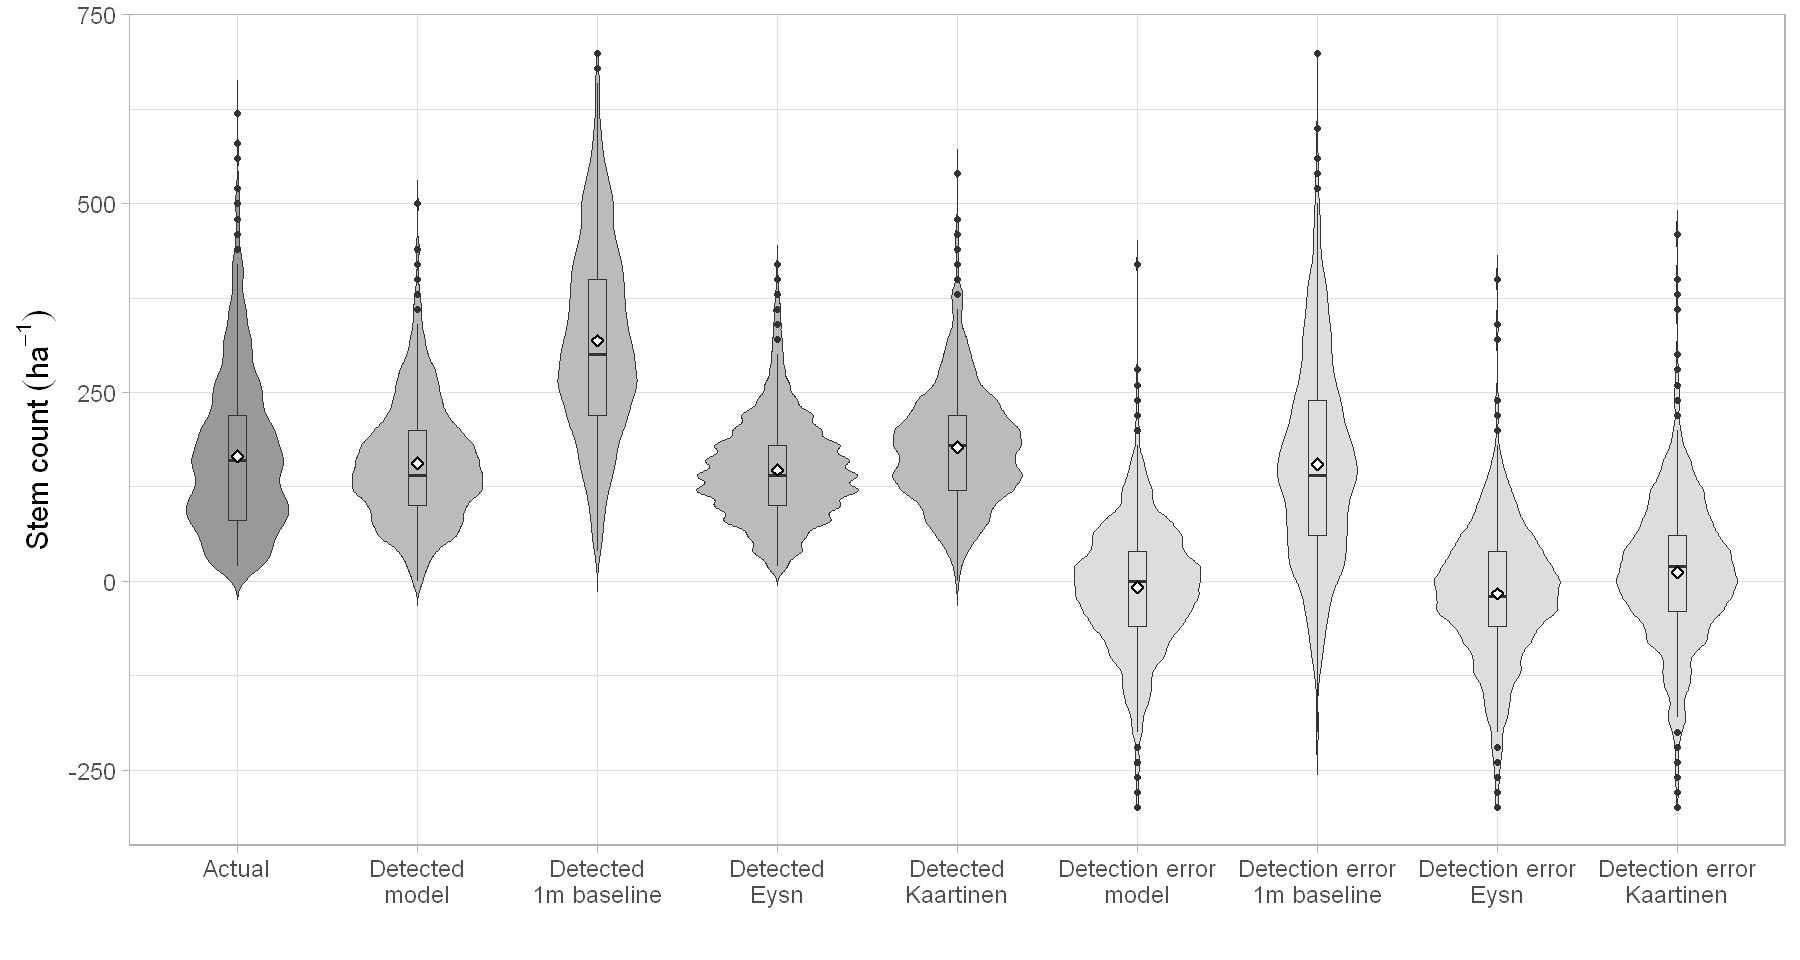

Warning message:
"Removed 9 rows containing missing values (geom_segment)."
Warning message:
"Removed 430 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 430 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 430 rows containing non-finite values (stat_summary)."
Warning message:
"Removed 105 rows containing missing values (geom_violin)."
Warning message:
"Removed 9 rows containing missing values (geom_segment)."


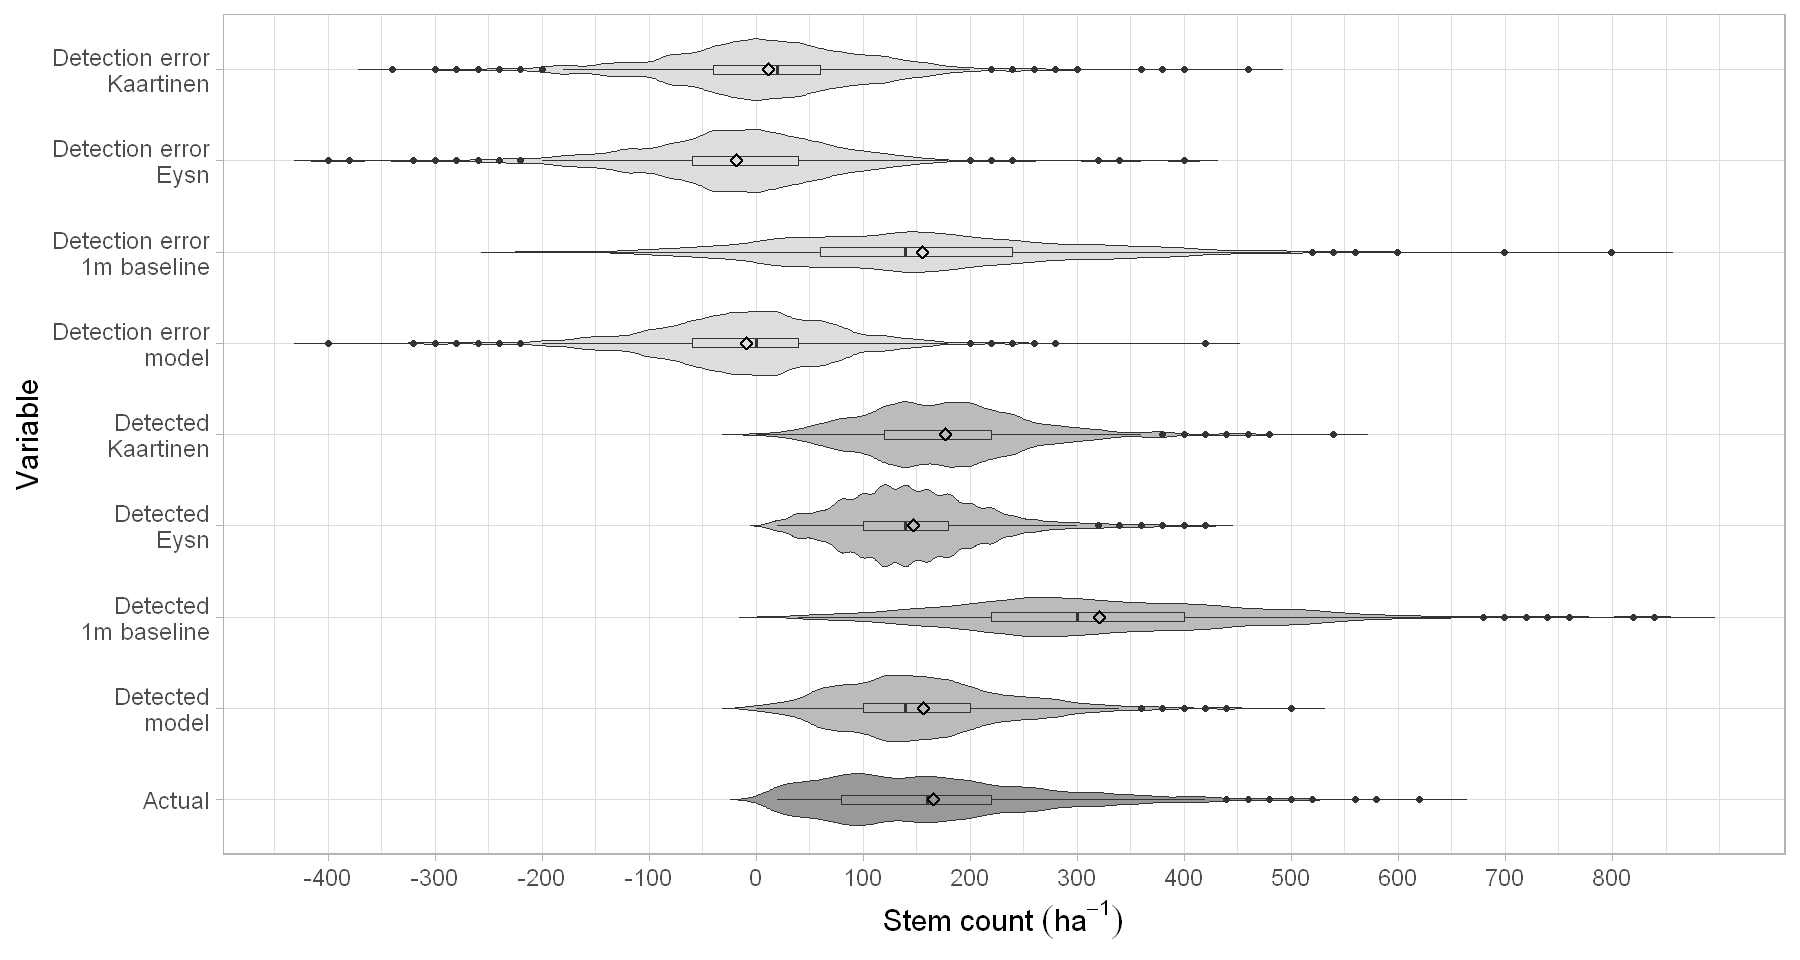

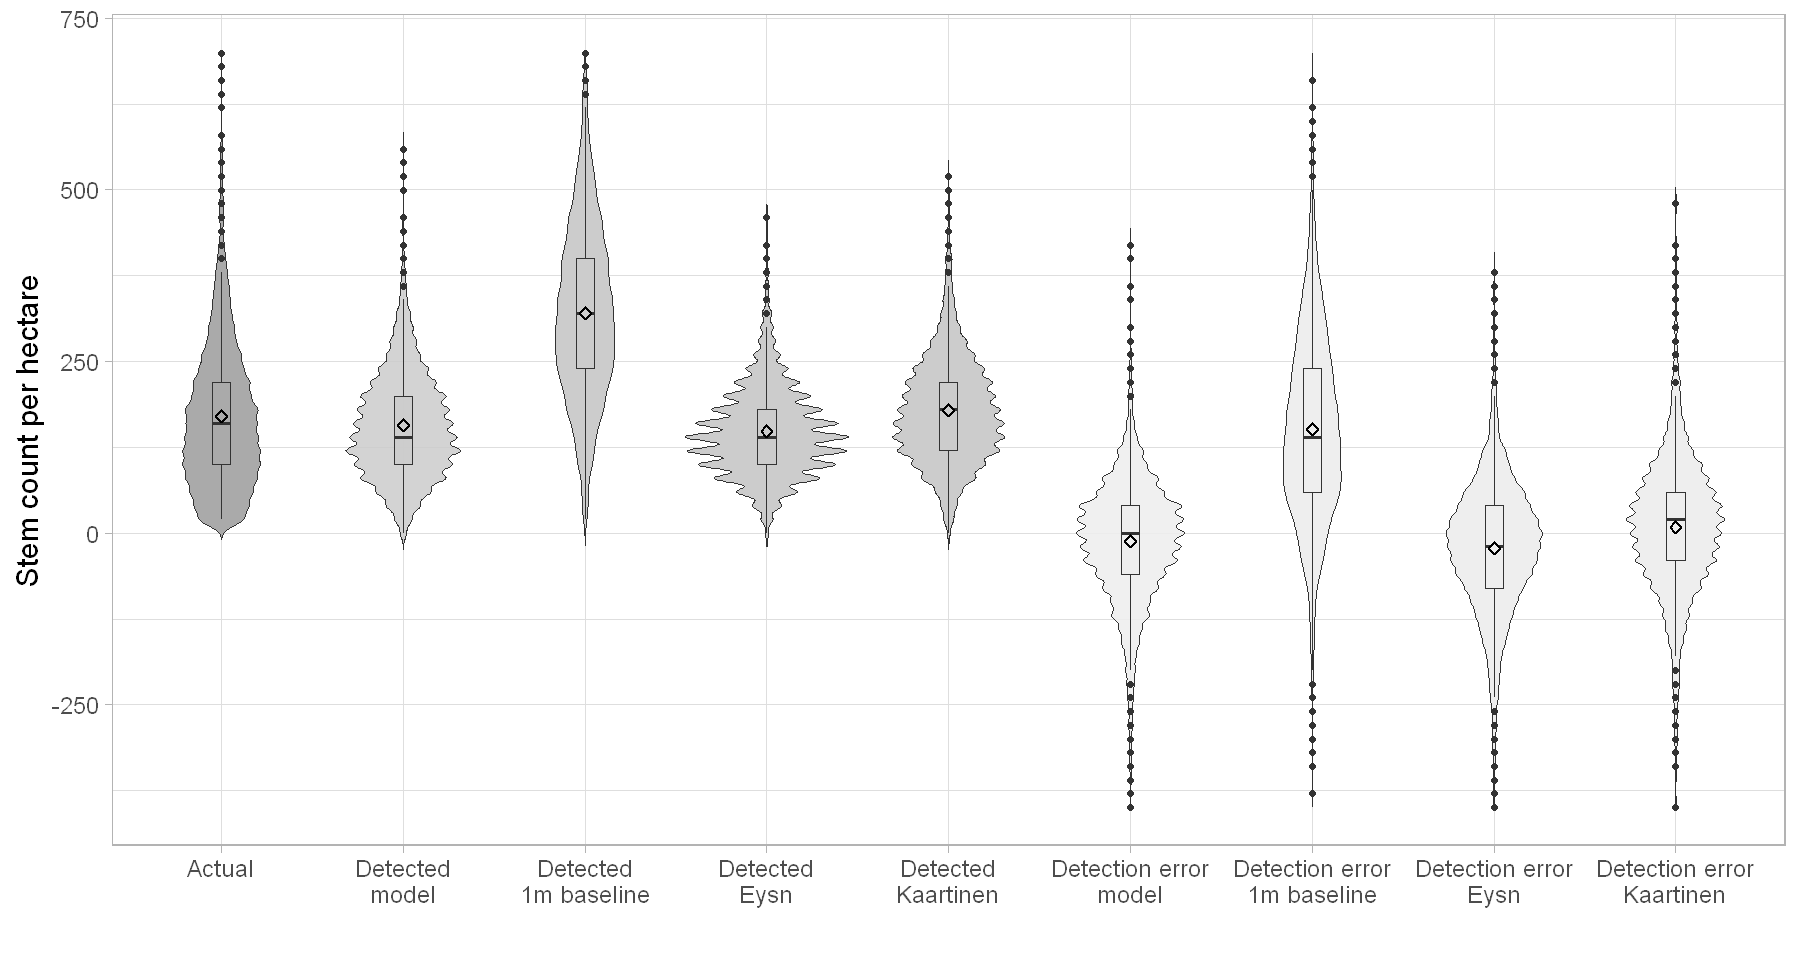

In [68]:
#Violin plots
options(repr.plot.width=15, repr.plot.height=8)

font_base_size <- 18

vp1<-ggplot(df_validation, aes(x=Variable, y=Value, fill=Variable)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  ylim(-300,700) +
  theme_light(base_size = font_base_size) +
  ylab(bquote(Stem~count~(ha^-1))) +
  xlab("") +
  theme(legend.position="none")+
  labs(fill="Detection Method",col="Detection Method") + 
  stat_summary(fun=mean, geom="pointrange", shape=23, size=0.5, fill="white") +
  scale_fill_manual(values=c("#999999", "#BBBBBB", "#BBBBBB", "#BBBBBB", "#BBBBBB", "#DDDDDD", "#DDDDDD", "#DDDDDD", "#DDDDDD"))  

vp1 

ggsave(filename = "3_violin_validation_vertical.jpg", width = 15, height = 8, device='jpeg', dpi=300)

vp2<-ggplot(df_validation, aes(x=Variable, y=Value, fill=Variable)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  # ylim(-200,600) +
  theme_light(base_size = font_base_size) +
  ylab(bquote(Stem~count~(ha^-1))) +
  theme(legend.position="none")+
  labs(fill="Detection Method",col="Detection Method") + 
  stat_summary(fun=mean, geom="pointrange", shape=23, size=0.5) +
  scale_fill_manual(values=c("#999999", "#BBBBBB", "#BBBBBB", "#BBBBBB", "#BBBBBB", "#DDDDDD", "#DDDDDD", "#DDDDDD", "#DDDDDD"))+
  coord_flip()+
  scale_y_continuous(breaks = seq(-400, 800, by = 100))

vp2

ggsave(filename = "3_violin_validation_horizontal.jpg", width = 12, height = 8, device='jpeg', dpi=300)


vptr1<-ggplot(df_calibration, aes(x=Variable, y=Value, fill=Variable)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  ylim(-400,700) +
  theme_light(base_size = font_base_size) +
  ylab("Stem count per hectare") +
  xlab("") +
  theme(legend.position="none")+
  labs(fill="Detection Method",col="Detection Method") + 
  stat_summary(fun=mean, geom="pointrange", shape=23, size=0.5) +
  scale_fill_manual(values=c("#AAAAAA", "#CCCCCCDD", "#CCCCCC", "#CCCCCC", "#CCCCCC", "#EEEEEEDD", "#EEEEEE", "#EEEEEE", "#EEEEEE"))  

vptr1


Warning message:
"Removed 130 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 130 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 130 rows containing missing values (geom_point)."
Warning message:
"Removed 19 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 19 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 19 rows containing missing values (geom_point)."


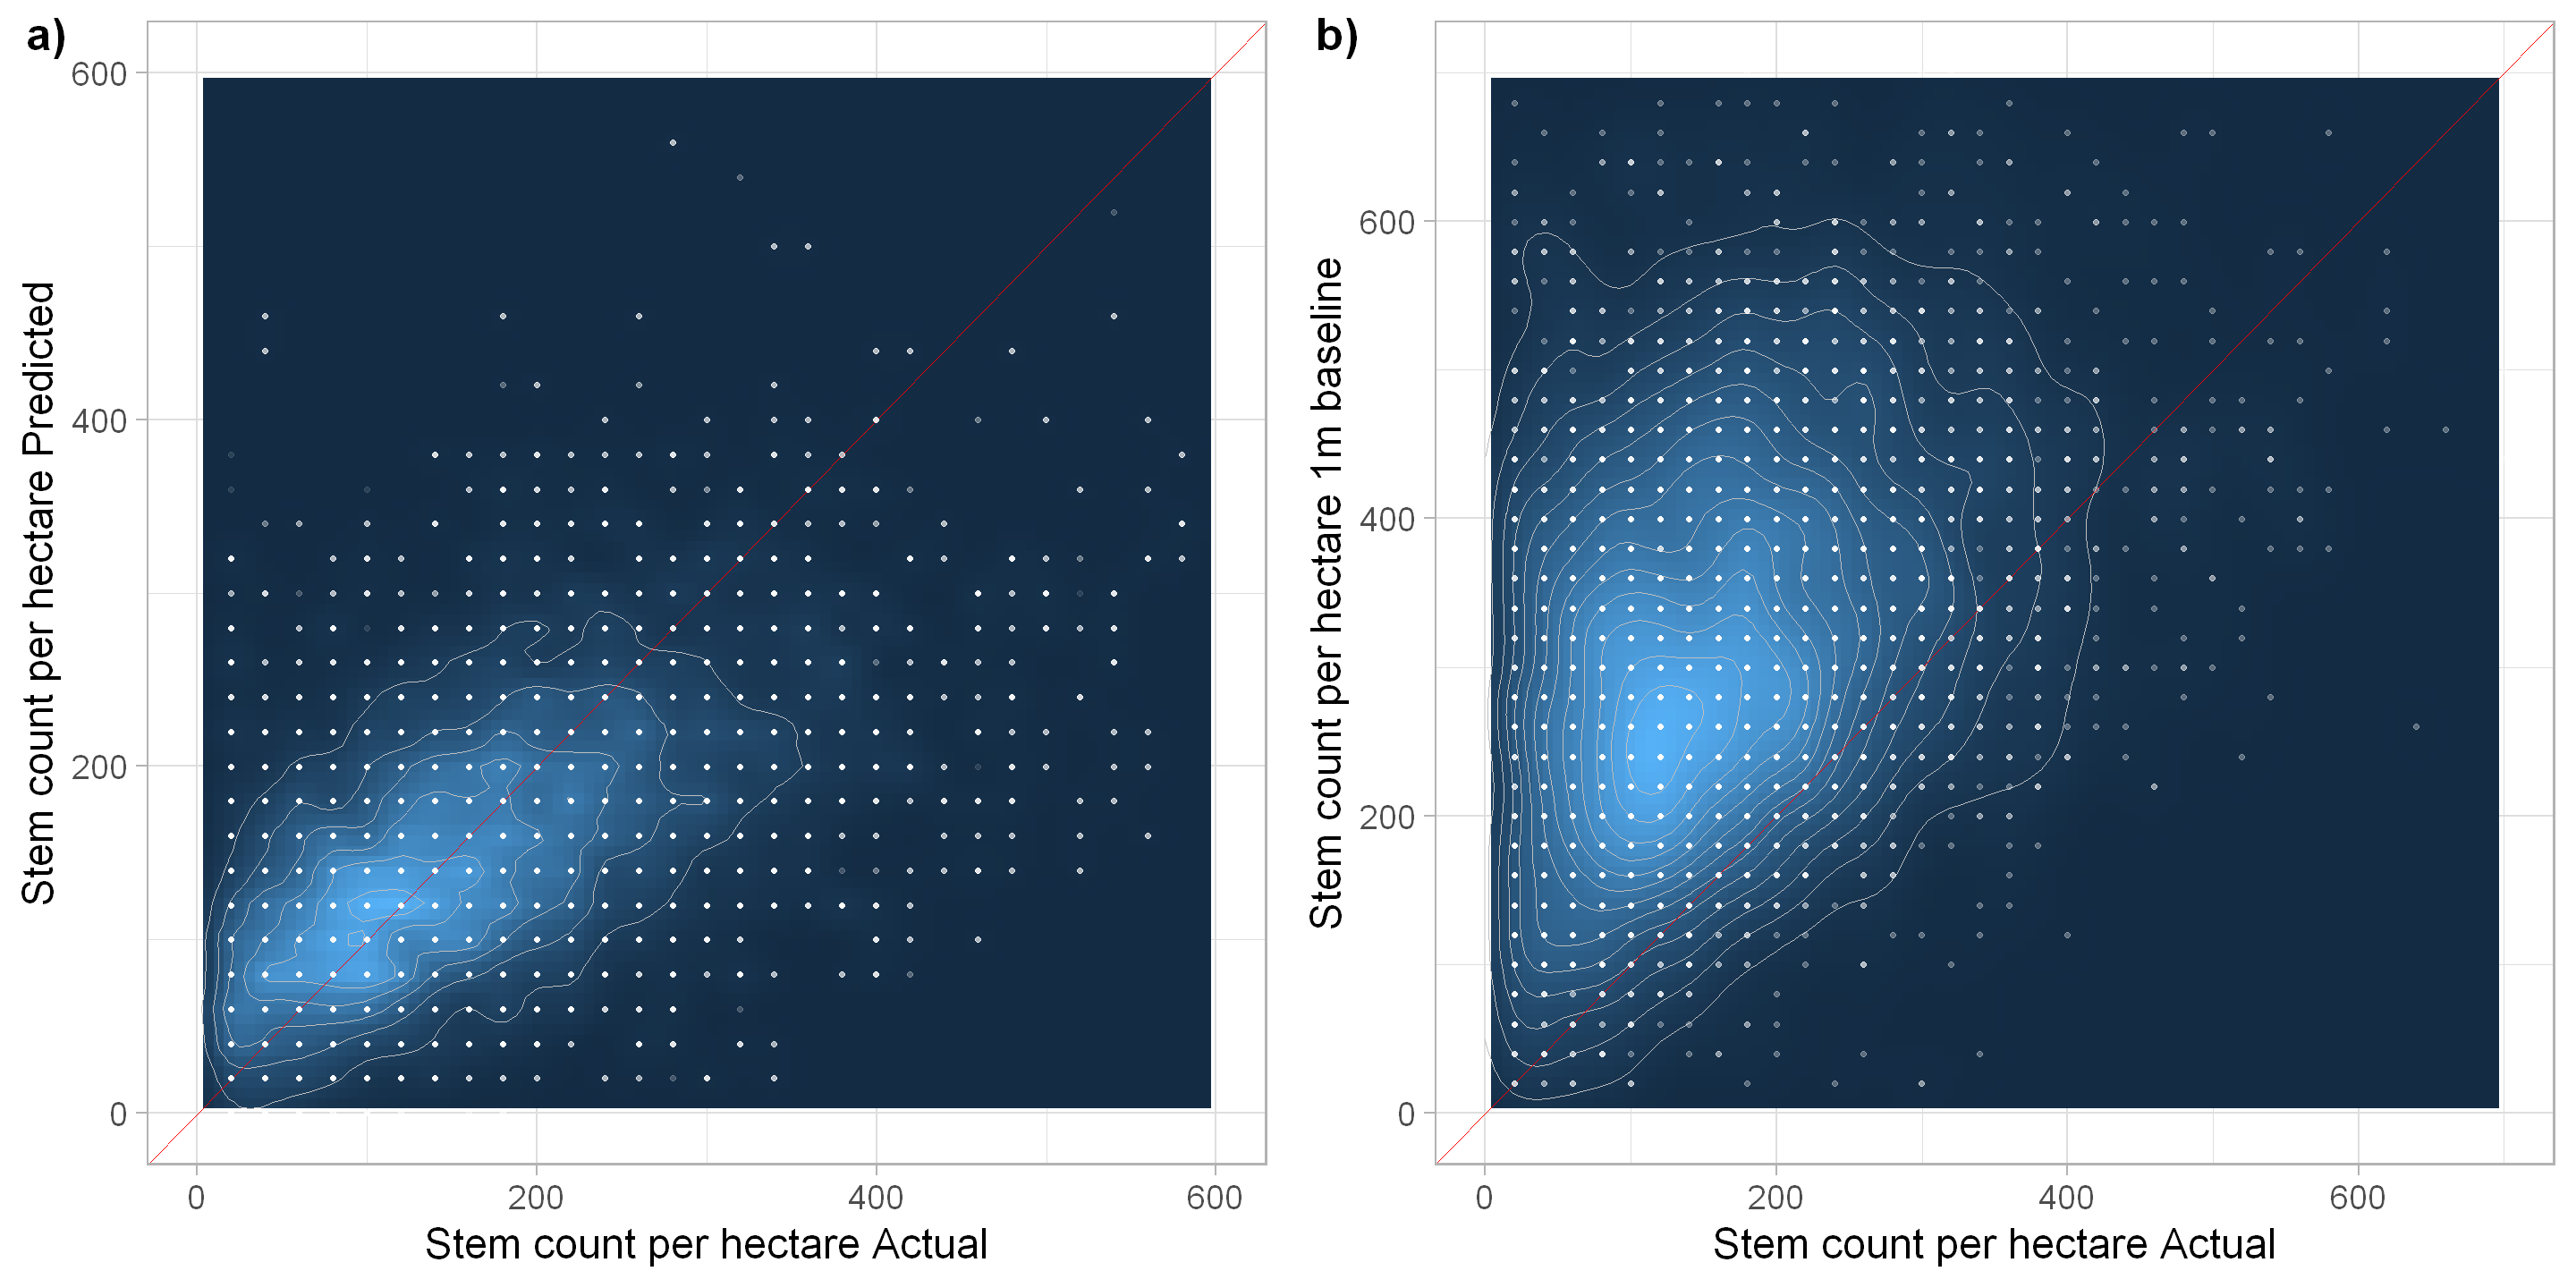

In [69]:
#Scatter plots calibration
df <- data.frame(Actual=scd_calibration$density_actual, Prediction=scd_calibration$stems_per_ha_model, Error=scd_calibration$stems_per_ha_err_model)

options(repr.plot.width=12, repr.plot.height=12)

font_base_size <- 28

sc1_tr <- ggplot(df, aes(x=Actual, y=Prediction)) +
  # geom_bin2d(binwidth=20)+
  # geom_hex() +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_abline(intercept = 0, slope = 1, color="red") +
  geom_point(alpha=0.1, color="white") +
  xlim(0,600) +
  ylim(0,600) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  theme(legend.position="none")+
  xlab("Stem count per hectare Actual") +
  ylab("Stem count per hectare Predicted") 


df <- data.frame(Actual=lfi_trees_grouped_calibration$density_actual, Baseline=lfi_trees_grouped_calibration$stems_per_ha_ps1, Error=lfi_trees_grouped_calibration$stems_per_ha_err_ps1)

sc2_tr <- ggplot(df, aes(x=Actual, y=Baseline)) +
  # geom_bin2d(binwidth=20)+
  # geom_hex() +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_abline(intercept = 0, slope = 1, color="red") +
  geom_point(alpha=0.3, color="white") +
  xlim(0,700) +
  ylim(0,700) +
  theme_light(base_size = font_base_size) +
  theme(legend.position="none")+
  xlab("Stem count per hectare Actual") +
  ylab("Stem count per hectare 1m baseline") 

options(repr.plot.width=24, repr.plot.height=12)

ggarrange(sc1_tr, sc2_tr, 
          labels = c("a) ", "b) "),
          ncol = 2, nrow = 1, font.label = list(size = 30))
ggsave(filename = "4_scatter_actual_predicted_baseline_calibration.jpg", width = 24, height = 12, device='jpeg', dpi=300)


Warning message:
"Removed 10 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 10 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 10 rows containing missing values (geom_point)."
Warning message:
"Removed 6 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 6 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 6 rows containing missing values (geom_point)."


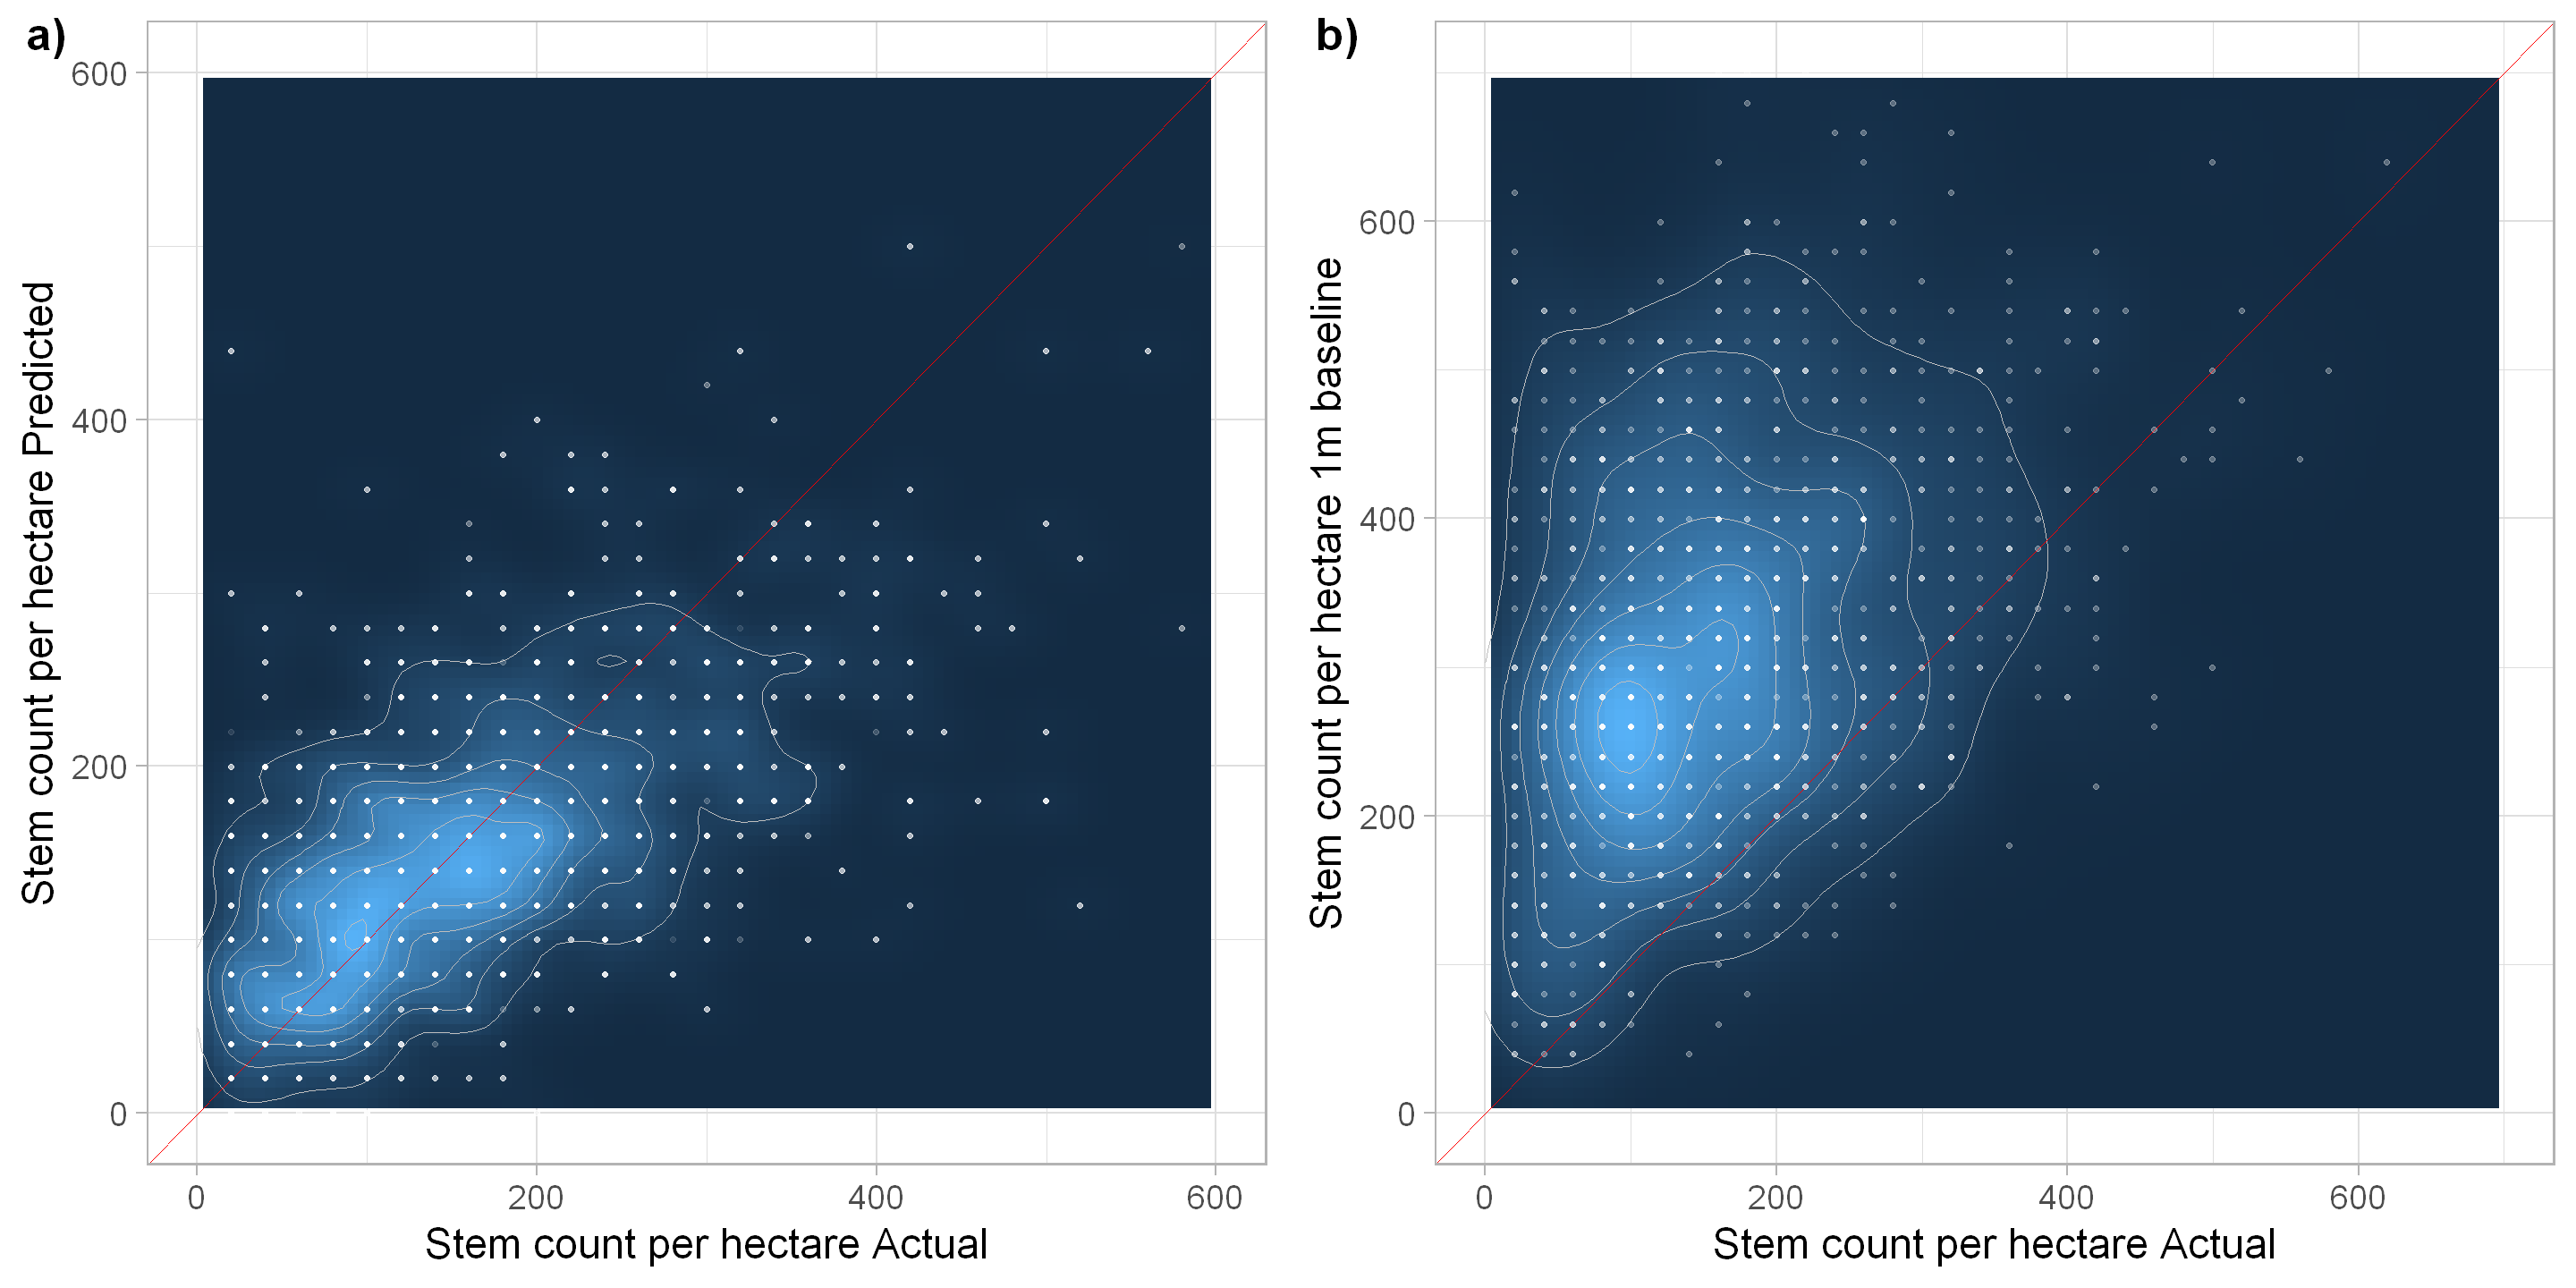

In [70]:
#Scatter plots validation
df <- data.frame(Actual=scd_validation$density_actual, Prediction=scd_validation$stems_per_ha_model, Error=scd_validation$stems_per_ha_err_model)

options(repr.plot.width=12, repr.plot.height=12)

font_base_size <- 28

sc1_ts <- ggplot(df, aes(x=Actual, y=Prediction)) +
  # geom_bin2d(binwidth=20)+
  # geom_hex() +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_abline(intercept = 0, slope = 1, color="red") +
  geom_point(alpha=0.1, color="white") +
  xlim(0,600) +
  ylim(0,600) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  theme(legend.position="none")+
  xlab("Stem count per hectare Actual") +
  ylab("Stem count per hectare Predicted") 


df <- data.frame(Actual=lfi_trees_grouped_validation$density_actual, Baseline=lfi_trees_grouped_validation$stems_per_ha_ps1, Error=lfi_trees_grouped_validation$stems_per_ha_err_ps1)

sc2_ts <- ggplot(df, aes(x=Actual, y=Baseline)) +
  # geom_bin2d(binwidth=20)+
  # geom_hex() +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_abline(intercept = 0, slope = 1, color="red") +
  geom_point(alpha=0.3, color="white") +
  xlim(0,700) +
  ylim(0,700) +
  theme_light(base_size = font_base_size) +
  theme(legend.position="none")+
  xlab("Stem count per hectare Actual") +
  ylab("Stem count per hectare 1m baseline") 

options(repr.plot.width=24, repr.plot.height=12)

ggarrange(sc1_ts, sc2_ts, 
          labels = c("a) ", "b) "),
          ncol = 2, nrow = 1, font.label = list(size = 30))
ggsave(filename = "4_scatter_actual_predicted_baseline_validation.jpg", width = 24, height = 12, device='jpeg', dpi=300)


Warning message:
"Removed 10 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 10 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 10 rows containing missing values (geom_point)."
Warning message:
"Removed 10 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 10 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 10 rows containing missing values (geom_point)."


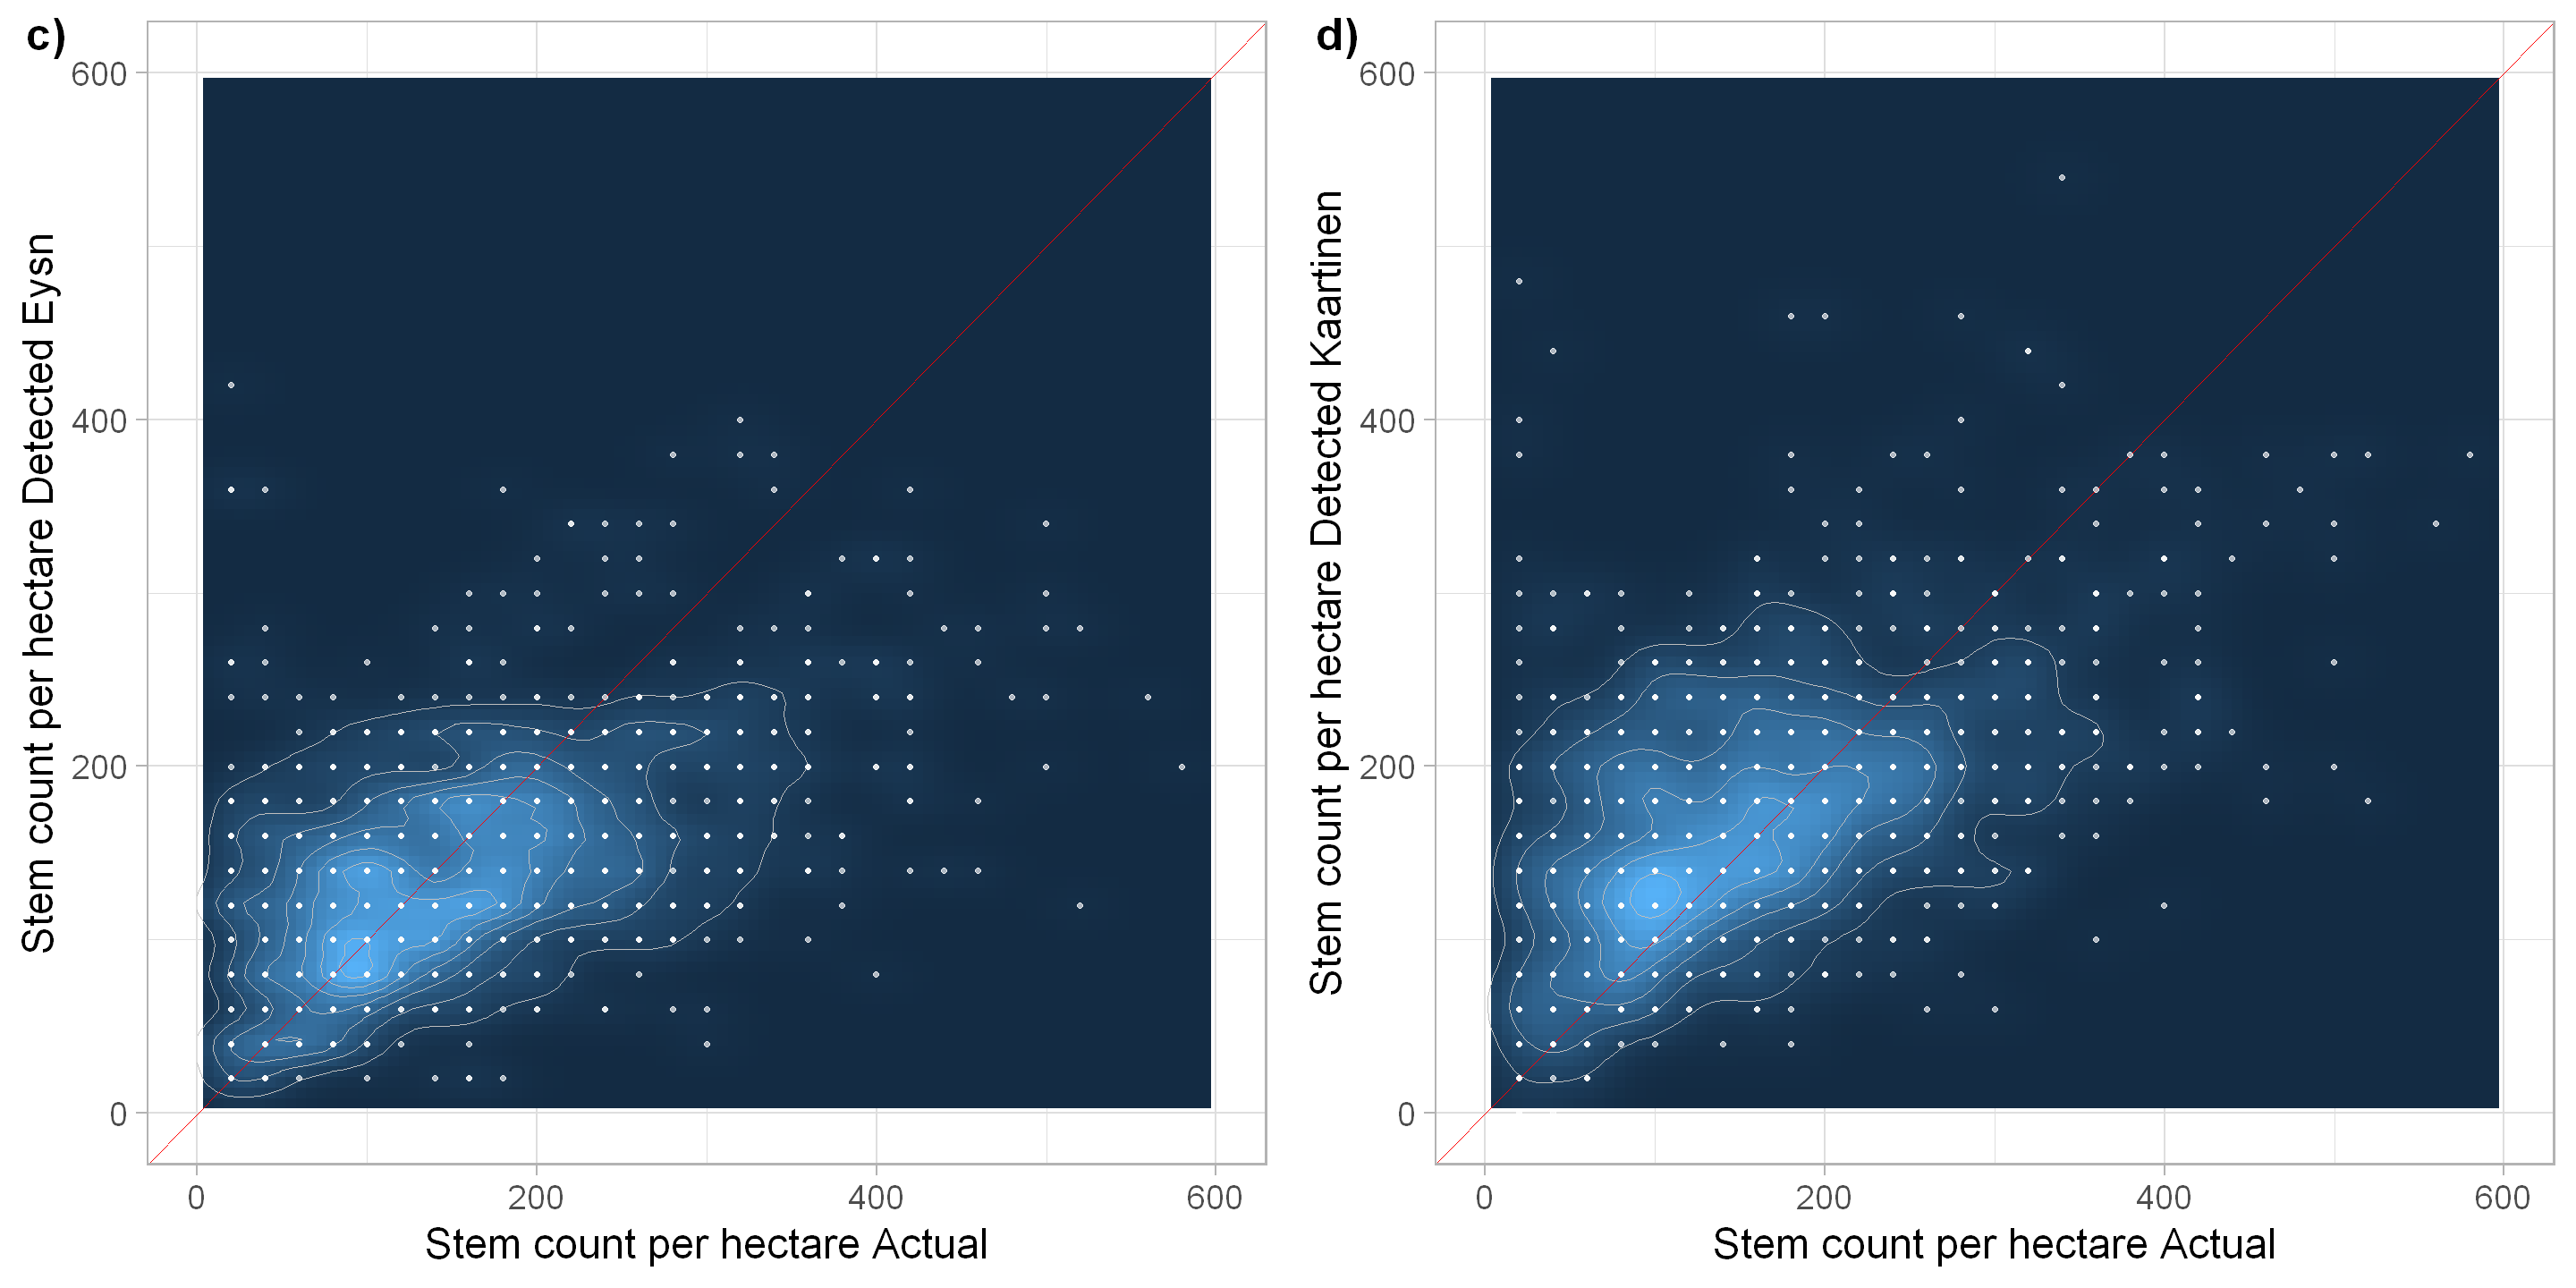

In [71]:
#Scatter plots validation
df <- data.frame(Actual=scd_validation_eysn$density_actual, Prediction=scd_validation_eysn$stems_per_ha_model, Error=scd_validation_eysn$stems_per_ha_err_model)

options(repr.plot.width=12, repr.plot.height=12)

font_base_size <- 28

sc1_ts_eysn <- ggplot(df, aes(x=Actual, y=Prediction)) +
  # geom_bin2d(binwidth=20)+
  # geom_hex() +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_abline(intercept = 0, slope = 1, color="red") +
  geom_point(alpha=0.1, color="white") +
  xlim(0,600) +
  ylim(0,600) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  theme(legend.position="none")+
  xlab("Stem count per hectare Actual") +
  ylab("Stem count per hectare Detected Eysn") 


df <- data.frame(Actual=scd_validation_kaartinen$density_actual, Prediction=scd_validation_kaartinen$stems_per_ha_model, Error=scd_validation_kaartinen$stems_per_ha_err_model)

options(repr.plot.width=12, repr.plot.height=12)

font_base_size <- 28

sc2_ts_kaartinen <- ggplot(df, aes(x=Actual, y=Prediction)) +
  # geom_bin2d(binwidth=20)+
  # geom_hex() +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_abline(intercept = 0, slope = 1, color="red") +
  geom_point(alpha=0.1, color="white") +
  xlim(0,600) +
  ylim(0,600) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  theme(legend.position="none")+
  xlab("Stem count per hectare Actual") +
  ylab("Stem count per hectare Detected Kaartinen") 


options(repr.plot.width=24, repr.plot.height=12)

ggarrange(sc1_ts_eysn, sc2_ts_kaartinen, 
          labels = c("c) ", "d) "),
          ncol = 2, nrow = 1, font.label = list(size = 30))
ggsave(filename = "4_scatter_actual_predicted_baseline_validation_eysn_kaartinen.jpg", width = 24, height = 12, device='jpeg', dpi=300)


Warning message:
"Removed 130 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 130 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 130 rows containing missing values (geom_point)."
Warning message:
"Removed 19 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 19 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 19 rows containing missing values (geom_point)."
Warning message:
"Removed 10 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 10 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 10 rows containing missing values (geom_point)."
Warning message:
"Removed 6 rows containing non-f

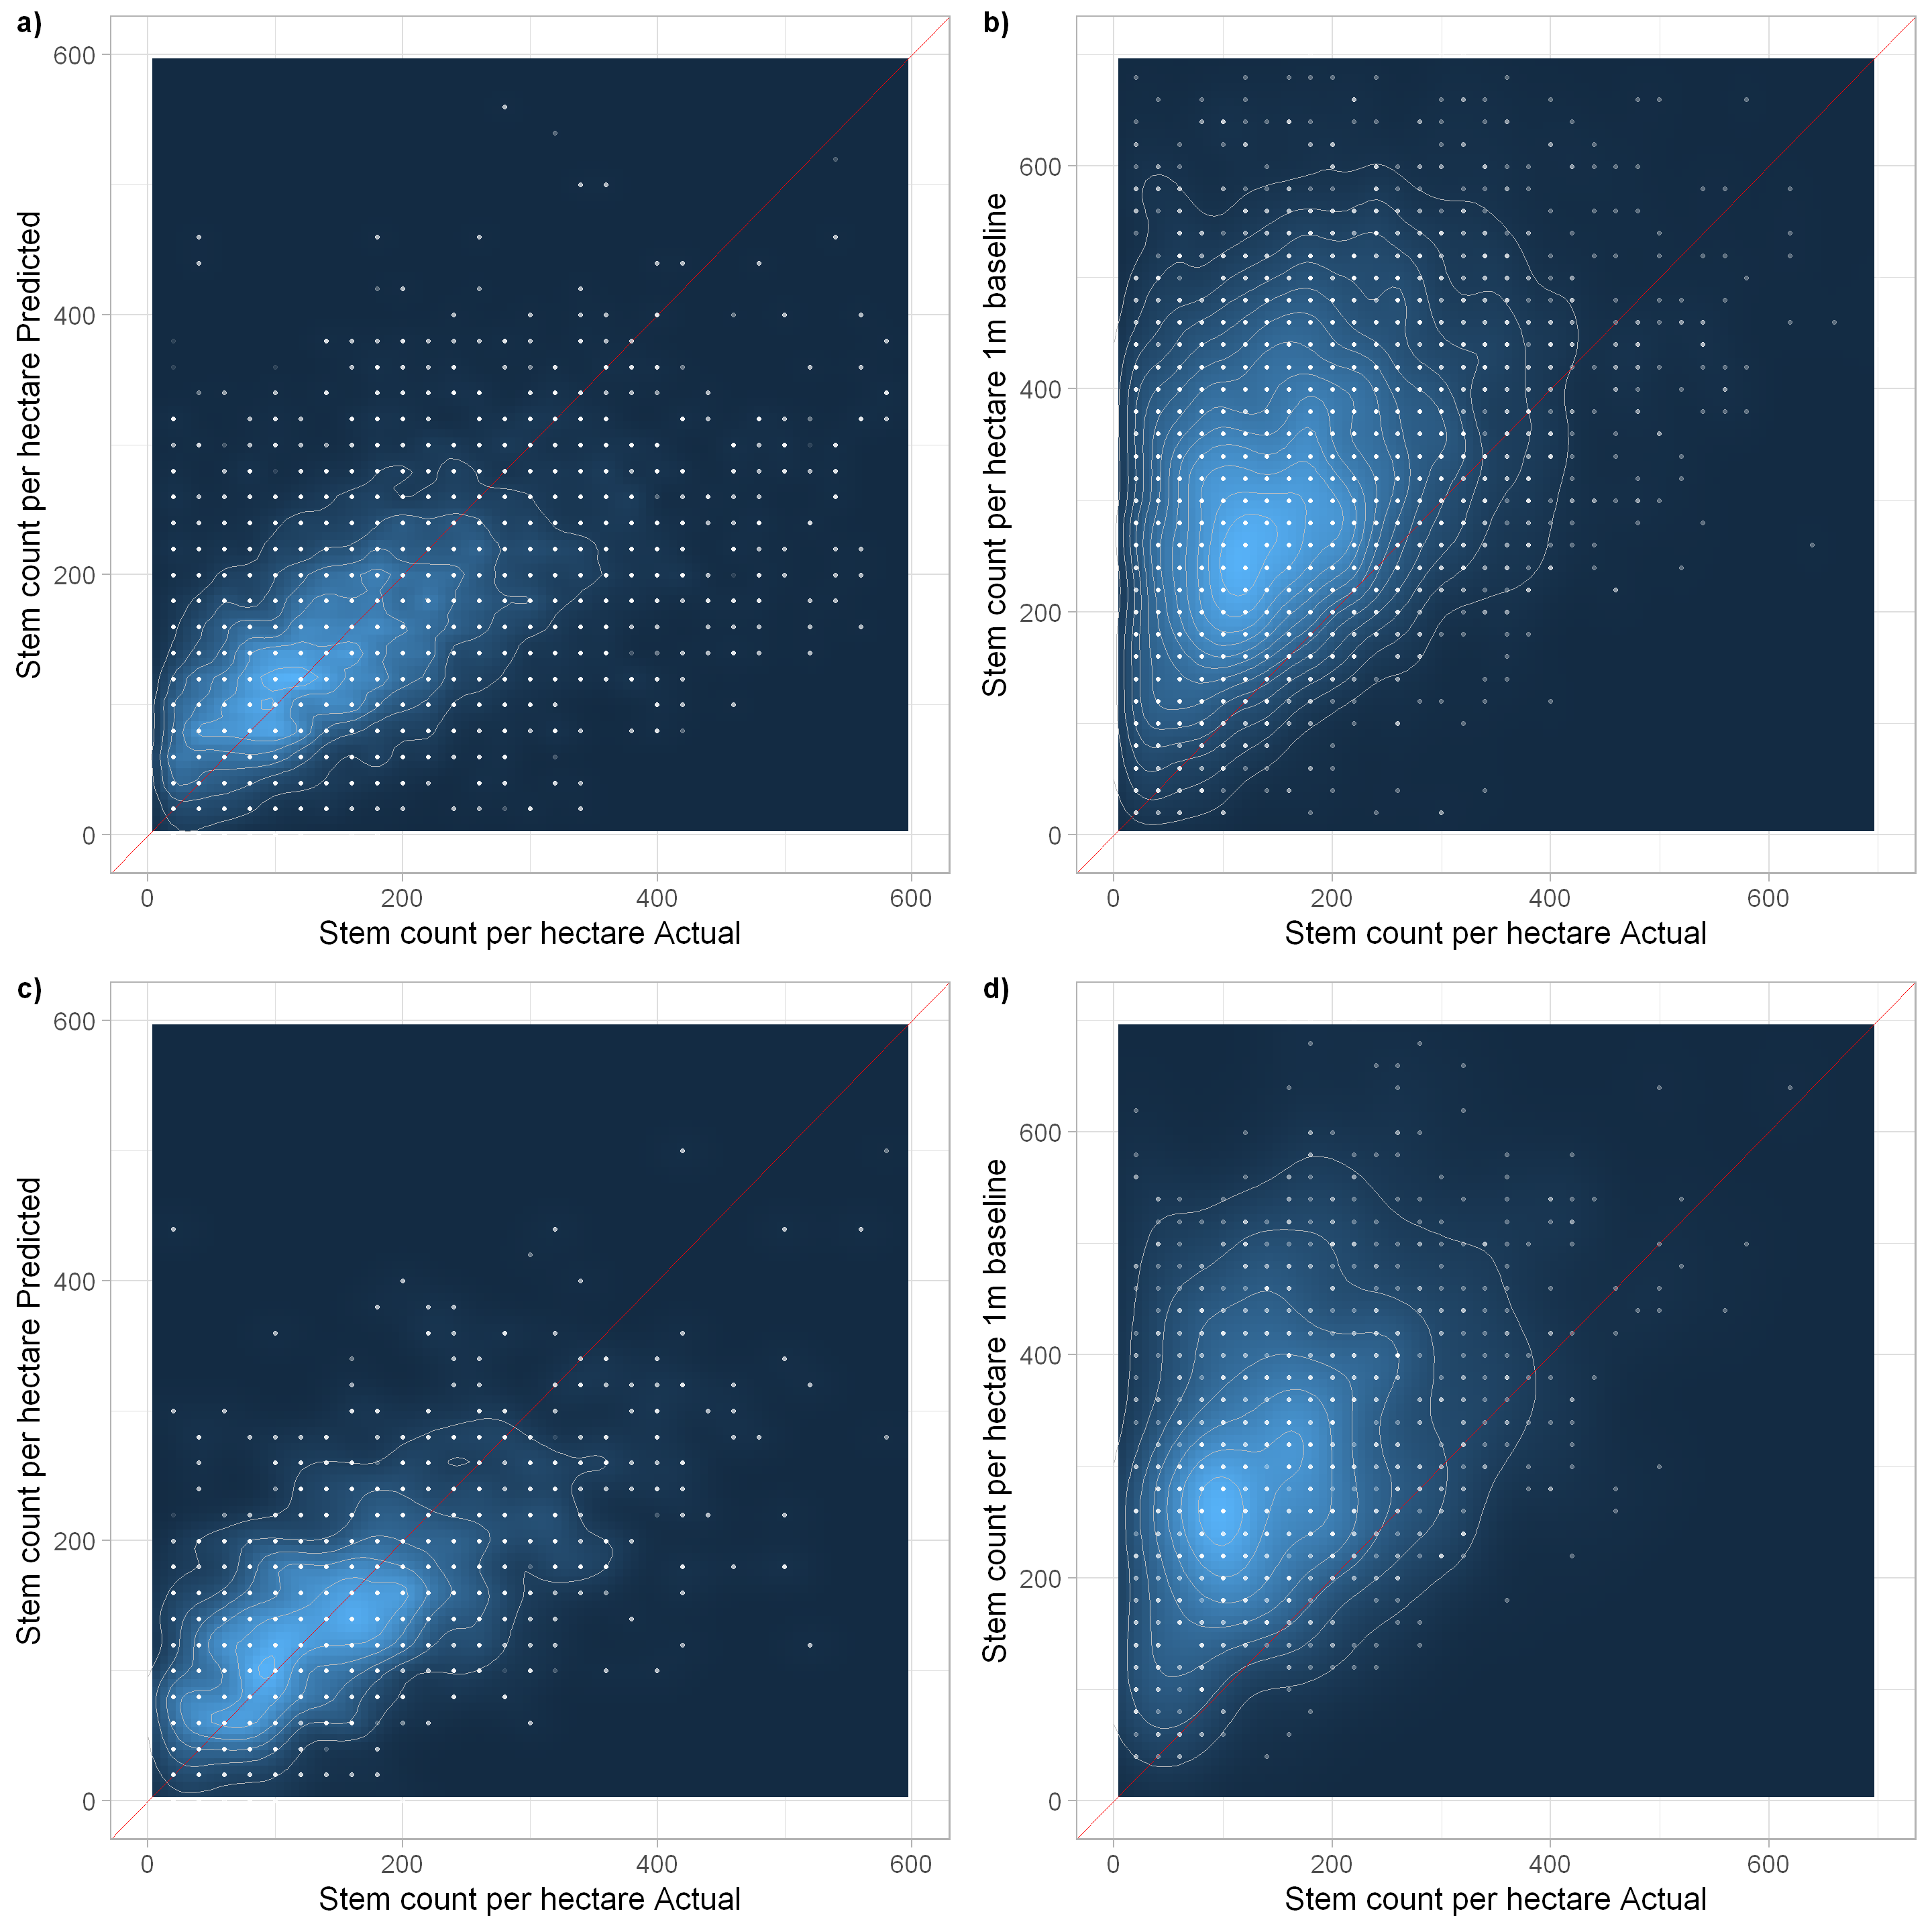

In [72]:
#Scatter plots validation and calibration
options(repr.plot.width=24, repr.plot.height=24)

ggarrange(sc1_tr,sc2_tr,sc1_ts, sc2_ts, 
          labels = c("a) ", "b) ", "c) ", "d) "),
          ncol = 2, nrow = 2, font.label = list(size = 26))


Warning message:
"Removed 130 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 130 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 130 rows containing missing values (geom_point)."
Warning message:
"Removed 19 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 19 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 19 rows containing missing values (geom_point)."
Warning message:
"Removed 10 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 10 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 10 rows containing missing values (geom_point)."
Warning message:
"Removed 10 rows containing non-

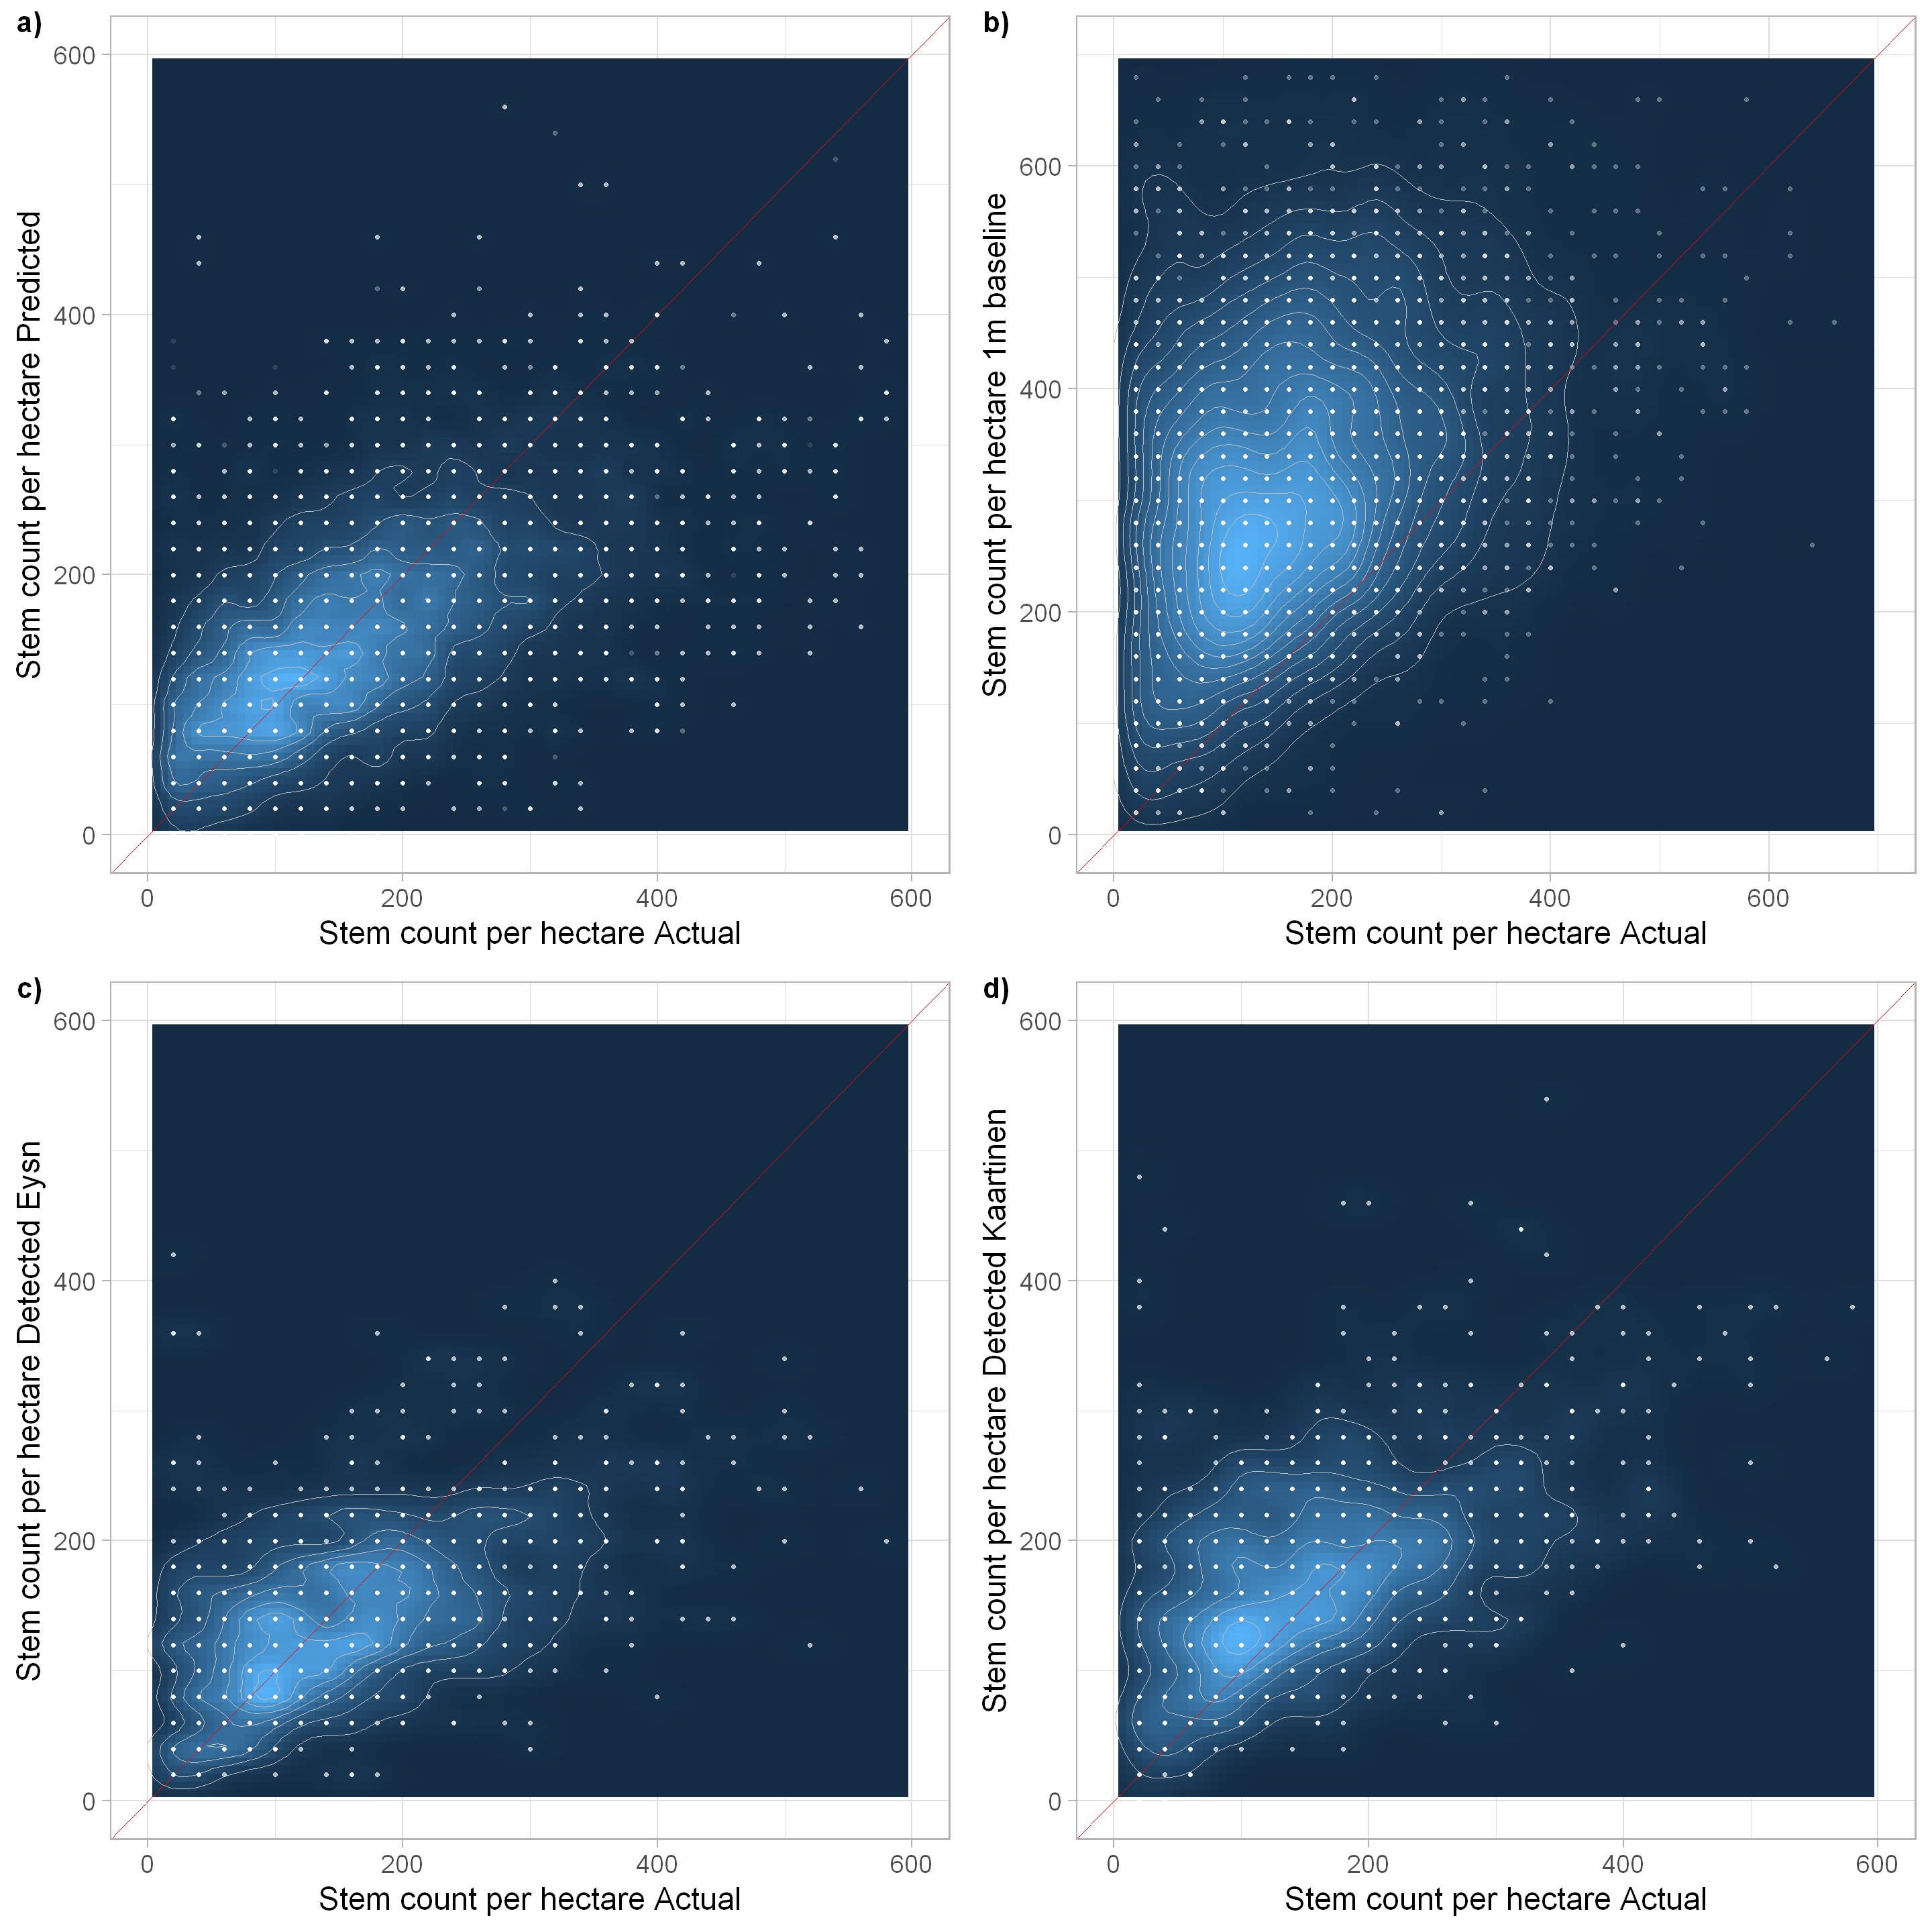

In [73]:
#Scatter plots validation and calibration
options(repr.plot.width=24, repr.plot.height=24)

ggarrange(sc1_tr,sc2_tr,sc1_ts_eysn, sc2_ts_kaartinen, 
          labels = c("a) ", "b) ", "c) ", "d) "),
          ncol = 2, nrow = 2, font.label = list(size = 26))


<a id="Error_Exploration"></a>
### Exploring high errors and model behaviour

In [74]:
# Get scoring data for all plots for the best model 
min_mae_index <- which.min(scores_all_all$scores$mae)
data <- scores_all_all$scoring_data[[min_mae_index]]

In [75]:
summary(data$stems_per_ha_abs_err_norm_model)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.1667  0.3333  0.6413  0.6125 21.0000 

In [76]:
# Set 0/1 Flags for normed absolute errors >1, >2, >3 and >4
data$ae_norm_class_1 <-  as.factor(unlist(lapply(data$stems_per_ha_abs_err_norm_model, function(x) { if(x>1){return(1)}else{return(0)}})))
data$ae_norm_class_2 <-  as.factor(unlist(lapply(data$stems_per_ha_abs_err_norm_model, function(x) { if(x>2){return(1)}else{return(0)}})))
data$ae_norm_class_3 <-  as.factor(unlist(lapply(data$stems_per_ha_abs_err_norm_model, function(x) { if(x>3){return(1)}else{return(0)}})))
data$ae_norm_class_4 <-  as.factor(unlist(lapply(data$stems_per_ha_abs_err_norm_model, function(x) { if(x>4){return(1)}else{return(0)}})))

In [77]:
data$nh_bin <- as.factor(floor(data$nh/5)*5)
data$dg_bin <- as.factor(floor(data$dg/5)*5)
data$hdom_bin <- as.factor(floor(data$hdom/4)*4)


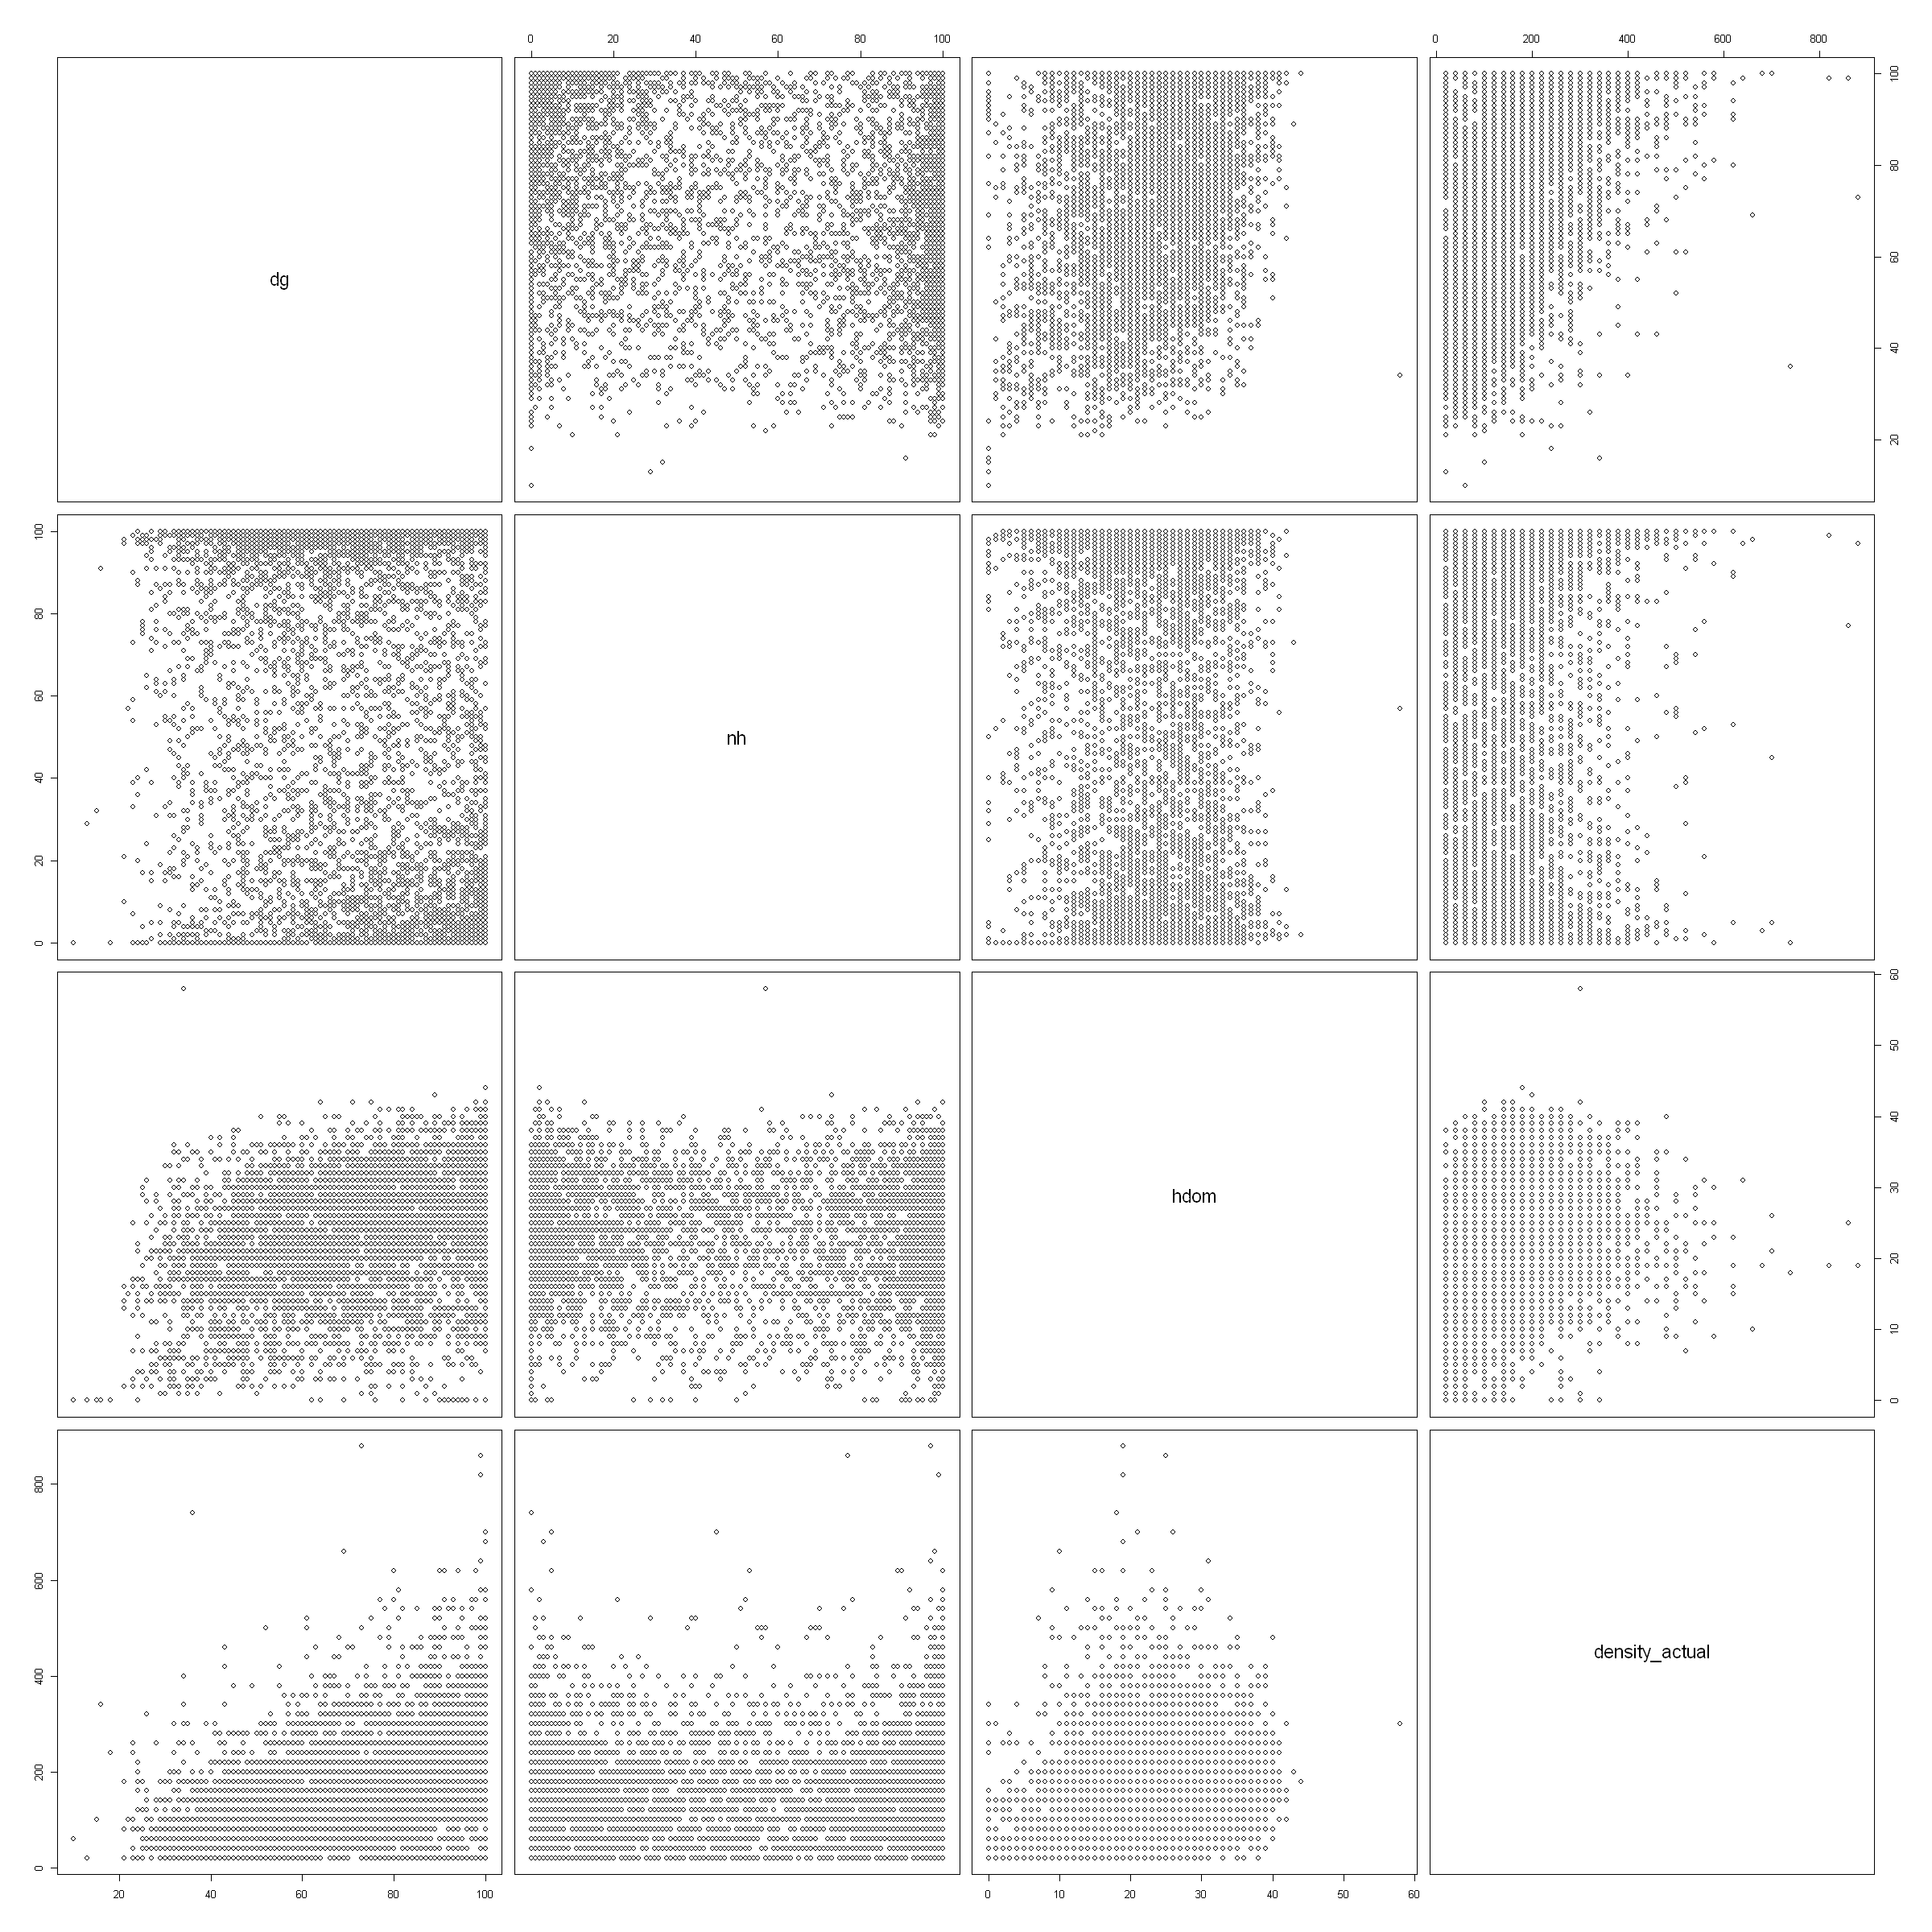

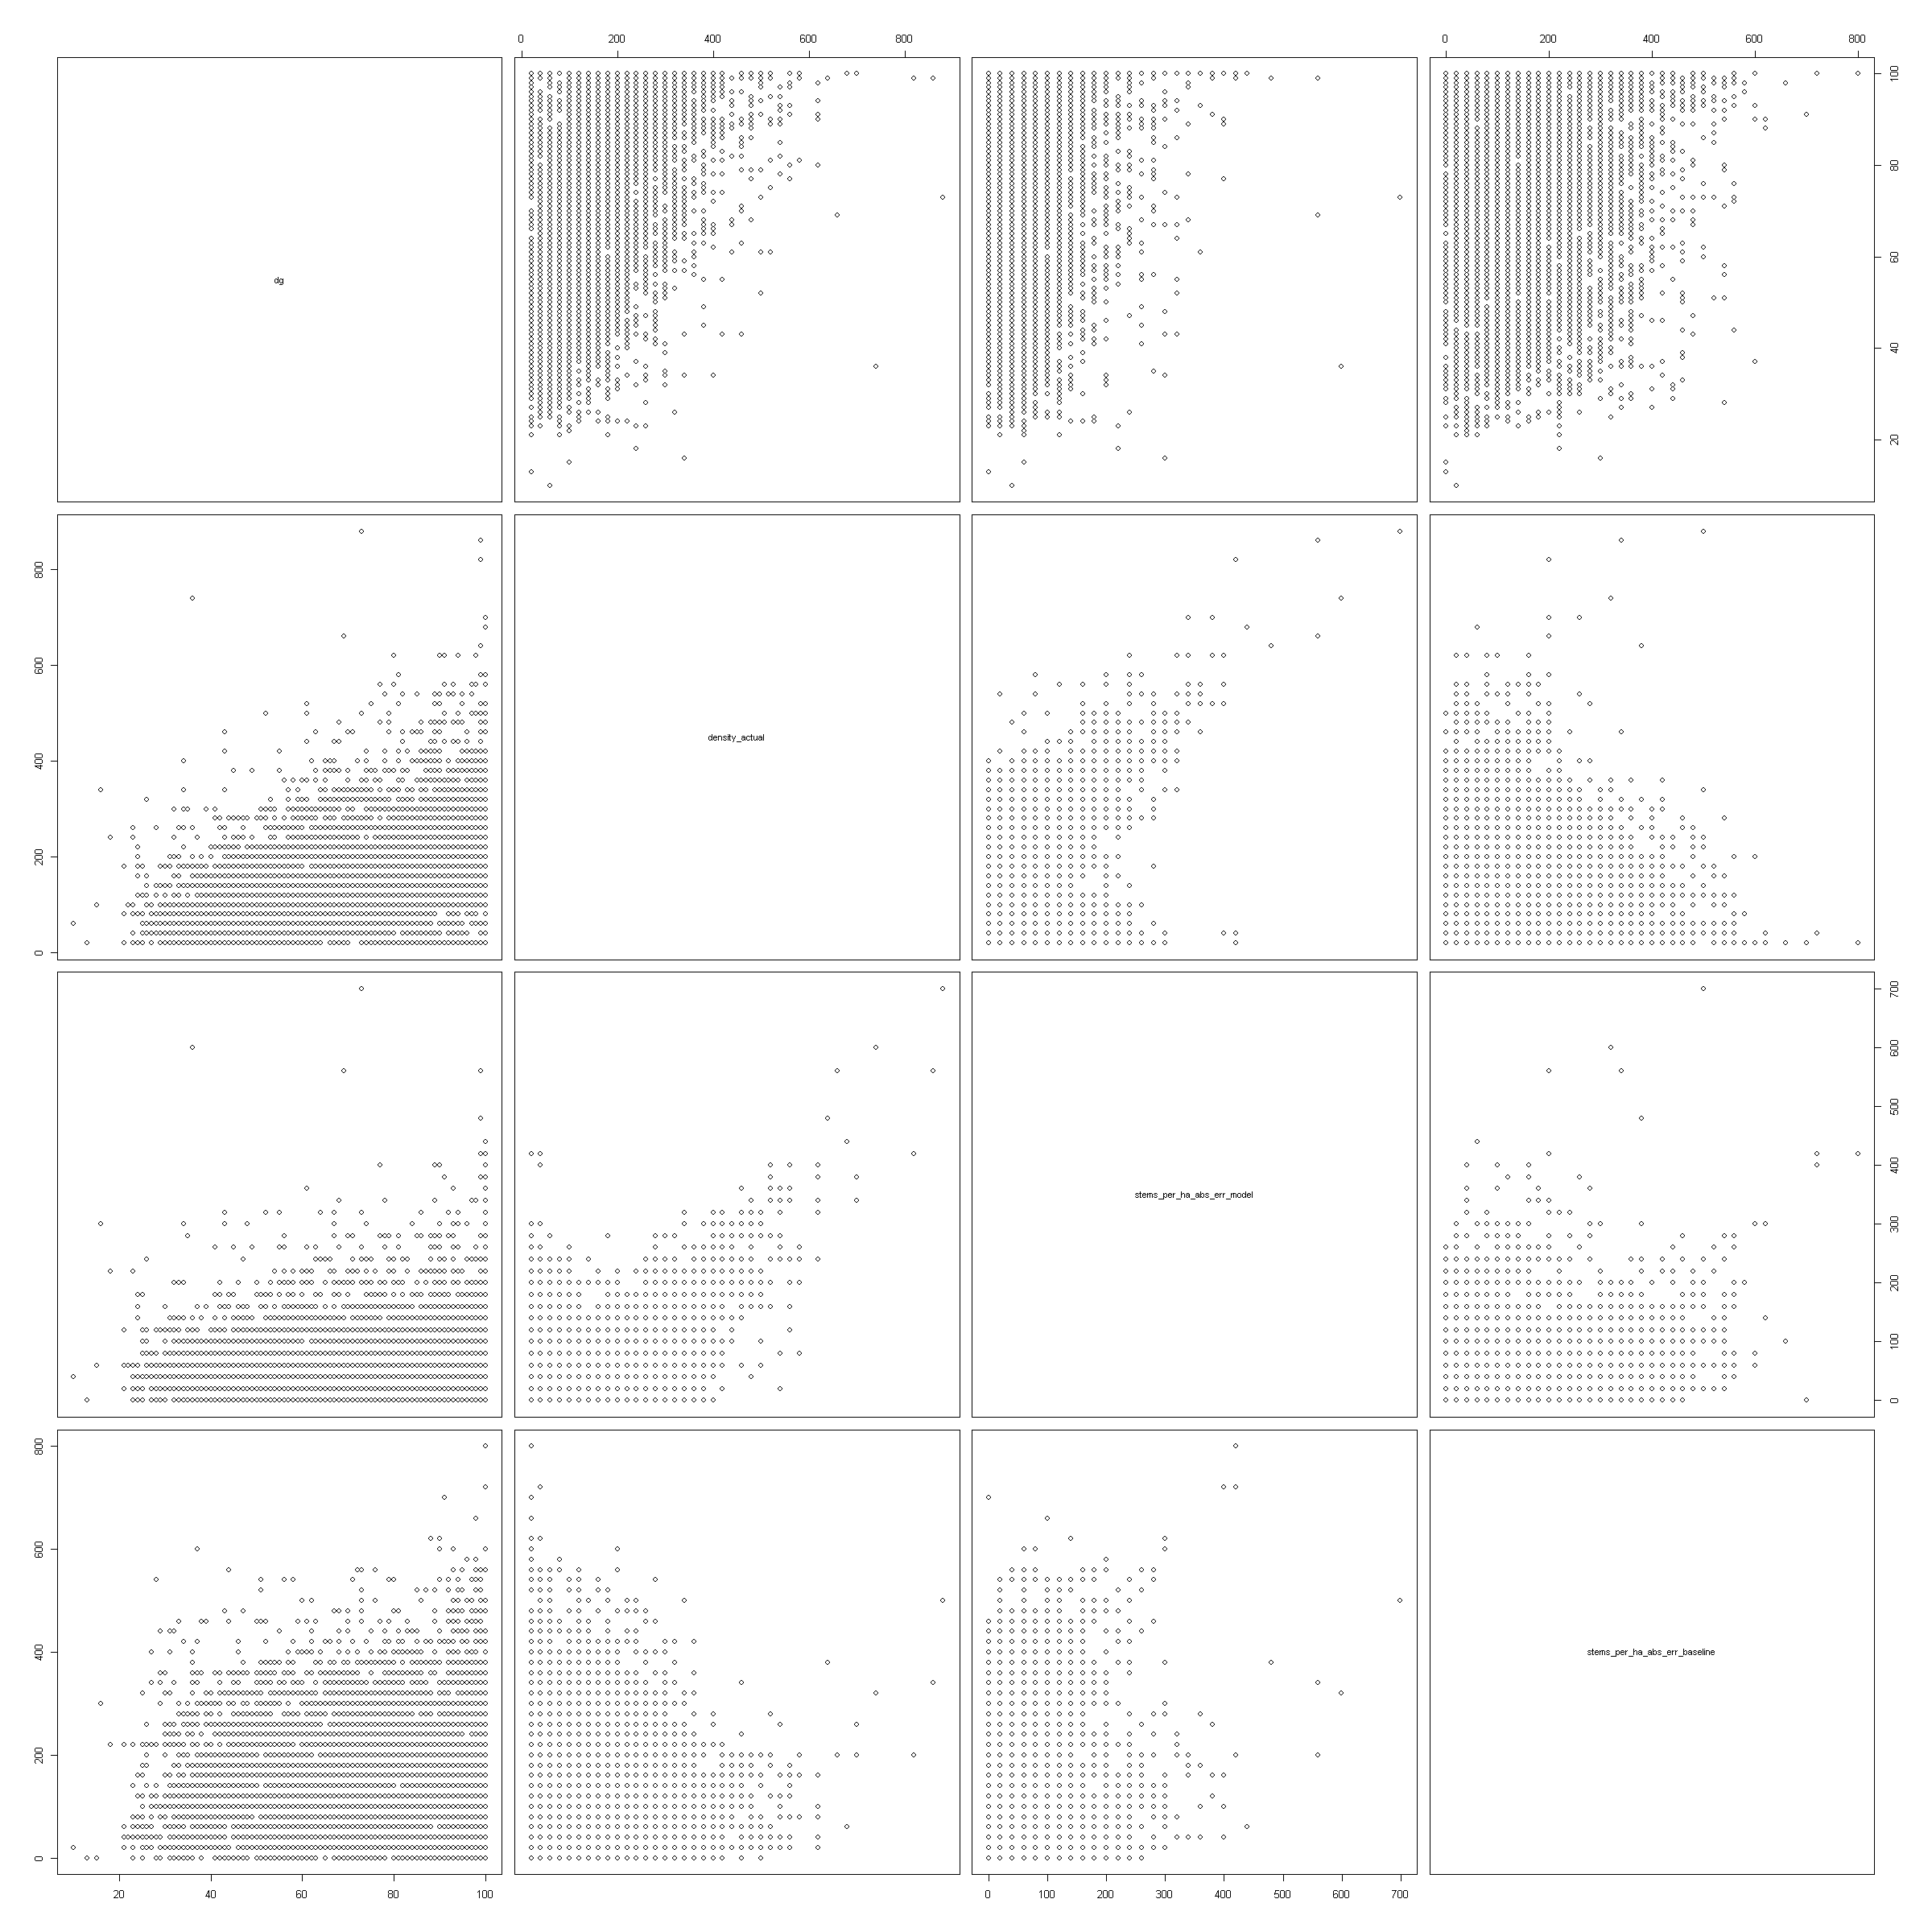

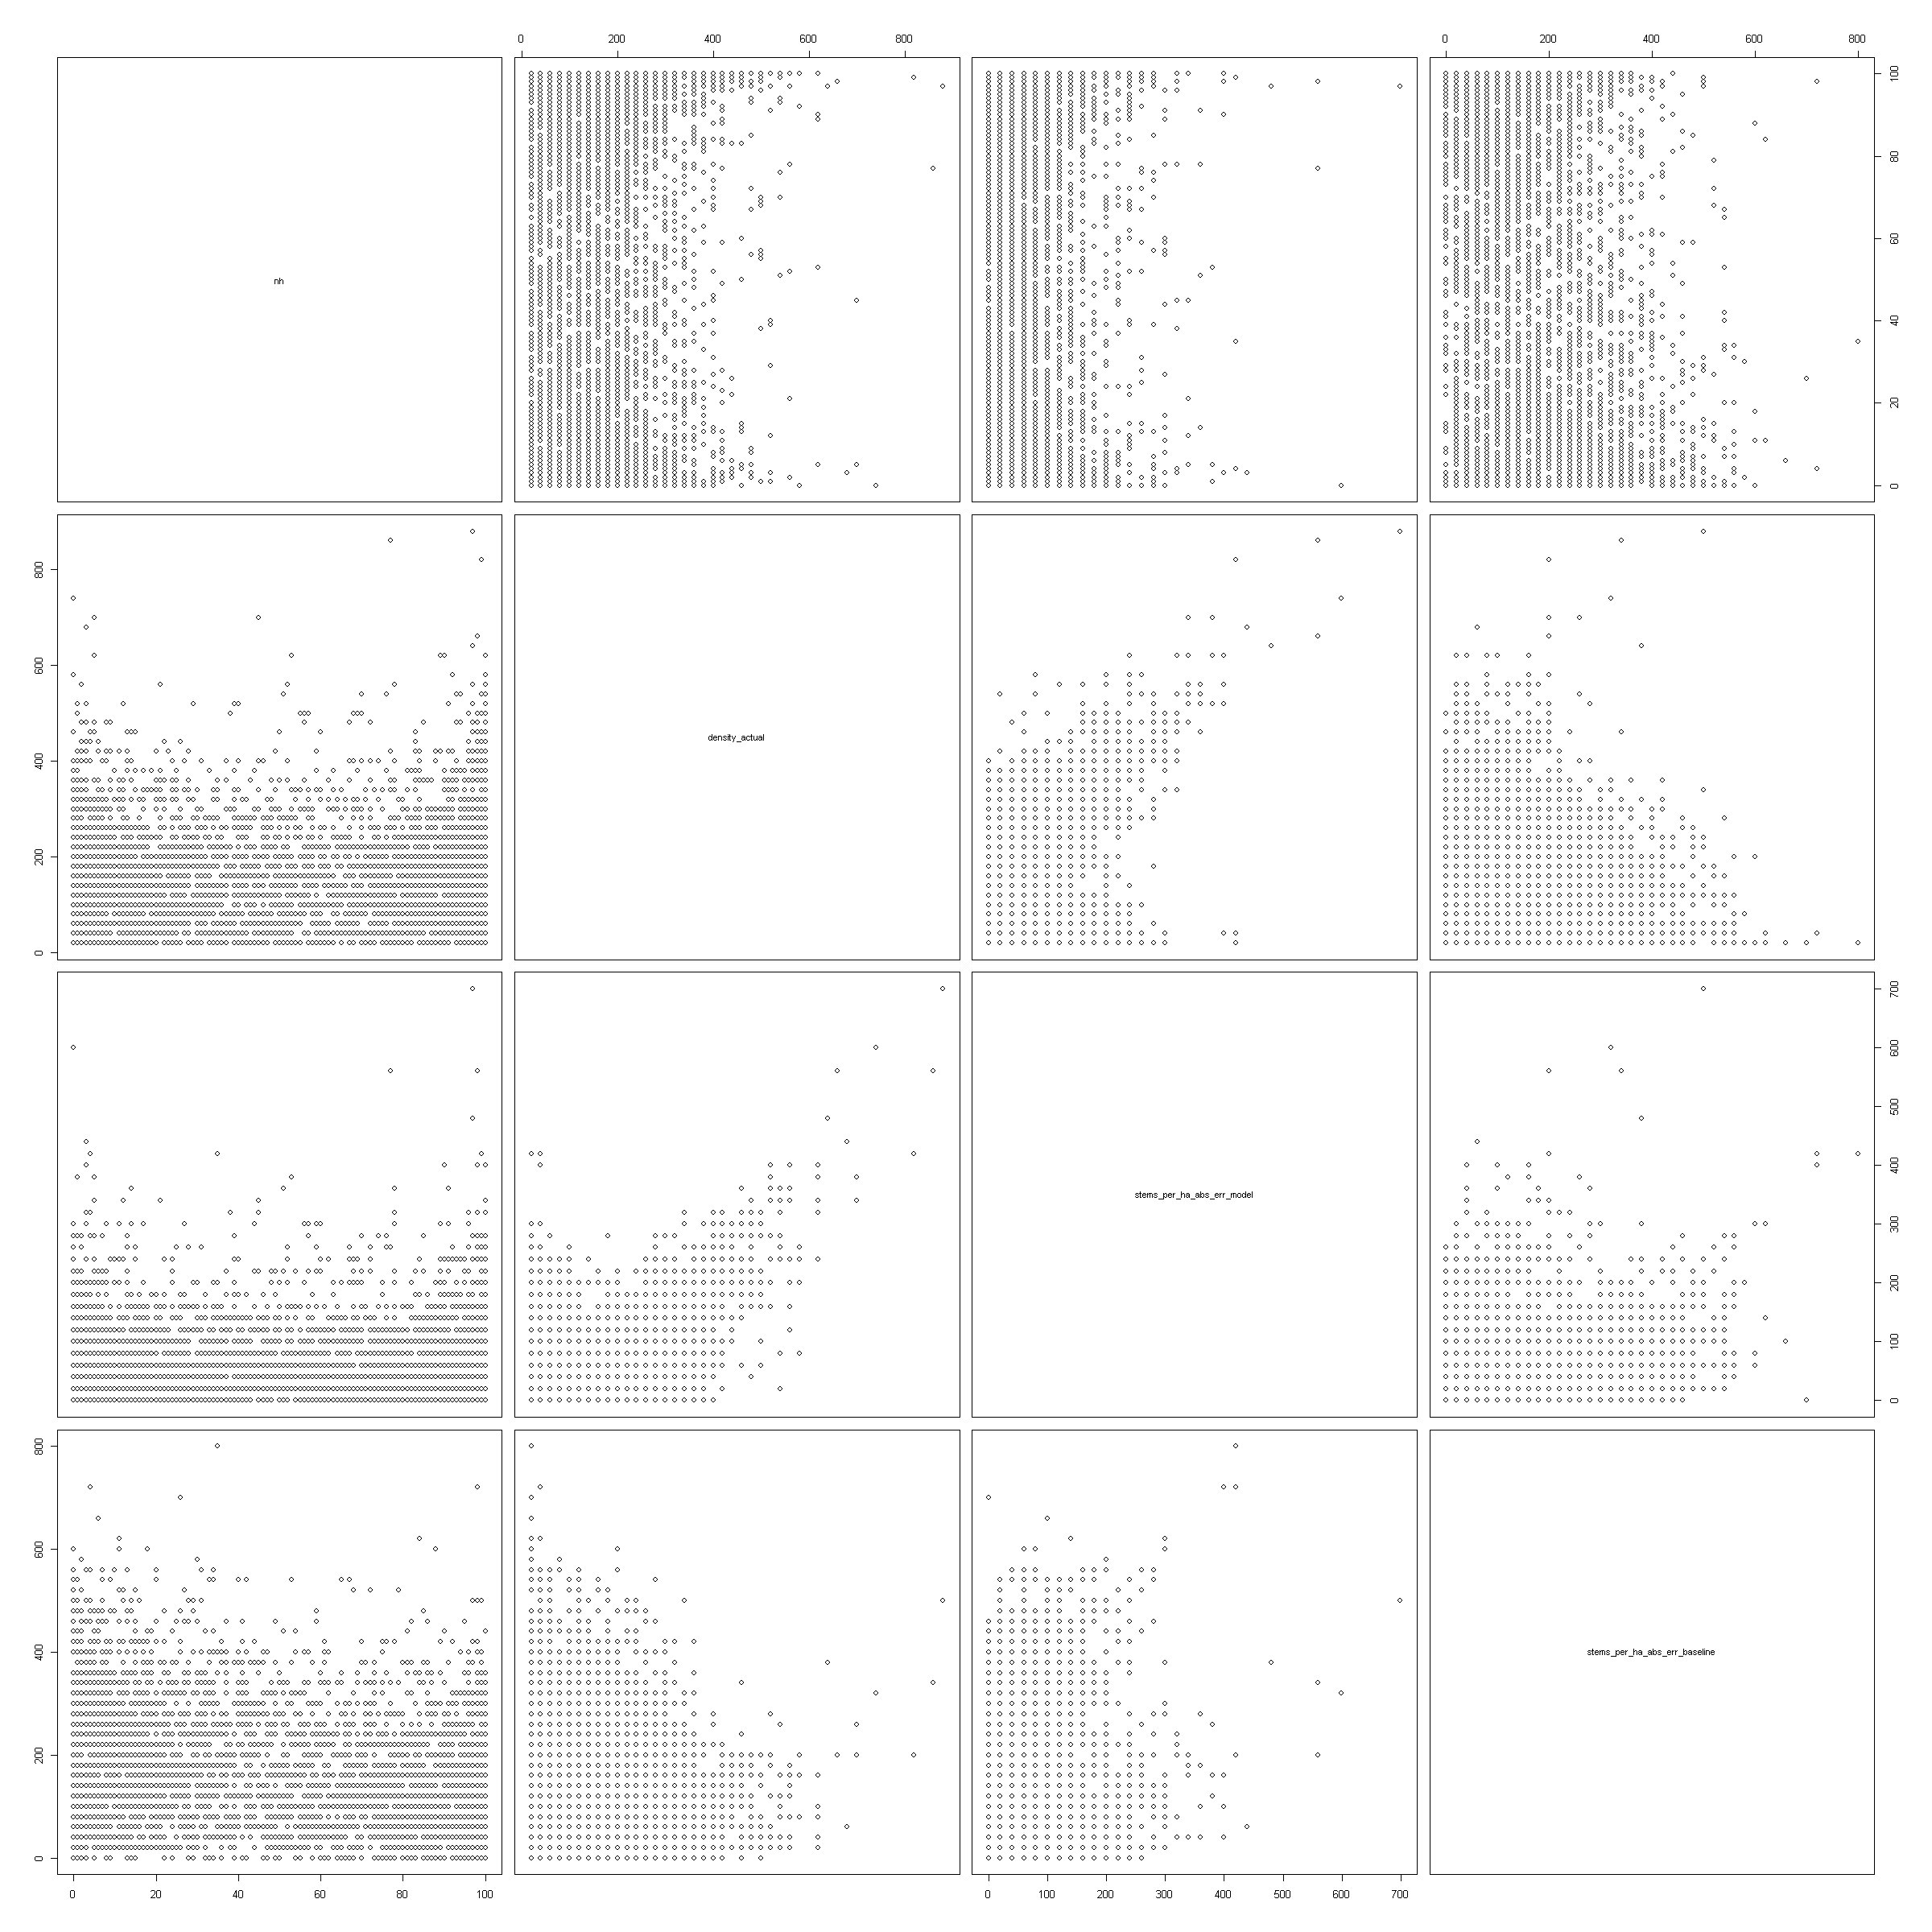

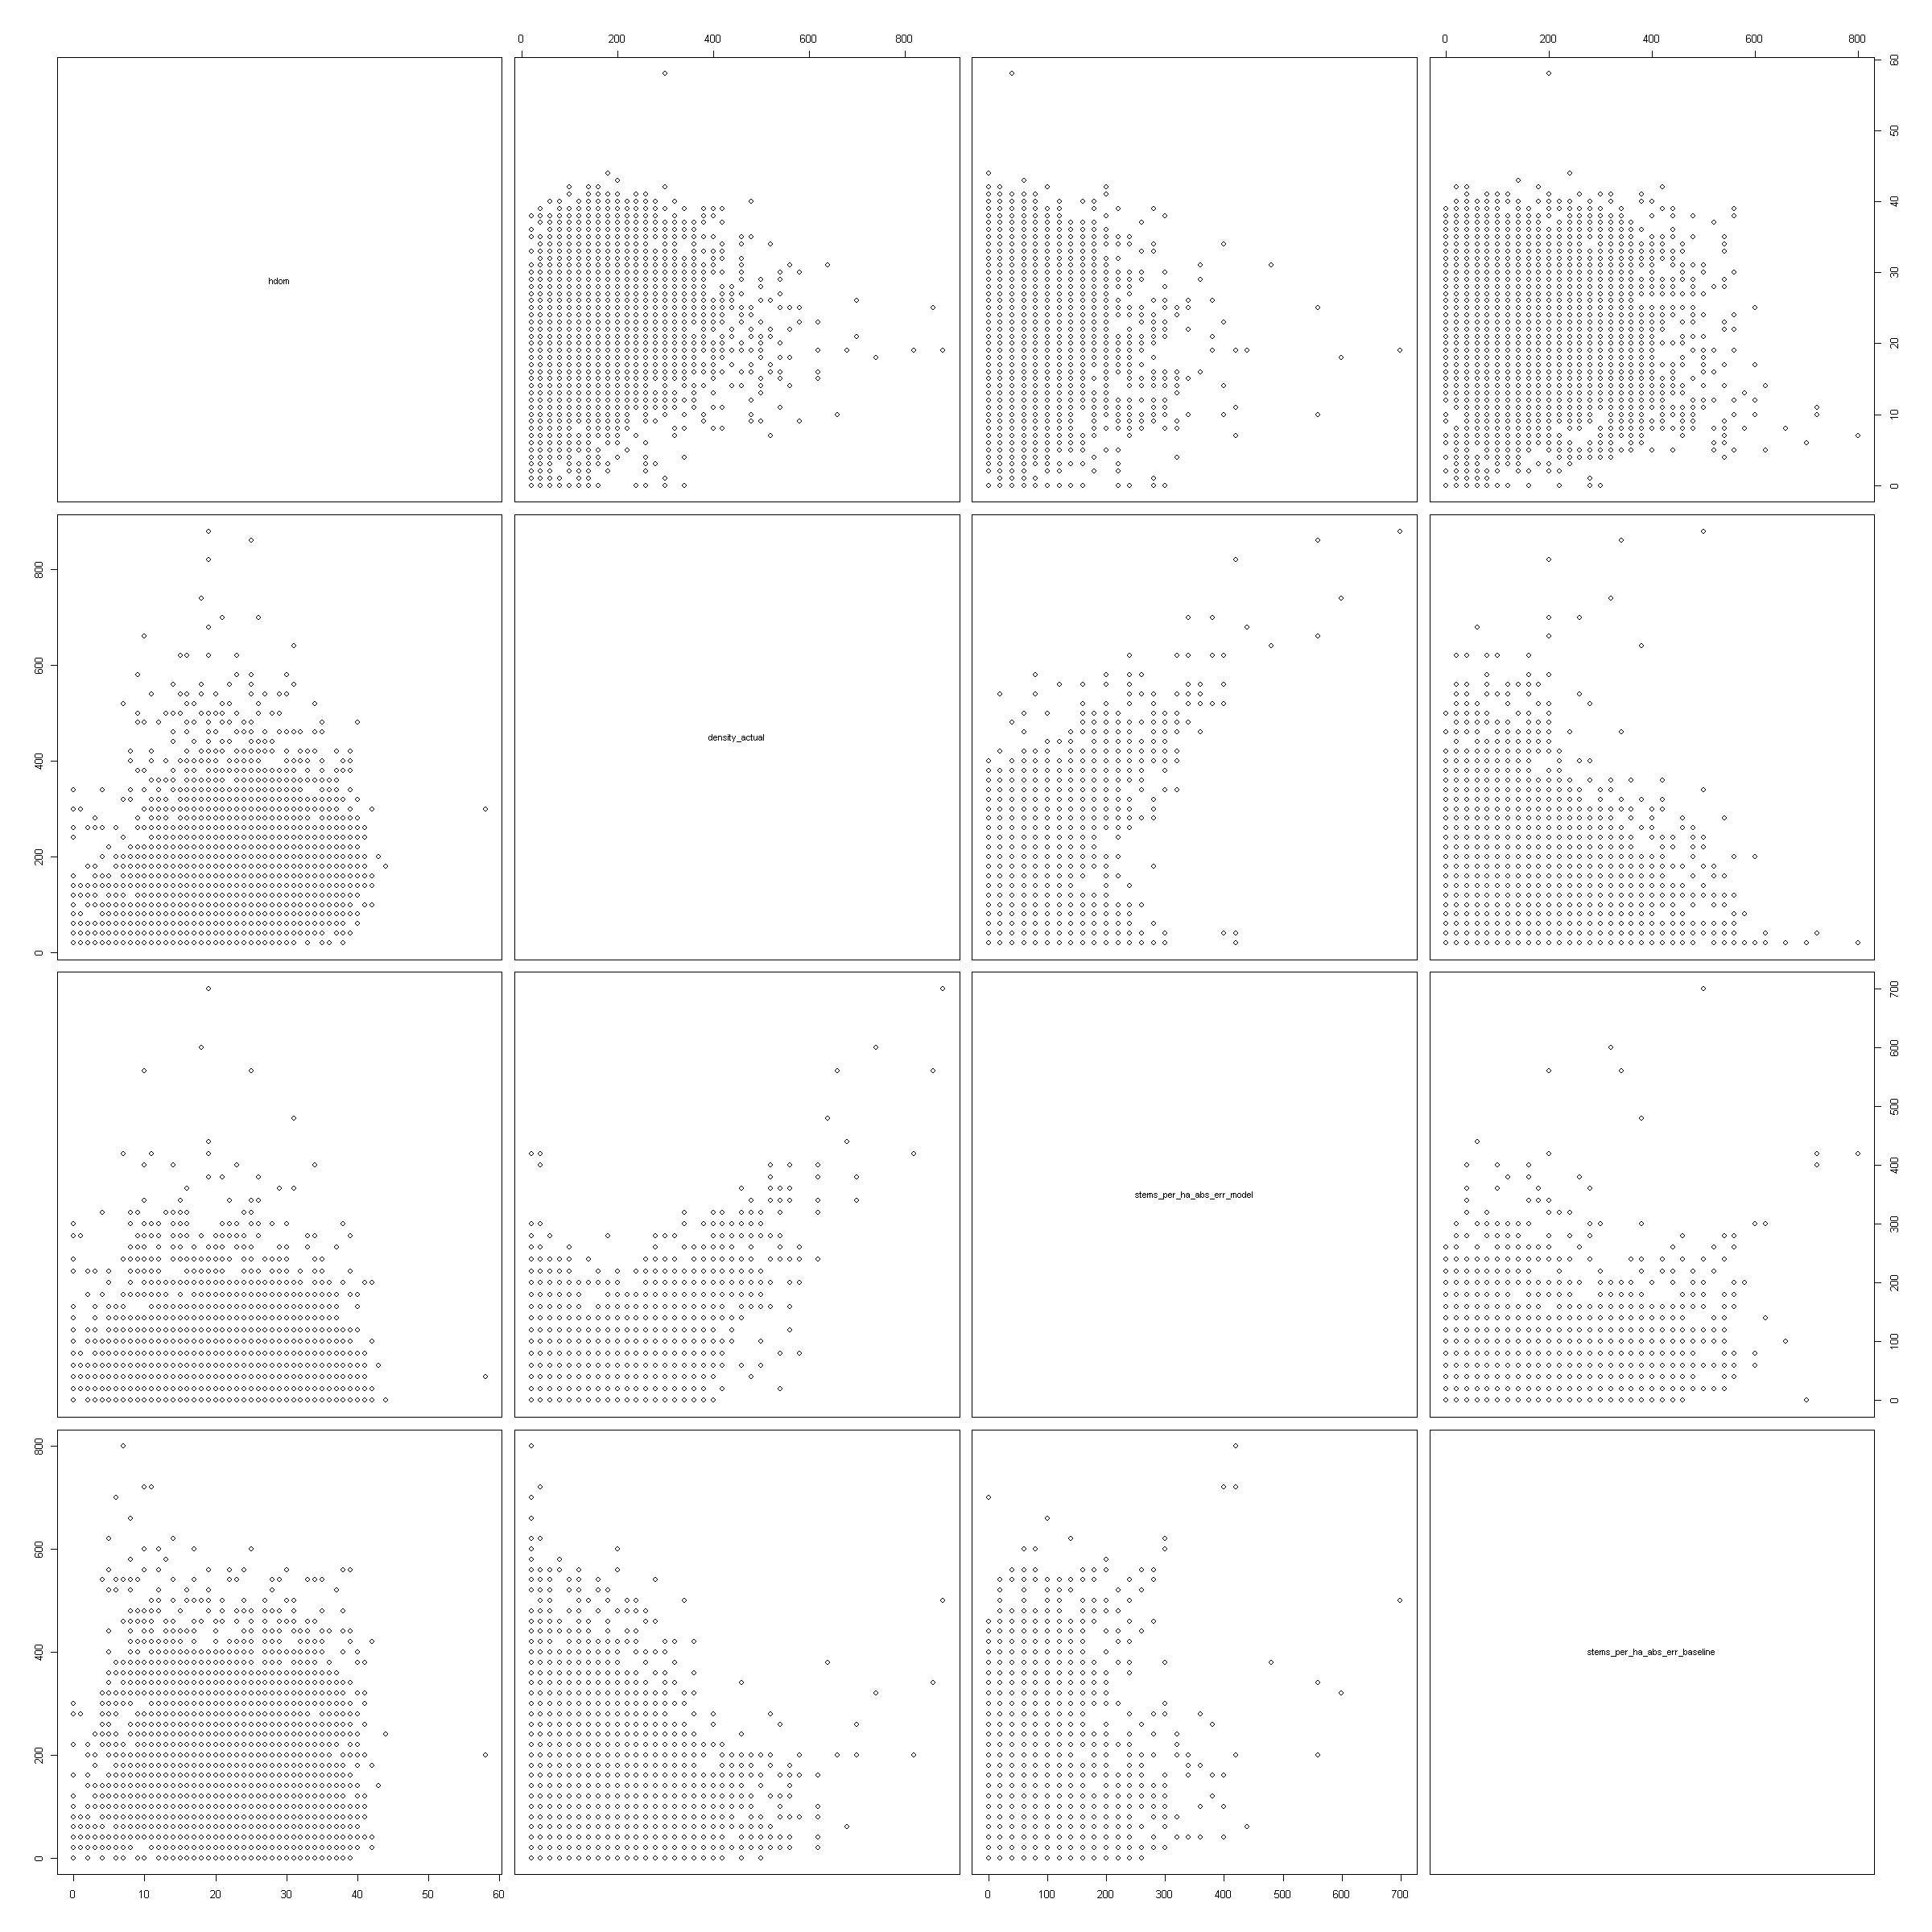

In [78]:
# Some pair plots
options(repr.plot.width=20, repr.plot.height=20)

pairs(data[,c( 'dg', 'nh', 'hdom', 'density_actual')])

pairs(data[,c( 'dg', 'density_actual', 'stems_per_ha_abs_err_model', 'stems_per_ha_abs_err_baseline')])
pairs(data[,c( 'nh', 'density_actual', 'stems_per_ha_abs_err_model', 'stems_per_ha_abs_err_baseline')])
pairs(data[,c( 'hdom', 'density_actual', 'stems_per_ha_abs_err_model', 'stems_per_ha_abs_err_baseline')])

In [79]:
# Number of Plots by NH Class
data %>%
group_by(fst_nh) %>%
summarise(n = n(), per = n()/nrow(data))

# Number of Plots by DC Class
data %>%
group_by(fst_dg) %>%
summarise(n = n(), per = n()/nrow(data))

# Number of Plots by HDOM Class
data %>%
group_by(fst_hdom) %>%
summarise(n = n(), per = n()/nrow(data))

fst_nh n    per      
1 1      1853 0.3526837
2 2       978 0.1861439
3 3      2423 0.4611724

fst_dg n    per      
1 1      3362 0.6398934
2 2      1892 0.3601066

fst_hdom n    per      
1 1        2383 0.4535592
2 2        2871 0.5464408

In [80]:
# Build a data frame for box plots
df <- do.call( "rbind",list(
    data.frame(fst_dg=data$fst_dg,fst_nh=data$fst_nh,fst_hdom=data$fst_hdom, variable="density_actual", value=data$density_actual ),
    data.frame(fst_dg=data$fst_dg,fst_nh=data$fst_nh,fst_hdom=data$fst_hdom, variable="stems_per_ha_err_baseline", value=data$stems_per_ha_err_baseline ),
    data.frame(fst_dg=data$fst_dg,fst_nh=data$fst_nh,fst_hdom=data$fst_hdom, variable="stems_per_ha_err_model", value=data$stems_per_ha_err_model ),
    data.frame(fst_dg=data$fst_dg,fst_nh=data$fst_nh,fst_hdom=data$fst_hdom, variable="stems_per_ha_abs_err_baseline", value=data$stems_per_ha_abs_err_baseline ),
    data.frame(fst_dg=data$fst_dg,fst_nh=data$fst_nh,fst_hdom=data$fst_hdom, variable="stems_per_ha_abs_err_model", value=data$stems_per_ha_abs_err_model )
    ))


In [81]:
df$nh_label <- unlist(lapply(df$fst_nh, function(x) nh_lookup_labels$val[x]))       
df$dg_label <- unlist(lapply(df$fst_dg, function(x) dg_lookup_labels$val[x]))
df$hdom_label <- unlist(lapply(df$fst_hdom, function(x) hdom_lookup_labels$val[x]))


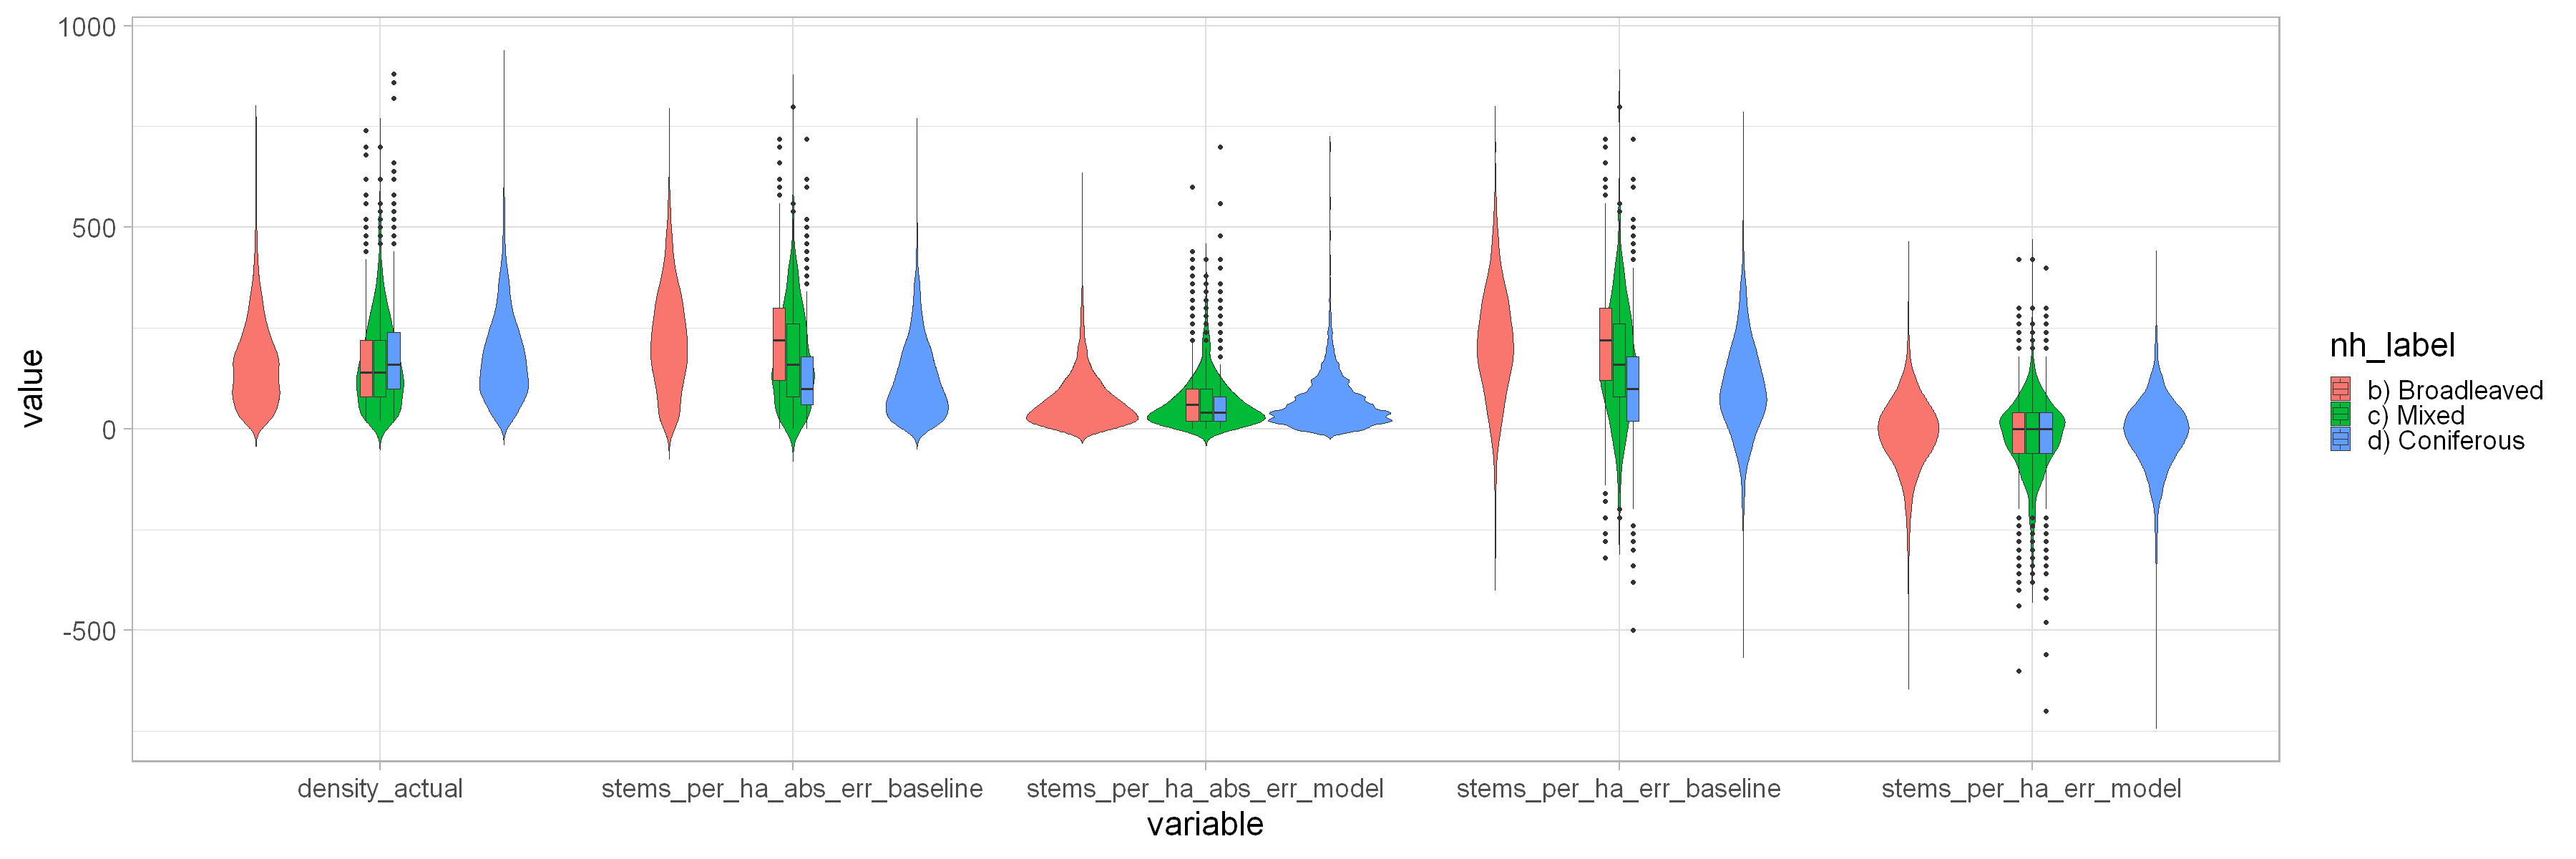

In [82]:
# Differentiated by mixing degree classes 1: nh<=30% ; 2: 30%<nh<=70% ; 3: nh>70%
options(repr.plot.width=30, repr.plot.height=10)

ggplot(df, aes(x=variable, y=value, fill=nh_label)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  theme_light(base_size = font_base_size) 


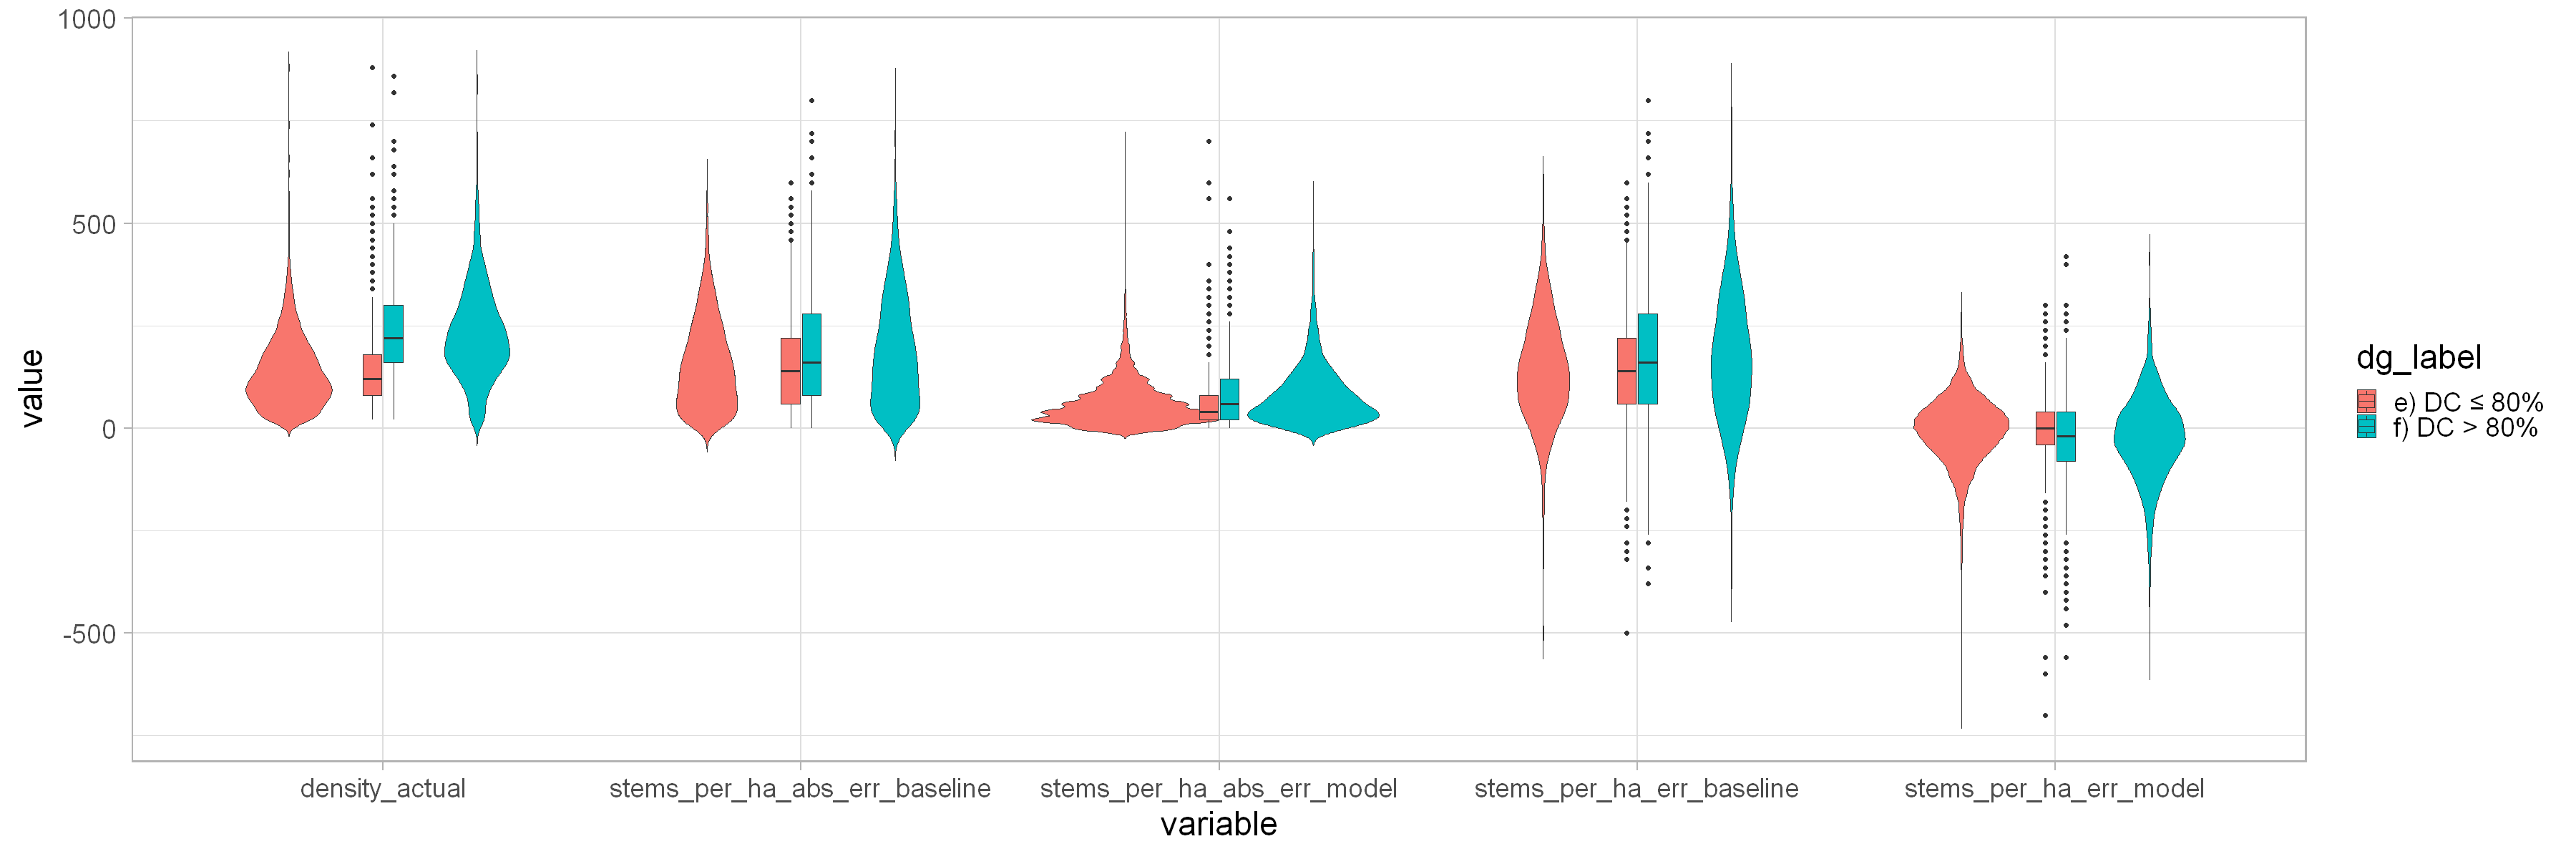

In [83]:
# Differentiated by degree of cover classes 1: dg <= 80% ; dg > 80%
options(repr.plot.width=30, repr.plot.height=10)

ggplot(df, aes(x=variable, y=value, fill=dg_label)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  theme_light(base_size = font_base_size) 

Warning message:
"Removed 7 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 7 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 110 rows containing missing values (geom_violin)."


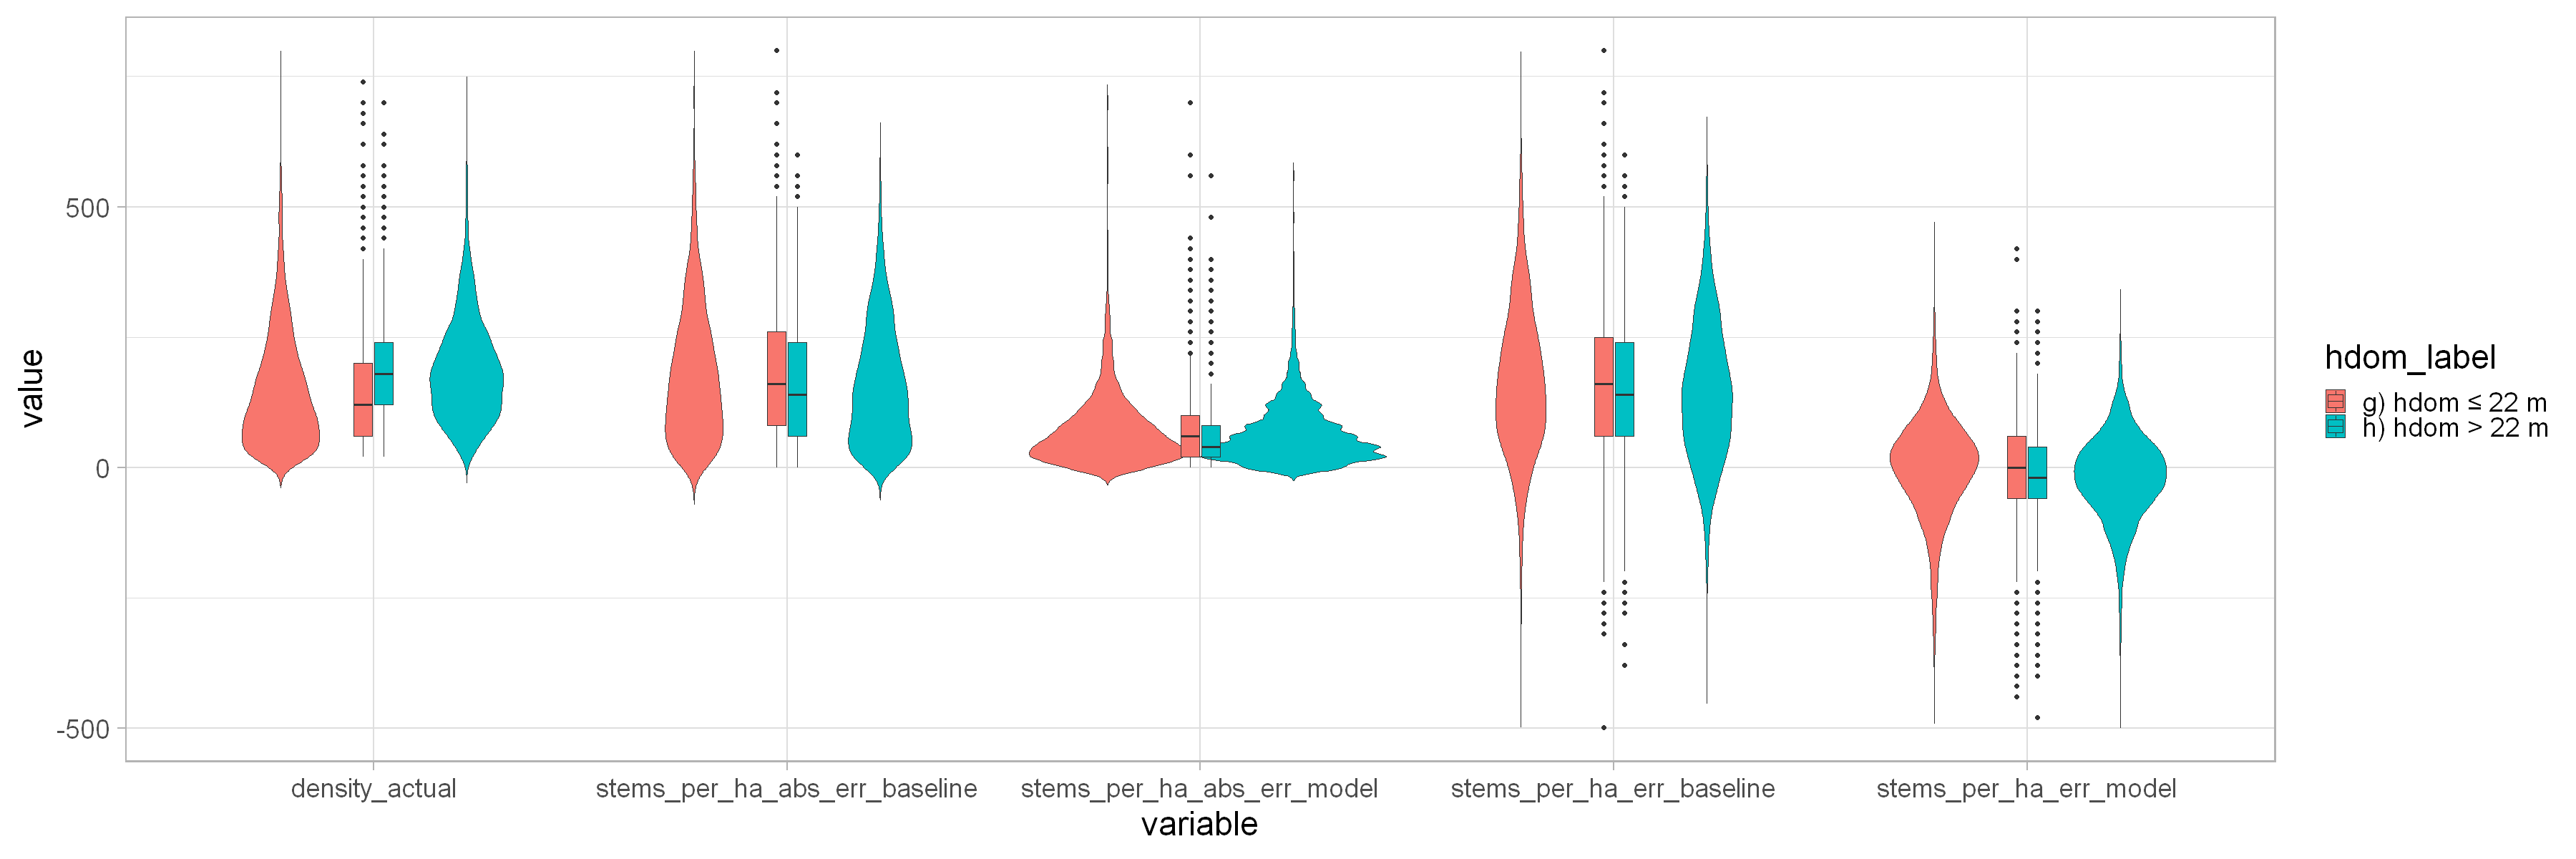

In [84]:
# Differentiated by dominant height classes 1: hdom <= 22 m ; hdom > 22 m
options(repr.plot.width=30, repr.plot.height=10)

ggplot(df, aes(x=variable, y=value, fill=hdom_label)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  ylim(-500,800) +
  theme_light(base_size = font_base_size) 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



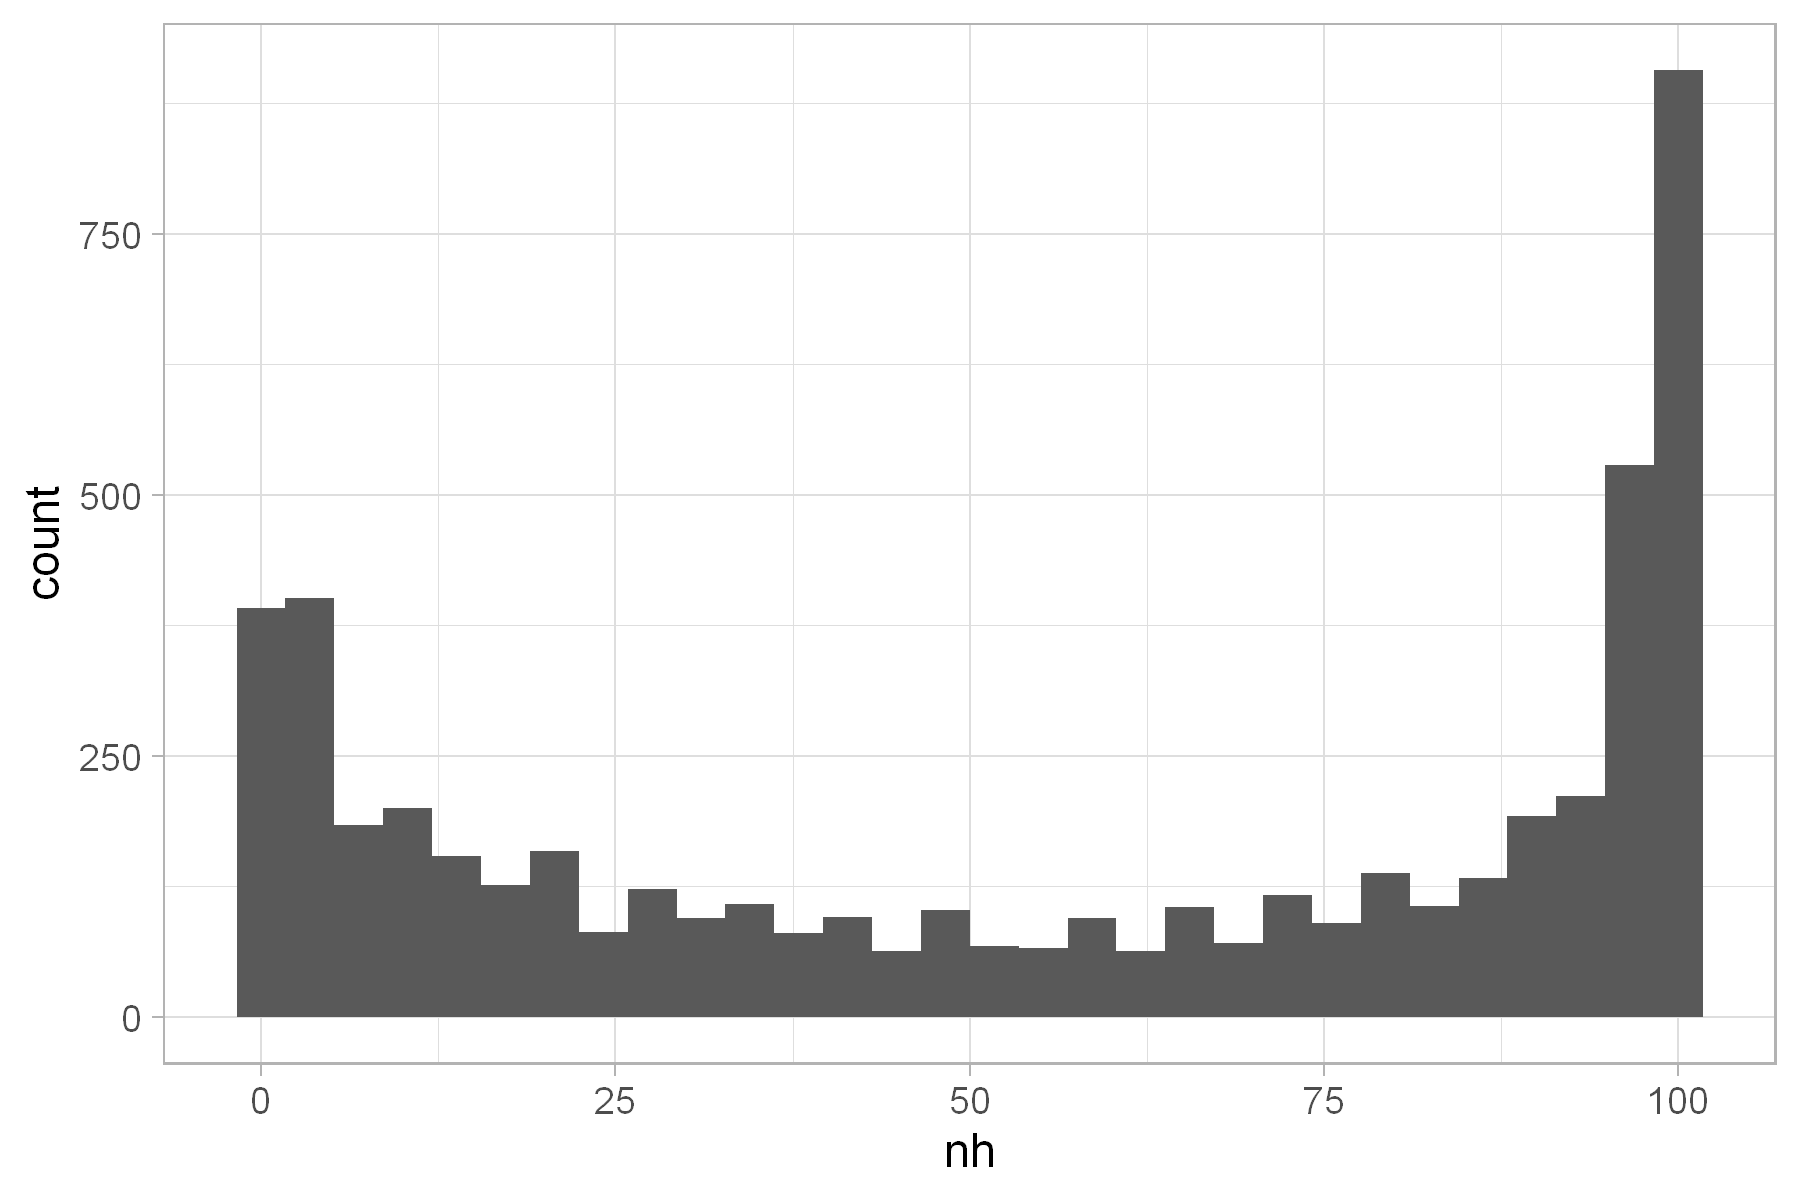

In [85]:
# Histogram of Coniferous Proportion
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=nh)) +
  geom_histogram()+
  theme_light(base_size = font_base_size) 


Warning message:
"Removed 36 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 36 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 36 rows containing missing values (geom_point)."
Warning message:
"Removed 50 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 50 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 50 rows containing missing values (geom_point)."


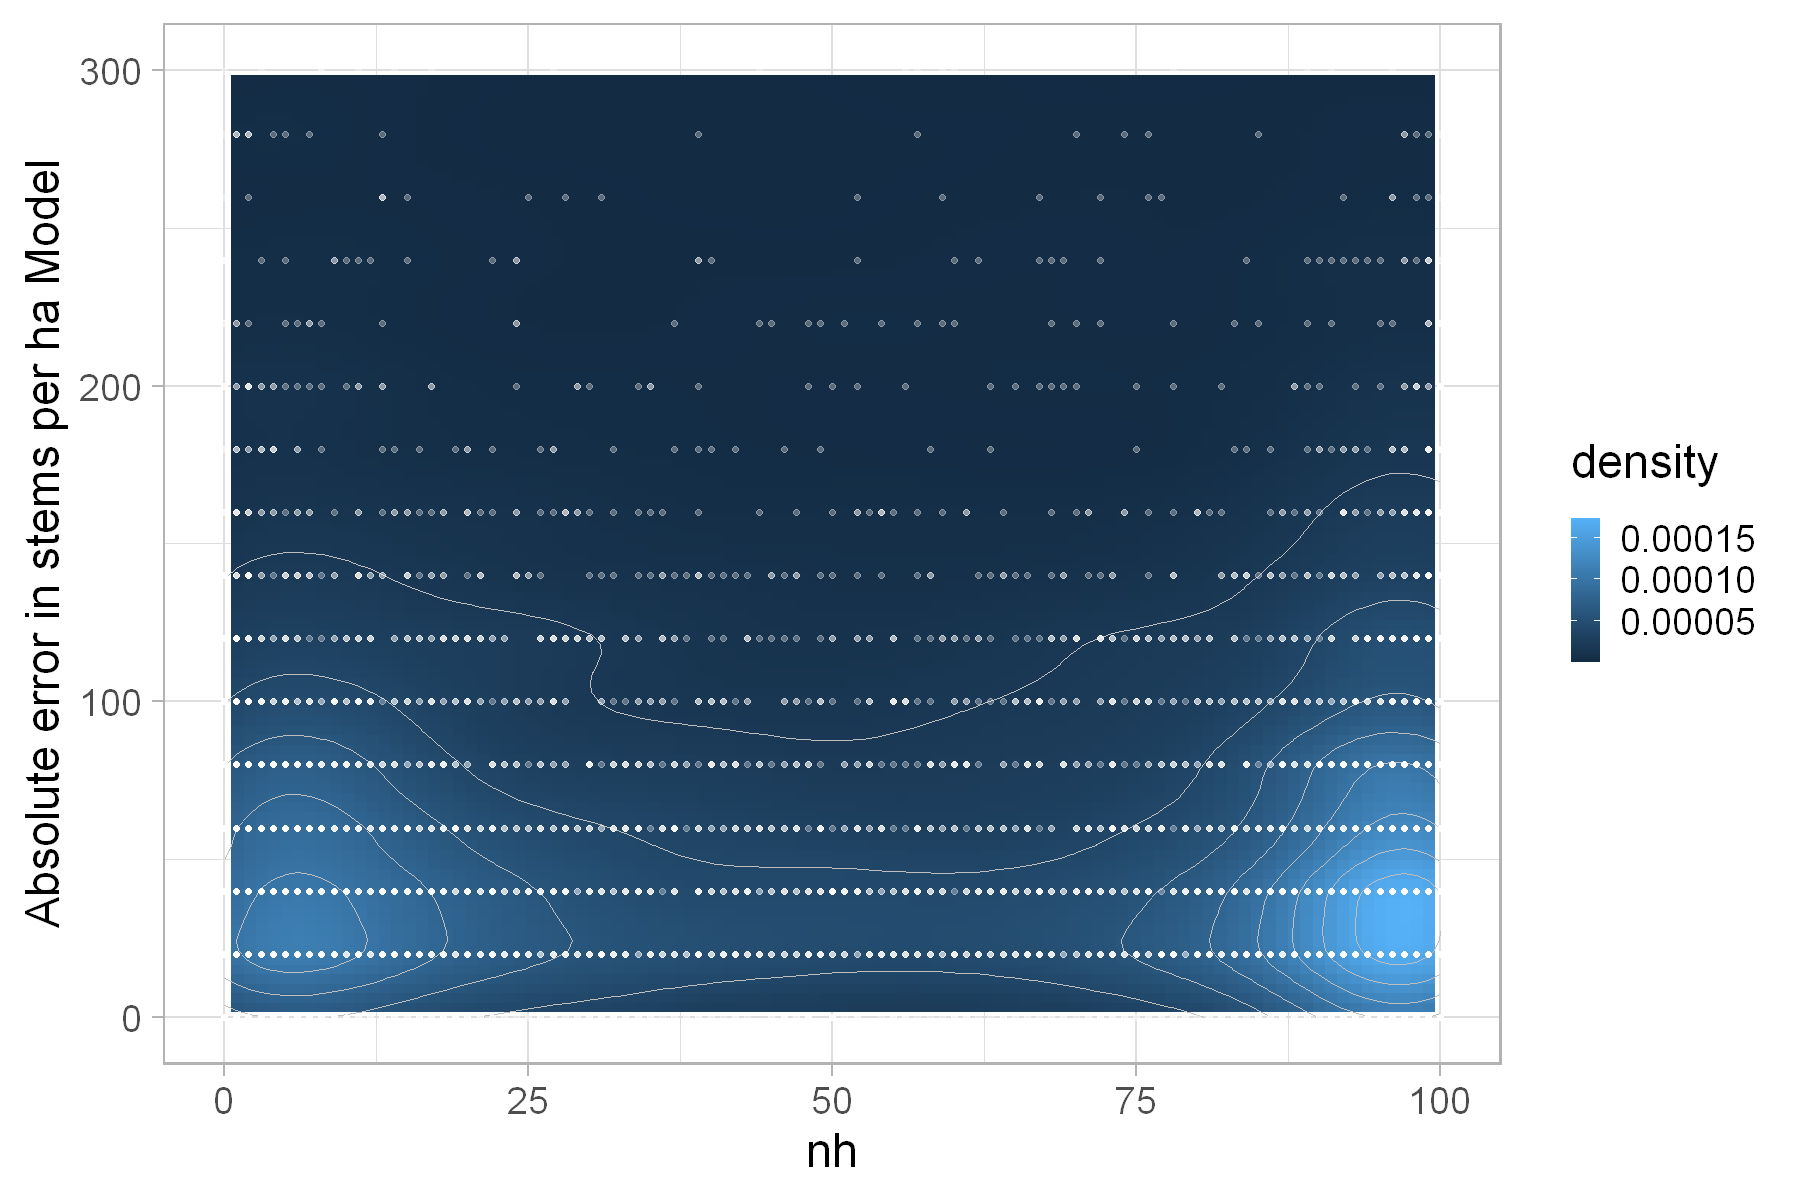

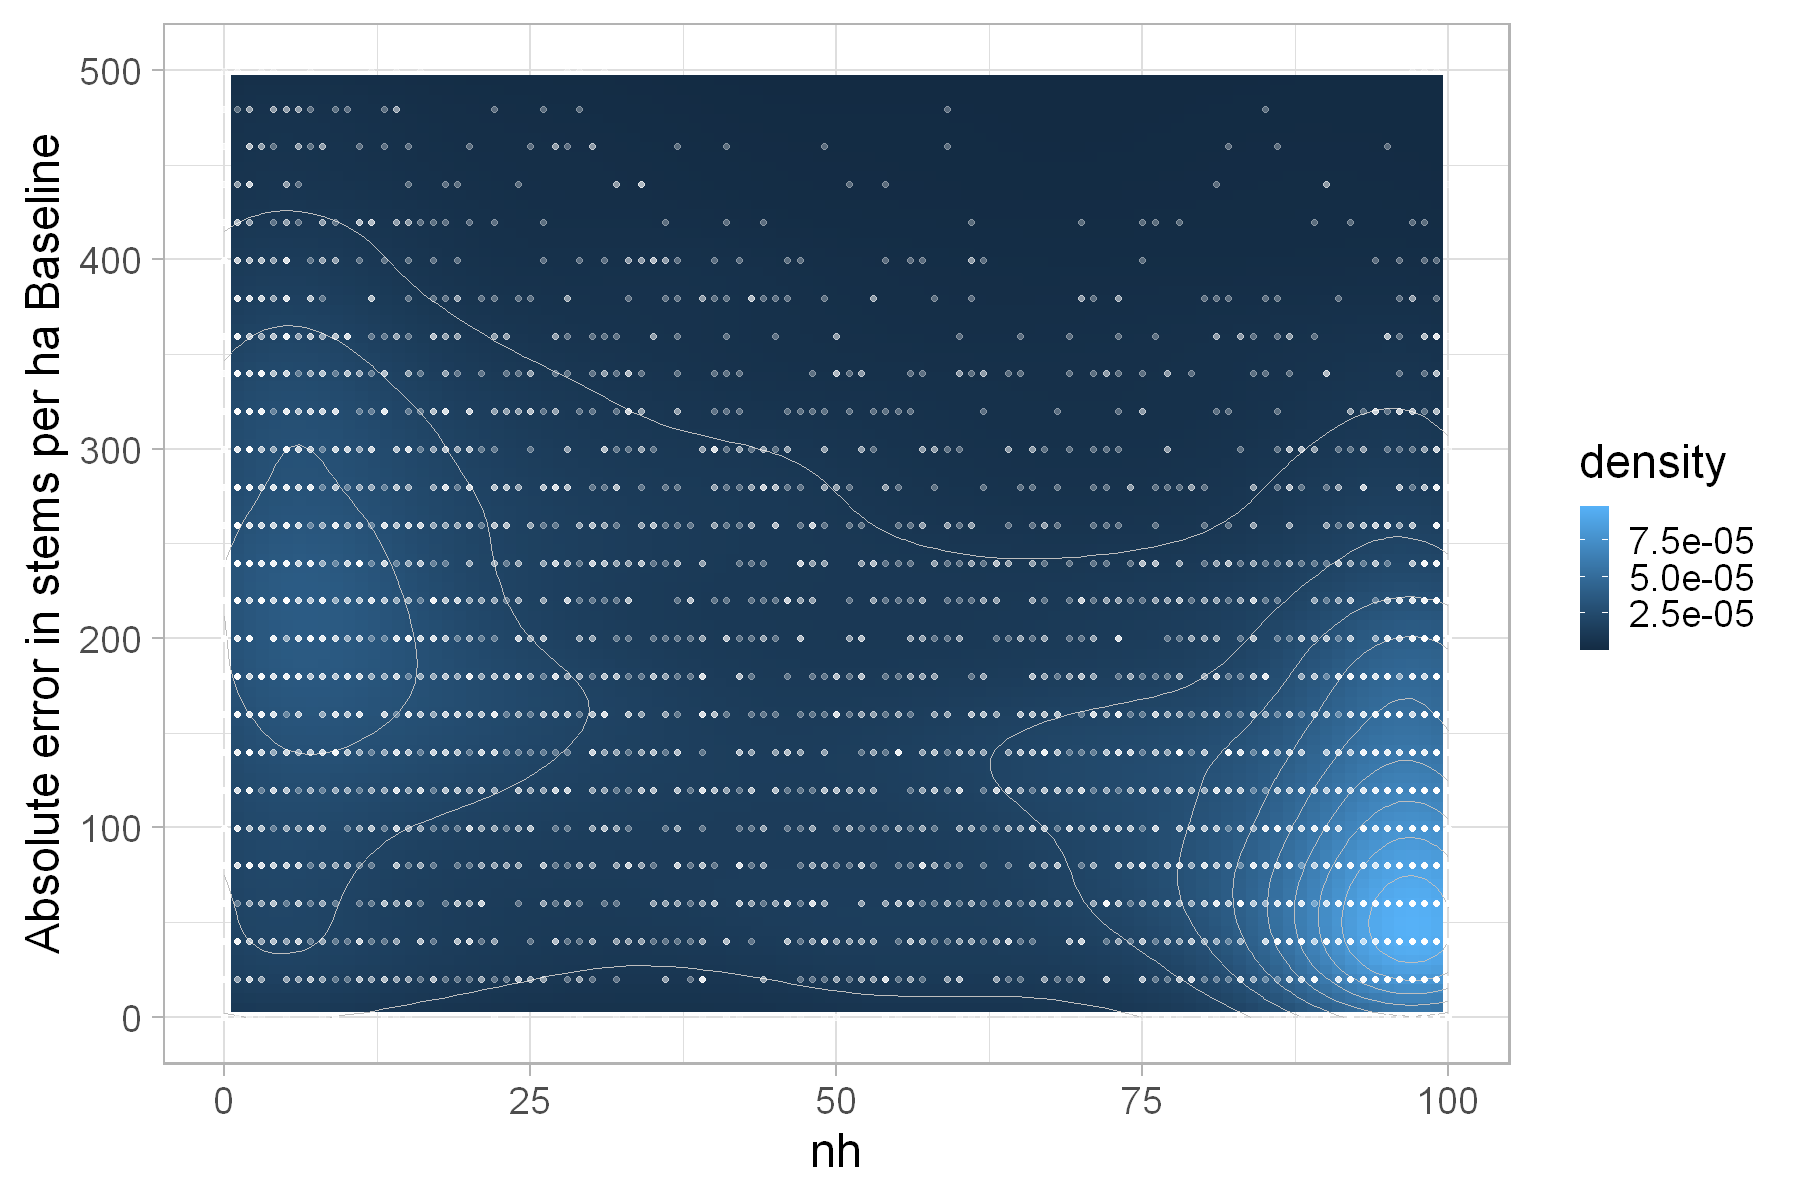

In [86]:
#Scatterplot Coniferous proportion vs Absolute Error Model
ggplot(data, aes(x=nh, y=stems_per_ha_abs_err_model)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_point(alpha=0.3, color="white") +
  xlim(0,100) +
  ylim(0,300) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error in stems per ha Model") 

#Scatterplot Coniferous proportion vs Absolute Error Baseline
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=nh, y=stems_per_ha_abs_err_baseline)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_point(alpha=0.3, color="white") +
  xlim(0,100) +
  ylim(0,500) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error in stems per ha Baseline") 


Warning message:
"Removed 20 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 5 rows containing non-finite values (stat_boxplot)."


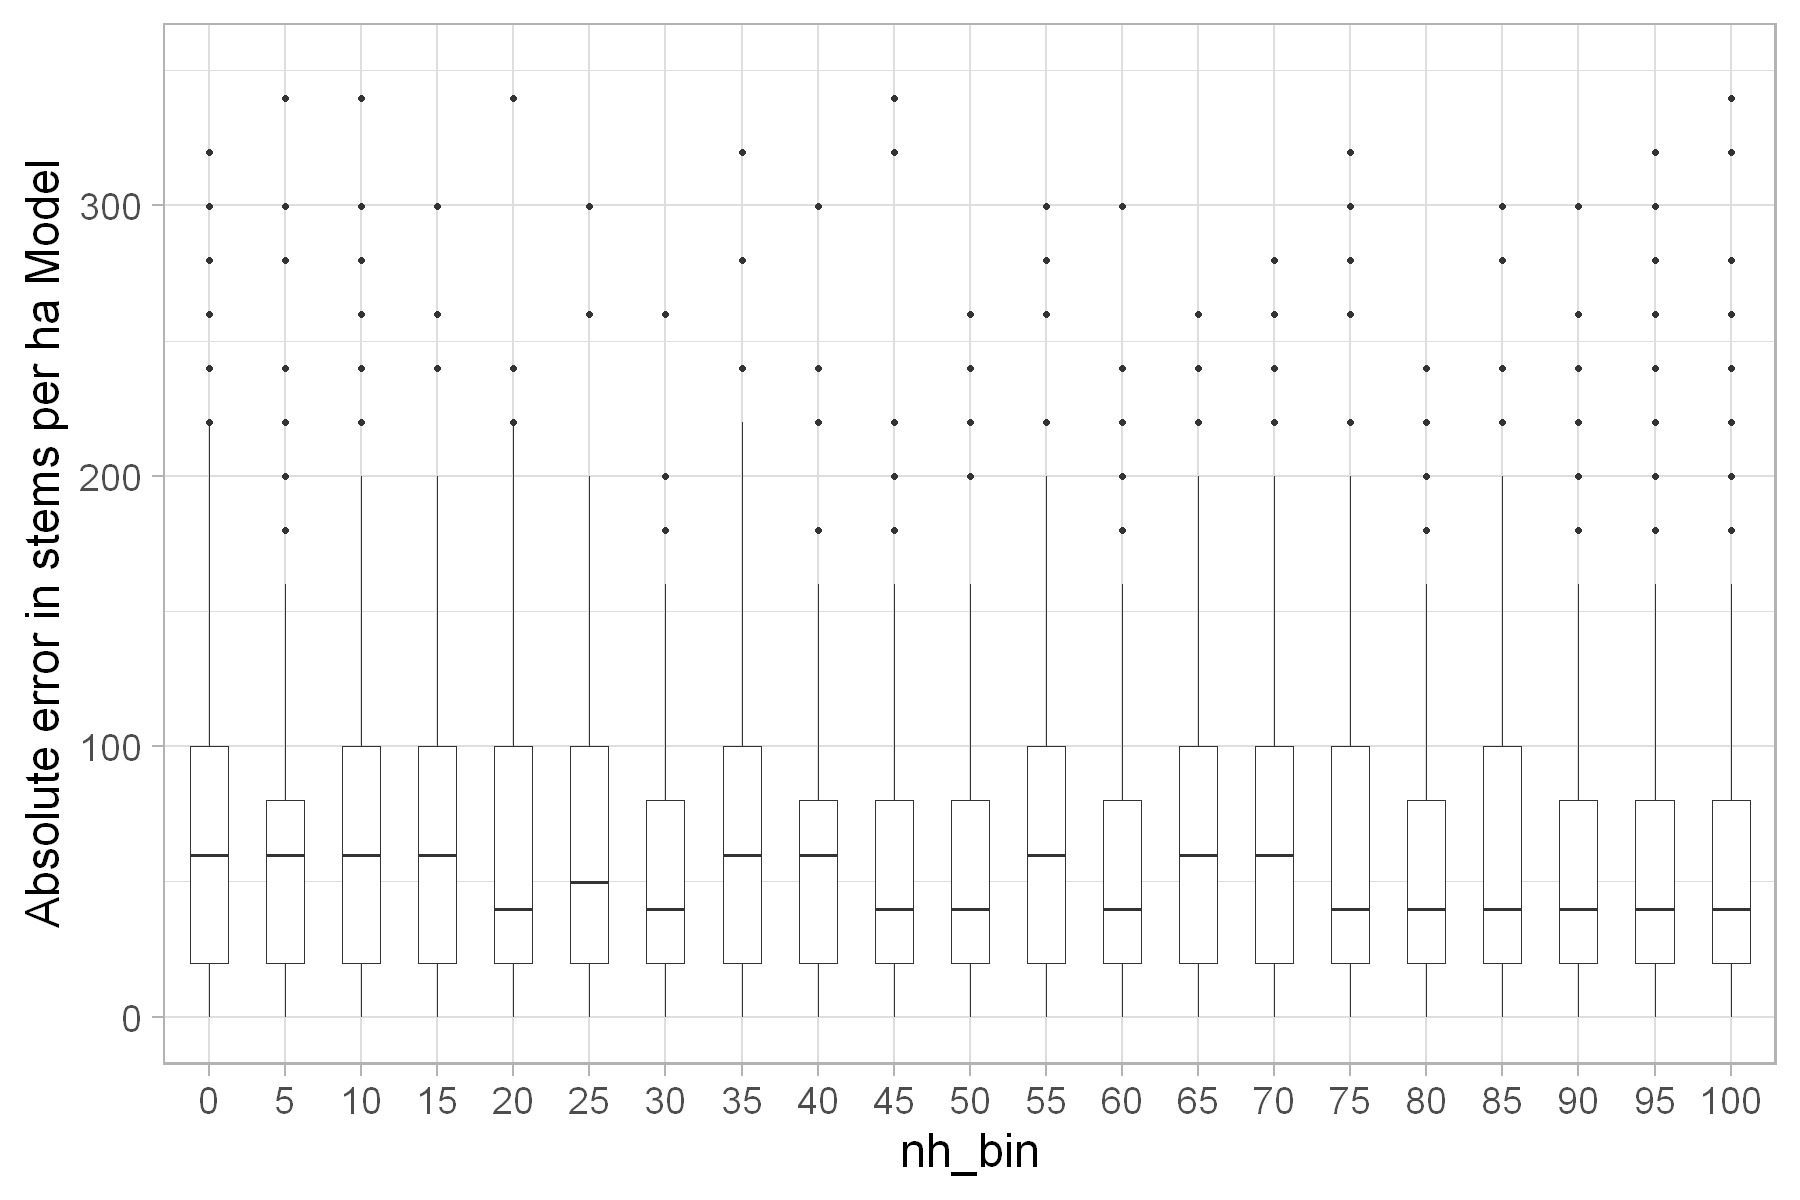

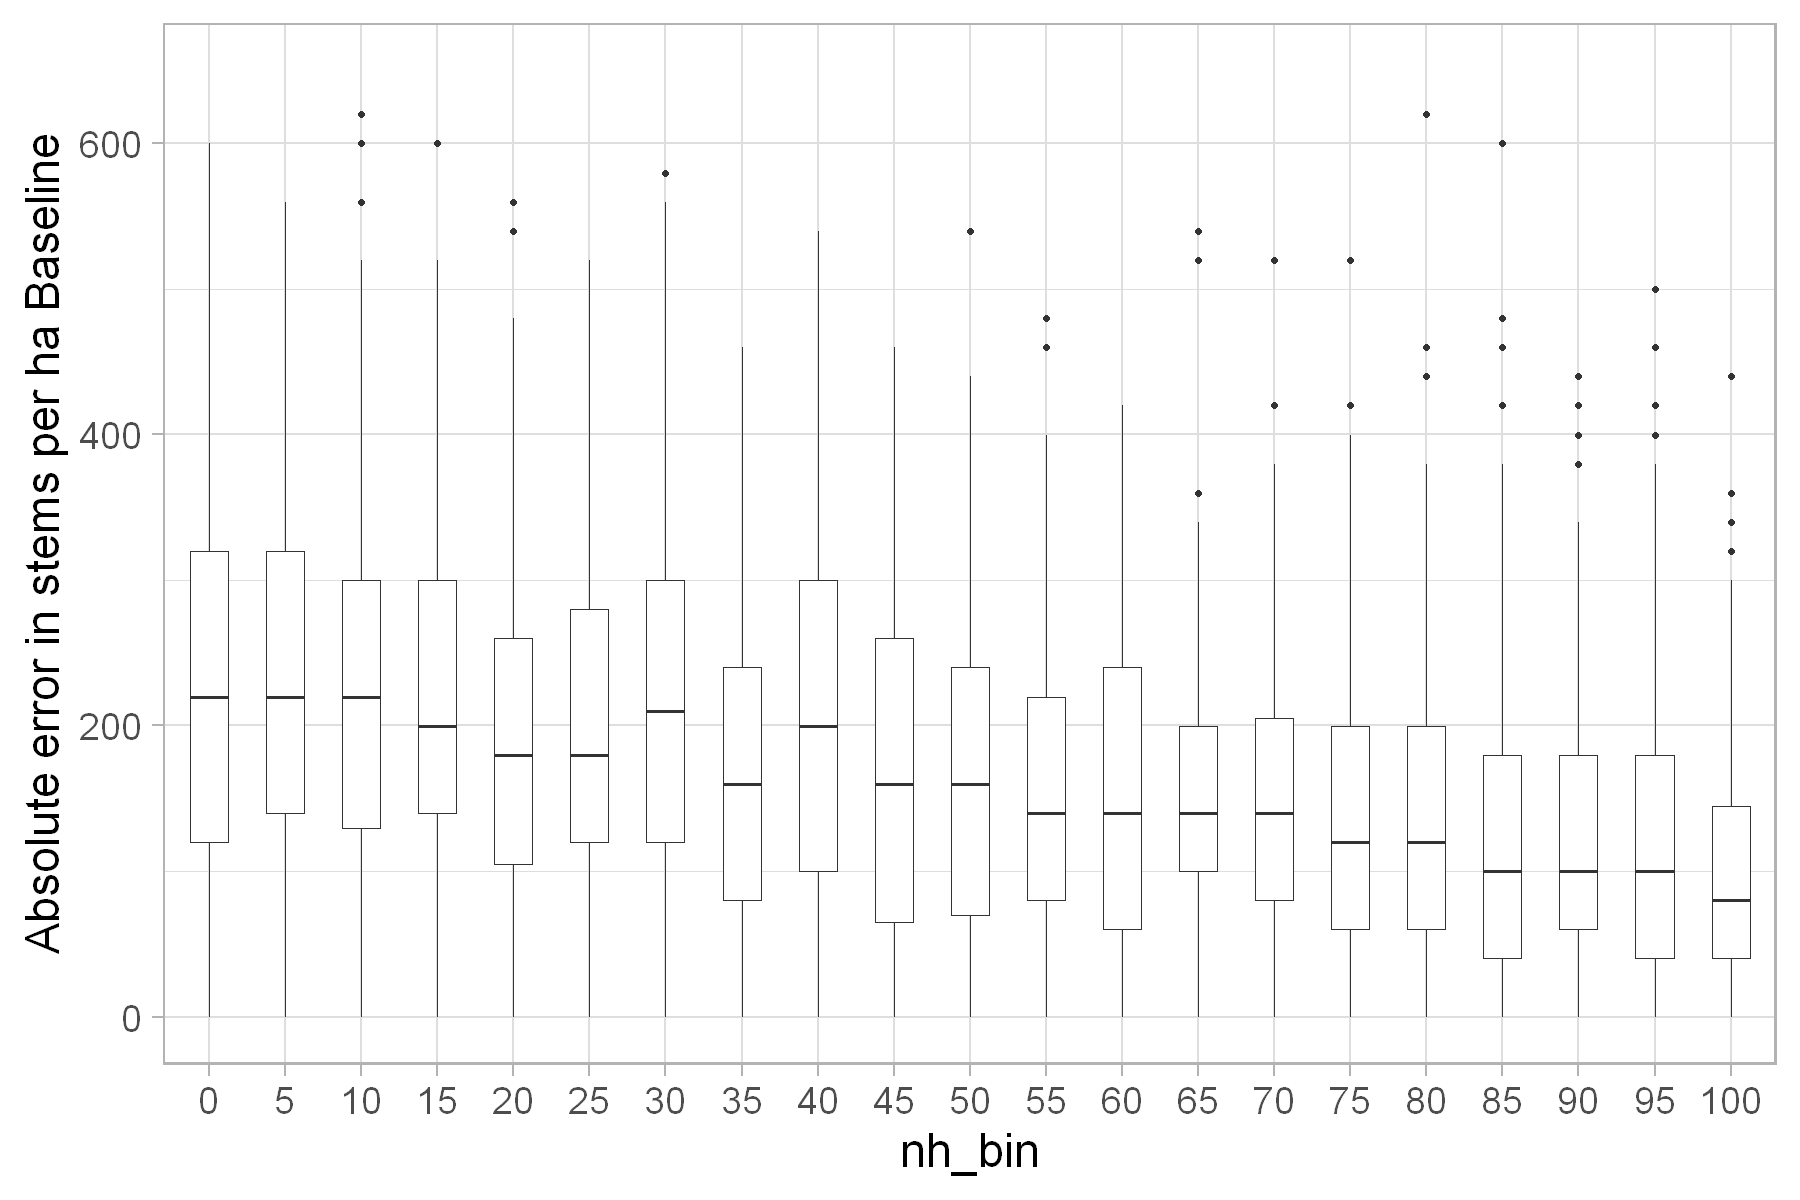

In [87]:
# Boxplots by binned coniferous proportion 0 = [0%,5%[, 5 = [5%,10%[ ...
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=nh_bin, y=stems_per_ha_abs_err_model)) +
#   geom_violin(trim=FALSE)+
  geom_boxplot(width=0.5)+
  ylim(0,350) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error in stems per ha Model") 

# Boxplots by binned coniferous proportion 0 = [0%,5%[, 5 = [5%,10%[ ...
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=nh_bin, y=stems_per_ha_abs_err_baseline)) +
#   geom_violin(trim=FALSE)+
  geom_boxplot(width=0.5)+
  ylim(0,650) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error in stems per ha Baseline") 



Warning message:
"Removed 571 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 571 rows containing non-finite values (stat_density2d)."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 571 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 571 rows containing missing values (geom_point)."
Warning message:
"Removed 1478 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 1478 rows containing non-finite values (stat_density2d)."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 1478 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 1478 rows containing missing values (geom_point)."


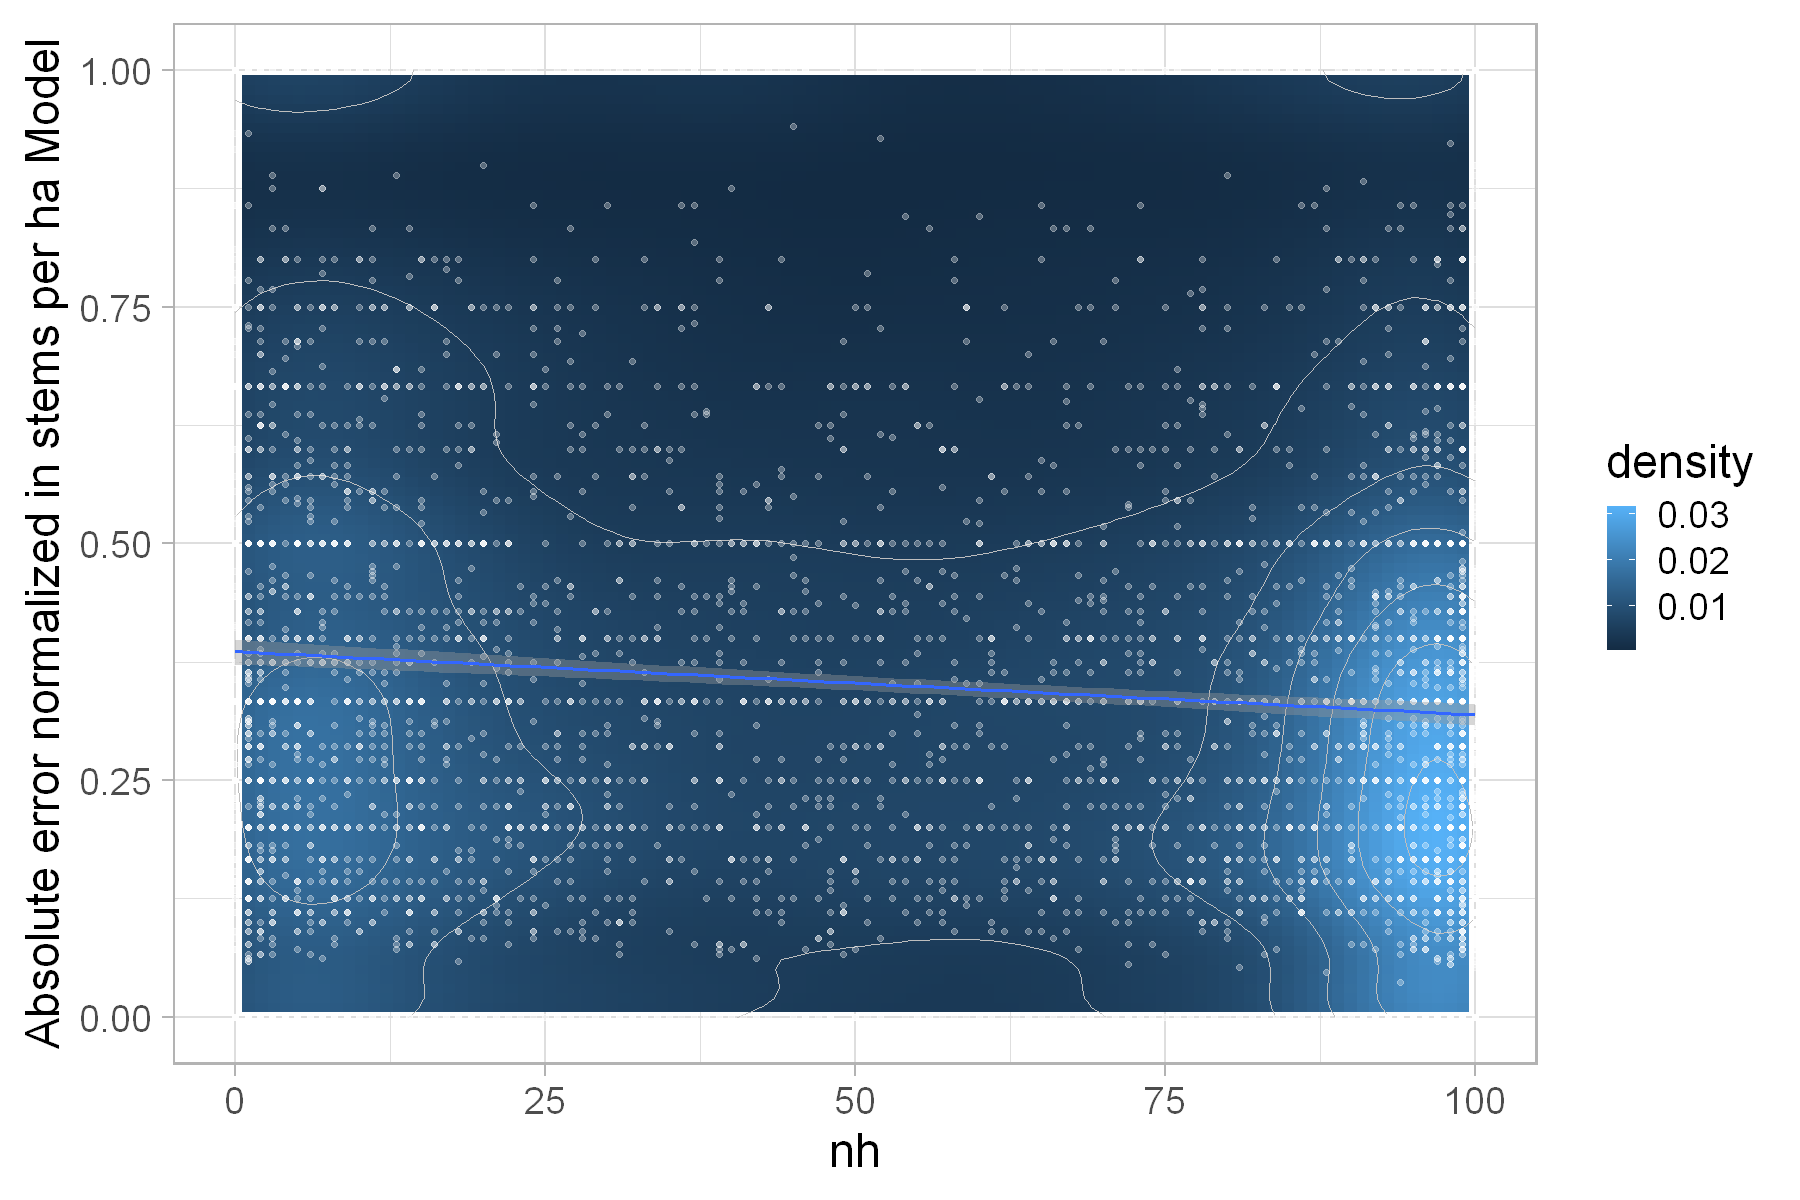

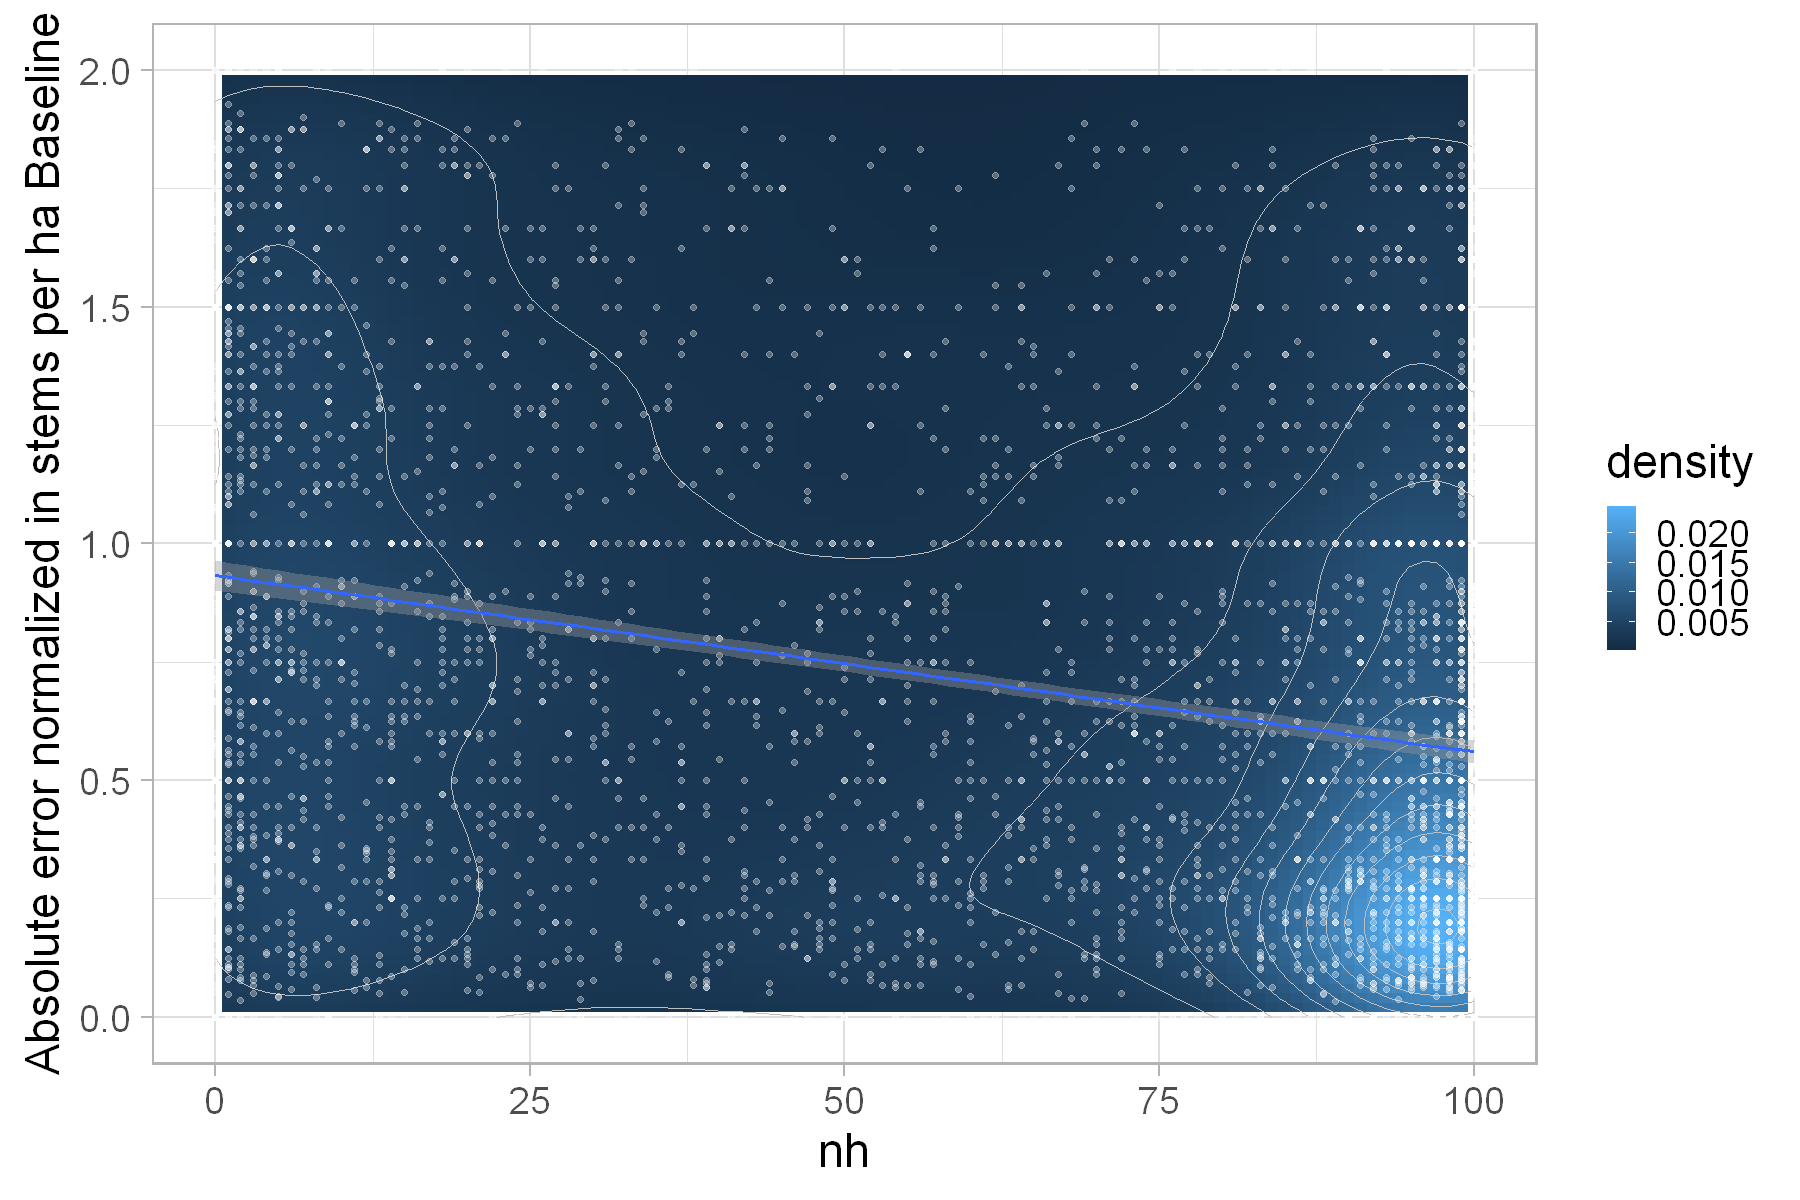

In [88]:
#Scatterplot Coniferous proportion vs Normalized Absolute Error Model
ggplot(data, aes(x=nh, y=stems_per_ha_abs_err_norm_model)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_point(alpha=0.3, color="white") +
  geom_smooth(method=lm) +
  xlim(0,100) +
  ylim(0,1) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error normalized in stems per ha Model") 

#Scatterplot Coniferous proportion vs Normalized Absolute Error Baseline
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=nh, y=stems_per_ha_abs_err_norm_baseline)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_point(alpha=0.3, color="white") +
  geom_smooth(method=lm) +
  xlim(0,100) +
  ylim(0,2) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error normalized in stems per ha Baseline") 


In [89]:
# Simple linear regression of Normalized absolute error depanding on the coniferous proporion to take a look at the significance 
lm_model <- lm(stems_per_ha_abs_err_norm_model~nh, data = data)
summary(lm_model)

lm_baseline <- lm(stems_per_ha_abs_err_norm_baseline~nh, data = data)
summary(lm_baseline)


Call:
lm(formula = stems_per_ha_abs_err_norm_model ~ nh, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7344 -0.4671 -0.2880 -0.0360 20.3241 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.7344377  0.0293643  25.011  < 2e-16 ***
nh          -0.0016736  0.0004348  -3.849  0.00012 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.205 on 5252 degrees of freedom
Multiple R-squared:  0.002813,	Adjusted R-squared:  0.002623 
F-statistic: 14.82 on 1 and 5252 DF,  p-value: 0.0001199



Call:
lm(formula = stems_per_ha_abs_err_norm_baseline ~ nh, data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-3.000 -1.447 -0.946  0.123 37.593 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.999928   0.082603   36.32   <2e-16 ***
nh          -0.016945   0.001223  -13.85   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.389 on 5252 degrees of freedom
Multiple R-squared:  0.03526,	Adjusted R-squared:  0.03507 
F-statistic: 191.9 on 1 and 5252 DF,  p-value: < 2.2e-16


Warning message:
"Removed 467 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 478 rows containing non-finite values (stat_boxplot)."


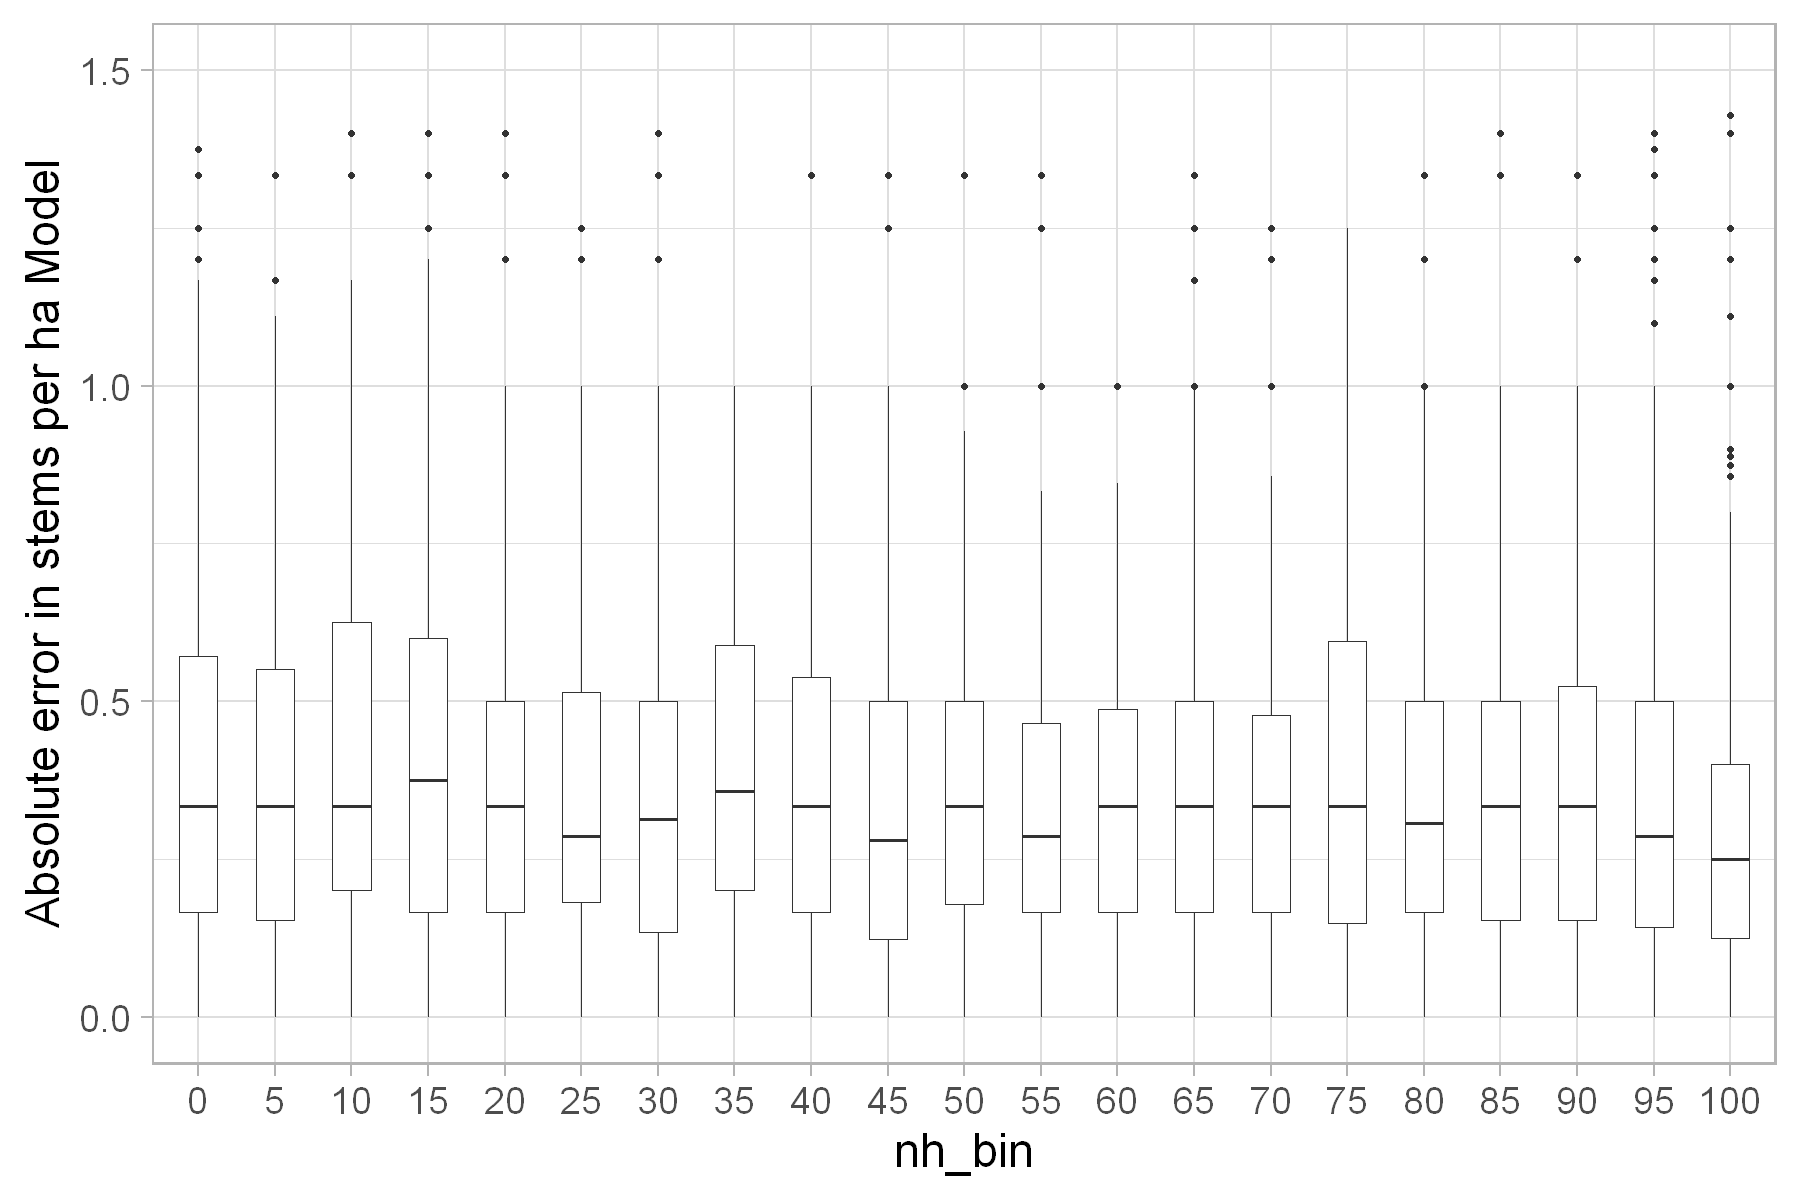

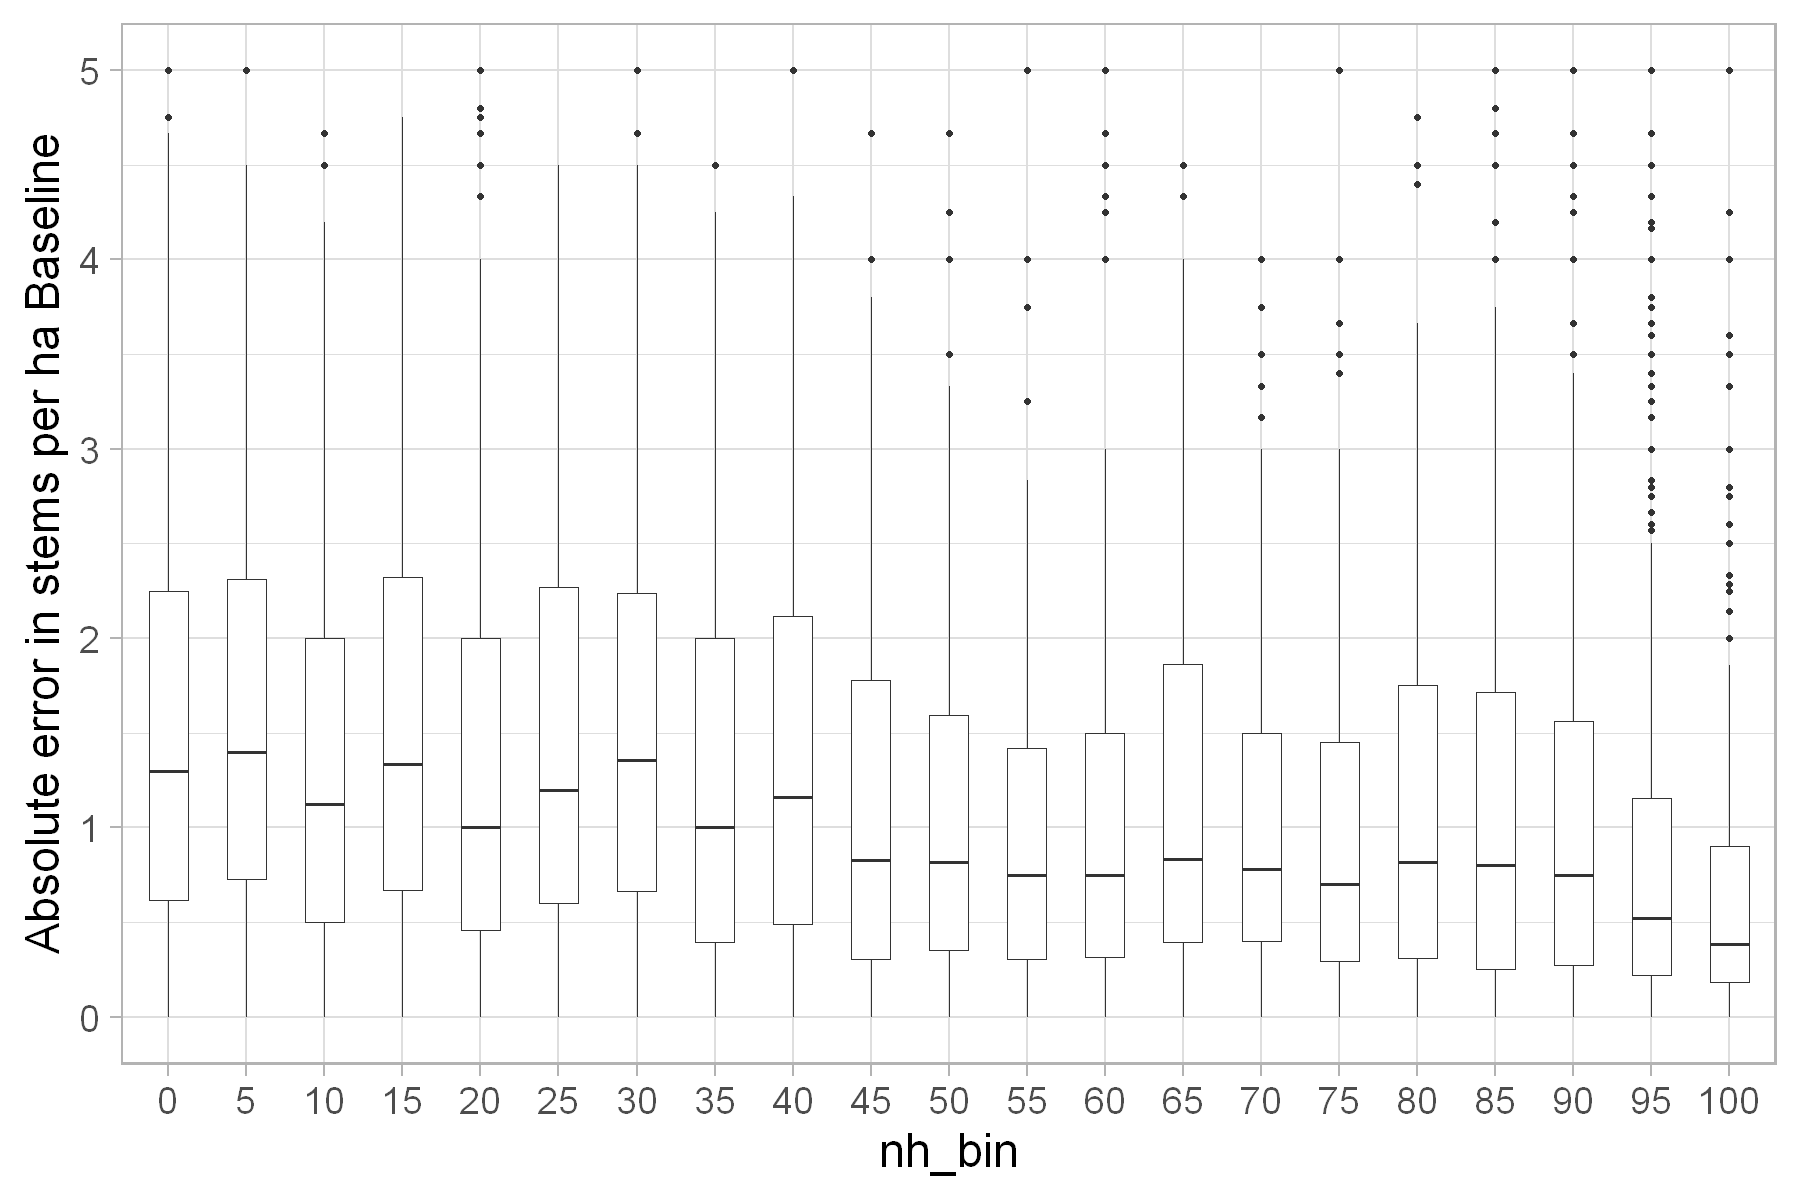

In [90]:
# Boxplots by binned coniferous proportion 0 = [0%,5%[, 5 = [5%,10%[ ...
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=nh_bin, y=stems_per_ha_abs_err_norm_model)) +
#   geom_violin(trim=FALSE)+
  geom_boxplot(width=0.5)+
   ylim(0,1.5) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error in stems per ha Model") 

# Boxplots by binned coniferous proportion 0 = [0%,5%[, 5 = [5%,10%[ ...
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=nh_bin, y=stems_per_ha_abs_err_norm_baseline)) +
#   geom_violin(trim=FALSE)+
  geom_boxplot(width=0.5)+
   ylim(0,5) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error in stems per ha Baseline") 



In [91]:
#Summary of Normalized Absolute Error by binned coniferous proportion
data %>%
  group_by(nh_bin) %>%
  summarise(mean = mean(stems_per_ha_abs_err_norm_model), median = median(stems_per_ha_abs_err_norm_model), n = n())

data %>%
  group_by(nh_bin) %>%
  summarise(mean = mean(stems_per_ha_abs_err_norm_baseline), median = median(stems_per_ha_abs_err_norm_baseline), n = n())

nh_bin mean      median    n  
1  0      0.7803088 0.3750000 691
2  5      0.5733232 0.3750000 348
3  10     0.7157828 0.3636364 239
4  15     0.6536257 0.4117647 217
5  20     0.5772886 0.3550420 178
6  25     0.5958191 0.3333333 146
7  30     0.7821522 0.3333333 158
8  35     0.7991451 0.4000000 125
9  40     0.7906291 0.3875000 116
10 45     0.5933528 0.3333333 118
11 50     0.7423149 0.3750000 115
12 55     0.7781914 0.3333333 114
13 60     0.6183544 0.3333333 114
14 65     0.6229950 0.3636364 125
15 70     0.7370796 0.3693182 144
16 75     0.7091834 0.4000000 155
17 80     0.5412952 0.3333333 179
18 85     0.7466561 0.3846154 217
19 90     0.5764980 0.3333333 319
20 95     0.6305852 0.3333333 864
21 100    0.3783830 0.2583333 572

nh_bin mean      median    n  
1  0      2.7566646 1.5000000 691
2  5      2.6456627 1.5634921 348
3  10     2.7786186 1.3076923 239
4  15     2.8364782 1.8000000 217
5  20     2.3656994 1.2613636 178
6  25     2.4362087 1.2928571 146
7  30     3.3606025 1.6000000 158
8  35     2.6905506 1.2000000 125
9  40     3.3069100 1.3250000 116
10 45     2.0834282 1.0000000 118
11 50     2.5169233 1.0000000 115
12 55     2.2191546 0.8660714 114
13 60     2.1094041 1.0000000 114
14 65     1.8295795 0.9000000 125
15 70     2.1673196 1.0000000 144
16 75     1.7937607 0.7777778 155
17 80     1.7153417 0.8750000 179
18 85     1.6856389 0.8333333 217
19 90     1.4841700 0.7500000 319
20 95     1.4135279 0.5968750 864
21 100    0.7986482 0.4000000 572

Warning message:
"Removed 91 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 91 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 91 rows containing missing values (geom_point)."
Warning message:
"Removed 618 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 618 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 618 rows containing missing values (geom_point)."


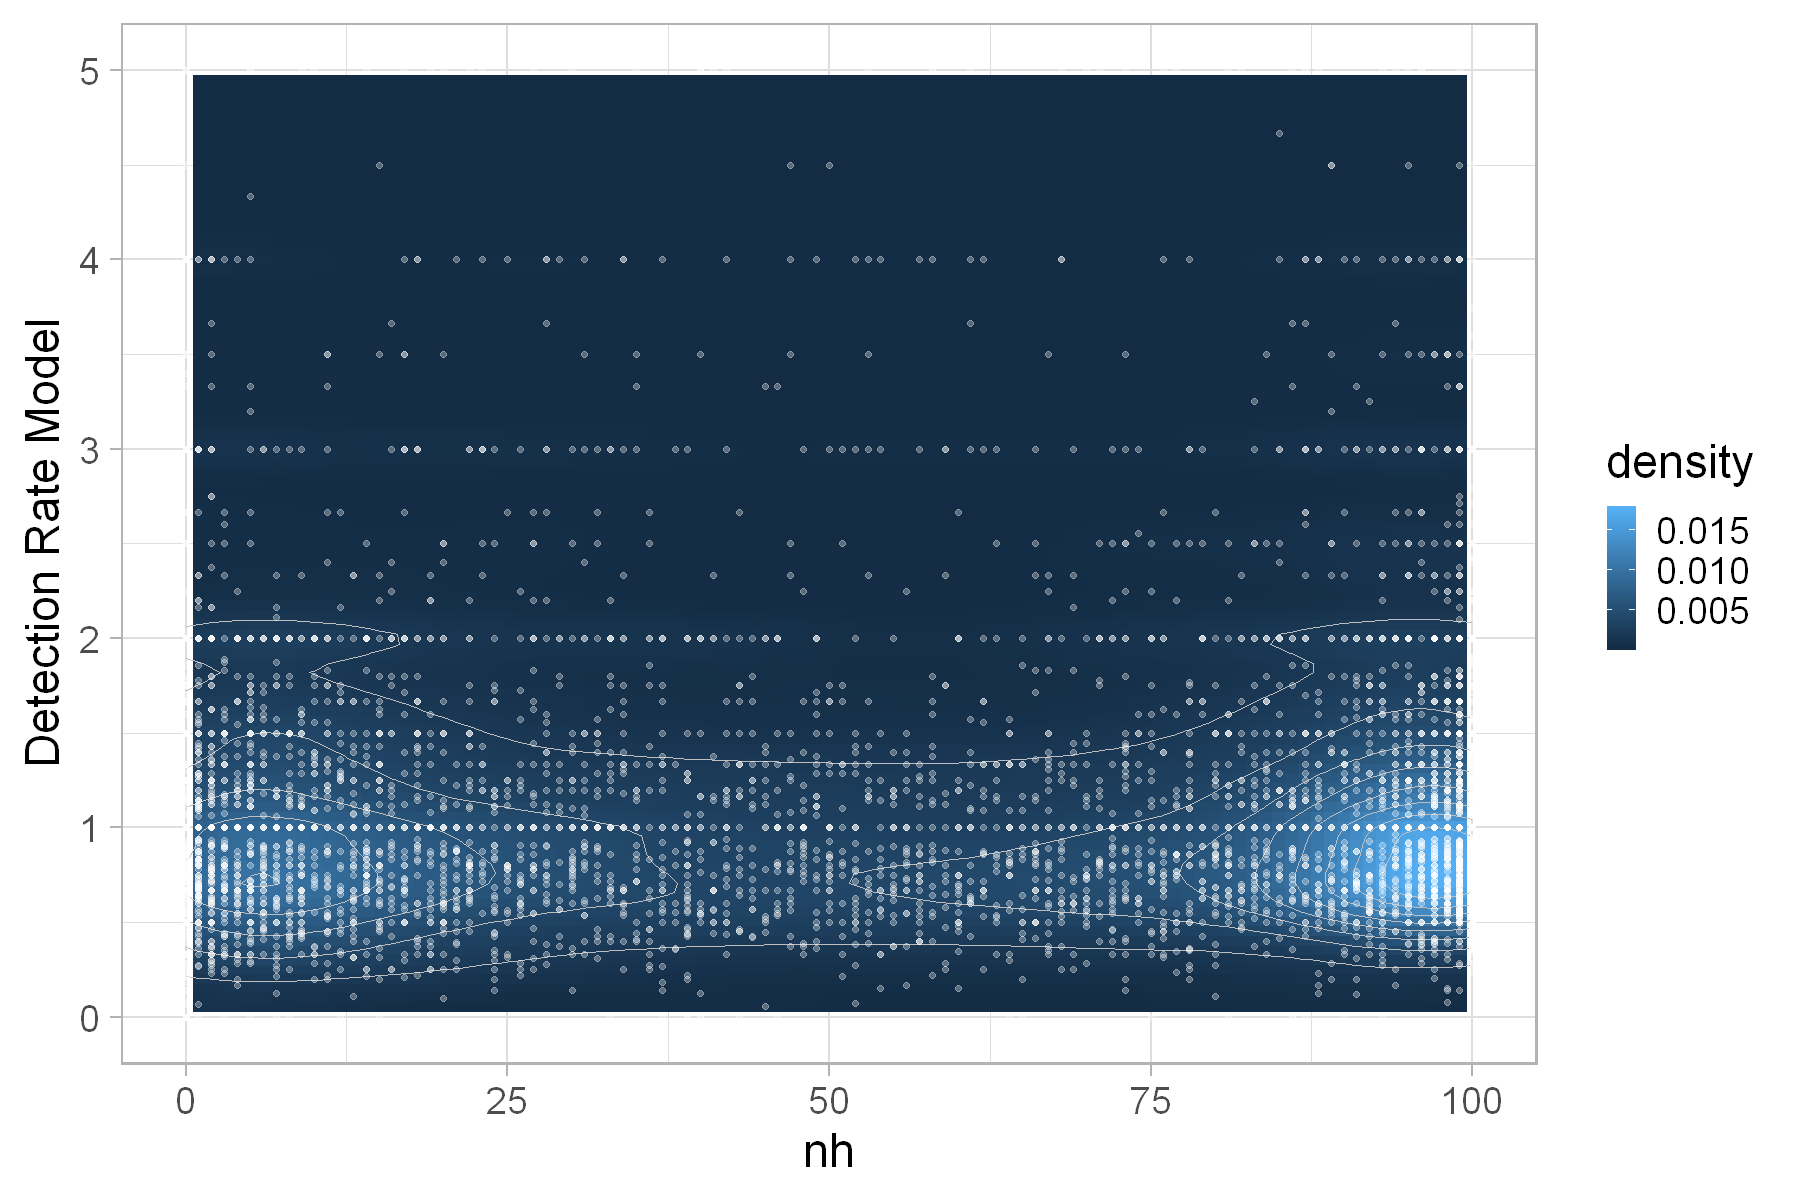

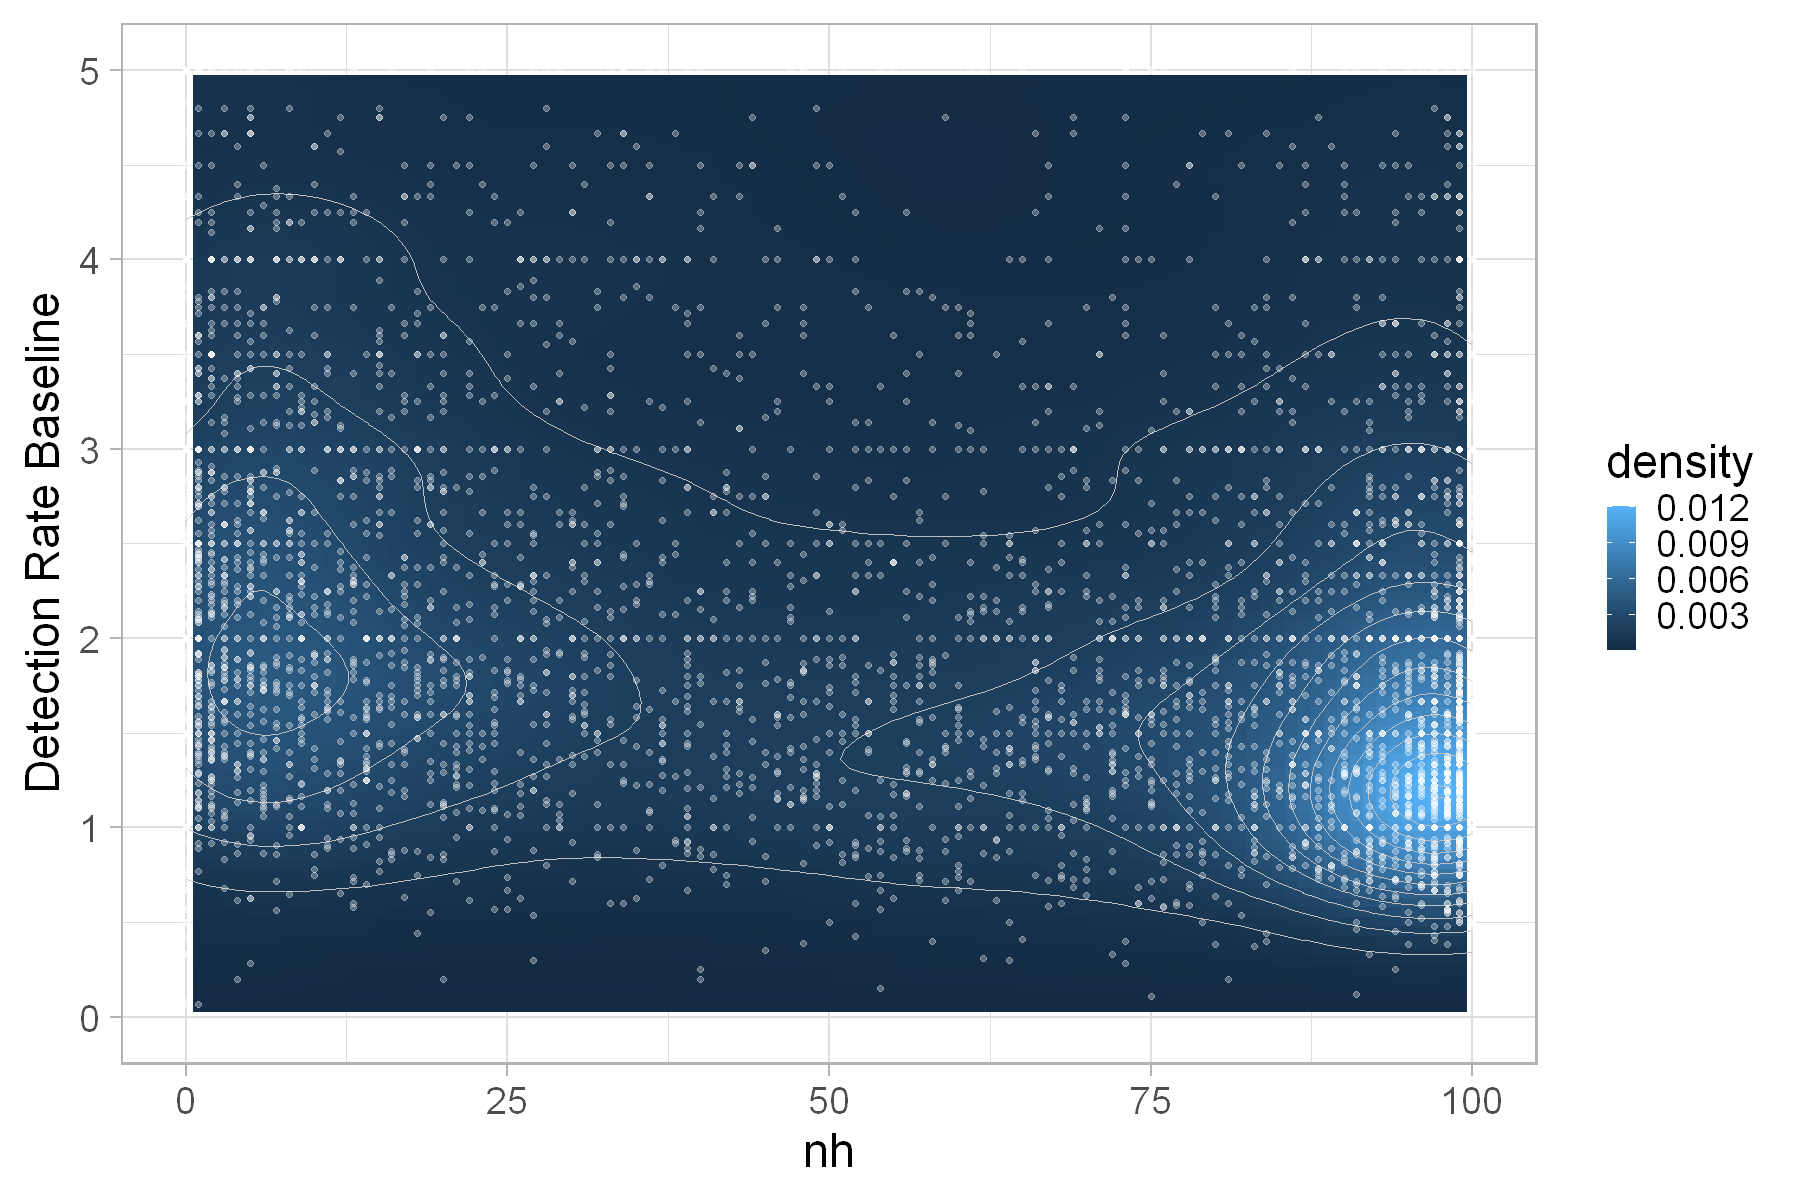

In [92]:
#Scatterplot Coniferous proportion vs  Detection Rate
options(repr.plot.width=15, repr.plot.height=10)


ggplot(data, aes(x=nh, y=dr_model)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_point(alpha=0.3, color="white") +
  xlim(0,100) +
  ylim(0,5) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  ylab("Detection Rate Model") 


#Scatterplot Coniferous proportion vs Detection Rate
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=nh, y=dr_baseline)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_point(alpha=0.3, color="white") +
  xlim(0,100) +
  ylim(0,5) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  ylab("Detection Rate Baseline") 

Warning message:
"Removed 145 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 291 rows containing non-finite values (stat_boxplot)."


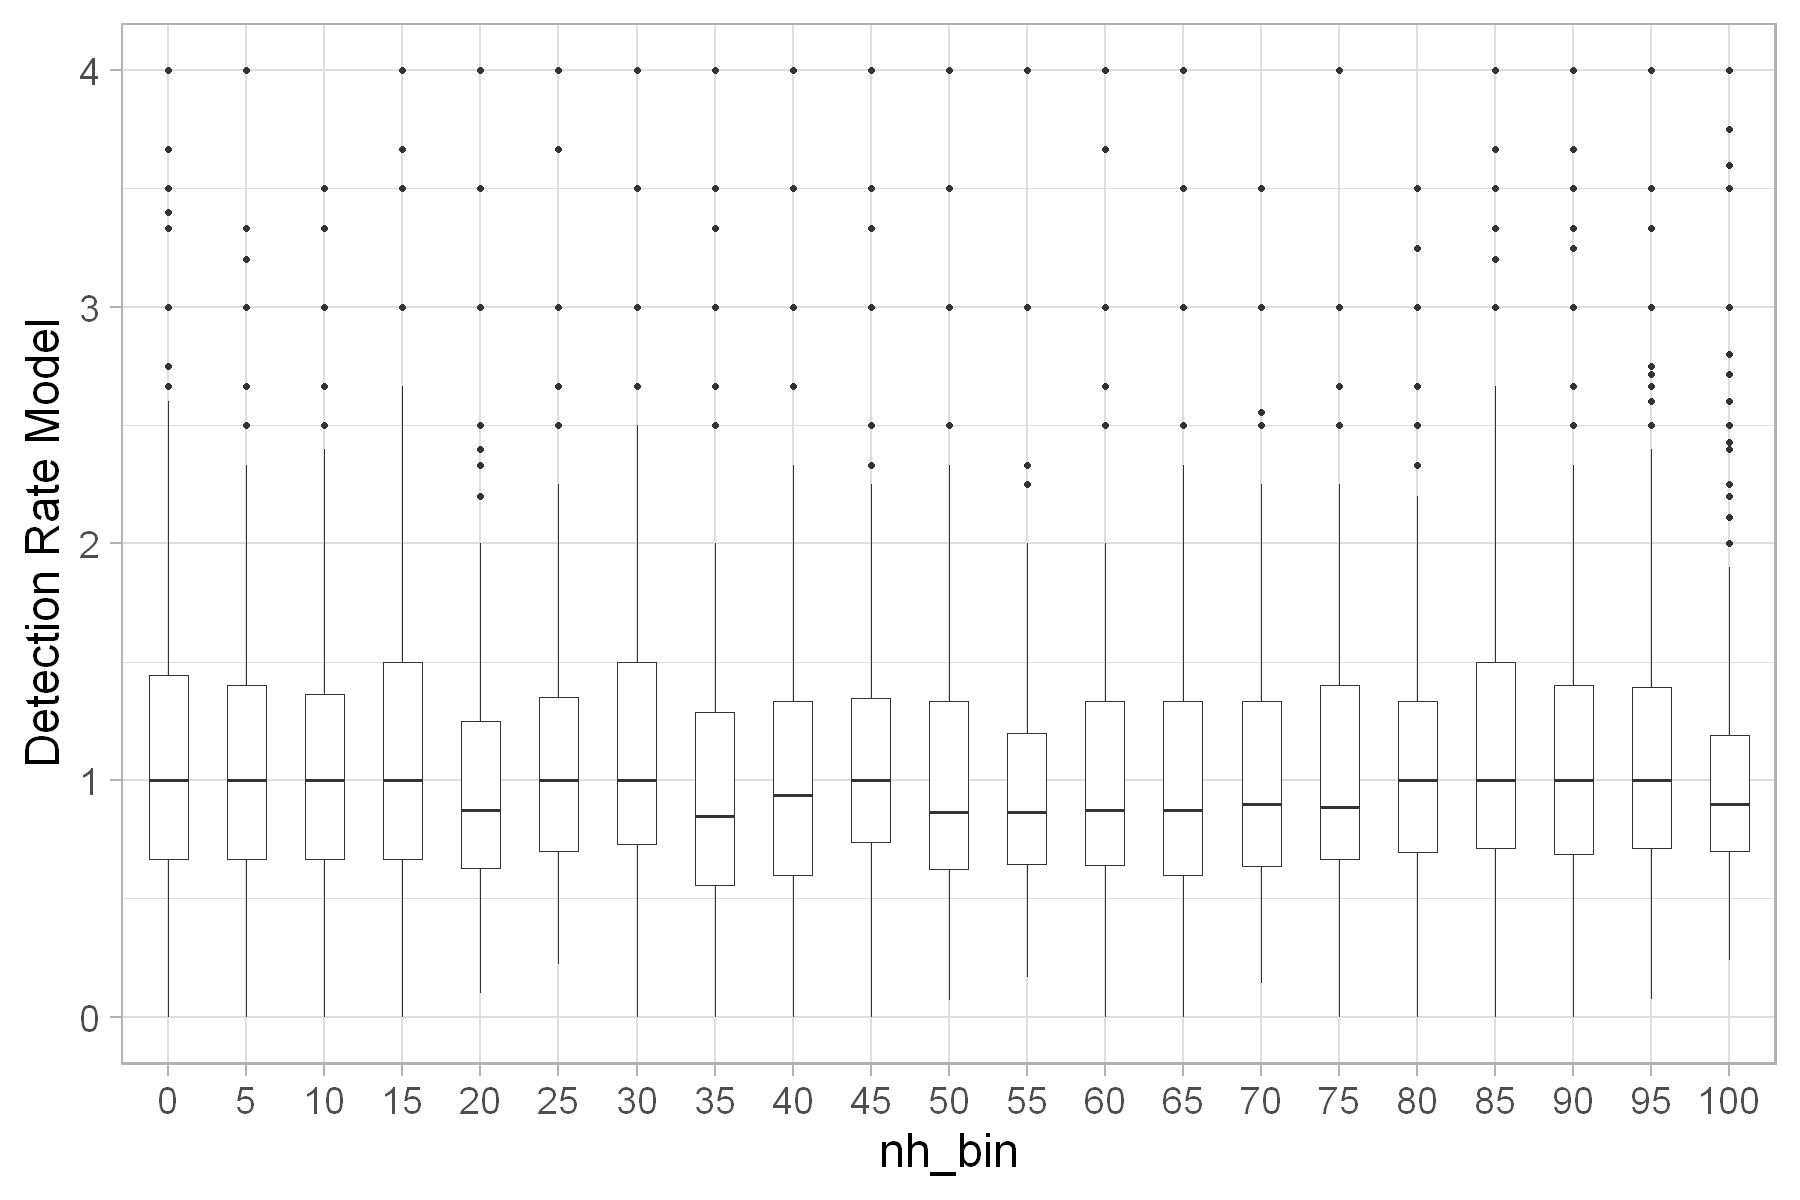

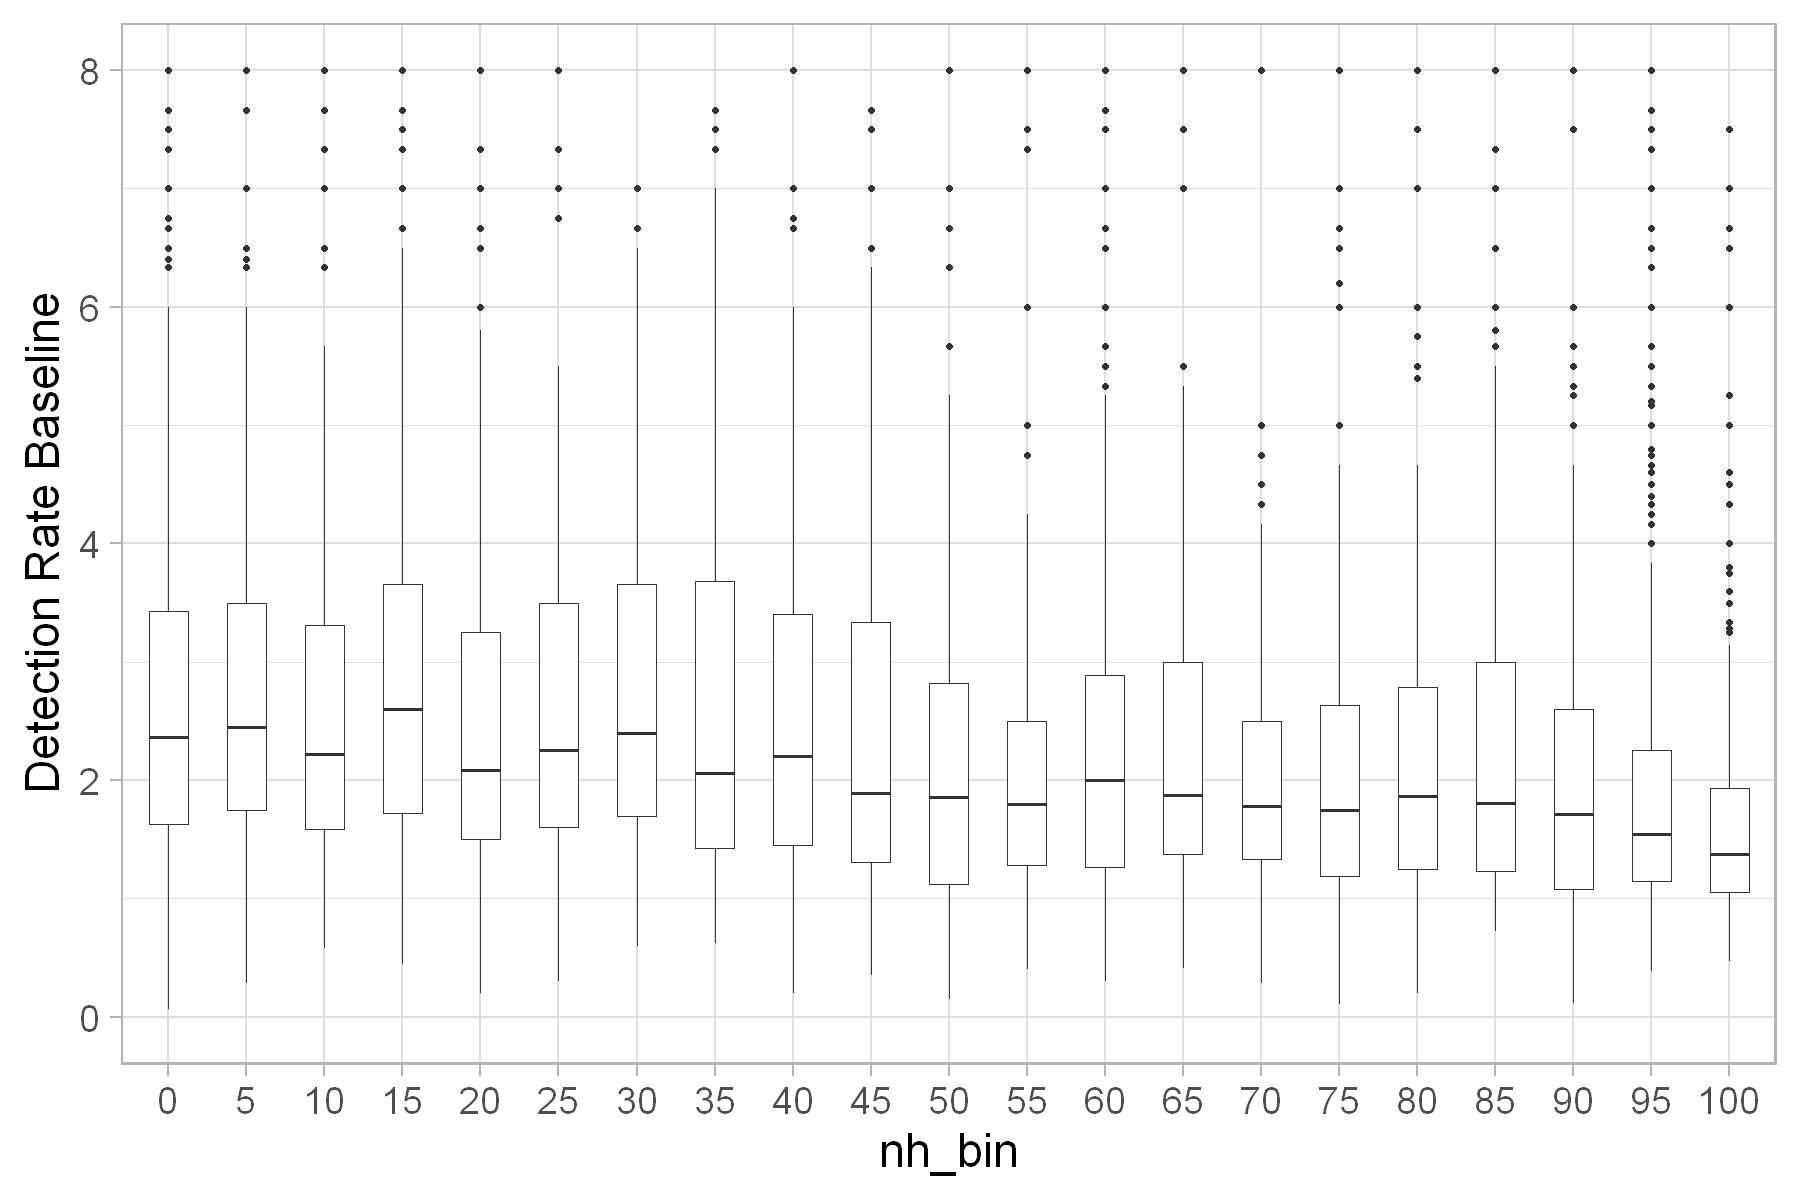

In [93]:
# Boxplots by binned coniferous proportion 0 = [0%,5%[, 5 = [5%,10%[ ...
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=nh_bin, y=dr_model)) +
#   geom_violin(trim=FALSE)+
  geom_boxplot(width=0.5)+
  ylim(0,4) +
  theme_light(base_size = font_base_size) +
  ylab("Detection Rate Model") 

# Boxplots by binned coniferous proportion 0 = [0%,5%[, 5 = [5%,10%[ ...
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=nh_bin, y=dr_baseline)) +
#   geom_violin(trim=FALSE)+
  geom_boxplot(width=0.5)+
  ylim(0,8) +
  theme_light(base_size = font_base_size) +
  ylab("Detection Rate Baseline") 



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



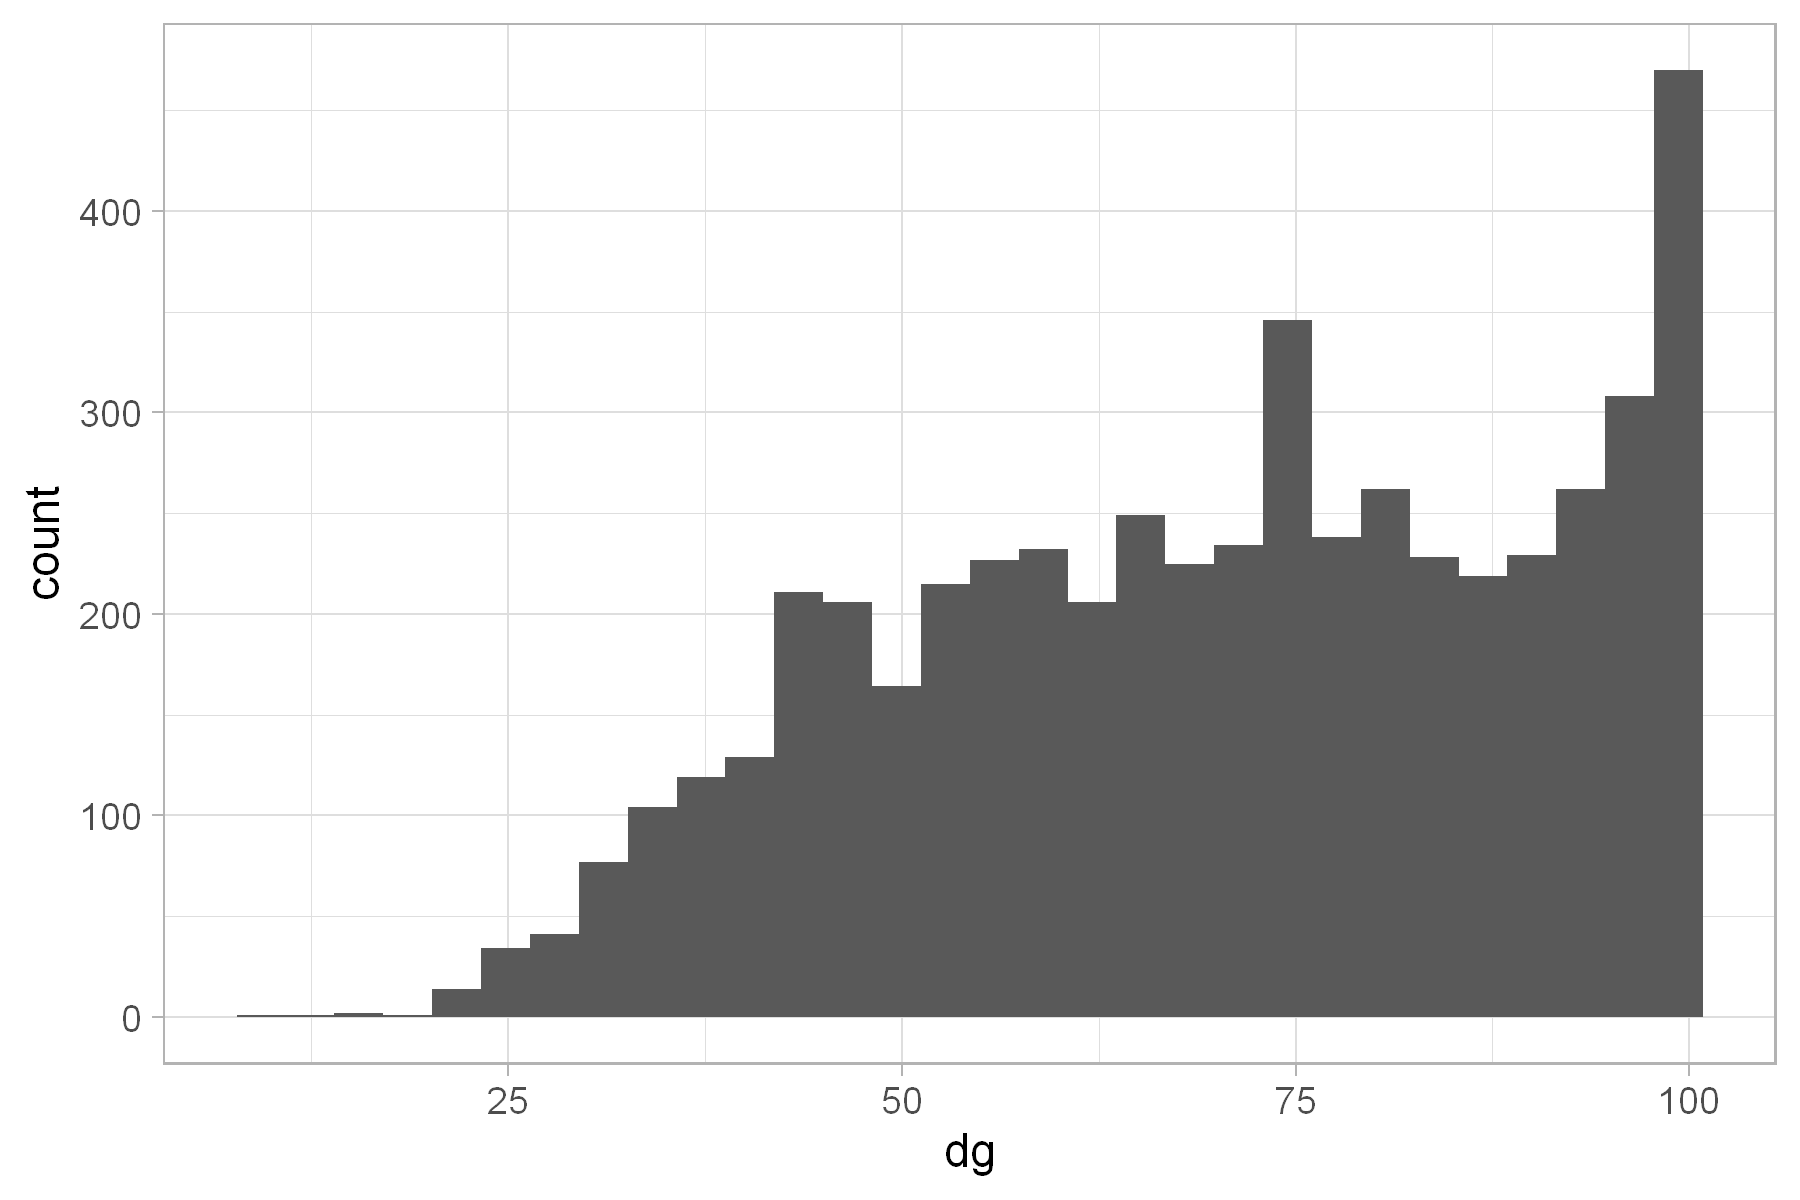

In [94]:
# Histogram of Degree of Cover
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=dg)) +
  geom_histogram()+
  theme_light(base_size = font_base_size) 


Warning message:
"Removed 5 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 5 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 5 rows containing missing values (geom_point)."
Warning message:
"Removed 7 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 7 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 7 rows containing missing values (geom_point)."


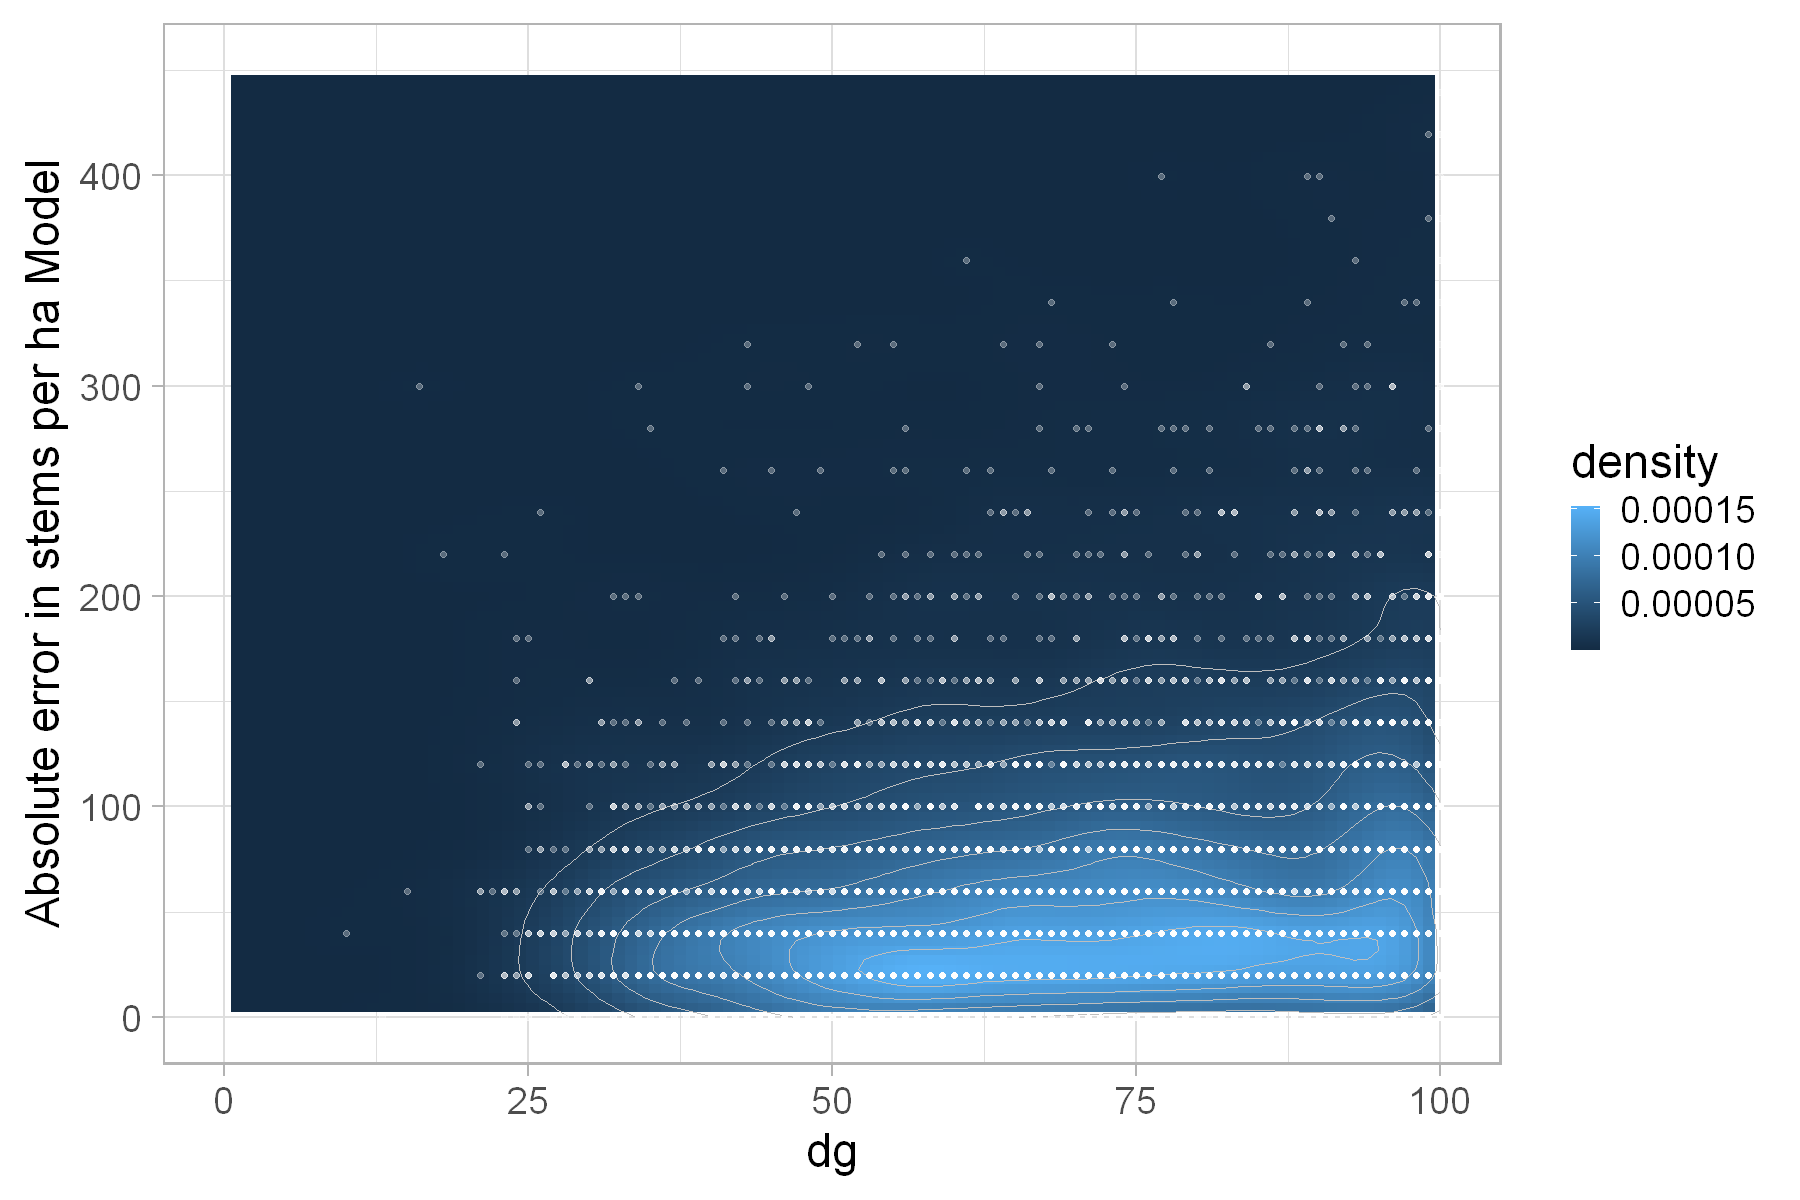

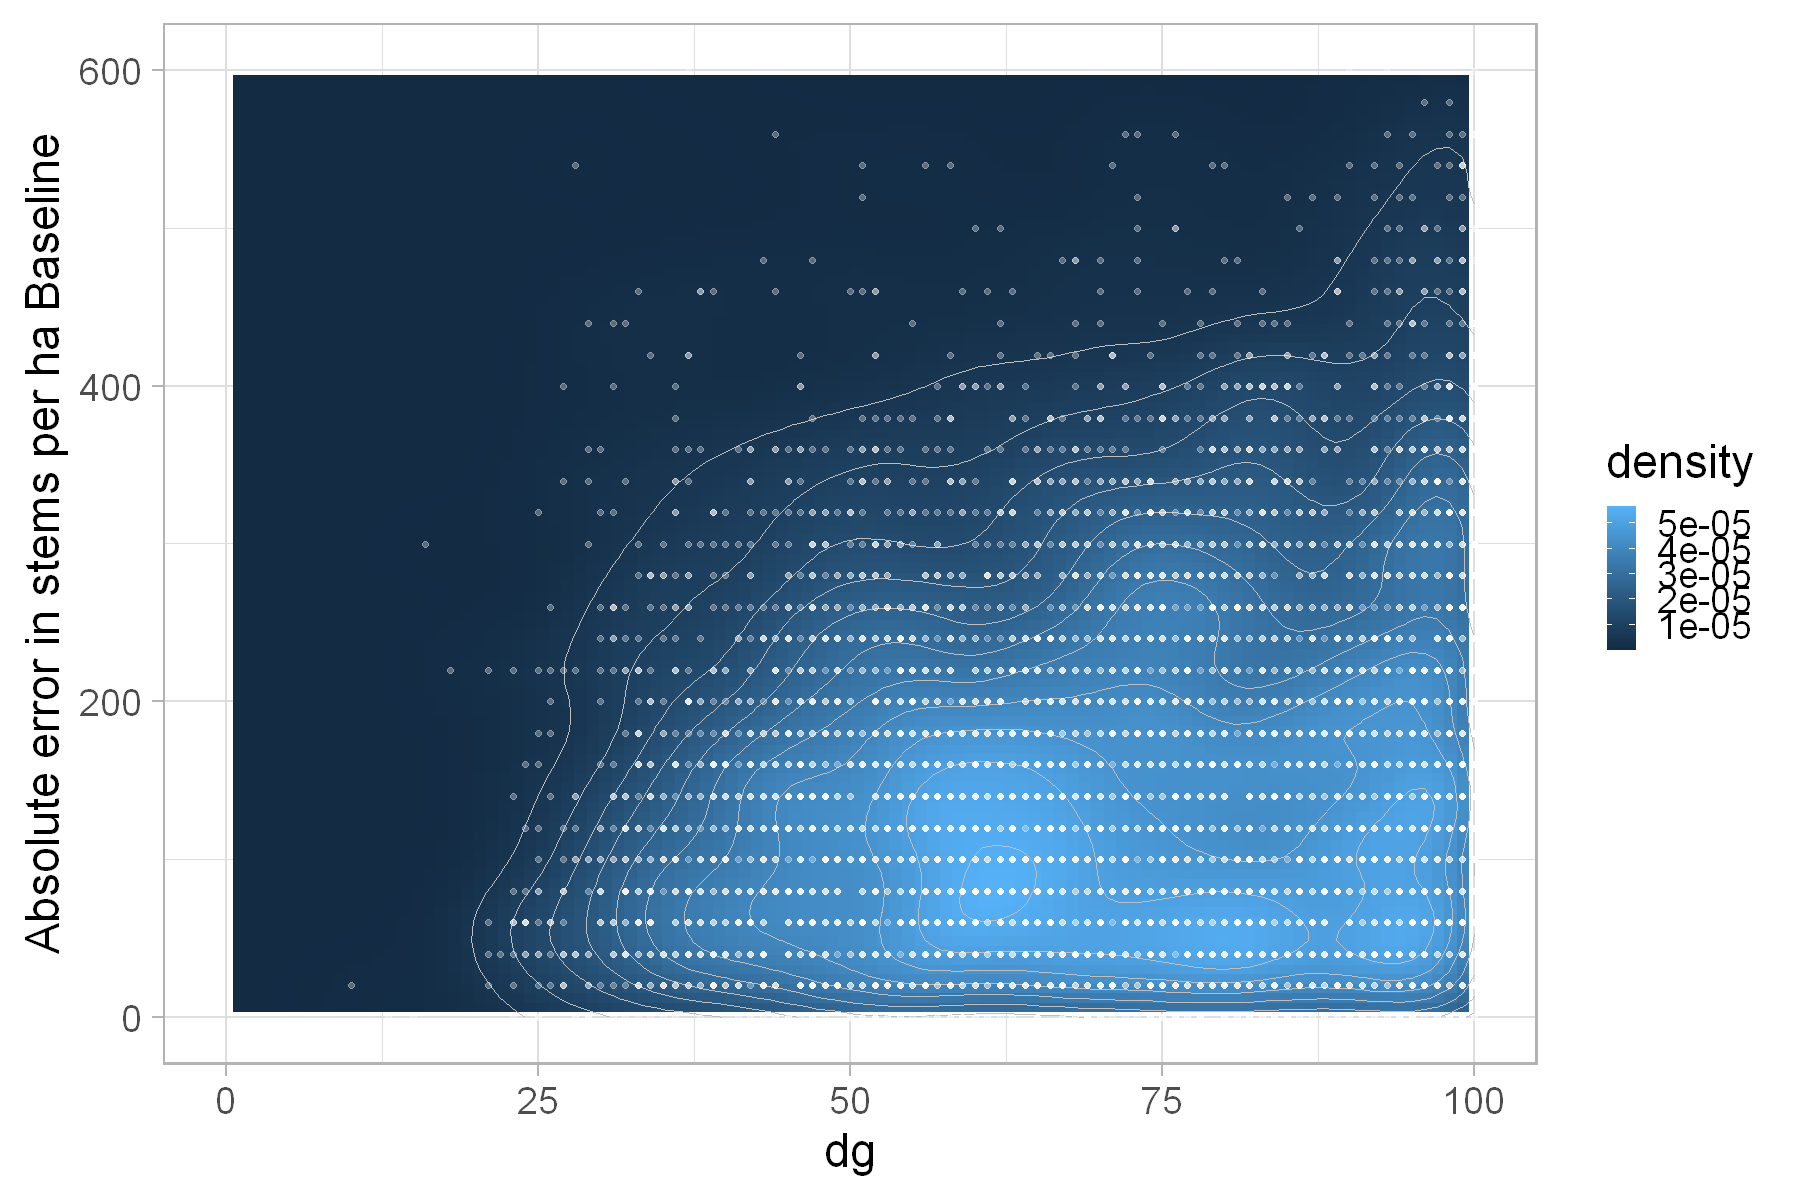

In [95]:
#Scatterplot Degree of cover vs Absolute Error Model
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=dg, y=stems_per_ha_abs_err_model)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_point(alpha=0.3, color="white") +
  xlim(0,100) +
  ylim(0,450) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error in stems per ha Model") 

#Scatterplot Coniferous proportion vs Absolute Error Baseline
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=dg, y=stems_per_ha_abs_err_baseline)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_point(alpha=0.3, color="white") +
  xlim(0,100) +
  ylim(0,600) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error in stems per ha Baseline") 


Warning message:
"Removed 20 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 5 rows containing non-finite values (stat_boxplot)."


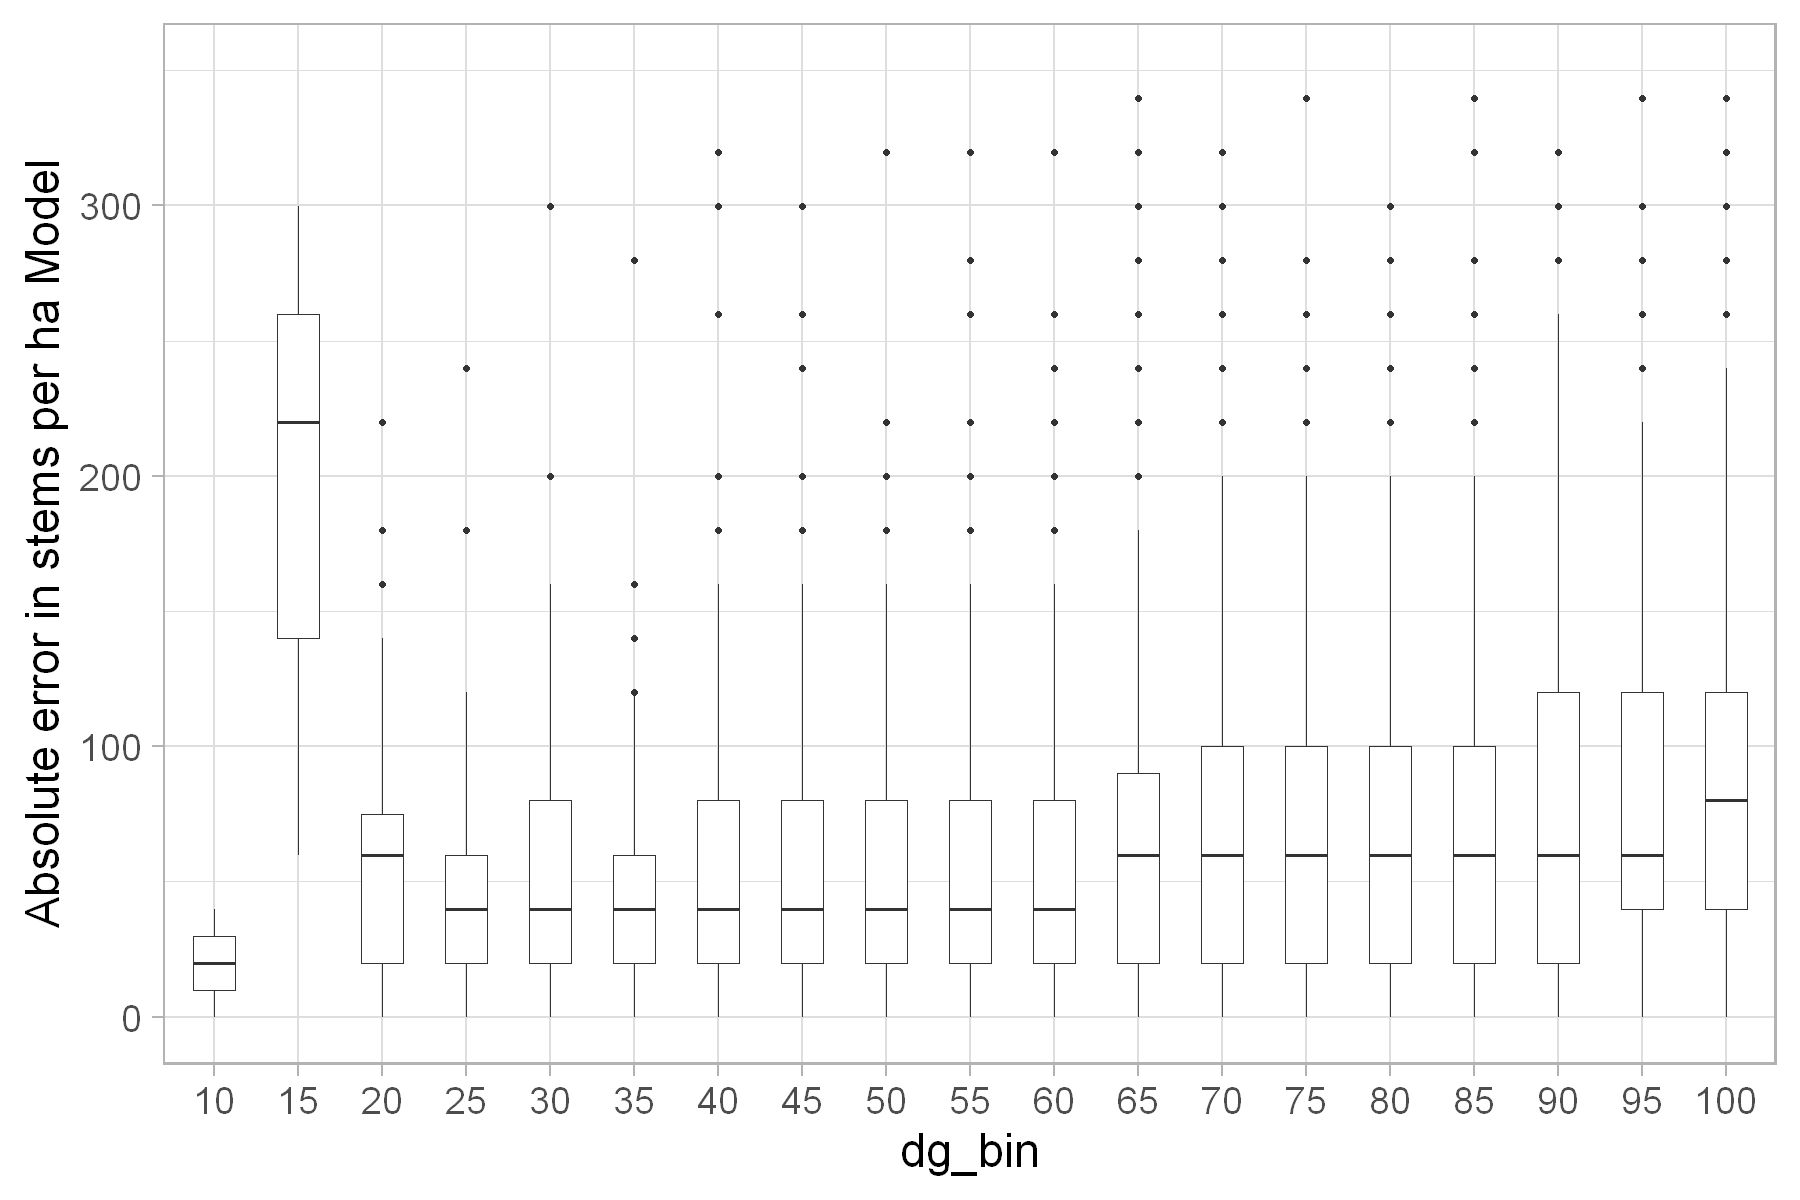

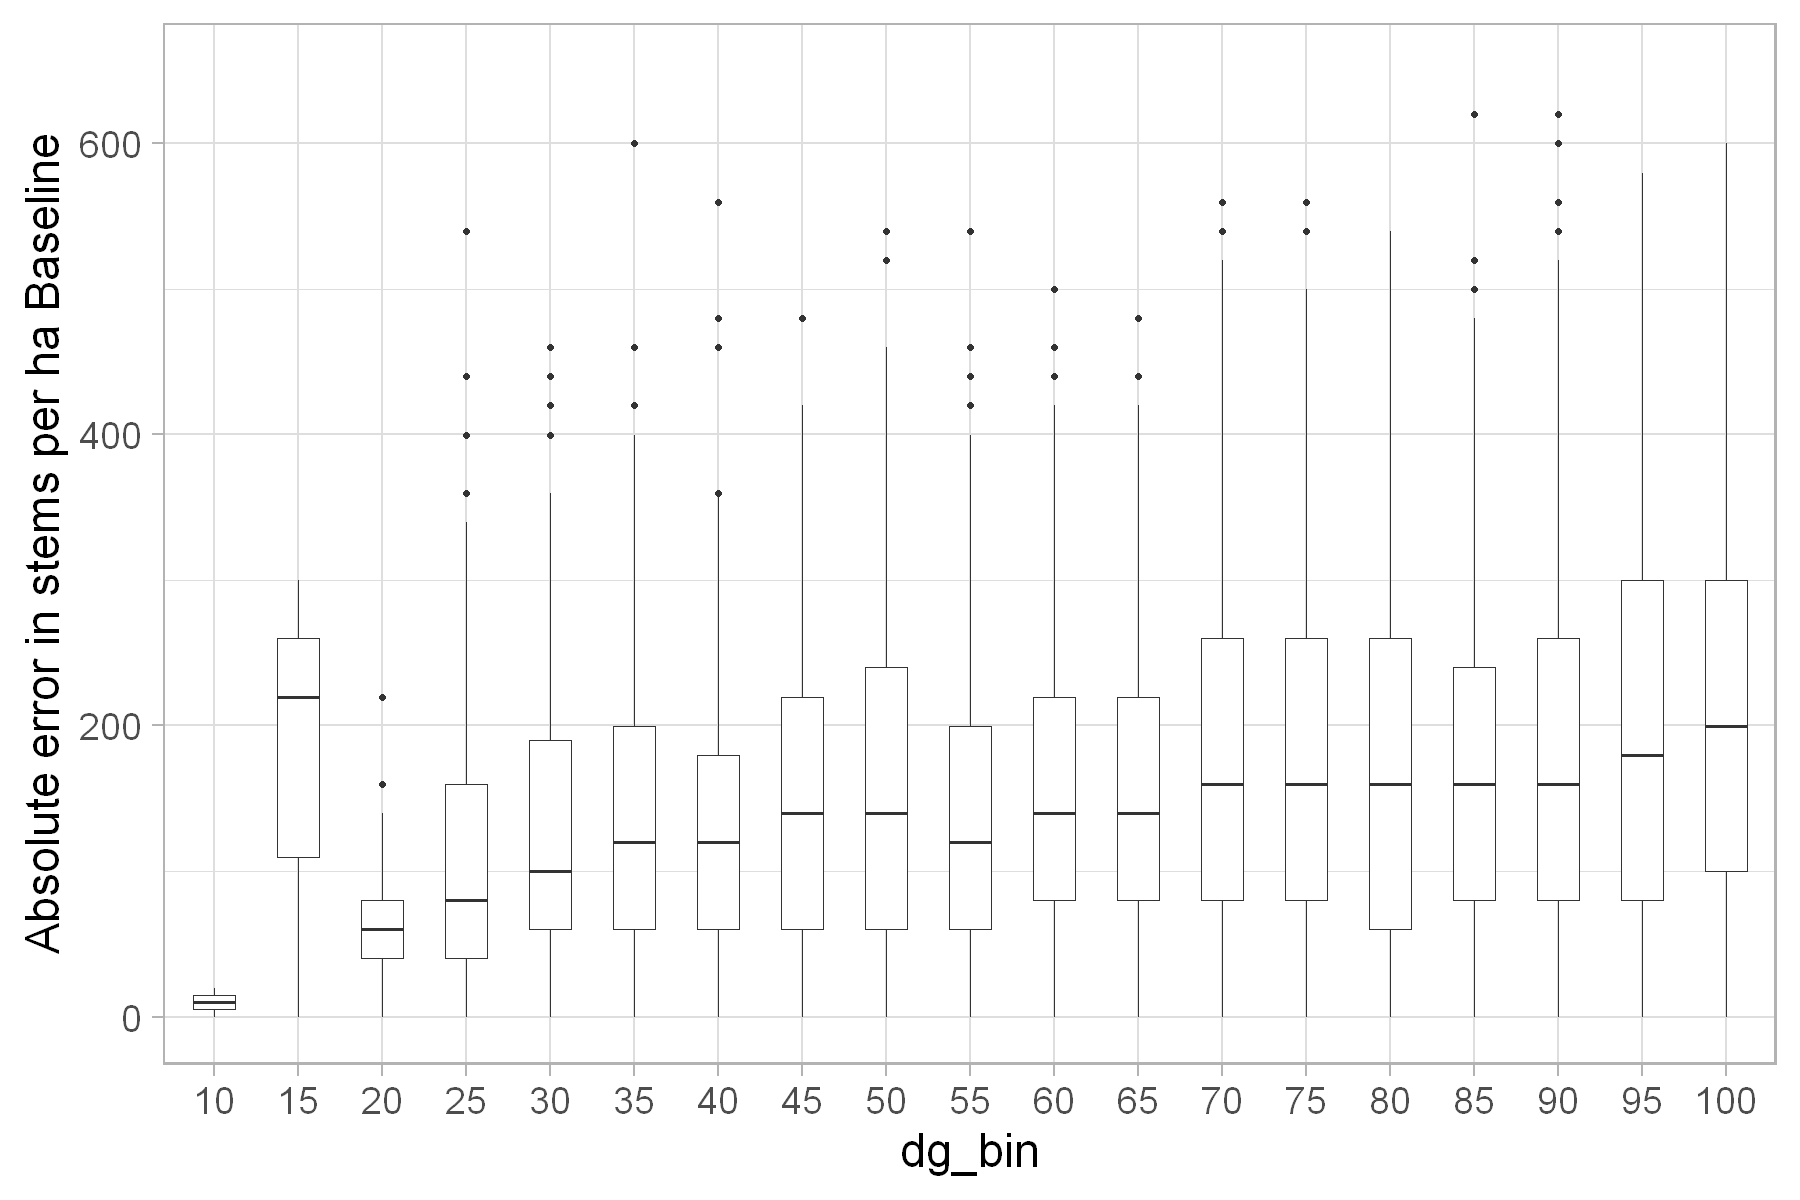

In [96]:
# Boxplots by binned degree of cover 0 = [0%,5%[, 5 = [5%,10%[ ...
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=dg_bin, y=stems_per_ha_abs_err_model)) +
#   geom_violin(trim=FALSE)+
  geom_boxplot(width=0.5)+
  ylim(0,350) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error in stems per ha Model") 

# Boxplots by binned degree of cover 0 = [0%,5%[, 5 = [5%,10%[ ...
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=dg_bin, y=stems_per_ha_abs_err_baseline)) +
#   geom_violin(trim=FALSE)+
  geom_boxplot(width=0.5)+
  ylim(0,650) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error in stems per ha Baseline") 



Warning message:
"Removed 91 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 91 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 91 rows containing missing values (geom_point)."
Warning message:
"Removed 618 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 618 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 618 rows containing missing values (geom_point)."


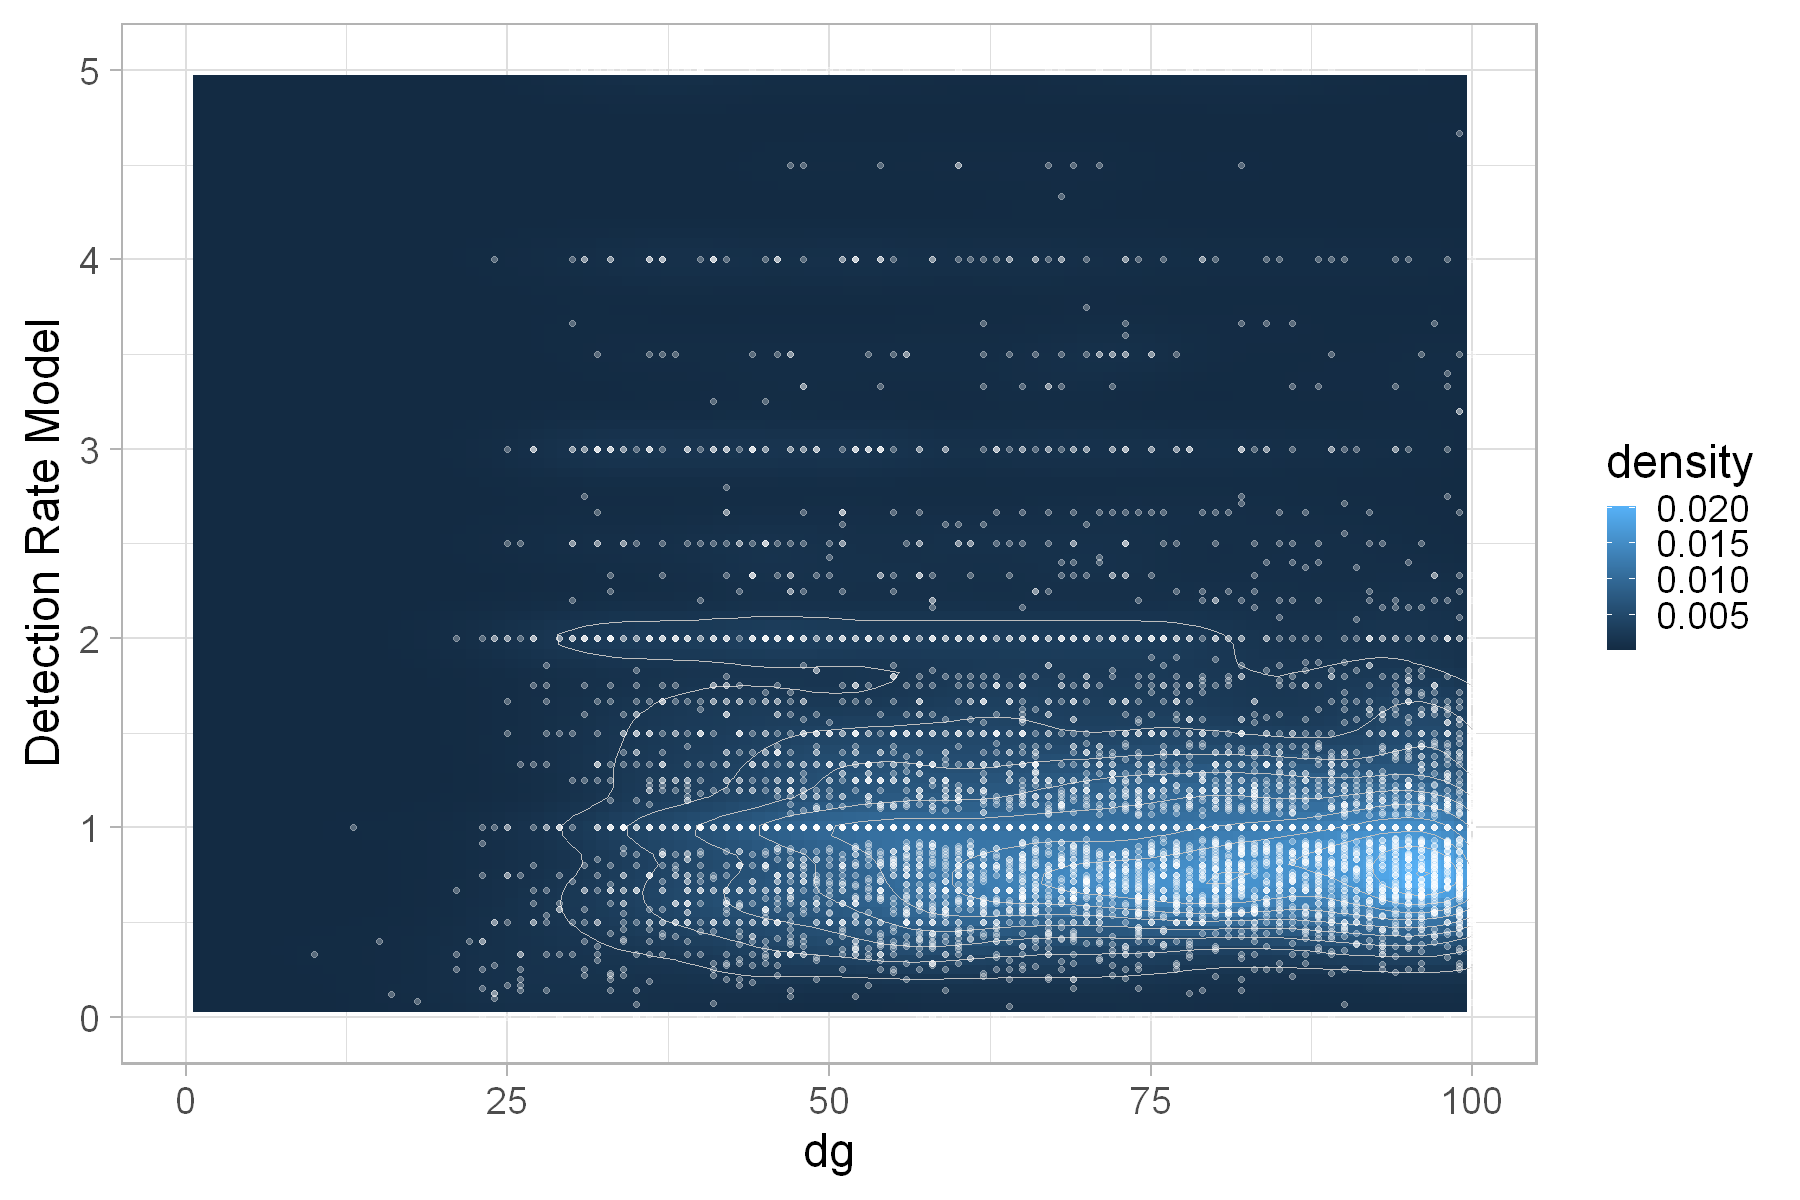

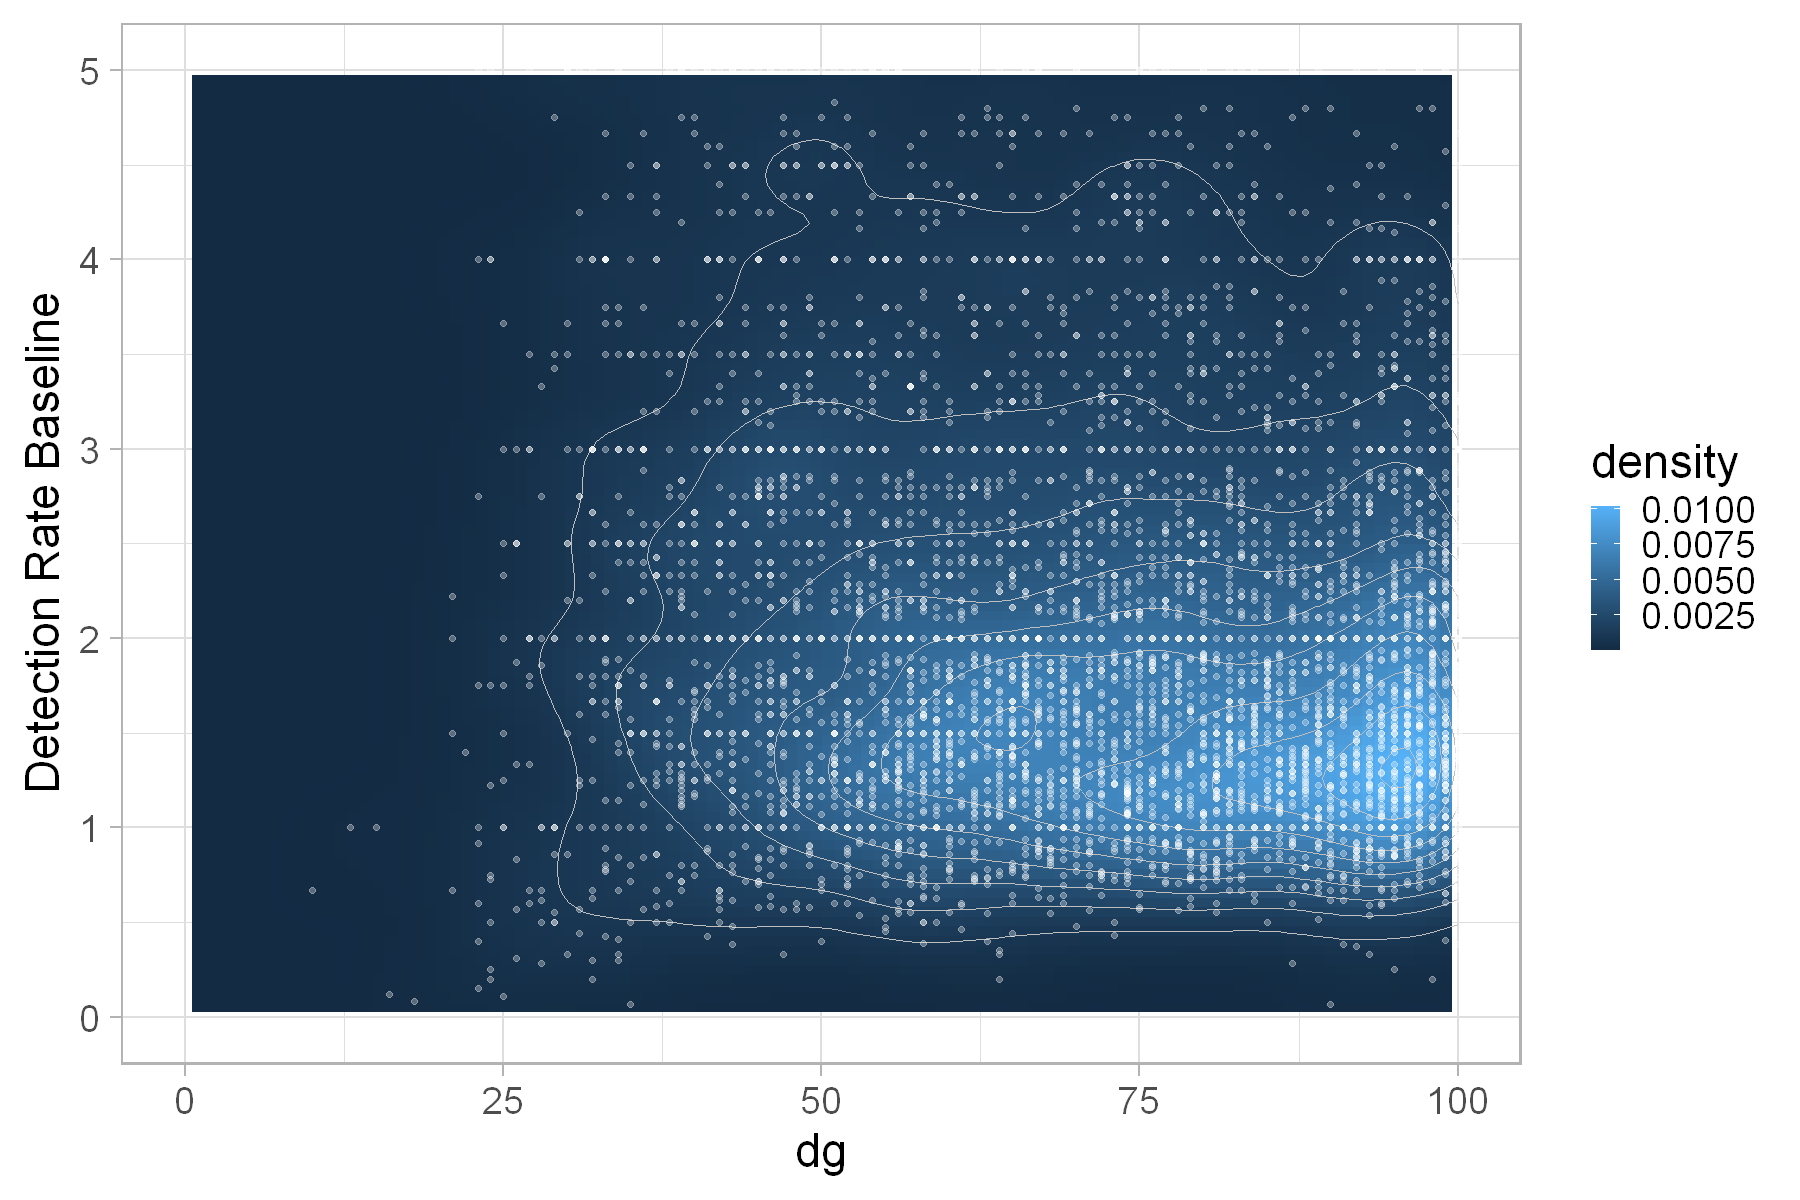

In [97]:
#Scatterplot Degree of cover vs Detection Rate
options(repr.plot.width=15, repr.plot.height=10)


ggplot(data, aes(x=dg, y=dr_model)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_point(alpha=0.3, color="white") +
  xlim(0,100) +
  ylim(0,5) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  ylab("Detection Rate Model") 


#Scatterplot Degree of cover vs  Detection Rate
options(repr.plot.width=15, repr.plot.height=10)


ggplot(data, aes(x=dg, y=dr_baseline)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_point(alpha=0.3, color="white") +
  xlim(0,100) +
  ylim(0,5) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  ylab("Detection Rate Baseline") 


Warning message:
"Removed 145 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 291 rows containing non-finite values (stat_boxplot)."


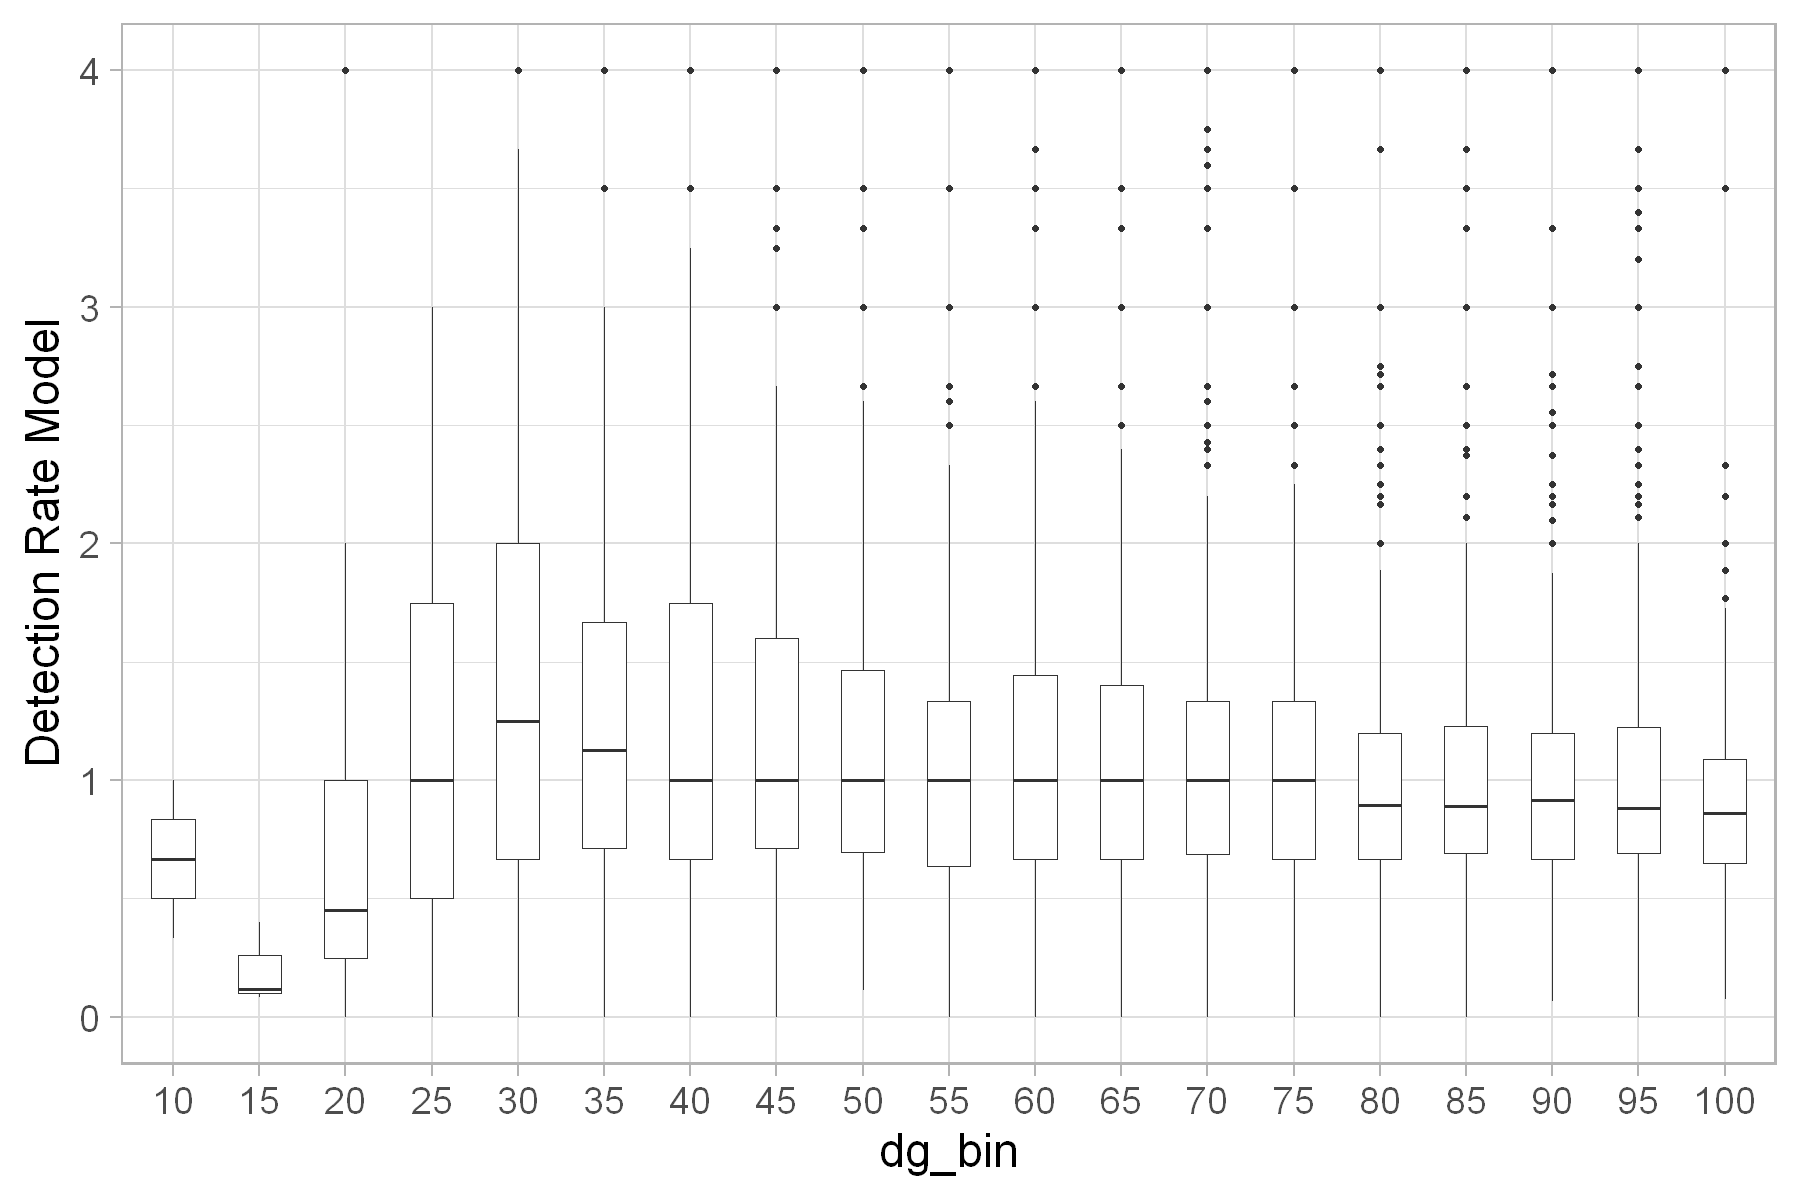

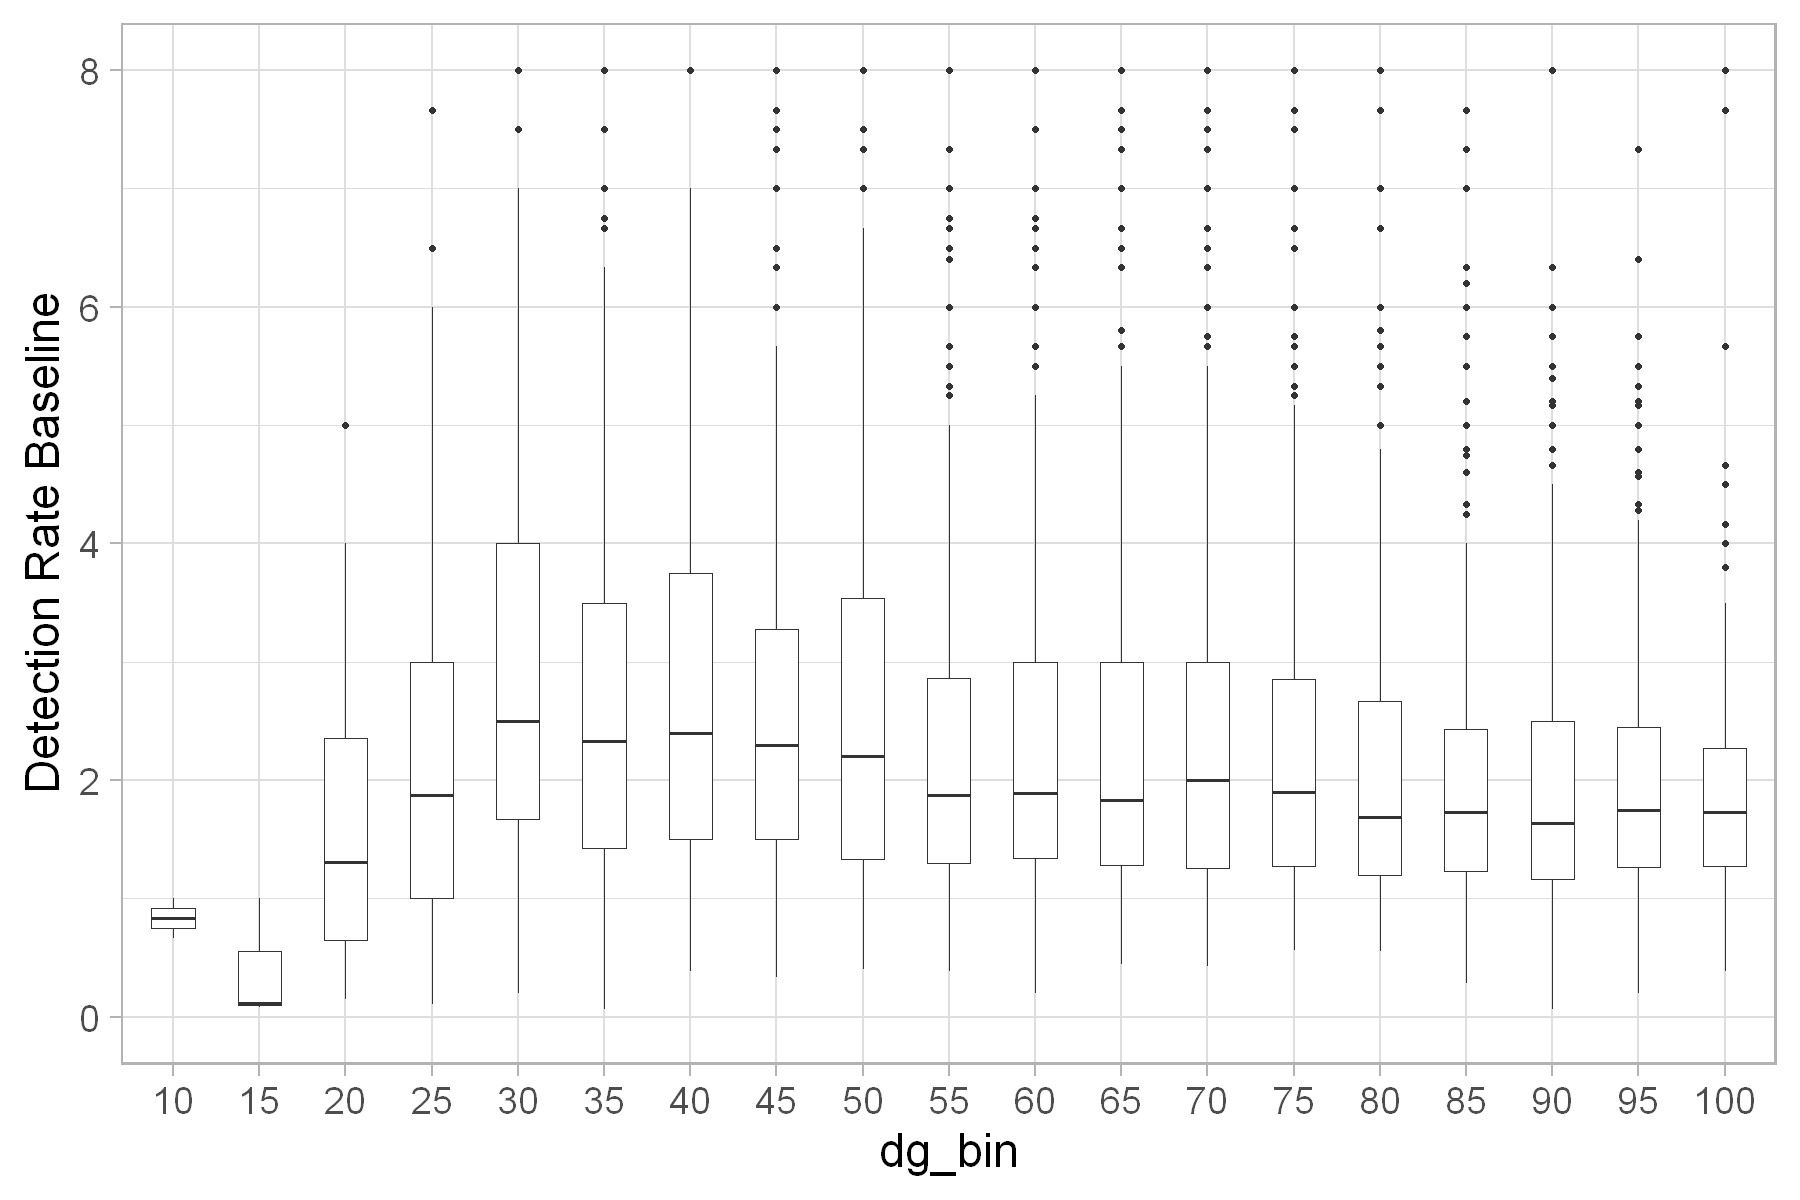

In [98]:
# Boxplots by binned degree of cover0 = [0%,5%[, 5 = [5%,10%[ ...
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=dg_bin, y=dr_model)) +
#   geom_violin(trim=FALSE)+
  geom_boxplot(width=0.5)+
  ylim(0,4) +
  theme_light(base_size = font_base_size) +
  ylab("Detection Rate Model") 

# Boxplots by binned degree of cover 0 = [0%,5%[, 5 = [5%,10%[ ...
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=dg_bin, y=dr_baseline)) +
#   geom_violin(trim=FALSE)+
  geom_boxplot(width=0.5)+
  ylim(0,8) +
  theme_light(base_size = font_base_size) +
  ylab("Detection Rate Baseline") 



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



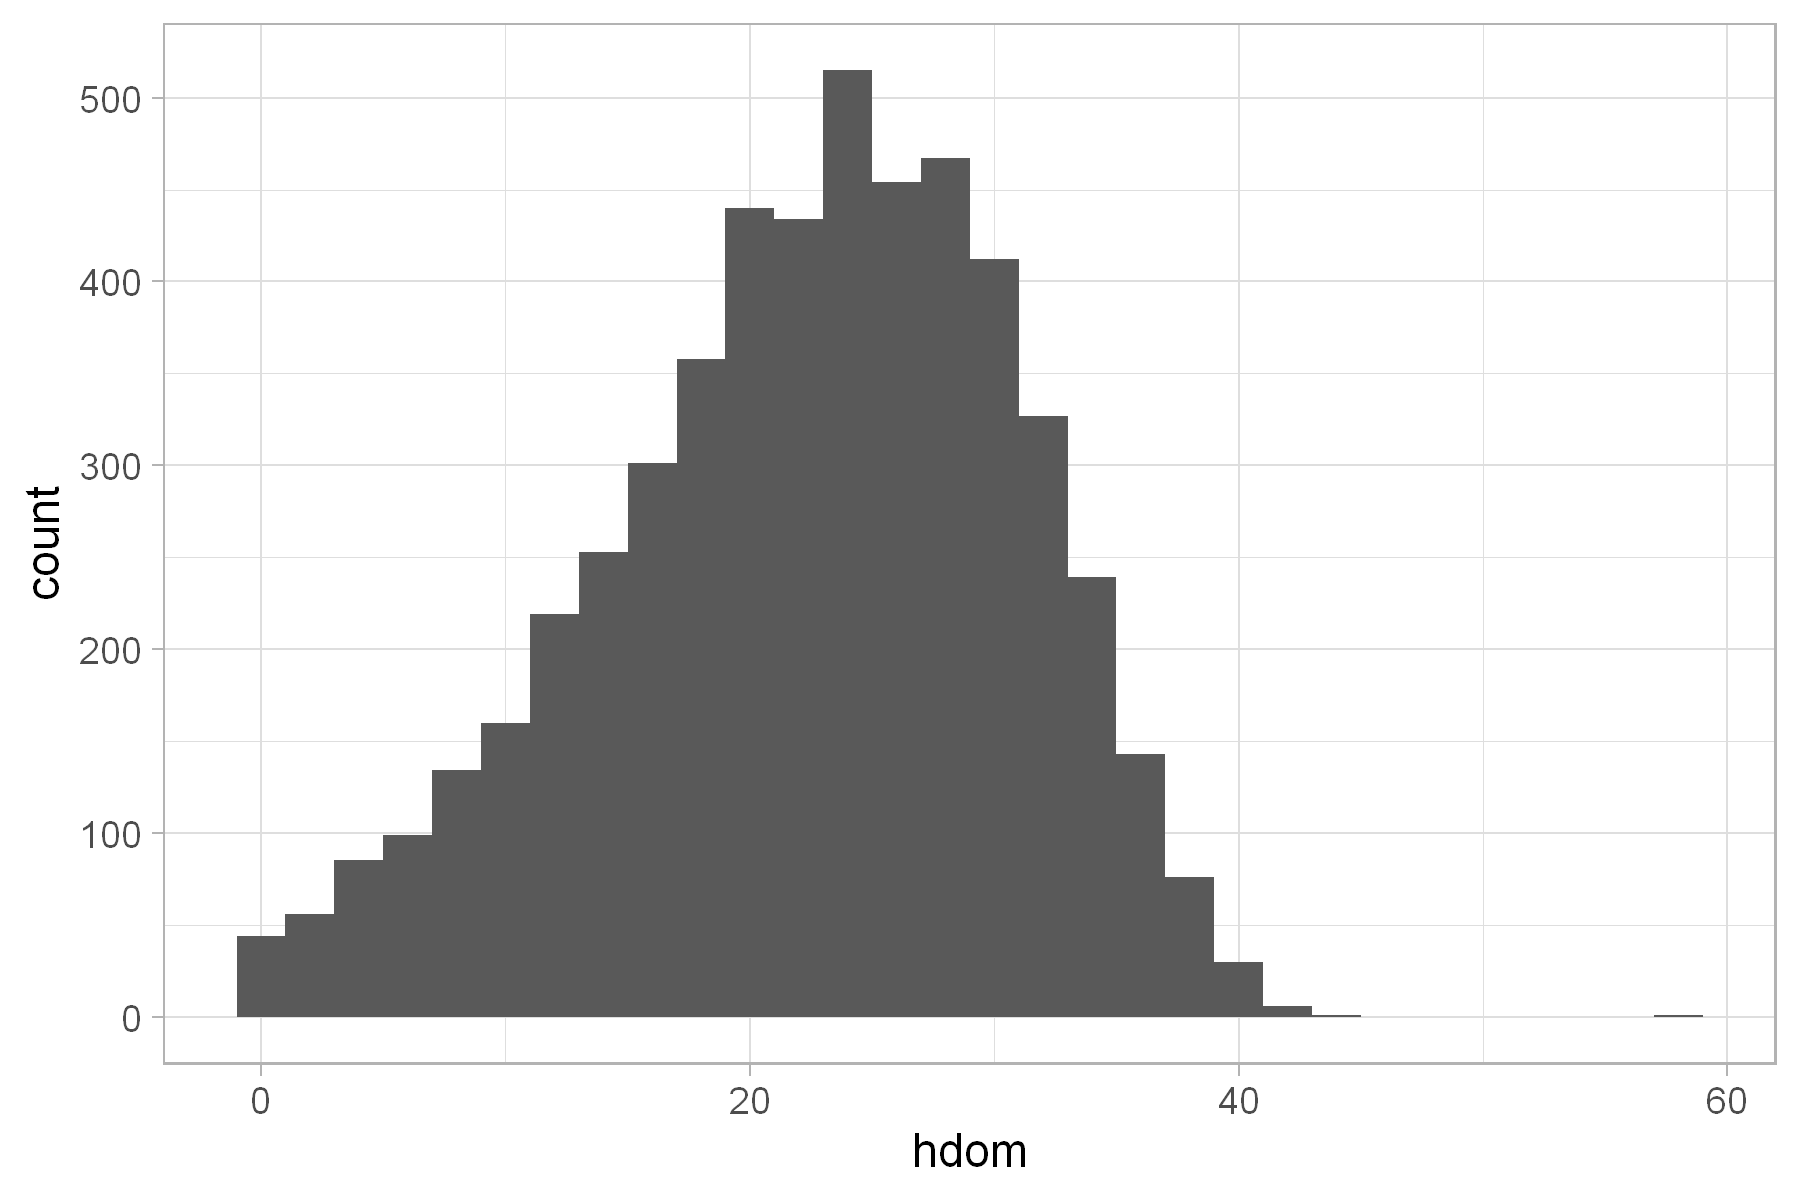

In [99]:
# Histogram of Dominant Height
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=hdom)) +
  geom_histogram()+
  theme_light(base_size = font_base_size) 


Warning message:
"Removed 98 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 98 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 98 rows containing missing values (geom_point)."
Warning message:
"Removed 51 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 51 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 51 rows containing missing values (geom_point)."


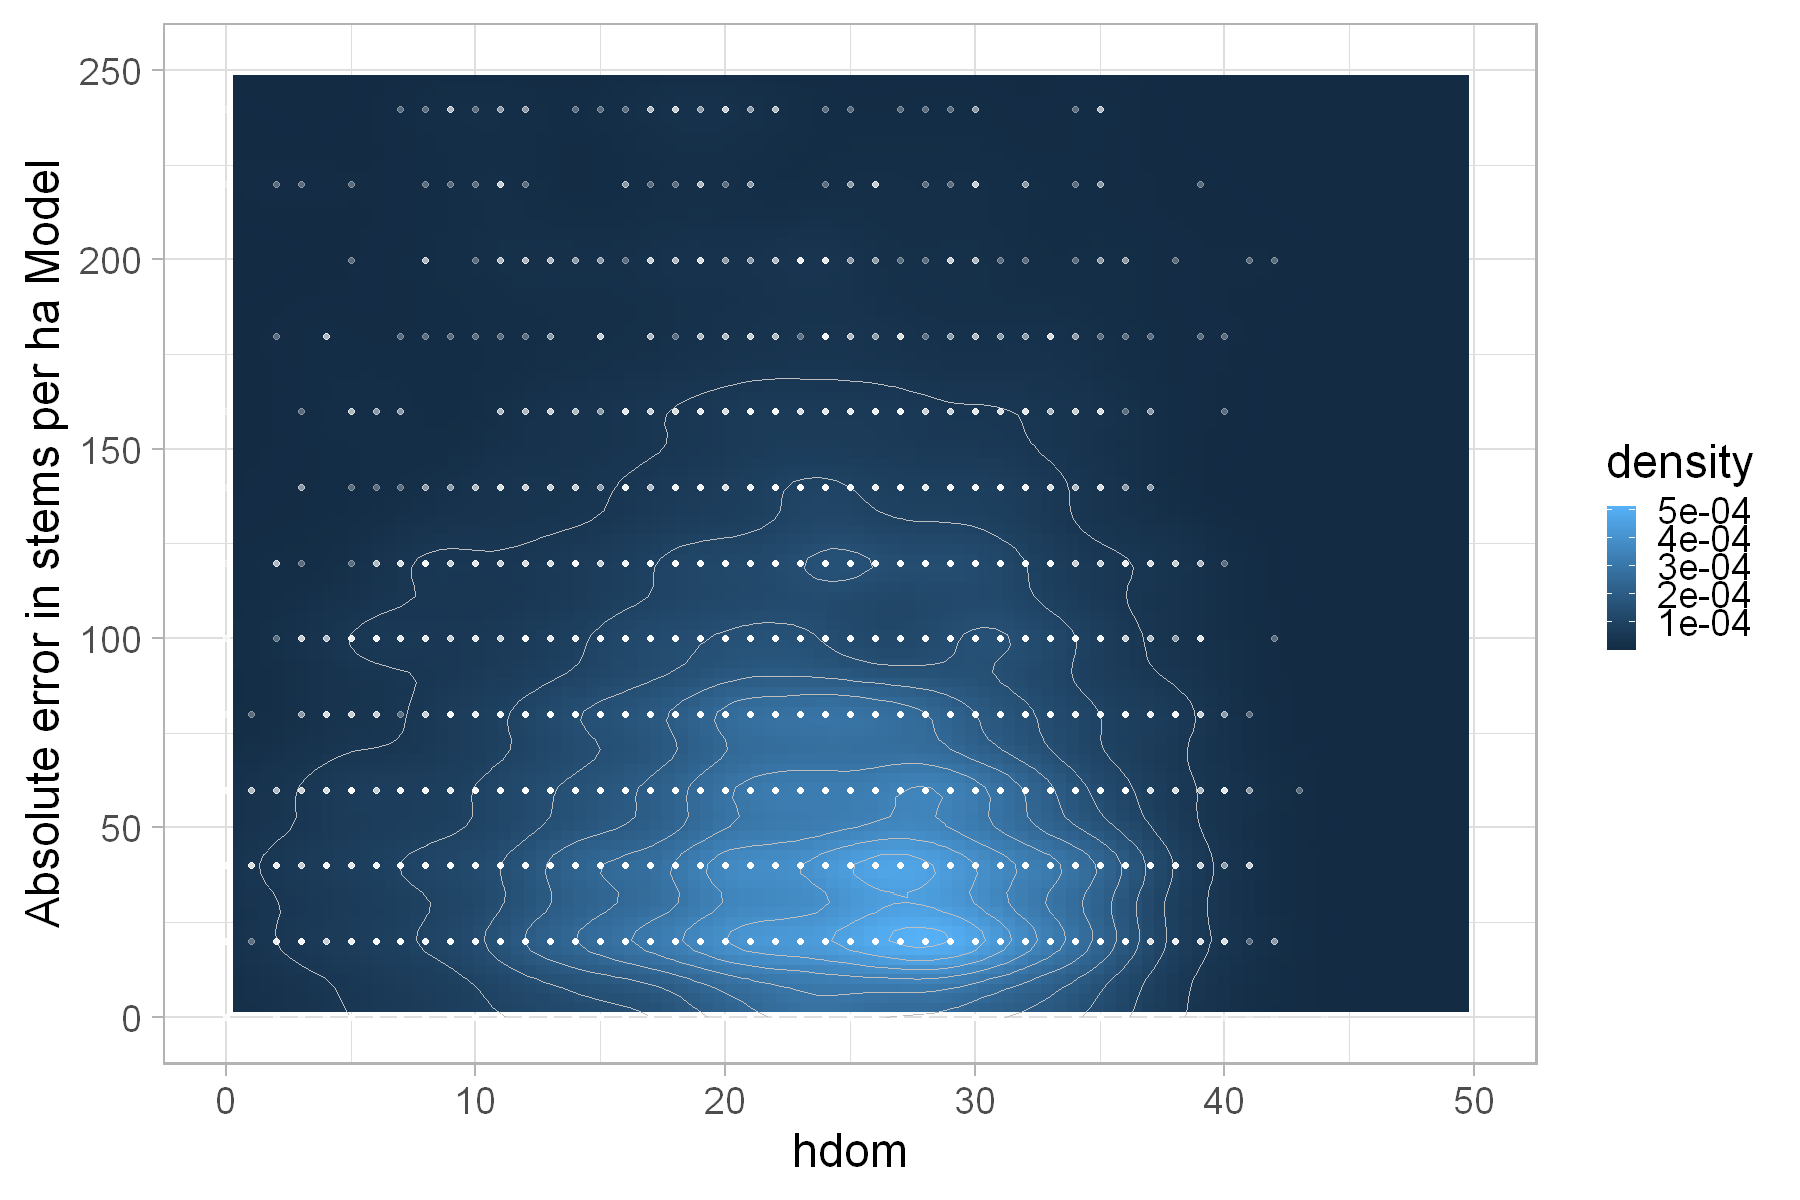

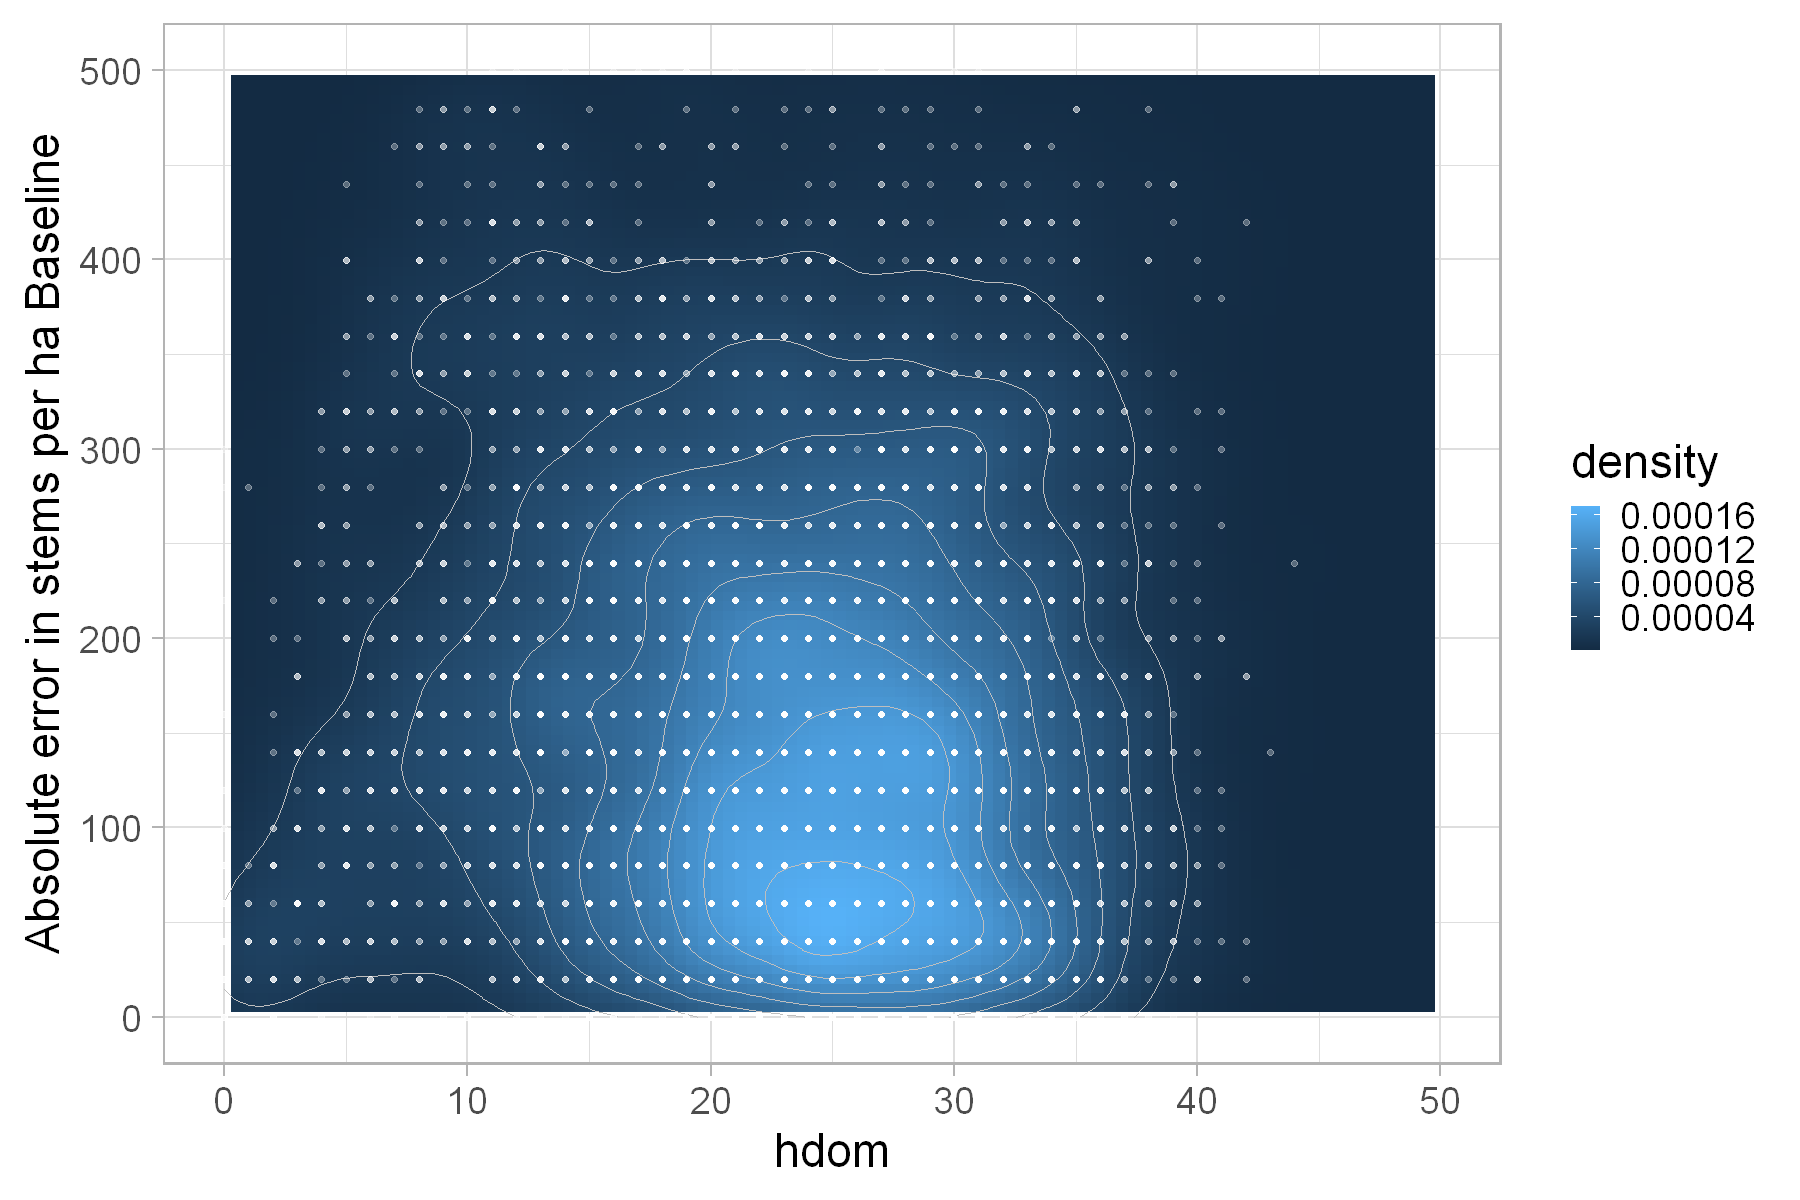

In [100]:
#Scatterplot Dominant height vs Absolute Error Model
options(repr.plot.width=15, repr.plot.height=10)


ggplot(data, aes(x=hdom, y=stems_per_ha_abs_err_model)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_point(alpha=0.3, color="white") +
  xlim(0,50) +
  ylim(0,250) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error in stems per ha Model") 

#Scatterplot Dominant height vs Absolute Error Baseline
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=hdom, y=stems_per_ha_abs_err_baseline)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_point(alpha=0.3, color="white") +
  xlim(0,50) +
  ylim(0,500) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error in stems per ha Baseline") 



Warning message:
"Removed 20 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 5 rows containing non-finite values (stat_boxplot)."


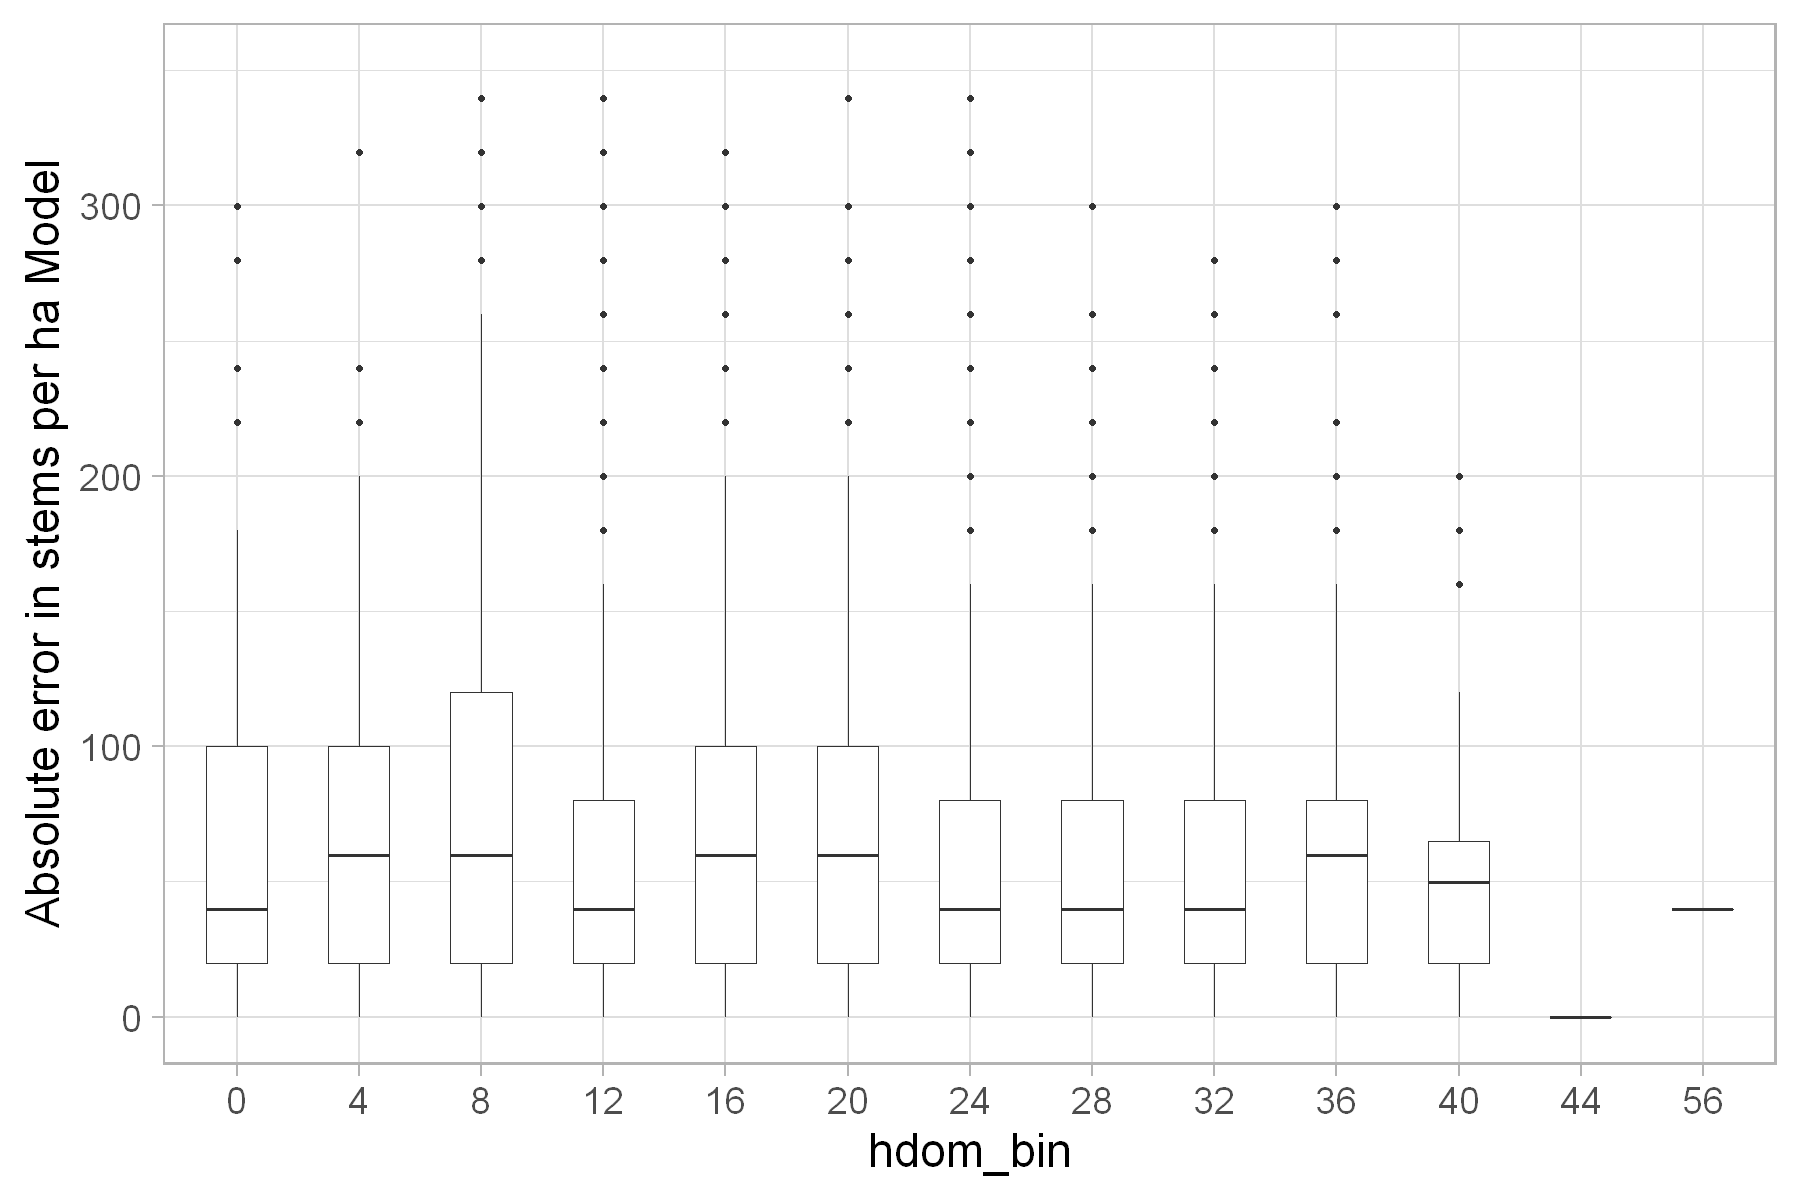

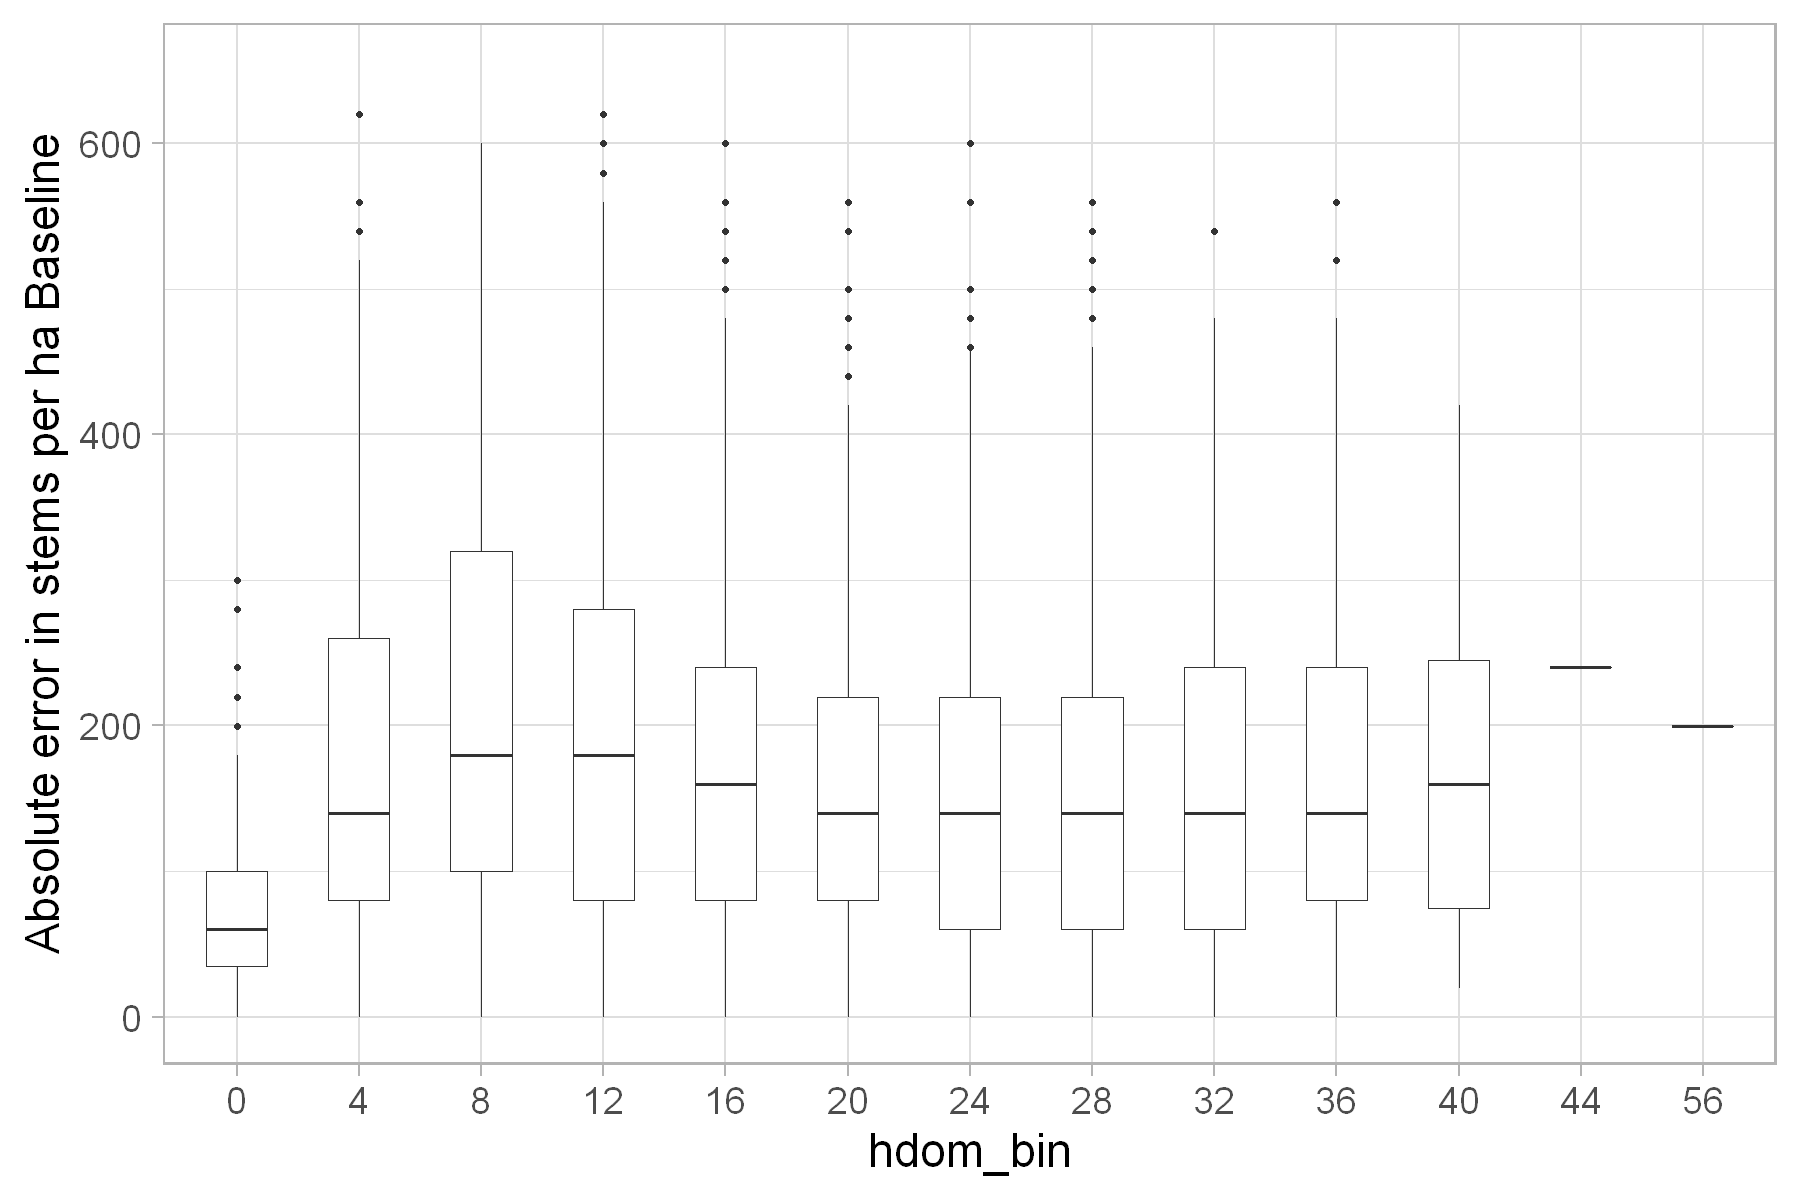

In [101]:
# Boxplots by binned dominant height  0 = [0m,4m[, 4 = [4m,8m[, 8 = [8m,12m[ ...
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=hdom_bin, y=stems_per_ha_abs_err_model)) +
#   geom_violin(trim=FALSE)+
  geom_boxplot(width=0.5)+
  ylim(0,350) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error in stems per ha Model") 

# Boxplots by binned degree of cover 0 = [0m,4m[, 4 = [4m,8m[, 8 = [8m,12m[ ...
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=hdom_bin, y=stems_per_ha_abs_err_baseline)) +
#   geom_violin(trim=FALSE)+
  geom_boxplot(width=0.5)+
  ylim(0,650) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error in stems per ha Baseline") 



Warning message:
"Removed 92 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 92 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 92 rows containing missing values (geom_point)."
Warning message:
"Removed 619 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 619 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 619 rows containing missing values (geom_point)."


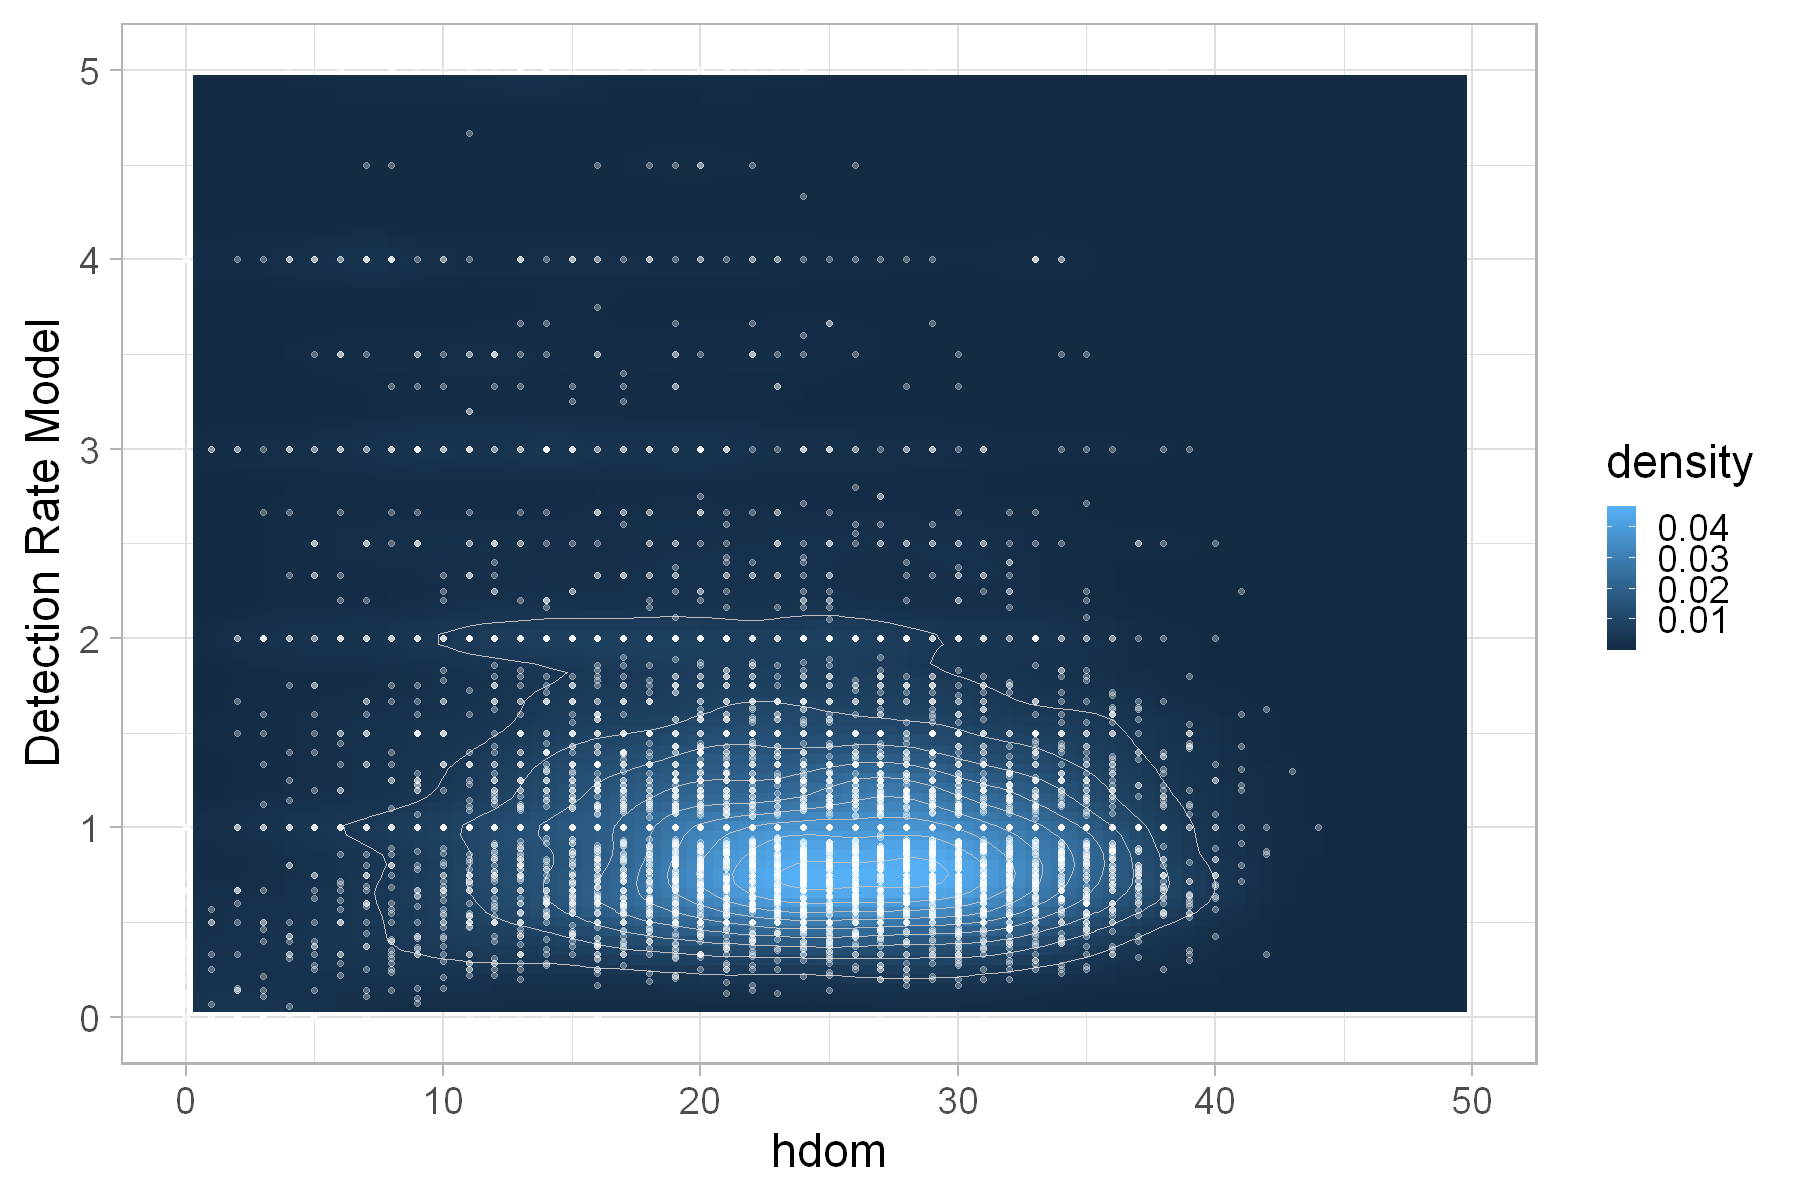

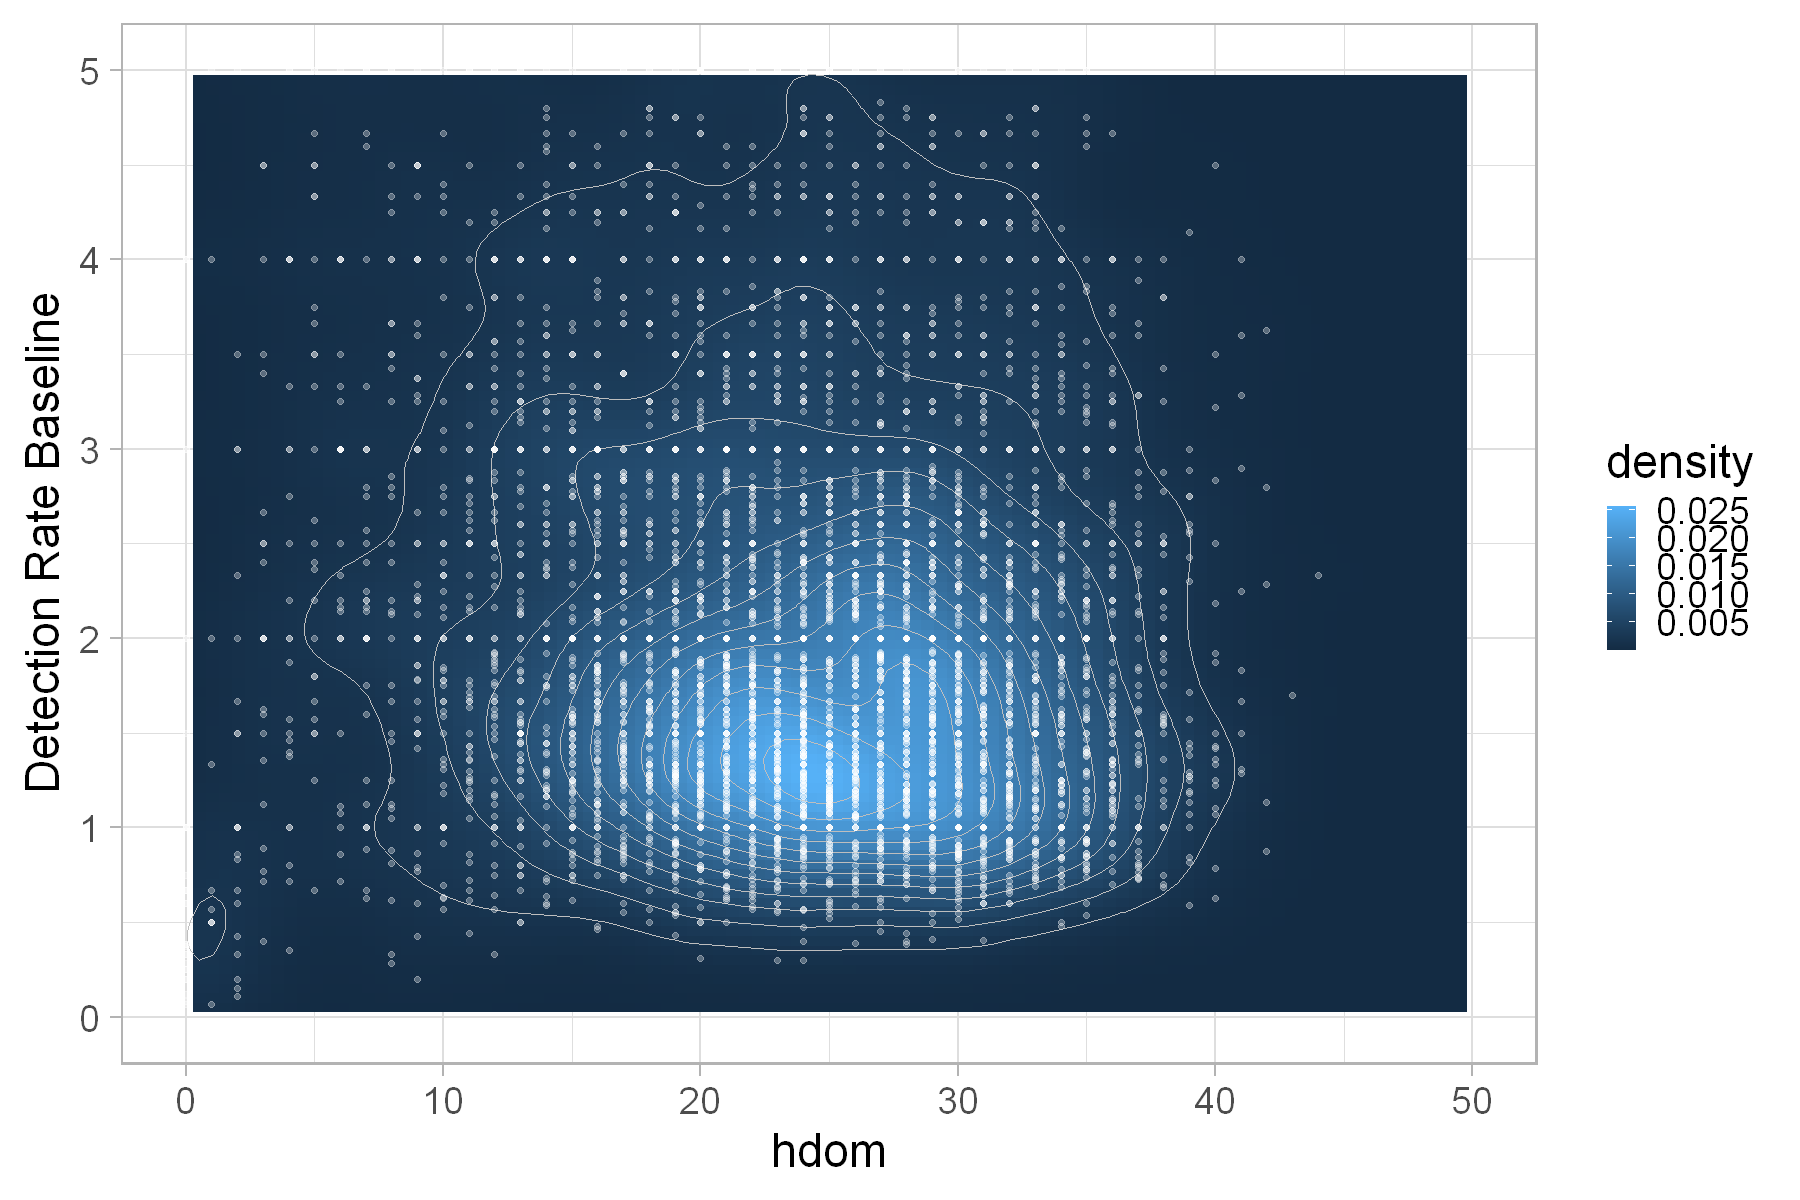

In [102]:
#Scatterplot Dominant Height vs Detection Rate
options(repr.plot.width=15, repr.plot.height=10)



ggplot(data, aes(x=hdom, y=dr_model)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_point(alpha=0.3, color="white") +
  xlim(0,50) +
  ylim(0,5) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  ylab("Detection Rate Model") 

#Scatterplot Dominant Height vs  Detection Rate
options(repr.plot.width=15, repr.plot.height=10)


ggplot(data, aes(x=hdom, y=dr_baseline)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_point(alpha=0.3, color="white") +
  xlim(0,50) +
  ylim(0,5) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  ylab("Detection Rate Baseline") 


Warning message:
"Removed 145 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 291 rows containing non-finite values (stat_boxplot)."


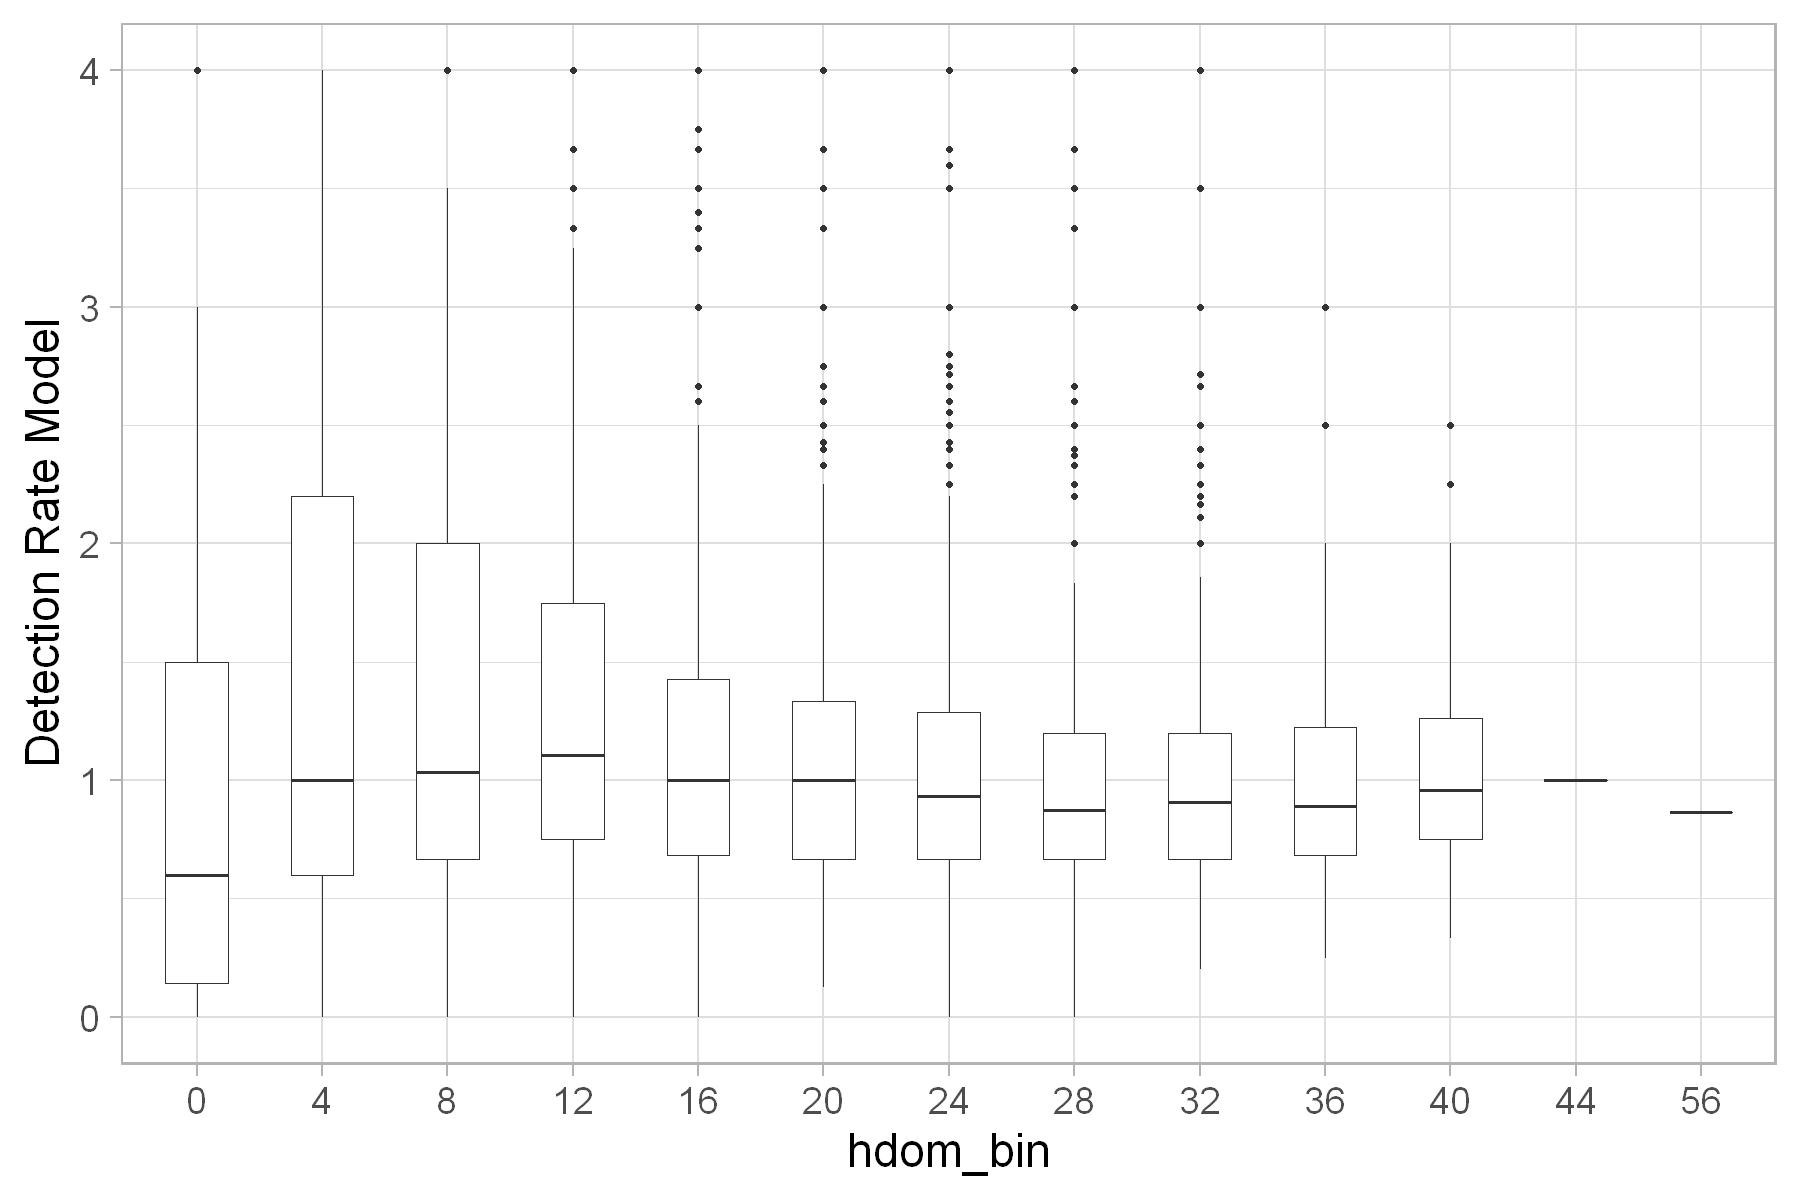

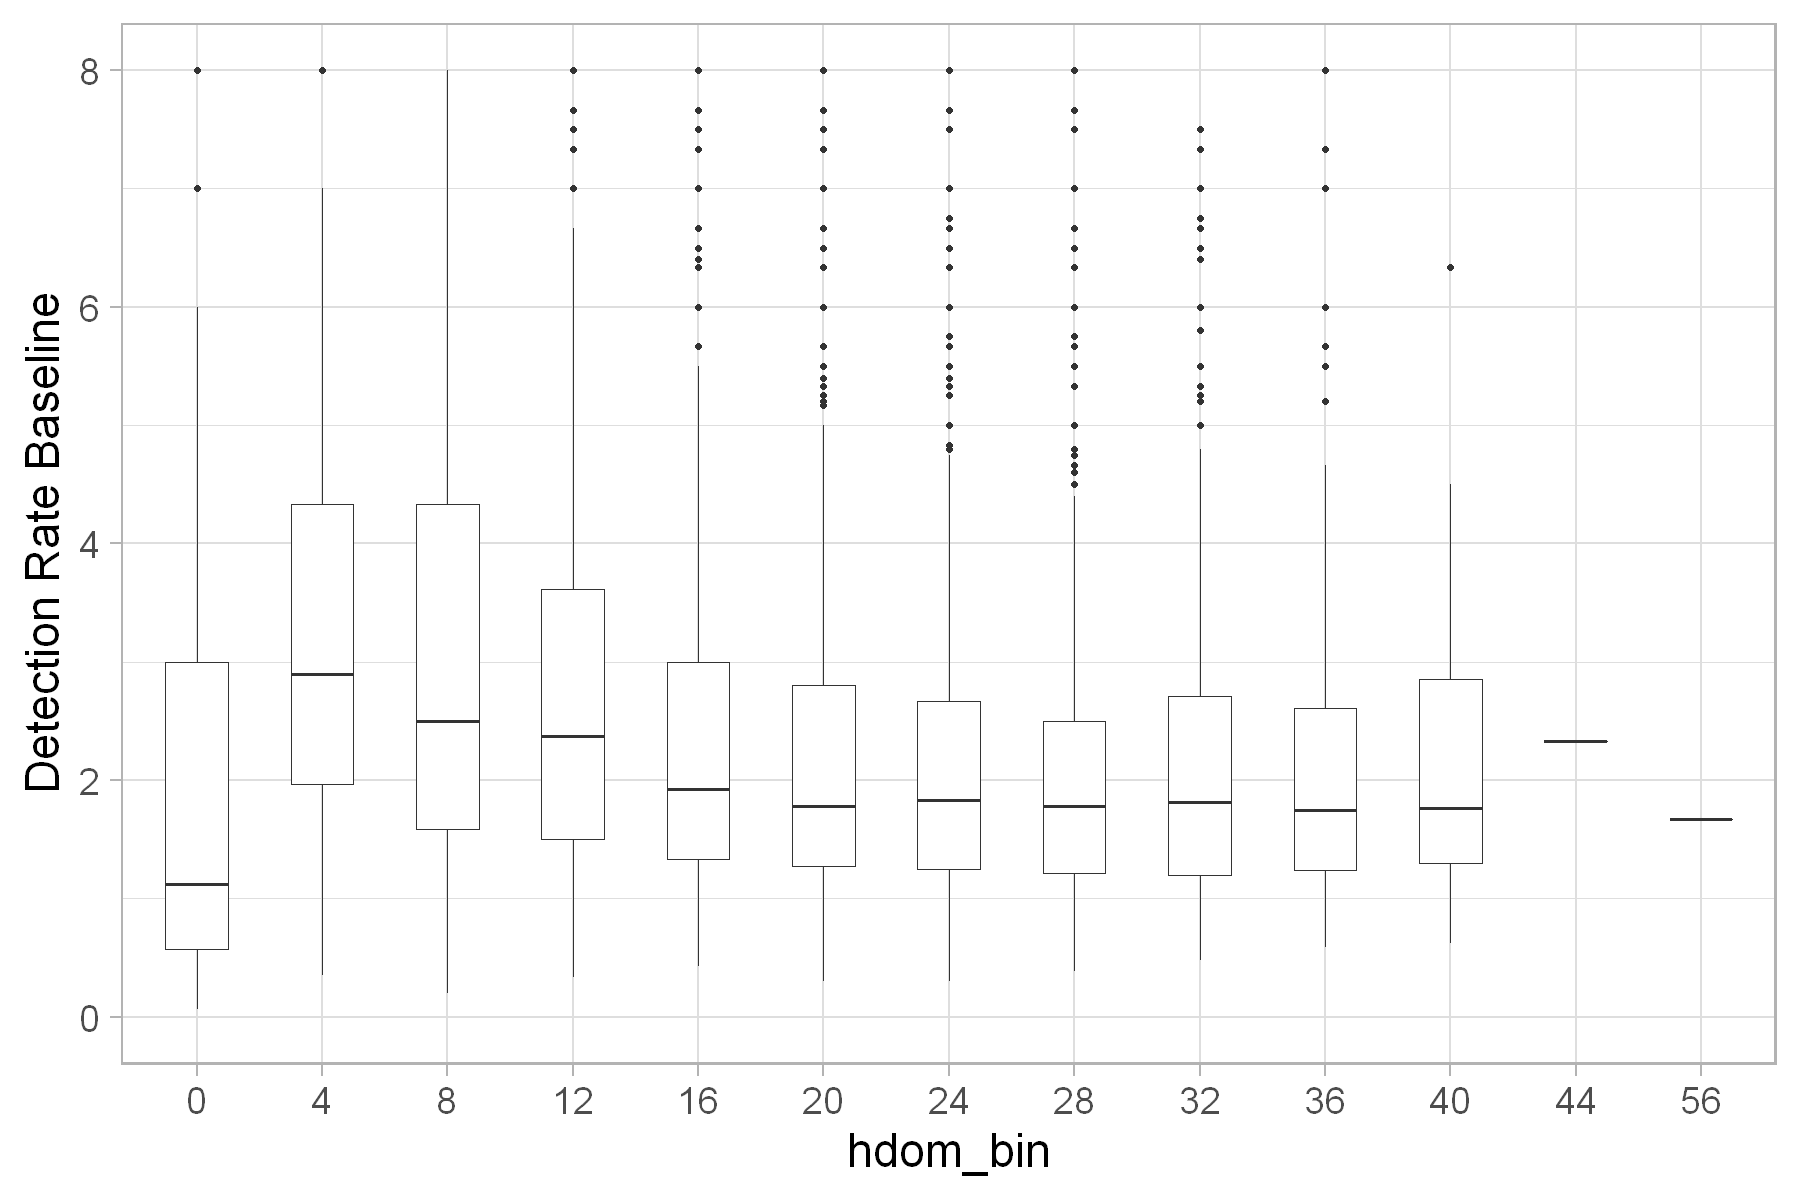

In [103]:
# Boxplots by binned  dominant height 0 = [0m,4m[, 4 = [4m,8m[, 8 = [8m,12m[ ...
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=hdom_bin, y=dr_model)) +
#   geom_violin(trim=FALSE)+
  geom_boxplot(width=0.5)+
  ylim(0,4) +
  theme_light(base_size = font_base_size) +
  ylab("Detection Rate Model") 

# Boxplots by binned dominant height 0 = [0m,4m[, 4 = [4m,8m[, 8 = [8m,12m[ ...
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=hdom_bin, y=dr_baseline)) +
#   geom_violin(trim=FALSE)+
  geom_boxplot(width=0.5)+
  ylim(0,8) +
  theme_light(base_size = font_base_size) +
  ylab("Detection Rate Baseline") 

